In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
import pandas as pd
import unicodedata
from collections import defaultdict
from tqdm import tqdm
from google.colab import files
import time
import logging

# Configure logging
logging.basicConfig(filename="process_log.log", level=logging.INFO, format='%(asctime)s - %(levelname)s - %(message)s')

# Load the CSV files
en_us_file_path = '/content/en_UK.csv'
fr_fr_file_path = '/content/fr_FR.csv'

try:
    en_us_df = pd.read_csv(en_us_file_path)
    fr_df = pd.read_csv(fr_fr_file_path)
except FileNotFoundError:
    logging.error(f"One or both CSV files not found. Please check the paths: {en_us_file_path}, {fr_fr_file_path}")
    exit(1)


# Function to normalize IPA transcriptions
def normalize_ipa(df, column):
    df[column] = df[column].apply(lambda x: unicodedata.normalize('NFC', str(x).strip()) if pd.notnull(x) else x)
    return df

# Ensure the columns are appropriately named
en_us_df.columns = ["word_en", "ipa"]
fr_df.columns = ["word_fr", "ipa"]

# Normalize IPA transcriptions
en_us_df = normalize_ipa(en_us_df, 'ipa')
fr_df = normalize_ipa(fr_df, 'ipa')

# Remove duplicates within each dataset
en_us_df = en_us_df.drop_duplicates().reset_index(drop=True)
fr_df = fr_df.drop_duplicates().reset_index(drop=True)


# --- FUNCTIONS TO CREATE PHONEME DATABASE ---

def generate_phoneme_strings(ipa_string, max_length=15):
    phonemes = set()
    for length in range(1, max_length + 1):
        phonemes.update(ipa_string[i:i + length] for i in range(len(ipa_string) - length + 1))
    return sorted(list(phonemes))

def create_phoneme_database(df, language, max_length=15):
    phoneme_dict = defaultdict(set)  # Use set for faster lookup
    for _, row in tqdm(df.iterrows(), total=len(df), desc=f"Processing {language} words"):
        ipa = row['ipa']
        if not pd.isnull(ipa):
            for phoneme_str in generate_phoneme_strings(ipa, max_length=max_length):
                phoneme_dict[phoneme_str].add(row[f'word_{language}'])
    return phoneme_dict

# --- MAIN EXECUTION ---

# Create dictionaries for easier lookup
en_phoneme_db = create_phoneme_database(en_us_df, 'en')
fr_phoneme_db = create_phoneme_database(fr_df, 'fr')

# Modified function to find matching phonemes iteratively from 1 phoneme onwards
def find_matching_phonemes_iterative(en_words, fr_words, min_length=1, max_length=15, batch_size=1000):
    matching_phonemes = []
    output_filename = "potential_homophones_phonemes.csv"
    last_saved_time = time.time()

    for length in tqdm(range(min_length, max_length + 1), desc="Processing phoneme lengths"):
        found_match = False
        num_en_words = len(en_words)
        num_fr_words = len(fr_words)
        length_start_time = time.time()

        with tqdm(total=num_en_words * num_fr_words, desc=f"Comparing words (length {length})") as pbar_inner:
            for ipa_en, word_en_set in en_words.items():
                if len(ipa_en) >= length:
                    for ipa_fr, word_fr_set in fr_words.items():
                        if len(ipa_fr) >= length:
                            phonemes_en = set(generate_phoneme_strings(ipa_en, max_length=length))
                            phonemes_fr = set(generate_phoneme_strings(ipa_fr, max_length=length))
                            common_phonemes = phonemes_en.intersection(phonemes_fr)
                            if common_phonemes:
                                for phoneme_str in common_phonemes:
                                    matching_phonemes.append({
                                        'phoneme_str': phoneme_str,
                                        'english_words': list(word_en_set)[:3],
                                        'french_words': list(word_fr_set)[:3]
                                    })
                                    found_match = True

                                # Print matches in the first minute of the current length iteration
                                if time.time() - length_start_time <= 60:
                                    print(f"Found match: {phoneme_str} - {list(word_en_set)[:3]} / {list(word_fr_set)[:3]}")

                        pbar_inner.update(1)

        # Log if no matches were found for this length after 1, 2 and 5 minutes
        time_elapsed = time.time() - length_start_time
        if not found_match and ((time_elapsed >= 60) or (time_elapsed >= 120) or (time_elapsed >= 300)):
            logging.info(f"No matches found for phoneme length {length} after {int(time_elapsed // 60)} minutes")


        # Save in batches every 20 minutes or at the end
        if (time.time() - last_saved_time > 1200) or (length == max_length and matching_phonemes):
            logging.info(f"Saving batch at phoneme length: {length}")
            if matching_phonemes:
                pd.DataFrame(matching_phonemes).to_csv(output_filename, index=False, mode='a', header=not os.path.exists(output_filename))
            matching_phonemes = []
            last_saved_time = time.time()

    return pd.DataFrame(matching_phonemes)

potential_homophones = find_matching_phonemes_iterative(en_phoneme_db, fr_phoneme_db)
print(potential_homophones)

# Create DataFrame and handle empty results (including remaining matches)
if not potential_homophones.empty:
    potential_homophones_df = potential_homophones
else:
    potential_homophones_df = pd.DataFrame(columns=['word_en', 'word_fr', 'phoneme'])

# Save to CSV and download
output_filename = "potential_homophones_phonemes.csv"
potential_homophones_df.to_csv(output_filename, index=False)

# Automatic Download (For Google Colab)
files.download(output_filename)

print(f"Potential homophone matching completed. Results saved to {output_filename} and downloaded.")


Comparing words (length 1):   0%|          | 14/1365253932421 [00:00<5360311:04:58, 70.75it/s]

Found match: / - ['carelessly', 'sparsest', 'sanitation'] / ['sous-exposée', 'gouvernes', 'sacquai']
Found match: / - ['carelessly', 'sparsest', 'sanitation'] / ['avérées', 'avisais', 'assommât']
Found match: / - ['carelessly', 'sparsest', 'sanitation'] / ['à', 'as', 'ah']
Found match: / - ['carelessly', 'sparsest', 'sanitation'] / ['constitutionnalisas', 'restituera', 'désenlaças']
Found match: / - ['carelessly', 'sparsest', 'sanitation'] / ['à aucun titre', 'à aucun prix', 'à aucun moment']
Found match: / - ['carelessly', 'sparsest', 'sanitation'] / ['à aucun titre', 'à aucun prix', 'à aucun moment']
Found match: / - ['carelessly', 'sparsest', 'sanitation'] / ['à aucun titre', 'à aucun prix', 'à aucun moment']
Found match: / - ['carelessly', 'sparsest', 'sanitation'] / ['à aucun titre', 'à aucun prix', 'à aucun moment']
Found match: / - ['carelessly', 'sparsest', 'sanitation'] / ['à aucun moment']
Found match: / - ['carelessly', 'sparsest', 'sanitation'] / ['à aucun moment']
Found ma


Comparing words (length 1):   0%|          | 88/1365253932421 [00:00<1828860:54:05, 207.36it/s]


Found match: / - ['carelessly', 'sparsest', 'sanitation'] / ['moment', 'à aucun moment', 'à tout moment']
Found match: / - ['carelessly', 'sparsest', 'sanitation'] / ['à aucun moment']
Found match: / - ['carelessly', 'sparsest', 'sanitation'] / ['à aucun moment', 'en un moment']
Found match: / - ['carelessly', 'sparsest', 'sanitation'] / ['cordialement', 'vend', 'égayant']
Found match: / - ['carelessly', 'sparsest', 'sanitation'] / ['consommant', 'romands', 'à aucun moment']
Found match: / - ['carelessly', 'sparsest', 'sanitation'] / ['vachions', 'harponnassions', 'égayant']
Found match: / - ['carelessly', 'sparsest', 'sanitation'] / ['à aucun moment', 'en un moment']
Found match: / - ['carelessly', 'sparsest', 'sanitation'] / ['à aucun prix']
Found match: / - ['carelessly', 'sparsest', 'sanitation'] / ['à aucun prix']
Found match: / - ['carelessly', 'sparsest', 'sanitation'] / ['à aucun prix']
Found match: / - ['carelessly', 'sparsest', 'sanitation'] / ['à aucun prix']
Found match: /


Comparing words (length 1):   0%|          | 138/1365253932421 [00:00<1679813:21:39, 225.76it/s]

Found match: / - ['carelessly', 'sparsest', 'sanitation'] / ['à aucun prix']
Found match: / - ['carelessly', 'sparsest', 'sanitation'] / ['à aucun prix']
Found match: / - ['carelessly', 'sparsest', 'sanitation'] / ['surpris', 'de prix', 'à aucun prix']
Found match: / - ['carelessly', 'sparsest', 'sanitation'] / ['à aucun prix']
Found match: / - ['carelessly', 'sparsest', 'sanitation'] / ['poudreries', 'tries', 'grivoiseries']
Found match: / - ['carelessly', 'sparsest', 'sanitation'] / ['à aucun prix', 'incompris', 'compris']
Found match: / - ['carelessly', 'sparsest', 'sanitation'] / ['à aucun titre']
Found match: / - ['carelessly', 'sparsest', 'sanitation'] / ['à aucun titre']
Found match: / - ['carelessly', 'sparsest', 'sanitation'] / ['à aucun titre']
Found match: / - ['carelessly', 'sparsest', 'sanitation'] / ['à aucun titre']
Found match: / - ['carelessly', 'sparsest', 'sanitation'] / ['à aucun titre']
Found match: / - ['carelessly', 'sparsest', 'sanitation'] / ['à aucun titre']
F


Comparing words (length 1):   0%|          | 161/1365253932421 [00:00<1976506:39:44, 191.87it/s]

Found match: / - ['carelessly', 'sparsest', 'sanitation'] / ['frustrent', 'parcmètre', 'saumâtres']
Found match: / - ['carelessly', 'sparsest', 'sanitation'] / ['à aucun titre', "à plus d'un titre"]
Found match: / - ['carelessly', 'sparsest', 'sanitation'] / ['craquetèrent', 'Épidaure', 'inversèrent']
Found match: / - ['carelessly', 'sparsest', 'sanitation'] / ['à aucun titre', "à plus d'un titre", 'banc-titre']
Found match: / - ['carelessly', 'sparsest', 'sanitation'] / ['abandonneras', 'abattues', 'abbé']
Found match: / - ['carelessly', 'sparsest', 'sanitation'] / ['abolie', 'abhorre', 'abondement']
Found match: / - ['carelessly', 'sparsest', 'sanitation'] / ['abonderaient', 'abondassiez', 'abondait']
Found match: / - ['carelessly', 'sparsest', 'sanitation'] / ['à bon compte']
Found match: / - ['carelessly', 'sparsest', 'sanitation'] / ['à bon compte']
Found match: / - ['carelessly', 'sparsest', 'sanitation'] / ['à bon compte']
Found match: / - ['carelessly', 'sparsest', 'sanitation'


Comparing words (length 1):   0%|          | 217/1365253932421 [00:01<1863965:30:48, 203.46it/s]

Found match: / - ['carelessly', 'sparsest', 'sanitation'] / ['décampâtes', 'redorâtes', 'aspirante']
Found match: / - ['carelessly', 'sparsest', 'sanitation'] / ['pour mon compte', 'à bon compte', 'pour son compte']
Found match: / - ['carelessly', 'sparsest', 'sanitation'] / ['laissées-pour-compte', 'racontes', 'recompte']
Found match: / - ['carelessly', 'sparsest', 'sanitation'] / ['pour mon compte', 'à bon compte', 'pour son compte']
Found match: / - ['carelessly', 'sparsest', 'sanitation'] / ['tout-puissante', 'tordante', 'remplaçantes']
Found match: / - ['carelessly', 'sparsest', 'sanitation'] / ['aboutiront', 'abouchant', 'aboutirons']
Found match: / - ['carelessly', 'sparsest', 'sanitation'] / ['abouts', 'about', 'à bout']
Found match: / - ['carelessly', 'sparsest', 'sanitation'] / ['tabous', 'abouts', 'tabou']
Found match: / - ['carelessly', 'sparsest', 'sanitation'] / ['abouts', 'caribou', 'embout']
Found match: / - ['carelessly', 'sparsest', 'sanitation'] / ['embout', 'glouglo


Comparing words (length 1):   0%|          | 268/1365253932421 [00:01<1694448:27:21, 223.81it/s]

Found match: / - ['carelessly', 'sparsest', 'sanitation'] / ['à bout portant']
Found match: / - ['carelessly', 'sparsest', 'sanitation'] / ['à bout portant']
Found match: / - ['carelessly', 'sparsest', 'sanitation'] / ['à bout portant']
Found match: / - ['carelessly', 'sparsest', 'sanitation'] / ['à bout portant']
Found match: / - ['carelessly', 'sparsest', 'sanitation'] / ['à bout portant']
Found match: / - ['carelessly', 'sparsest', 'sanitation'] / ['à bout portant']
Found match: / - ['carelessly', 'sparsest', 'sanitation'] / ['à bout portant']
Found match: / - ['carelessly', 'sparsest', 'sanitation'] / ['à bout portant']
Found match: / - ['carelessly', 'sparsest', 'sanitation'] / ['à bout portant']
Found match: / - ['carelessly', 'sparsest', 'sanitation'] / ['portants', 'importants', 'supportant']
Found match: / - ['carelessly', 'sparsest', 'sanitation'] / ['retâtant', 'miroitant', 'caoutchoutant']
Found match: / - ['carelessly', 'sparsest', 'sanitation'] / ['à bout portant']
Found 


Comparing words (length 1):   0%|          | 292/1365253932421 [00:01<1715932:54:40, 221.01it/s]


Found match: / - ['carelessly', 'sparsest', 'sanitation'] / ['à bras ouverts']
Found match: / - ['carelessly', 'sparsest', 'sanitation'] / ['à bras ouverts']
Found match: / - ['carelessly', 'sparsest', 'sanitation'] / ['à bras ouverts']
Found match: / - ['carelessly', 'sparsest', 'sanitation'] / ['à bras ouverts']
Found match: / - ['carelessly', 'sparsest', 'sanitation'] / ['à bras ouverts']
Found match: / - ['carelessly', 'sparsest', 'sanitation'] / ['à bras ouverts']
Found match: / - ['carelessly', 'sparsest', 'sanitation'] / ['à bras ouverts']
Found match: / - ['carelessly', 'sparsest', 'sanitation'] / ['à bras ouverts']
Found match: / - ['carelessly', 'sparsest', 'sanitation'] / ['à mots couverts', 'découvert', 'interviewèrent']
Found match: / - ['carelessly', 'sparsest', 'sanitation'] / ['à mots couverts', 'vert', 'rouverts']
Found match: / - ['carelessly', 'sparsest', 'sanitation'] / ['à bras ouverts']
Found match: / - ['carelessly', 'sparsest', 'sanitation'] / ['craquetèrent', '

Comparing words (length 1):   0%|          | 344/1365253932421 [00:01<1717374:03:42, 220.82it/s]

Found match: / - ['carelessly', 'sparsest', 'sanitation'] / ['accastilles', 'accapareras', 'accaparaient']
Found match: / - ['carelessly', 'sparsest', 'sanitation'] / ['accapareras', 'accaparaient', 'accapariez']
Found match: / - ['carelessly', 'sparsest', 'sanitation'] / ['a capella']
Found match: / - ['carelessly', 'sparsest', 'sanitation'] / ['a capella']
Found match: / - ['carelessly', 'sparsest', 'sanitation'] / ['a capella']
Found match: / - ['carelessly', 'sparsest', 'sanitation'] / ['a capella']
Found match: / - ['carelessly', 'sparsest', 'sanitation'] / ['a capella']
Found match: / - ['carelessly', 'sparsest', 'sanitation'] / ['a capella']
Found match: / - ['carelessly', 'sparsest', 'sanitation'] / ['entremêlât', 'entremêla', 'excellât']
Found match: / - ['carelessly', 'sparsest', 'sanitation'] / ['a capella']
Found match: / - ['carelessly', 'sparsest', 'sanitation'] / ['copulât', 'poêlât', 'cancrelats']
Found match: / - ['carelessly', 'sparsest', 'sanitation'] / ['a capella']


Comparing words (length 1):   0%|          | 407/1365253932421 [00:01<1491577:03:01, 254.25it/s]

Found match: / - ['carelessly', 'sparsest', 'sanitation'] / ['à ce compte', 'à ce compte-là']
Found match: / - ['carelessly', 'sparsest', 'sanitation'] / ['à ce compte', 'à ce compte-là']
Found match: / - ['carelessly', 'sparsest', 'sanitation'] / ['à ce compte']
Found match: / - ['carelessly', 'sparsest', 'sanitation'] / ['à ce compte']
Found match: / - ['carelessly', 'sparsest', 'sanitation'] / ['à ce compte']
Found match: / - ['carelessly', 'sparsest', 'sanitation'] / ['à ce compte', 'recompte', 'recomptent']
Found match: / - ['carelessly', 'sparsest', 'sanitation'] / ['à ce compte-là']
Found match: / - ['carelessly', 'sparsest', 'sanitation'] / ['à ce compte-là']
Found match: / - ['carelessly', 'sparsest', 'sanitation'] / ['à ce compte-là']
Found match: / - ['carelessly', 'sparsest', 'sanitation'] / ['à ce compte-là']
Found match: / - ['carelessly', 'sparsest', 'sanitation'] / ['à ce compte-là']
Found match: / - ['carelessly', 'sparsest', 'sanitation'] / ['à ce compte-là']
Found ma


Comparing words (length 1):   0%|          | 496/1365253932421 [00:02<1117098:31:55, 339.48it/s]


Found match: / - ['carelessly', 'sparsest', 'sanitation'] / ['à ce moment-là']
Found match: / - ['carelessly', 'sparsest', 'sanitation'] / ['à ce moment-là']
Found match: / - ['carelessly', 'sparsest', 'sanitation'] / ['en ce temps-là', 'branlât', 'ébranlât']
Found match: / - ['carelessly', 'sparsest', 'sanitation'] / ['à ce point que', 'à ce point']
Found match: / - ['carelessly', 'sparsest', 'sanitation'] / ['à ce point que', 'à ce point']
Found match: / - ['carelessly', 'sparsest', 'sanitation'] / ['à ce point que', 'à ce point']
Found match: / - ['carelessly', 'sparsest', 'sanitation'] / ['à ce point que', 'à ce point']
Found match: / - ['carelessly', 'sparsest', 'sanitation'] / ['à ce point']
Found match: / - ['carelessly', 'sparsest', 'sanitation'] / ['à ce point']
Found match: / - ['carelessly', 'sparsest', 'sanitation'] / ['points', 'coup de poing', 'shampoing']
Found match: / - ['carelessly', 'sparsest', 'sanitation'] / ['à ce point']
Found match: / - ['carelessly', 'sparsest


Comparing words (length 1):   0%|          | 585/1365253932421 [00:02<997429:43:44, 380.21it/s] 

Found match: / - ['carelessly', 'sparsest', 'sanitation'] / ['à ce titre']
Found match: / - ['carelessly', 'sparsest', 'sanitation'] / ['à ce titre']
Found match: / - ['carelessly', 'sparsest', 'sanitation'] / ['à ce titre']
Found match: / - ['carelessly', 'sparsest', 'sanitation'] / ['à ce titre']
Found match: / - ['carelessly', 'sparsest', 'sanitation'] / ['à cela près que']
Found match: / - ['carelessly', 'sparsest', 'sanitation'] / ['à cela près que']
Found match: / - ['carelessly', 'sparsest', 'sanitation'] / ['à cela près que']
Found match: / - ['carelessly', 'sparsest', 'sanitation'] / ['à cela près que']
Found match: / - ['carelessly', 'sparsest', 'sanitation'] / ['à cela près que']
Found match: / - ['carelessly', 'sparsest', 'sanitation'] / ['à cela près que']
Found match: / - ['carelessly', 'sparsest', 'sanitation'] / ['à cela près que']
Found match: / - ['carelessly', 'sparsest', 'sanitation'] / ['à cela près que']
Found match: / - ['carelessly', 'sparsest', 'sanitation'] / 


Comparing words (length 1):   0%|          | 735/1365253932421 [00:02<649800:32:55, 583.62it/s]

Found match: / - ['carelessly', 'sparsest', 'sanitation'] / ['à cette différence près que']
Found match: / - ['carelessly', 'sparsest', 'sanitation'] / ['à cette différence près que']
Found match: / - ['carelessly', 'sparsest', 'sanitation'] / ['à cette différence près que']
Found match: / - ['carelessly', 'sparsest', 'sanitation'] / ['à cette différence près que']
Found match: / - ['carelessly', 'sparsest', 'sanitation'] / ['à cette différence près que']
Found match: / - ['carelessly', 'sparsest', 'sanitation'] / ['à cette différence près que']
Found match: / - ['carelessly', 'sparsest', 'sanitation'] / ['à cette différence près que']
Found match: / - ['carelessly', 'sparsest', 'sanitation'] / ['à cette différence près que']
Found match: / - ['carelessly', 'sparsest', 'sanitation'] / ['à cette différence près que']
Found match: / - ['carelessly', 'sparsest', 'sanitation'] / ['à cette différence près que']
Found match: / - ['carelessly', 'sparsest', 'sanitation'] / ['à cette différence


Comparing words (length 1):   0%|          | 848/1365253932421 [00:02<817172:15:08, 464.08it/s]

Found match: / - ['carelessly', 'sparsest', 'sanitation'] / ['prometteur', 'neurotransmetteurs', 'malfaiteurs']
Found match: / - ['carelessly', 'sparsest', 'sanitation'] / ['acclimateriez', 'acclimatai', 'acclimatant']
Found match: / - ['carelessly', 'sparsest', 'sanitation'] / ['à clef', 'à clefs']
Found match: / - ['carelessly', 'sparsest', 'sanitation'] / ['à clef', 'à clefs']
Found match: / - ['carelessly', 'sparsest', 'sanitation'] / ['bâclée', 'renâclé', 'bâclées']
Found match: / - ['carelessly', 'sparsest', 'sanitation'] / ['sous-exposée', 'créchée', 'accoter']
Found match: / - ['carelessly', 'sparsest', 'sanitation'] / ['bâclée', 'nickelés', 'bâclées']
Found match: / - ['carelessly', 'sparsest', 'sanitation'] / ['bêlés', 'lé', 'ventilez']
Found match: / - ['carelessly', 'sparsest', 'sanitation'] / ['accueillantes', 'accueils', 'accueillant']
Found match: / - ['carelessly', 'sparsest', 'sanitation'] / ['à cœur joie', 'à cœur ouvert', 'à cœur']
Found match: / - ['carelessly', 'sp


Comparing words (length 1):   0%|          | 898/1365253932421 [00:02<857510:41:14, 442.25it/s]


Found match: / - ['carelessly', 'sparsest', 'sanitation'] / ['acoquinera', 'accommodassent', 'accoter']
Found match: / - ['carelessly', 'sparsest', 'sanitation'] / ['accompliriez', 'accompagnez', 'accomplît']
Found match: / - ['carelessly', 'sparsest', 'sanitation'] / ['accompliriez', 'accompagnez', 'accomplît']
Found match: / - ['carelessly', 'sparsest', 'sanitation'] / ['à composition']
Found match: / - ['carelessly', 'sparsest', 'sanitation'] / ['à composition']
Found match: / - ['carelessly', 'sparsest', 'sanitation'] / ['à composition']
Found match: / - ['carelessly', 'sparsest', 'sanitation'] / ['à composition']
Found match: / - ['carelessly', 'sparsest', 'sanitation'] / ['à composition']
Found match: / - ['carelessly', 'sparsest', 'sanitation'] / ['à composition']
Found match: / - ['carelessly', 'sparsest', 'sanitation'] / ['à composition']
Found match: / - ['carelessly', 'sparsest', 'sanitation'] / ['à composition']
Found match: / - ['carelessly', 'sparsest', 'sanitation'] / ['

Comparing words (length 1):   0%|          | 1060/1365253932421 [00:03<809232:48:24, 468.64it/s]

Found match: / - ['carelessly', 'sparsest', 'sanitation'] / ['à compter de']
Found match: / - ['carelessly', 'sparsest', 'sanitation'] / ['à condition que', 'à condition de']
Found match: / - ['carelessly', 'sparsest', 'sanitation'] / ['à condition que', 'à condition de']
Found match: / - ['carelessly', 'sparsest', 'sanitation'] / ['à condition que', 'à condition de']
Found match: / - ['carelessly', 'sparsest', 'sanitation'] / ['à condition que', 'à condition de']
Found match: / - ['carelessly', 'sparsest', 'sanitation'] / ['à condition que', 'à condition de']
Found match: / - ['carelessly', 'sparsest', 'sanitation'] / ['à condition que', 'à condition de']
Found match: / - ['carelessly', 'sparsest', 'sanitation'] / ['à condition de']
Found match: / - ['carelessly', 'sparsest', 'sanitation'] / ['à condition de']
Found match: / - ['carelessly', 'sparsest', 'sanitation'] / ['à condition de']
Found match: / - ['carelessly', 'sparsest', 'sanitation'] / ['à condition de']
Found match: / - ['


Comparing words (length 1):   0%|          | 1108/1365253932421 [00:03<857844:47:15, 442.08it/s]


Found match: / - ['carelessly', 'sparsest', 'sanitation'] / ['a contrario']
Found match: / - ['carelessly', 'sparsest', 'sanitation'] / ['a contrario']
Found match: / - ['carelessly', 'sparsest', 'sanitation'] / ['a contrario']
Found match: / - ['carelessly', 'sparsest', 'sanitation'] / ['notariaux', 'impresarios', 'a contrario']
Found match: / - ['carelessly', 'sparsest', 'sanitation'] / ['médico-sociaux', 'impresarios', 'chiots']
Found match: / - ['carelessly', 'sparsest', 'sanitation'] / ['a contrario']
Found match: / - ['carelessly', 'sparsest', 'sanitation'] / ['cachalot', 'locaux', 'aérospatiaux']
Found match: / - ['carelessly', 'sparsest', 'sanitation'] / ['a contrario']
Found match: / - ['carelessly', 'sparsest', 'sanitation'] / ['a contrario']
Found match: / - ['carelessly', 'sparsest', 'sanitation'] / ['a contrario']
Found match: / - ['carelessly', 'sparsest', 'sanitation'] / ['matériau', 'impresarios', 'inquisitoriaux']
Found match: / - ['carelessly', 'sparsest', 'sanitation

Comparing words (length 1):   0%|          | 1199/1365253932421 [00:03<1003919:37:01, 377.76it/s]


Found match: / - ['carelessly', 'sparsest', 'sanitation'] / ['à-côtés', 'à côté', 'à côté de']
Found match: / - ['carelessly', 'sparsest', 'sanitation'] / ['à-côtés', 'à côté', 'à côté de']
Found match: / - ['carelessly', 'sparsest', 'sanitation'] / ['à-côtés', 'à côté', 'à-côté']
Found match: / - ['carelessly', 'sparsest', 'sanitation'] / ['bas-côté', 'à côté', 'à-côtés']
Found match: / - ['carelessly', 'sparsest', 'sanitation'] / ['bas-côté', 'à côté', 'de côté']
Found match: / - ['carelessly', 'sparsest', 'sanitation'] / ['principautés', 'tressautées', 'de mon côté']
Found match: / - ['carelessly', 'sparsest', 'sanitation'] / ['honorabilité', 'mité', 'accoter']
Found match: / - ['carelessly', 'sparsest', 'sanitation'] / ['à côté de']
Found match: / - ['carelessly', 'sparsest', 'sanitation'] / ['à côté de']
Found match: / - ['carelessly', 'sparsest', 'sanitation'] / ['à côté de']
Found match: / - ['carelessly', 'sparsest', 'sanitation'] / ['à côté de']
Found match: / - ['carelessly',

Comparing words (length 1):   0%|          | 1356/1365253932421 [00:03<827821:48:44, 458.11it/s] 

Found match: / - ['carelessly', 'sparsest', 'sanitation'] / ['à court terme']
Found match: / - ['carelessly', 'sparsest', 'sanitation'] / ['derme', 'referment', 'angiosperme']
Found match: / - ['carelessly', 'sparsest', 'sanitation'] / ['pachyderme', 'réarmes', 'reformes']
Found match: / - ['carelessly', 'sparsest', 'sanitation'] / ['à court terme']
Found match: / - ['carelessly', 'sparsest', 'sanitation'] / ['à courte vue']
Found match: / - ['carelessly', 'sparsest', 'sanitation'] / ['à courte vue']
Found match: / - ['carelessly', 'sparsest', 'sanitation'] / ['à courte vue']
Found match: / - ['carelessly', 'sparsest', 'sanitation'] / ['à courte vue']
Found match: / - ['carelessly', 'sparsest', 'sanitation'] / ['à courte vue']
Found match: / - ['carelessly', 'sparsest', 'sanitation'] / ['à courte vue']
Found match: / - ['carelessly', 'sparsest', 'sanitation'] / ['à courte vue']
Found match: / - ['carelessly', 'sparsest', 'sanitation'] / ['pourvu', "m'as-tu-vu", 'point de vue']
Found ma


Comparing words (length 1):   0%|          | 1456/1365253932421 [00:04<838695:03:05, 452.18it/s]

Found match: / - ['carelessly', 'sparsest', 'sanitation'] / ['à de nombreux titres']
Found match: / - ['carelessly', 'sparsest', 'sanitation'] / ['additionnasses', 'addition', 'additionnelles']
Found match: / - ['carelessly', 'sparsest', 'sanitation'] / ['à dire le vrai', 'à dire vrai']
Found match: / - ['carelessly', 'sparsest', 'sanitation'] / ['à dire le vrai']
Found match: / - ['carelessly', 'sparsest', 'sanitation'] / ['à dire le vrai']
Found match: / - ['carelessly', 'sparsest', 'sanitation'] / ['à dire le vrai']
Found match: / - ['carelessly', 'sparsest', 'sanitation'] / ['à dire le vrai']
Found match: / - ['carelessly', 'sparsest', 'sanitation'] / ['à dire le vrai']
Found match: / - ['carelessly', 'sparsest', 'sanitation'] / ['à dire le vrai']
Found match: / - ['carelessly', 'sparsest', 'sanitation'] / ['à dire le vrai']
Found match: / - ['carelessly', 'sparsest', 'sanitation'] / ['à dire le vrai']
Found match: / - ['carelessly', 'sparsest', 'sanitation'] / ['à dire le vrai']
F


Comparing words (length 1):   0%|          | 1508/1365253932421 [00:04<815249:43:24, 465.18it/s]


Found match: / - ['carelessly', 'sparsest', 'sanitation'] / ['à divers titres']
Found match: / - ['carelessly', 'sparsest', 'sanitation'] / ['à divers titres']
Found match: / - ['carelessly', 'sparsest', 'sanitation'] / ['intertitres', 'intertitre', 'à divers titres']
Found match: / - ['carelessly', 'sparsest', 'sanitation'] / ['intertitres', 'surtitre', 'intertitre']
Found match: / - ['carelessly', 'sparsest', 'sanitation'] / ['affiniez', 'affaiblirait', 'affronté']
Found match: / - ['carelessly', 'sparsest', 'sanitation'] / ['affaleriez', 'affadir', 'affalât']
Found match: / - ['carelessly', 'sparsest', 'sanitation'] / ['à façon']
Found match: / - ['carelessly', 'sparsest', 'sanitation'] / ['à façon']
Found match: / - ['carelessly', 'sparsest', 'sanitation'] / ['à façon']
Found match: / - ['carelessly', 'sparsest', 'sanitation'] / ['à façon']
Found match: / - ['carelessly', 'sparsest', 'sanitation'] / ['à ma façon', 'à sa façon', 'de sa façon']
Found match: / - ['carelessly', 'spars


Comparing words (length 1):   0%|          | 1607/1365253932421 [00:04<933284:52:00, 406.35it/s] 

Found match: / - ['carelessly', 'sparsest', 'sanitation'] / ['à fond']
Found match: / - ['carelessly', 'sparsest', 'sanitation'] / ['balafons', 'décoiffons', 'agrafons']
Found match: / - ['carelessly', 'sparsest', 'sanitation'] / ['lofons', 'greffons', 'piffons']
Found match: / - ['carelessly', 'sparsest', 'sanitation'] / ['à fond de train']
Found match: / - ['carelessly', 'sparsest', 'sanitation'] / ['à fond de train']
Found match: / - ['carelessly', 'sparsest', 'sanitation'] / ['à fond de train']
Found match: / - ['carelessly', 'sparsest', 'sanitation'] / ['à fond de train']
Found match: / - ['carelessly', 'sparsest', 'sanitation'] / ['à fond de train']
Found match: / - ['carelessly', 'sparsest', 'sanitation'] / ['à fond de train']
Found match: / - ['carelessly', 'sparsest', 'sanitation'] / ['à fond de train']
Found match: / - ['carelessly', 'sparsest', 'sanitation'] / ['à fond de train']
Found match: / - ['carelessly', 'sparsest', 'sanitation'] / ['à fond de train']
Found match: / -


Comparing words (length 1):   0%|          | 1709/1365253932421 [00:04<846745:20:31, 447.88it/s]

Found match: / - ['carelessly', 'sparsest', 'sanitation'] / ['à fond la caisse']
Found match: / - ['carelessly', 'sparsest', 'sanitation'] / ['désenflasses', 'grisaillasse', 'coinçasses']
Found match: / - ['carelessly', 'sparsest', 'sanitation'] / ['à fond la caisse']
Found match: / - ['carelessly', 'sparsest', 'sanitation'] / ['topless', 'ivresses', 'enchanteresses']
Found match: / - ['carelessly', 'sparsest', 'sanitation'] / ['à fond la caisse']
Found match: / - ['carelessly', 'sparsest', 'sanitation'] / ['à fond les manettes']
Found match: / - ['carelessly', 'sparsest', 'sanitation'] / ['à fond les manettes']
Found match: / - ['carelessly', 'sparsest', 'sanitation'] / ['à fond les manettes']
Found match: / - ['carelessly', 'sparsest', 'sanitation'] / ['à fond les manettes']
Found match: / - ['carelessly', 'sparsest', 'sanitation'] / ['à fond les manettes']
Found match: / - ['carelessly', 'sparsest', 'sanitation'] / ['à fond les manettes']
Found match: / - ['carelessly', 'sparsest', 


Comparing words (length 1):   0%|          | 1756/1365253932421 [00:04<954885:14:33, 397.15it/s]

Found match: / - ['carelessly', 'sparsest', 'sanitation'] / ['à force de', 'à la force de']
Found match: / - ['carelessly', 'sparsest', 'sanitation'] / ['à force de', 'à la force de', 'en lieu et place de']
Found match: / - ['carelessly', 'sparsest', 'sanitation'] / ['à force de', 'à la force de']
Found match: / - ['carelessly', 'sparsest', 'sanitation'] / ['à force de', 'à la force de']
Found match: / - ['carelessly', 'sparsest', 'sanitation'] / ['a fortiori']
Found match: / - ['carelessly', 'sparsest', 'sanitation'] / ['a fortiori']
Found match: / - ['carelessly', 'sparsest', 'sanitation'] / ['a fortiori']
Found match: / - ['carelessly', 'sparsest', 'sanitation'] / ['a fortiori']
Found match: / - ['carelessly', 'sparsest', 'sanitation'] / ['a fortiori']
Found match: / - ['carelessly', 'sparsest', 'sanitation'] / ['a fortiori']
Found match: / - ['carelessly', 'sparsest', 'sanitation'] / ['a fortiori', 'fortiori']
Found match: / - ['carelessly', 'sparsest', 'sanitation'] / ['a priori',


Comparing words (length 1):   0%|          | 1839/1365253932421 [00:05<1014126:50:18, 373.95it/s]

Found match: / - ['carelessly', 'sparsest', 'sanitation'] / ['à grands traits']
Found match: / - ['carelessly', 'sparsest', 'sanitation'] / ['à grands traits']
Found match: / - ['carelessly', 'sparsest', 'sanitation'] / ['à grands traits']
Found match: / - ['carelessly', 'sparsest', 'sanitation'] / ['à grands traits']
Found match: / - ['carelessly', 'sparsest', 'sanitation'] / ['feutraient', 'séquestrais', 'concentraient']
Found match: / - ['carelessly', 'sparsest', 'sanitation'] / ['déconcentrai', 'rentrait', 'entrai']
Found match: / - ['carelessly', 'sparsest', 'sanitation'] / ['rentrais', 'à grands traits', 'rentrait']
Found match: / - ['carelessly', 'sparsest', 'sanitation'] / ['contrais', 'contraient', 'déconcentrai']
Found match: / - ['carelessly', 'sparsest', 'sanitation'] / ['ajourât', 'agitations', 'ajournasses']
Found match: / - ['carelessly', 'sparsest', 'sanitation'] / ['ajourneriez', 'ajourassions', 'ajoutez']
Found match: / - ['carelessly', 'sparsest', 'sanitation'] / ['a


Comparing words (length 1):   0%|          | 1922/1365253932421 [00:05<1096643:09:47, 345.82it/s]


Found match: / - ['carelessly', 'sparsest', 'sanitation'] / ["à l'eau de rose"]
Found match: / - ['carelessly', 'sparsest', 'sanitation'] / ["à l'eau de rose"]
Found match: / - ['carelessly', 'sparsest', 'sanitation'] / ["à l'eau de rose"]
Found match: / - ['carelessly', 'sparsest', 'sanitation'] / ["à l'eau de rose"]
Found match: / - ['carelessly', 'sparsest', 'sanitation'] / ["à l'eau de rose"]
Found match: / - ['carelessly', 'sparsest', 'sanitation'] / ['clauses', 'décomposes', 'recompose']
Found match: / - ['carelessly', 'sparsest', 'sanitation'] / ['encolleuse', 'eczémateuse', 'arbouses']
Found match: / - ['carelessly', 'sparsest', 'sanitation'] / ["à l'eau de rose"]
Found match: / - ['carelessly', 'sparsest', 'sanitation'] / ['athéroscléroses', 'synarthroses', 'nécrosent']
Found match: / - ['carelessly', 'sparsest', 'sanitation'] / ['allégations', 'allaitèrent', 'allégiez']
Found match: / - ['carelessly', 'sparsest', 'sanitation'] / ["à l'égard de", 'allégation', 'allégations']
F

Comparing words (length 1):   0%|          | 2091/1365253932421 [00:05<807710:31:35, 469.52it/s]

Found match: / - ['carelessly', 'sparsest', 'sanitation'] / ["à l'évidence"]
Found match: / - ['carelessly', 'sparsest', 'sanitation'] / ['providence', 'évidences', 'de toute évidence']
Found match: / - ['carelessly', 'sparsest', 'sanitation'] / ['innocences', 'nuisances', 'évanescence']
Found match: / - ['carelessly', 'sparsest', 'sanitation'] / ['bulletin-réponse', 'innocences', 'nuisances']
Found match: / - ['carelessly', 'sparsest', 'sanitation'] / ['alerteront', 'allergique', 'allèches']
Found match: / - ['carelessly', 'sparsest', 'sanitation'] / ['alexandrines', 'alexandrins', 'alexandrin']
Found match: / - ['carelessly', 'sparsest', 'sanitation'] / ['alexandrines', 'alexandrins', 'alexandrin']
Found match: / - ['carelessly', 'sparsest', 'sanitation'] / ["à l'exception de"]
Found match: / - ['carelessly', 'sparsest', 'sanitation'] / ["à l'exception de"]
Found match: / - ['carelessly', 'sparsest', 'sanitation'] / ["à l'exception de"]
Found match: / - ['carelessly', 'sparsest', 'sa


Comparing words (length 1):   0%|          | 2140/1365253932421 [00:05<853104:59:12, 444.54it/s]

Found match: / - ['carelessly', 'sparsest', 'sanitation'] / ["à l'heure de", 'au cœur de']
Found match: / - ['carelessly', 'sparsest', 'sanitation'] / ["à l'instant même", "à l'instant"]
Found match: / - ['carelessly', 'sparsest', 'sanitation'] / ["à l'instant même", "à l'instant"]
Found match: / - ['carelessly', 'sparsest', 'sanitation'] / ["à l'instant même", "à l'instant"]
Found match: / - ['carelessly', 'sparsest', 'sanitation'] / ["à l'instant même", "à l'instant"]
Found match: / - ['carelessly', 'sparsest', 'sanitation'] / ["à l'instant même", "à l'instant"]
Found match: / - ['carelessly', 'sparsest', 'sanitation'] / ["à l'instant"]
Found match: / - ['carelessly', 'sparsest', 'sanitation'] / ["à l'instant"]
Found match: / - ['carelessly', 'sparsest', 'sanitation'] / ["dans l'instant", "à l'instant", "pour l'instant"]
Found match: / - ['carelessly', 'sparsest', 'sanitation'] / ['infestant', 'préexistants', 'Turkménistan']
Found match: / - ['carelessly', 'sparsest', 'sanitation'] /


Comparing words (length 1):   0%|          | 2229/1365253932421 [00:06<955490:29:33, 396.90it/s]

Found match: / - ['carelessly', 'sparsest', 'sanitation'] / ['à la bonne heure']
Found match: / - ['carelessly', 'sparsest', 'sanitation'] / ['à la bonne heure']
Found match: / - ['carelessly', 'sparsest', 'sanitation'] / ['bonheurs', 'de bonne heure', 'bonheur']
Found match: / - ['carelessly', 'sparsest', 'sanitation'] / ['à la bonne heure']
Found match: / - ['carelessly', 'sparsest', 'sanitation'] / ['sectionneurs', 'laineur', 'gouverneurs']
Found match: / - ['carelessly', 'sparsest', 'sanitation'] / ['sectionneurs', 'bonheurs', 'de bonne heure']
Found match: / - ['carelessly', 'sparsest', 'sanitation'] / ['alacrité', 'alacrités', 'à la condition que']
Found match: / - ['carelessly', 'sparsest', 'sanitation'] / ['à la clef']
Found match: / - ['carelessly', 'sparsest', 'sanitation'] / ['à la clef']
Found match: / - ['carelessly', 'sparsest', 'sanitation'] / ['à la clef']
Found match: / - ['carelessly', 'sparsest', 'sanitation'] / ['à la clef']
Found match: / - ['carelessly', 'sparsest


Comparing words (length 1):   0%|          | 2311/1365253932421 [00:06<964648:01:27, 393.14it/s]

Found match: / - ['carelessly', 'sparsest', 'sanitation'] / ['à la différence de', 'à la différence que']
Found match: / - ['carelessly', 'sparsest', 'sanitation'] / ['à la différence de', 'à la différence que']
Found match: / - ['carelessly', 'sparsest', 'sanitation'] / ['à la différence de']
Found match: / - ['carelessly', 'sparsest', 'sanitation'] / ['à la différence de']
Found match: / - ['carelessly', 'sparsest', 'sanitation'] / ['à la différence de']
Found match: / - ['carelessly', 'sparsest', 'sanitation'] / ['à la différence de']
Found match: / - ['carelessly', 'sparsest', 'sanitation'] / ['à la différence de']
Found match: / - ['carelessly', 'sparsest', 'sanitation'] / ['à la différence de']
Found match: / - ['carelessly', 'sparsest', 'sanitation'] / ['à la différence de']
Found match: / - ['carelessly', 'sparsest', 'sanitation'] / ['à la différence de']
Found match: / - ['carelessly', 'sparsest', 'sanitation'] / ['à la différence de']
Found match: / - ['carelessly', 'sparsest


Comparing words (length 1):   0%|          | 2388/1365253932421 [00:06<1066181:34:34, 355.70it/s]

Found match: / - ['carelessly', 'sparsest', 'sanitation'] / ['à la façon de']
Found match: / - ['carelessly', 'sparsest', 'sanitation'] / ['à la façon de']
Found match: / - ['carelessly', 'sparsest', 'sanitation'] / ['à la façon de']
Found match: / - ['carelessly', 'sparsest', 'sanitation'] / ['à la façon de']
Found match: / - ['carelessly', 'sparsest', 'sanitation'] / ['à la façon de']
Found match: / - ['carelessly', 'sparsest', 'sanitation'] / ['à la façon de']
Found match: / - ['carelessly', 'sparsest', 'sanitation'] / ['à la façon de']
Found match: / - ['carelessly', 'sparsest', 'sanitation'] / ['à la façon de']
Found match: / - ['carelessly', 'sparsest', 'sanitation'] / ['à la façon de']
Found match: / - ['carelessly', 'sparsest', 'sanitation'] / ['à la façon de']
Found match: / - ['carelessly', 'sparsest', 'sanitation'] / ['à la fin de', 'à la fin']
Found match: / - ['carelessly', 'sparsest', 'sanitation'] / ['à la fin de', 'à la fin']
Found match: / - ['carelessly', 'sparsest', 


Comparing words (length 1):   0%|          | 2459/1365253932421 [00:06<1159404:19:32, 327.10it/s]

Found match: / - ['carelessly', 'sparsest', 'sanitation'] / ['à la force de']
Found match: / - ['carelessly', 'sparsest', 'sanitation'] / ['à la force de']
Found match: / - ['carelessly', 'sparsest', 'sanitation'] / ['à la force de']
Found match: / - ['carelessly', 'sparsest', 'sanitation'] / ['hallali', 'à la lettre', 'hallalis']
Found match: / - ['carelessly', 'sparsest', 'sanitation'] / ['à la lettre']
Found match: / - ['carelessly', 'sparsest', 'sanitation'] / ['à la lettre']
Found match: / - ['carelessly', 'sparsest', 'sanitation'] / ['à la lettre']
Found match: / - ['carelessly', 'sparsest', 'sanitation'] / ['à la lettre']
Found match: / - ['carelessly', 'sparsest', 'sanitation'] / ['à la lettre']
Found match: / - ['carelessly', 'sparsest', 'sanitation'] / ['au pied de la lettre', 'mal-être', 'mandat-lettre']
Found match: / - ['carelessly', 'sparsest', 'sanitation'] / ['au pied de la lettre', 'à la lettre', 'avant la lettre']
Found match: / - ['carelessly', 'sparsest', 'sanitatio


Comparing words (length 1):   0%|          | 2534/1365253932421 [00:07<1192379:53:39, 318.05it/s]

Found match: / - ['carelessly', 'sparsest', 'sanitation'] / ['casanières', 'cancanière', 'à ma manière']
Found match: / - ['carelessly', 'sparsest', 'sanitation'] / ['pétaudières', 'soufrière', 'hauturières']
Found match: / - ['carelessly', 'sparsest', 'sanitation'] / ['à la manière']
Found match: / - ['carelessly', 'sparsest', 'sanitation'] / ['en aucune manière', 'à sa manière', 'de cette manière']
Found match: / - ['carelessly', 'sparsest', 'sanitation'] / ['pionnière', 'braconnière', 'crinières']
Found match: / - ['carelessly', 'sparsest', 'sanitation'] / ['à la manière de']
Found match: / - ['carelessly', 'sparsest', 'sanitation'] / ['à la manière de']
Found match: / - ['carelessly', 'sparsest', 'sanitation'] / ['à la manière de']
Found match: / - ['carelessly', 'sparsest', 'sanitation'] / ['à la manière de']
Found match: / - ['carelessly', 'sparsest', 'sanitation'] / ['à la manière de']
Found match: / - ['carelessly', 'sparsest', 'sanitation'] / ['par manière de', 'en manière de'


Comparing words (length 1):   0%|          | 2636/1365253932421 [00:07<940579:21:42, 403.20it/s] 

Found match: / - ['carelessly', 'sparsest', 'sanitation'] / ['en mémoire de', 'de mémoire de', 'à la mémoire de']
Found match: / - ['carelessly', 'sparsest', 'sanitation'] / ['à la mémoire de']
Found match: / - ['carelessly', 'sparsest', 'sanitation'] / ['en mémoire de', 'de mémoire de', 'à la mémoire de']
Found match: / - ['carelessly', 'sparsest', 'sanitation'] / ['en mémoire de', 'de mémoire de', 'à la mémoire de']
Found match: / - ['carelessly', 'sparsest', 'sanitation'] / ['en mémoire de', 'de mémoire de', 'à la mémoire de']
Found match: / - ['carelessly', 'sparsest', 'sanitation'] / ['à la pièce']
Found match: / - ['carelessly', 'sparsest', 'sanitation'] / ['à la pièce']
Found match: / - ['carelessly', 'sparsest', 'sanitation'] / ['à la pièce']
Found match: / - ['carelessly', 'sparsest', 'sanitation'] / ['à la pièce']
Found match: / - ['carelessly', 'sparsest', 'sanitation'] / ['à la pièce']
Found match: / - ['carelessly', 'sparsest', 'sanitation'] / ['à la pièce']
Found match: /


Comparing words (length 1):   0%|          | 2678/1365253932421 [00:07<1122092:44:21, 337.97it/s]

Found match: / - ['carelessly', 'sparsest', 'sanitation'] / ['en tête de', 'du haute de', 'exception faite de']
Found match: / - ['carelessly', 'sparsest', 'sanitation'] / ['par suite de', 'à la suite de']
Found match: / - ['carelessly', 'sparsest', 'sanitation'] / ['à la tête de']
Found match: / - ['carelessly', 'sparsest', 'sanitation'] / ['à la tête de']
Found match: / - ['carelessly', 'sparsest', 'sanitation'] / ['à la tête de']
Found match: / - ['carelessly', 'sparsest', 'sanitation'] / ['à la tête de']
Found match: / - ['carelessly', 'sparsest', 'sanitation'] / ['à la tête de']
Found match: / - ['carelessly', 'sparsest', 'sanitation'] / ['à la tête de']
Found match: / - ['carelessly', 'sparsest', 'sanitation'] / ['à la tête de']
Found match: / - ['carelessly', 'sparsest', 'sanitation'] / ['à la tête de', 'sur la tête de']
Found match: / - ['carelessly', 'sparsest', 'sanitation'] / ['à la tête de', 'sur la tête de']
Found match: / - ['carelessly', 'sparsest', 'sanitation'] / ['à l


Comparing words (length 1):   0%|          | 2750/1365253932421 [00:07<1217786:13:25, 311.42it/s]

Found match: / - ['carelessly', 'sparsest', 'sanitation'] / ['allongèrent', 'allocataires', 'allongeaient']
Found match: / - ['carelessly', 'sparsest', 'sanitation'] / ['allongèrent', 'allongeaient', 'allongement']
Found match: / - ['carelessly', 'sparsest', 'sanitation'] / ['à longs traits', 'à long terme']
Found match: / - ['carelessly', 'sparsest', 'sanitation'] / ['à long terme']
Found match: / - ['carelessly', 'sparsest', 'sanitation'] / ['à long terme']
Found match: / - ['carelessly', 'sparsest', 'sanitation'] / ['à long terme']
Found match: / - ['carelessly', 'sparsest', 'sanitation'] / ['à long terme']
Found match: / - ['carelessly', 'sparsest', 'sanitation'] / ['à long terme']
Found match: / - ['carelessly', 'sparsest', 'sanitation'] / ['à long terme']
Found match: / - ['carelessly', 'sparsest', 'sanitation'] / ['à long terme']
Found match: / - ['carelessly', 'sparsest', 'sanitation'] / ['avant terme', 'à long terme']
Found match: / - ['carelessly', 'sparsest', 'sanitation'] /


Comparing words (length 1):   0%|          | 2857/1365253932421 [00:07<929728:47:16, 407.90it/s] 


Found match: / - ['carelessly', 'sparsest', 'sanitation'] / ['à ma connaissance']
Found match: / - ['carelessly', 'sparsest', 'sanitation'] / ['de ma connaissance', 'à sa connaissance', 'reconnaissance']
Found match: / - ['carelessly', 'sparsest', 'sanitation'] / ['à ma connaissance', 'de ma connaissance']
Found match: / - ['carelessly', 'sparsest', 'sanitation'] / ['à sa connaissance', 'naissances', 'de connaissance']
Found match: / - ['carelessly', 'sparsest', 'sanitation'] / ['innocences', 'à sa connaissance', 'évanescence']
Found match: / - ['carelessly', 'sparsest', 'sanitation'] / ['de ma connaissance', 'à sa connaissance', 'reconnaissance']
Found match: / - ['carelessly', 'sparsest', 'sanitation'] / ['à sa connaissance', 'naissances', 'de connaissance']
Found match: / - ['carelessly', 'sparsest', 'sanitation'] / ['à ma convenance']
Found match: / - ['carelessly', 'sparsest', 'sanitation'] / ['à ma convenance']
Found match: / - ['carelessly', 'sparsest', 'sanitation'] / ['à ma c


Comparing words (length 1):   0%|          | 2900/1365253932421 [00:08<1055247:53:44, 359.38it/s]

Found match: / - ['carelessly', 'sparsest', 'sanitation'] / ['à ma façon']
Found match: / - ['carelessly', 'sparsest', 'sanitation'] / ['à ma façon', 'de ma façon']
Found match: / - ['carelessly', 'sparsest', 'sanitation'] / ['à ma manière', 'hamamélis']
Found match: / - ['carelessly', 'sparsest', 'sanitation'] / ['à ma manière']
Found match: / - ['carelessly', 'sparsest', 'sanitation'] / ['à ma manière']
Found match: / - ['carelessly', 'sparsest', 'sanitation'] / ['à ma manière']
Found match: / - ['carelessly', 'sparsest', 'sanitation'] / ['à ma manière']
Found match: / - ['carelessly', 'sparsest', 'sanitation'] / ['à ma manière']
Found match: / - ['carelessly', 'sparsest', 'sanitation'] / ['à ma manière']
Found match: / - ['carelessly', 'sparsest', 'sanitation'] / ['à ma manière']
Found match: / - ['carelessly', 'sparsest', 'sanitation'] / ['à ma manière']
Found match: / - ['carelessly', 'sparsest', 'sanitation'] / ['à main gauche', 'amaigriras', 'amincir']
Found match: / - ['careles


Comparing words (length 1):   0%|          | 2978/1365253932421 [00:08<1103030:34:42, 343.81it/s]

Found match: / - ['carelessly', 'sparsest', 'sanitation'] / ['à main gauche']
Found match: / - ['carelessly', 'sparsest', 'sanitation'] / ['à main gauche']
Found match: / - ['carelessly', 'sparsest', 'sanitation'] / ['à main gauche']
Found match: / - ['carelessly', 'sparsest', 'sanitation'] / ['rive gauche', 'à main gauche', 'gauches']
Found match: / - ['carelessly', 'sparsest', 'sanitation'] / ['à main gauche']
Found match: / - ['carelessly', 'sparsest', 'sanitation'] / ['à main gauche', 'gauche', 'rive gauche']
Found match: / - ['carelessly', 'sparsest', 'sanitation'] / ['à main gauche']
Found match: / - ['carelessly', 'sparsest', 'sanitation'] / ['dessèches', 'godiches', 'mèches']
Found match: / - ['carelessly', 'sparsest', 'sanitation'] / ['à main gauche']
Found match: / - ['carelessly', 'sparsest', 'sanitation'] / ['amoindririez', 'amoindrissez', 'amoindris']
Found match: / - ['carelessly', 'sparsest', 'sanitation'] / ['amoindririez', 'amoindrissez', 'amoindris']
Found match: / - 


Comparing words (length 1):   0%|          | 3014/1365253932421 [00:08<1293830:46:52, 293.11it/s]

Found match: / - ['carelessly', 'sparsest', 'sanitation'] / ['à moins que', "d'autant moins que"]
Found match: / - ['carelessly', 'sparsest', 'sanitation'] / ['amoché', 'amoncelâtes', 'amochâtes']
Found match: / - ['carelessly', 'sparsest', 'sanitation'] / ['amoncelâtes', 'amoncellerais', 'amoncelassions']
Found match: / - ['carelessly', 'sparsest', 'sanitation'] / ['à mon corps défendant']
Found match: / - ['carelessly', 'sparsest', 'sanitation'] / ['à mon corps défendant']
Found match: / - ['carelessly', 'sparsest', 'sanitation'] / ['à mon corps défendant']
Found match: / - ['carelessly', 'sparsest', 'sanitation'] / ['à mon corps défendant']
Found match: / - ['carelessly', 'sparsest', 'sanitation'] / ['à mon corps défendant']
Found match: / - ['carelessly', 'sparsest', 'sanitation'] / ['à mon corps défendant']
Found match: / - ['carelessly', 'sparsest', 'sanitation'] / ['à mon corps défendant']
Found match: / - ['carelessly', 'sparsest', 'sanitation'] / ['à mon corps défendant']
Foun


Comparing words (length 1):   0%|          | 3154/1365253932421 [00:08<946397:16:51, 400.72it/s]


Found match: / - ['carelessly', 'sparsest', 'sanitation'] / ['à mots couverts']
Found match: / - ['carelessly', 'sparsest', 'sanitation'] / ['à mots couverts']
Found match: / - ['carelessly', 'sparsest', 'sanitation'] / ['à mots couverts']
Found match: / - ['carelessly', 'sparsest', 'sanitation'] / ['à mots couverts']
Found match: / - ['carelessly', 'sparsest', 'sanitation'] / ['à mots couverts']
Found match: / - ['carelessly', 'sparsest', 'sanitation'] / ['à mots couverts']
Found match: / - ['carelessly', 'sparsest', 'sanitation'] / ['à mots couverts']
Found match: / - ['carelessly', 'sparsest', 'sanitation'] / ['à mots couverts', 'découvert', 'redécouvert']
Found match: / - ['carelessly', 'sparsest', 'sanitation'] / ['à mots couverts']
Found match: / - ['carelessly', 'sparsest', 'sanitation'] / ['à mots couverts']
Found match: / - ['carelessly', 'sparsest', 'sanitation'] / ['anathématiserais', 'annualisera', 'annoncer']
Found match: / - ['carelessly', 'sparsest', 'sanitation'] / ['an

Comparing words (length 1):   0%|          | 3299/1365253932421 [00:08<753484:40:39, 503.31it/s]

Found match: / - ['carelessly', 'sparsest', 'sanitation'] / ['poupard', 'sudoripare', 'primipares']
Found match: / - ['carelessly', 'sparsest', 'sanitation'] / ['appartiendrait', 'appartenue', 'appartenances']
Found match: / - ['carelessly', 'sparsest', 'sanitation'] / ['à part entière']
Found match: / - ['carelessly', 'sparsest', 'sanitation'] / ['à part entière']
Found match: / - ['carelessly', 'sparsest', 'sanitation'] / ['à part entière']
Found match: / - ['carelessly', 'sparsest', 'sanitation'] / ['à part entière']
Found match: / - ['carelessly', 'sparsest', 'sanitation'] / ['à part entière']
Found match: / - ['carelessly', 'sparsest', 'sanitation'] / ['à part entière']
Found match: / - ['carelessly', 'sparsest', 'sanitation'] / ['à part entière']
Found match: / - ['carelessly', 'sparsest', 'sanitation'] / ['à part entière']
Found match: / - ['carelessly', 'sparsest', 'sanitation'] / ['à part entière']
Found match: / - ['carelessly', 'sparsest', 'sanitation'] / ['à part entière']



Comparing words (length 1):   0%|          | 3401/1365253932421 [00:09<853023:50:27, 444.58it/s]

Found match: / - ['carelessly', 'sparsest', 'sanitation'] / ['à peu de choses près']
Found match: / - ['carelessly', 'sparsest', 'sanitation'] / ['à peu de choses près']
Found match: / - ['carelessly', 'sparsest', 'sanitation'] / ['à peu de choses près']
Found match: / - ['carelessly', 'sparsest', 'sanitation'] / ['à peu de choses près']
Found match: / - ['carelessly', 'sparsest', 'sanitation'] / ['à peu de choses près']
Found match: / - ['carelessly', 'sparsest', 'sanitation'] / ['à peu de choses près']
Found match: / - ['carelessly', 'sparsest', 'sanitation'] / ['à peu de choses près']
Found match: / - ['carelessly', 'sparsest', 'sanitation'] / ['apprêt', 'couperet', 'à-peu-près']
Found match: / - ['carelessly', 'sparsest', 'sanitation'] / ['à peu de choses près']
Found match: / - ['carelessly', 'sparsest', 'sanitation'] / ['à peu de choses près']
Found match: / - ['carelessly', 'sparsest', 'sanitation'] / ['à peu de choses près']
Found match: / - ['carelessly', 'sparsest', 'sanitati


Comparing words (length 1):   0%|          | 3491/1365253932421 [00:09<1020665:37:54, 371.56it/s]

Found match: / - ['carelessly', 'sparsest', 'sanitation'] / ['à pied sec']
Found match: / - ['carelessly', 'sparsest', 'sanitation'] / ['à pied sec']
Found match: / - ['carelessly', 'sparsest', 'sanitation'] / ['à pied sec']
Found match: / - ['carelessly', 'sparsest', 'sanitation'] / ['à pied sec']
Found match: / - ['carelessly', 'sparsest', 'sanitation'] / ['à pied sec']
Found match: / - ['carelessly', 'sparsest', 'sanitation'] / ['ESSEC', 'à pied sec']
Found match: / - ['carelessly', 'sparsest', 'sanitation'] / ['à pied sec']
Found match: / - ['carelessly', 'sparsest', 'sanitation'] / ['crics', 'somatique', 'monolithiques']
Found match: / - ['carelessly', 'sparsest', 'sanitation'] / ['à pied sec']
Found match: / - ['carelessly', 'sparsest', 'sanitation'] / ['ESSEC', 'intrinsèque', 'extrinsèques']
Found match: / - ['carelessly', 'sparsest', 'sanitation'] / ['grecs', 'sonothèque', 'bibliothèque']
Found match: / - ['carelessly', 'sparsest', 'sanitation'] / ['aplanis', 'aplatirais', 'app


Comparing words (length 1):   0%|          | 3580/1365253932421 [00:09<968595:29:37, 391.53it/s] 

Found match: / - ['carelessly', 'sparsest', 'sanitation'] / ["à plus d'un titre"]
Found match: / - ['carelessly', 'sparsest', 'sanitation'] / ["à plus d'un titre"]
Found match: / - ['carelessly', 'sparsest', 'sanitation'] / ["à plus d'un titre"]
Found match: / - ['carelessly', 'sparsest', 'sanitation'] / ["à plus d'un titre"]
Found match: / - ['carelessly', 'sparsest', 'sanitation'] / ["à plus d'un titre"]
Found match: / - ['carelessly', 'sparsest', 'sanitation'] / ["à plus d'un titre"]
Found match: / - ['carelessly', 'sparsest', 'sanitation'] / ["à plus d'un titre"]
Found match: / - ['carelessly', 'sparsest', 'sanitation'] / ["à plus d'un titre"]
Found match: / - ['carelessly', 'sparsest', 'sanitation'] / ["à plus d'un titre"]
Found match: / - ['carelessly', 'sparsest', 'sanitation'] / ["à plus d'un titre"]
Found match: / - ['carelessly', 'sparsest', 'sanitation'] / ["à plus d'un titre"]
Found match: / - ['carelessly', 'sparsest', 'sanitation'] / ["à plus d'un titre"]
Found match: / -


Comparing words (length 1):   0%|          | 3632/1365253932421 [00:09<900196:10:27, 421.28it/s]


Found match: / - ['carelessly', 'sparsest', 'sanitation'] / ['à point nommé']
Found match: / - ['carelessly', 'sparsest', 'sanitation'] / ['apportés', 'apporterais', 'apponteraient']
Found match: / - ['carelessly', 'sparsest', 'sanitation'] / ['apostrophâtes', 'apostolat', 'apostolique']
Found match: / - ['carelessly', 'sparsest', 'sanitation'] / ['apostrophâtes', 'apostolat', 'apostolique']
Found match: / - ['carelessly', 'sparsest', 'sanitation'] / ['a posteriori']
Found match: / - ['carelessly', 'sparsest', 'sanitation'] / ['a posteriori']
Found match: / - ['carelessly', 'sparsest', 'sanitation'] / ['a posteriori']
Found match: / - ['carelessly', 'sparsest', 'sanitation'] / ['a posteriori']
Found match: / - ['carelessly', 'sparsest', 'sanitation'] / ['a posteriori']
Found match: / - ['carelessly', 'sparsest', 'sanitation'] / ['a posteriori']
Found match: / - ['carelessly', 'sparsest', 'sanitation'] / ['a posteriori']
Found match: / - ['carelessly', 'sparsest', 'sanitation'] / ['a po

Comparing words (length 1):   0%|          | 3718/1365253932421 [00:10<927932:53:40, 408.69it/s]

Found match: / - ['carelessly', 'sparsest', 'sanitation'] / ['acquisition', 'acquitterais', 'acquis']
Found match: / - ['carelessly', 'sparsest', 'sanitation'] / ['à qui mieux mieux']
Found match: / - ['carelessly', 'sparsest', 'sanitation'] / ['à qui mieux mieux']
Found match: / - ['carelessly', 'sparsest', 'sanitation'] / ['à qui mieux mieux']
Found match: / - ['carelessly', 'sparsest', 'sanitation'] / ['à qui mieux mieux']
Found match: / - ['carelessly', 'sparsest', 'sanitation'] / ['à qui mieux mieux']
Found match: / - ['carelessly', 'sparsest', 'sanitation'] / ['à qui mieux mieux']
Found match: / - ['carelessly', 'sparsest', 'sanitation'] / ['à qui mieux mieux']
Found match: / - ['carelessly', 'sparsest', 'sanitation'] / ['à qui mieux mieux']
Found match: / - ['carelessly', 'sparsest', 'sanitation'] / ['à qui mieux mieux']
Found match: / - ['carelessly', 'sparsest', 'sanitation'] / ['litigieux', 'pieu', 'milieu']
Found match: / - ['carelessly', 'sparsest', 'sanitation'] / ['à qui 


Comparing words (length 1):   0%|          | 3798/1365253932421 [00:10<1063945:51:55, 356.44it/s]

Found match: / - ['carelessly', 'sparsest', 'sanitation'] / ['en raison de', 'à raison de']
Found match: / - ['carelessly', 'sparsest', 'sanitation'] / ['assagîmes', 'à sa connaissance', 'assaillir']
Found match: / - ['carelessly', 'sparsest', 'sanitation'] / ['à sa convenance', 'à sa connaissance']
Found match: / - ['carelessly', 'sparsest', 'sanitation'] / ['à sa convenance', 'à sa connaissance']
Found match: / - ['carelessly', 'sparsest', 'sanitation'] / ['à sa connaissance']
Found match: / - ['carelessly', 'sparsest', 'sanitation'] / ['à sa connaissance']
Found match: / - ['carelessly', 'sparsest', 'sanitation'] / ['à sa connaissance']
Found match: / - ['carelessly', 'sparsest', 'sanitation'] / ['à sa connaissance']
Found match: / - ['carelessly', 'sparsest', 'sanitation'] / ['à sa connaissance']
Found match: / - ['carelessly', 'sparsest', 'sanitation'] / ['à sa connaissance']
Found match: / - ['carelessly', 'sparsest', 'sanitation'] / ['à sa connaissance']
Found match: / - ['carel


Comparing words (length 1):   0%|          | 3835/1365253932421 [00:10<1271441:00:40, 298.27it/s]

Found match: / - ['carelessly', 'sparsest', 'sanitation'] / ['à sa façon']
Found match: / - ['carelessly', 'sparsest', 'sanitation'] / ['à sa façon']
Found match: / - ['carelessly', 'sparsest', 'sanitation'] / ['à sa façon']
Found match: / - ['carelessly', 'sparsest', 'sanitation'] / ['de sa façon', 'à sa façon']
Found match: / - ['carelessly', 'sparsest', 'sanitation'] / ['à sa manière']
Found match: / - ['carelessly', 'sparsest', 'sanitation'] / ['à sa manière']
Found match: / - ['carelessly', 'sparsest', 'sanitation'] / ['à sa manière']
Found match: / - ['carelessly', 'sparsest', 'sanitation'] / ['à sa manière']
Found match: / - ['carelessly', 'sparsest', 'sanitation'] / ['à sa manière']
Found match: / - ['carelessly', 'sparsest', 'sanitation'] / ['à sa manière']
Found match: / - ['carelessly', 'sparsest', 'sanitation'] / ['à sa manière']
Found match: / - ['carelessly', 'sparsest', 'sanitation'] / ['à sa manière']
Found match: / - ['carelessly', 'sparsest', 'sanitation'] / ['à sa ma


Comparing words (length 1):   0%|          | 3920/1365253932421 [00:10<1087385:03:00, 348.76it/s]

Found match: / - ['carelessly', 'sparsest', 'sanitation'] / ['à son corps défendant']
Found match: / - ['carelessly', 'sparsest', 'sanitation'] / ['à son corps défendant']
Found match: / - ['carelessly', 'sparsest', 'sanitation'] / ['attardassiez', 'attelleront', 'attribuez']
Found match: / - ['carelessly', 'sparsest', 'sanitation'] / ['attesterait', 'atermoyais', 'atermoieriez']
Found match: / - ['carelessly', 'sparsest', 'sanitation'] / ['attelâmes', 'attellent', 'atèle']
Found match: / - ['carelessly', 'sparsest', 'sanitation'] / ['à tel point que']
Found match: / - ['carelessly', 'sparsest', 'sanitation'] / ['à tel point que']
Found match: / - ['carelessly', 'sparsest', 'sanitation'] / ['à tel point que']
Found match: / - ['carelessly', 'sparsest', 'sanitation'] / ['à tel point que']
Found match: / - ['carelessly', 'sparsest', 'sanitation'] / ['à tel point que']
Found match: / - ['carelessly', 'sparsest', 'sanitation'] / ['à tel point que']
Found match: / - ['carelessly', 'sparsest


Comparing words (length 1):   0%|          | 3995/1365253932421 [00:10<1084826:17:01, 349.58it/s]


Found match: / - ['carelessly', 'sparsest', 'sanitation'] / ['à terme']
Found match: / - ['carelessly', 'sparsest', 'sanitation'] / ['à terme']
Found match: / - ['carelessly', 'sparsest', 'sanitation'] / ['atomisent', 'atomisons', 'atomisèrent']
Found match: / - ['carelessly', 'sparsest', 'sanitation'] / ['à tort', 'à tort et à travers', 'à tort ou à raison']
Found match: / - ['carelessly', 'sparsest', 'sanitation'] / ['à tort']
Found match: / - ['carelessly', 'sparsest', 'sanitation'] / ['Escalator', 'Escalators', 'alligators']
Found match: / - ['carelessly', 'sparsest', 'sanitation'] / ['détords', 'tort', 'restaurent']
Found match: / - ['carelessly', 'sparsest', 'sanitation'] / ['major', 'sous tous rapports', 'Épidaure']
Found match: / - ['carelessly', 'sparsest', 'sanitation'] / ['à tort ou à raison', 'à tort et à travers']
Found match: / - ['carelessly', 'sparsest', 'sanitation'] / ['à tort et à travers']
Found match: / - ['carelessly', 'sparsest', 'sanitation'] / ['à tort et à tra

Comparing words (length 1):   0%|          | 4163/1365253932421 [00:11<864765:03:06, 438.54it/s]

Found match: / - ['carelessly', 'sparsest', 'sanitation'] / ['à tort ou à raison']
Found match: / - ['carelessly', 'sparsest', 'sanitation'] / ['comparaison', 'comparaisons', 'à tort ou à raison']
Found match: / - ['carelessly', 'sparsest', 'sanitation'] / ['à tort ou à raison']
Found match: / - ['carelessly', 'sparsest', 'sanitation'] / ['à tort ou à raison']
Found match: / - ['carelessly', 'sparsest', 'sanitation'] / ['à tort ou à raison']
Found match: / - ['carelessly', 'sparsest', 'sanitation'] / ['démonétisons', 'centralisons', 'reposons']
Found match: / - ['carelessly', 'sparsest', 'sanitation'] / ['à tort ou à raison']
Found match: / - ['carelessly', 'sparsest', 'sanitation'] / ['combinaisons', 'baisons', 'déclinaisons']
Found match: / - ['carelessly', 'sparsest', 'sanitation'] / ['à tort ou à raison']
Found match: / - ['carelessly', 'sparsest', 'sanitation'] / ['raisons', 'déraison', 'livraison']
Found match: / - ['carelessly', 'sparsest', 'sanitation'] / ['à tout instant', 'at


Comparing words (length 1):   0%|          | 4208/1365253932421 [00:11<987314:24:17, 384.11it/s]

Found match: / - ['carelessly', 'sparsest', 'sanitation'] / ['faisselles', 'véronal', 'biculturelle']
Found match: / - ['carelessly', 'sparsest', 'sanitation'] / ['entôle', 'goal', 'miaules']
Found match: / - ['carelessly', 'sparsest', 'sanitation'] / ['à tour de rôle']
Found match: / - ['carelessly', 'sparsest', 'sanitation'] / ['à tour de rôle']
Found match: / - ['carelessly', 'sparsest', 'sanitation'] / ['à tour de rôle']
Found match: / - ['carelessly', 'sparsest', 'sanitation'] / ['à tour de rôle']
Found match: / - ['carelessly', 'sparsest', 'sanitation'] / ['contrôle', 'drôle', 'frôlent']
Found match: / - ['carelessly', 'sparsest', 'sanitation'] / ['à tous égards']
Found match: / - ['carelessly', 'sparsest', 'sanitation'] / ['à tous égards']
Found match: / - ['carelessly', 'sparsest', 'sanitation'] / ['à tous égards']
Found match: / - ['carelessly', 'sparsest', 'sanitation'] / ['à tous égards']
Found match: / - ['carelessly', 'sparsest', 'sanitation'] / ['à tous égards']
Found mat


Comparing words (length 1):   0%|          | 4249/1365253932421 [00:11<1133077:23:08, 334.70it/s]


Found match: / - ['carelessly', 'sparsest', 'sanitation'] / ['à tous les coups']
Found match: / - ['carelessly', 'sparsest', 'sanitation'] / ['à tous les coups']
Found match: / - ['carelessly', 'sparsest', 'sanitation'] / ['coucou', 'licous', 'secoues']
Found match: / - ['carelessly', 'sparsest', 'sanitation'] / ['à tous les coups']
Found match: / - ['carelessly', 'sparsest', 'sanitation'] / ['à tous les coups']
Found match: / - ['carelessly', 'sparsest', 'sanitation'] / ['à tous les coups']
Found match: / - ['carelessly', 'sparsest', 'sanitation'] / ['à tout bout de champ']
Found match: / - ['carelessly', 'sparsest', 'sanitation'] / ['à tout bout de champ']
Found match: / - ['carelessly', 'sparsest', 'sanitation'] / ['à tout bout de champ']
Found match: / - ['carelessly', 'sparsest', 'sanitation'] / ['à tout bout de champ']
Found match: / - ['carelessly', 'sparsest', 'sanitation'] / ['à tout bout de champ']
Found match: / - ['carelessly', 'sparsest', 'sanitation'] / ['à tout bout de c

Comparing words (length 1):   0%|          | 4365/1365253932421 [00:11<880746:20:27, 430.59it/s]

Found match: / - ['carelessly', 'sparsest', 'sanitation'] / ['à tout instant']
Found match: / - ['carelessly', 'sparsest', 'sanitation'] / ['à tout instant']
Found match: / - ['carelessly', 'sparsest', 'sanitation'] / ['à tout moment']
Found match: / - ['carelessly', 'sparsest', 'sanitation'] / ['à tout moment']
Found match: / - ['carelessly', 'sparsest', 'sanitation'] / ['à tout moment']
Found match: / - ['carelessly', 'sparsest', 'sanitation'] / ['à tout moment']
Found match: / - ['carelessly', 'sparsest', 'sanitation'] / ['à tout moment']
Found match: / - ['carelessly', 'sparsest', 'sanitation'] / ['à tout moment']
Found match: / - ['carelessly', 'sparsest', 'sanitation'] / ['à tout moment']
Found match: / - ['carelessly', 'sparsest', 'sanitation'] / ['à tout moment']
Found match: / - ['carelessly', 'sparsest', 'sanitation'] / ['à tout moment']
Found match: / - ['carelessly', 'sparsest', 'sanitation'] / ['à tout prix']
Found match: / - ['carelessly', 'sparsest', 'sanitation'] / ['à 


Comparing words (length 1):   0%|          | 4411/1365253932421 [00:11<1125777:51:07, 336.87it/s]

Found match: / - ['carelessly', 'sparsest', 'sanitation'] / ['à toute pompe', 'à toutes pompes']
Found match: / - ['carelessly', 'sparsest', 'sanitation'] / ['à toute pompe', 'à toutes pompes']
Found match: / - ['carelessly', 'sparsest', 'sanitation'] / ['à toute pompe', 'à toutes pompes']
Found match: / - ['carelessly', 'sparsest', 'sanitation'] / ['à toute pompe', 'à toutes pompes']
Found match: / - ['carelessly', 'sparsest', 'sanitation'] / ['à toute pompe', 'à toutes pompes']
Found match: / - ['carelessly', 'sparsest', 'sanitation'] / ['isotopes', 'monnaie-du-pape', 'estampe']
Found match: / - ['carelessly', 'sparsest', 'sanitation'] / ['motopompe', 'pompe', 'bateau-pompe']
Found match: / - ['carelessly', 'sparsest', 'sanitation'] / ['à toute pompe', 'à toutes pompes']
Found match: / - ['carelessly', 'sparsest', 'sanitation'] / ['à toute pompe', 'à toutes pompes']
Found match: / - ['carelessly', 'sparsest', 'sanitation'] / ['à toute pompe', 'à toutes pompes']
Found match: / - ['car


Comparing words (length 1):   0%|          | 4484/1365253932421 [00:12<1324281:55:05, 286.37it/s]

Found match: / - ['carelessly', 'sparsest', 'sanitation'] / ['à toutes fins utiles']
Found match: / - ['carelessly', 'sparsest', 'sanitation'] / ['bacille', 'mutile', 'barils']
Found match: / - ['carelessly', 'sparsest', 'sanitation'] / ['à toutes fins utiles']
Found match: / - ['carelessly', 'sparsest', 'sanitation'] / ['fertile', 'érectiles', 'rutilent']
Found match: / - ['carelessly', 'sparsest', 'sanitation'] / ['à toutes fins utiles']
Found match: / - ['carelessly', 'sparsest', 'sanitation'] / ['à toutes fins utiles']
Found match: / - ['carelessly', 'sparsest', 'sanitation'] / ['rutiles', 'rutilent', 'inutiles']
Found match: / - ['carelessly', 'sparsest', 'sanitation'] / ['à toutes fins utiles']
Found match: / - ['carelessly', 'sparsest', 'sanitation'] / ['à toutes fins utiles']
Found match: / - ['carelessly', 'sparsest', 'sanitation'] / ['à un tel point', 'à un moment donné', 'à un tel point que']
Found match: / - ['carelessly', 'sparsest', 'sanitation'] / ['à un tel point', 'à u


Comparing words (length 1):   0%|          | 4545/1365253932421 [00:12<1403575:32:08, 270.19it/s]

Found match: / - ['carelessly', 'sparsest', 'sanitation'] / ['à un moment donné']
Found match: / - ['carelessly', 'sparsest', 'sanitation'] / ['à un moment donné']
Found match: / - ['carelessly', 'sparsest', 'sanitation'] / ['à un moment donné']
Found match: / - ['carelessly', 'sparsest', 'sanitation'] / ['à un moment donné']
Found match: / - ['carelessly', 'sparsest', 'sanitation'] / ['à un moment donné']
Found match: / - ['carelessly', 'sparsest', 'sanitation'] / ['données', 'bedonnez', 'pardonnés']
Found match: / - ['carelessly', 'sparsest', 'sanitation'] / ['à un moment donné']
Found match: / - ['carelessly', 'sparsest', 'sanitation'] / ['à un moment donné']
Found match: / - ['carelessly', 'sparsest', 'sanitation'] / ['déminée', 'lutinée', 'basanée']
Found match: / - ['carelessly', 'sparsest', 'sanitation'] / ['à un moment donné']
Found match: / - ['carelessly', 'sparsest', 'sanitation'] / ['abandonnée', 'abandonnez', 'étant donné']
Found match: / - ['carelessly', 'sparsest', 'sani


Comparing words (length 1):   0%|          | 4574/1365253932421 [00:12<1581259:43:31, 239.83it/s]

Found match: / - ['carelessly', 'sparsest', 'sanitation'] / ['à un tel point', 'à un tel point que']
Found match: / - ['carelessly', 'sparsest', 'sanitation'] / ['à un tel point', 'à un tel point que']
Found match: / - ['carelessly', 'sparsest', 'sanitation'] / ['à un tel point', 'à un tel point que']
Found match: / - ['carelessly', 'sparsest', 'sanitation'] / ['à un tel point', 'à un tel point que']
Found match: / - ['carelessly', 'sparsest', 'sanitation'] / ['à un tel point', 'à un tel point que']
Found match: / - ['carelessly', 'sparsest', 'sanitation'] / ['à un tel point', 'à un tel point que']
Found match: / - ['carelessly', 'sparsest', 'sanitation'] / ['à un tel point']
Found match: / - ['carelessly', 'sparsest', 'sanitation'] / ['à un tel point']
Found match: / - ['carelessly', 'sparsest', 'sanitation'] / ['à un tel point']
Found match: / - ['carelessly', 'sparsest', 'sanitation'] / ['à un tel point']
Found match: / - ['carelessly', 'sparsest', 'sanitation'] / ['à un tel point']


Comparing words (length 1):   0%|          | 4600/1365253932421 [00:12<1774461:19:02, 213.72it/s]

Found match: / - ['carelessly', 'sparsest', 'sanitation'] / ['à un tel point que']
Found match: / - ['carelessly', 'sparsest', 'sanitation'] / ['à un tel point que']
Found match: / - ['carelessly', 'sparsest', 'sanitation'] / ['à un tel point que']
Found match: / - ['carelessly', 'sparsest', 'sanitation'] / ['avérées', 'avisais', 'avorta']
Found match: / - ['carelessly', 'sparsest', 'sanitation'] / ['à vrai dire', 'avril']
Found match: / - ['carelessly', 'sparsest', 'sanitation'] / ['à vrai dire']
Found match: / - ['carelessly', 'sparsest', 'sanitation'] / ['à vrai dire']
Found match: / - ['carelessly', 'sparsest', 'sanitation'] / ['à vrai dire']
Found match: / - ['carelessly', 'sparsest', 'sanitation'] / ['à vrai dire']
Found match: / - ['carelessly', 'sparsest', 'sanitation'] / ['à vrai dire']
Found match: / - ['carelessly', 'sparsest', 'sanitation'] / ['à vrai dire']
Found match: / - ['carelessly', 'sparsest', 'sanitation'] / ['affadir', 'attiédirent', 'refondirent']
Found match: / 


Comparing words (length 1):   0%|          | 4644/1365253932421 [00:13<2012501:03:30, 188.44it/s]

Found match: / - ['carelessly', 'sparsest', 'sanitation'] / ["à vue d'œil"]
Found match: / - ['carelessly', 'sparsest', 'sanitation'] / ["à vue d'œil"]
Found match: / - ['carelessly', 'sparsest', 'sanitation'] / ["à vue d'œil"]
Found match: / - ['carelessly', 'sparsest', 'sanitation'] / ["à vue d'œil"]
Found match: / - ['carelessly', 'sparsest', 'sanitation'] / ['demi-deuil', 'endeuille', 'endeuillent']
Found match: / - ['carelessly', 'sparsest', 'sanitation'] / ['accastilles', 'empaillent', 'quadrillent']
Found match: / - ['carelessly', 'sparsest', 'sanitation'] / ["à vue d'œil"]
Found match: / - ['carelessly', 'sparsest', 'sanitation'] / ["à vue d'œil"]
Found match: / - ['carelessly', 'sparsest', 'sanitation'] / ['écueil', 'demi-deuil', 'endeuille']
Found match: / - ['carelessly', 'sparsest', 'sanitation'] / ['à vue de nez']
Found match: / - ['carelessly', 'sparsest', 'sanitation'] / ['à vue de nez']
Found match: / - ['carelessly', 'sparsest', 'sanitation'] / ['à vue de nez']
Found m


Comparing words (length 1):   0%|          | 4682/1365253932421 [00:13<2162323:27:45, 175.38it/s]

Found match: / - ['carelessly', 'sparsest', 'sanitation'] / ['à-coup', 'à-coups']
Found match: / - ['carelessly', 'sparsest', 'sanitation'] / ['à-coup', 'à-coups', 'Bakou']
Found match: / - ['carelessly', 'sparsest', 'sanitation'] / ['à-Dieu-vat', 'adieu', 'à-Dieu-va']
Found match: / - ['carelessly', 'sparsest', 'sanitation'] / ['à-Dieu-vat', 'adieu', 'à-Dieu-va']
Found match: / - ['carelessly', 'sparsest', 'sanitation'] / ['à-Dieu-vat', 'à-Dieu-va']
Found match: / - ['carelessly', 'sparsest', 'sanitation'] / ['à-Dieu-vat', 'à-Dieu-va']
Found match: / - ['carelessly', 'sparsest', 'sanitation'] / ['à-Dieu-va']
Found match: / - ['carelessly', 'sparsest', 'sanitation'] / ['à-Dieu-va']
Found match: / - ['carelessly', 'sparsest', 'sanitation'] / ['à-Dieu-va']
Found match: / - ['carelessly', 'sparsest', 'sanitation'] / ['à-Dieu-va']
Found match: / - ['carelessly', 'sparsest', 'sanitation'] / ['activas', 'gava', 'encuvas']
Found match: / - ['carelessly', 'sparsest', 'sanitation'] / ['à-Dieu-v


Comparing words (length 1):   0%|          | 4700/1365253932421 [00:13<2285749:59:43, 165.91it/s]

Found match: / - ['carelessly', 'sparsest', 'sanitation'] / ['à-Dieu-vat']
Found match: / - ['carelessly', 'sparsest', 'sanitation'] / ['substantivâtes', 'rivâtes', 'gravâtes']
Found match: / - ['carelessly', 'sparsest', 'sanitation'] / ['à-Dieu-vat']
Found match: / - ['carelessly', 'sparsest', 'sanitation'] / ['apitoyâtes', 'apiculteurs', 'apitoyai']
Found match: / - ['carelessly', 'sparsest', 'sanitation'] / ['apiculteur', 'à-pic', 'apiculteurs']
Found match: / - ['carelessly', 'sparsest', 'sanitation'] / ['à-pic']
Found match: / - ['carelessly', 'sparsest', 'sanitation'] / ['à-pic', 'chimiothérapique']
Found match: / - ['carelessly', 'sparsest', 'sanitation'] / ['crics', 'somatique', 'monolithiques']
Found match: / - ['carelessly', 'sparsest', 'sanitation'] / ['typiques', 'microscopique', 'olympique']
Found match: / - ['carelessly', 'sparsest', 'sanitation'] / ['aplanira', 'aplanis', 'aplatirais']
Found match: / - ['carelessly', 'sparsest', 'sanitation'] / ['à-plat', 'aplats', 'à-pl


Comparing words (length 1):   0%|          | 4735/1365253932421 [00:13<2388285:09:54, 158.79it/s]

Found match: / - ['carelessly', 'sparsest', 'sanitation'] / ['à-propos']
Found match: / - ['carelessly', 'sparsest', 'sanitation'] / ['à-propos', 'mal à propos']
Found match: / - ['carelessly', 'sparsest', 'sanitation'] / ['avant-propos', 'crapauds', 'expo']
Found match: / - ['carelessly', 'sparsest', 'sanitation'] / ['à-propos', 'avant-propos', 'mal à propos']
Found match: / - ['carelessly', 'sparsest', 'sanitation'] / ['topos', 'à-propos', 'mal à propos']
Found match: / - ['carelessly', 'sparsest', 'sanitation'] / ['à-propos', 'avant-propos', 'mal à propos']
Found match: / - ['carelessly', 'sparsest', 'sanitation'] / ['avaricieuses', 'avachissiez', 'avalerions']
Found match: / - ['carelessly', 'sparsest', 'sanitation'] / ['avalisera', 'avalerions', 'avaliserez']
Found match: / - ['carelessly', 'sparsest', 'sanitation'] / ['à-valoir']
Found match: / - ['carelessly', 'sparsest', 'sanitation'] / ['à-valoir']
Found match: / - ['carelessly', 'sparsest', 'sanitation'] / ['à-valoir']
Found 


Comparing words (length 1):   0%|          | 4783/1365253932421 [00:13<2238002:04:25, 169.45it/s]


Found match: / - ['carelessly', 'sparsest', 'sanitation'] / ['abaissas', 'abaissât', 'abaissa']
Found match: / - ['carelessly', 'sparsest', 'sanitation'] / ['abaissa', 'abaissas', 'rabaissât']
Found match: / - ['carelessly', 'sparsest', 'sanitation'] / ['abaissa', 'rebaissât', 'abaissas']
Found match: / - ['carelessly', 'sparsest', 'sanitation'] / ['complexa', 'esquissas', 'cuirassas']
Found match: / - ['carelessly', 'sparsest', 'sanitation'] / ['paressa', 'baissât', 'rencaissas']
Found match: / - ['carelessly', 'sparsest', 'sanitation'] / ['abaissaient', 'abaissais', 'abaissait']
Found match: / - ['carelessly', 'sparsest', 'sanitation'] / ['abaissai', 'abaissaient', 'abaissais']
Found match: / - ['carelessly', 'sparsest', 'sanitation'] / ['abaissaient', 'abaissais', 'abaissait']
Found match: / - ['carelessly', 'sparsest', 'sanitation'] / ['rebaissai', 'rebaissais', 'surbaissait']
Found match: / - ['carelessly', 'sparsest', 'sanitation'] / ['dispersai', 'ternissais', 'condensai']
Foun


Comparing words (length 1):   0%|          | 4821/1365253932421 [00:14<2212671:14:20, 171.39it/s]

Found match: / - ['carelessly', 'sparsest', 'sanitation'] / ['abaissant']
Found match: / - ['carelessly', 'sparsest', 'sanitation'] / ['abaissant']
Found match: / - ['carelessly', 'sparsest', 'sanitation'] / ['abaissant']
Found match: / - ['carelessly', 'sparsest', 'sanitation'] / ['rabaissant', 'abaissant']
Found match: / - ['carelessly', 'sparsest', 'sanitation'] / ['baissant', 'rebaissant', 'surbaissant']
Found match: / - ['carelessly', 'sparsest', 'sanitation'] / ['connaissant', 'disparaissant', 'naissants']
Found match: / - ['carelessly', 'sparsest', 'sanitation'] / ['abaissassent', 'abaissassions', 'abaissasses']
Found match: / - ['carelessly', 'sparsest', 'sanitation'] / ['abaissasses', 'abaissassent', 'abaissasse']
Found match: / - ['carelessly', 'sparsest', 'sanitation'] / ['abaissassent', 'rabaissassent', 'abaissasses']
Found match: / - ['carelessly', 'sparsest', 'sanitation'] / ['désenflasses', 'grisaillasse', 'coinçasses']
Found match: / - ['carelessly', 'sparsest', 'sanita


Comparing words (length 1):   0%|          | 4839/1365253932421 [00:14<2246248:29:35, 168.83it/s]

Found match: / - ['carelessly', 'sparsest', 'sanitation'] / ['raquassiez', 'champlevassiez', 'fraisassiez']
Found match: / - ['carelessly', 'sparsest', 'sanitation'] / ['redressassiez', 'stressassiez', 'engraissassiez']
Found match: / - ['carelessly', 'sparsest', 'sanitation'] / ['abaissassions']
Found match: / - ['carelessly', 'sparsest', 'sanitation'] / ['abaissassions']
Found match: / - ['carelessly', 'sparsest', 'sanitation'] / ['abaissassions']
Found match: / - ['carelessly', 'sparsest', 'sanitation'] / ['abaissassions', 'rabaissassions']
Found match: / - ['carelessly', 'sparsest', 'sanitation'] / ['évocation', 'obturation', 'optimisation']
Found match: / - ['carelessly', 'sparsest', 'sanitation'] / ['rabaissassions', 'rebaissassions', 'abaissassions']
Found match: / - ['carelessly', 'sparsest', 'sanitation'] / ['garançassions', 'détaxation', 'hissassions']
Found match: / - ['carelessly', 'sparsest', 'sanitation'] / ['rabaissassions', 'compressassions', 'stressassions']
Found matc


Comparing words (length 1):   0%|          | 4873/1365253932421 [00:14<2712858:22:23, 139.79it/s]

Found match: / - ['carelessly', 'sparsest', 'sanitation'] / ['abaisses', 'abaisse', 'abbesses']
Found match: / - ['carelessly', 'sparsest', 'sanitation'] / ['rabaissent', 'abaisses', 'bouillabaisses']
Found match: / - ['carelessly', 'sparsest', 'sanitation'] / ['abbesses', 'rabaissent', 'rebaisse']
Found match: / - ['carelessly', 'sparsest', 'sanitation'] / ['abaissées', 'abaissés', 'abaissez']
Found match: / - ['carelessly', 'sparsest', 'sanitation'] / ['abaissées', 'abaissés', 'abaissez']
Found match: / - ['carelessly', 'sparsest', 'sanitation'] / ['rabaissée', 'abaissées', 'abaissés']
Found match: / - ['carelessly', 'sparsest', 'sanitation'] / ['baissées', 'surbaissées', 'abaissées']
Found match: / - ['carelessly', 'sparsest', 'sanitation'] / ['glissée', 'annoncer', 'plissez']
Found match: / - ['carelessly', 'sparsest', 'sanitation'] / ['blessez', 'stresser', 'confessez']
Found match: / - ['carelessly', 'sparsest', 'sanitation'] / ['abaisse-langue']
Found match: / - ['carelessly', '


Comparing words (length 1):   0%|          | 4919/1365253932421 [00:14<2200186:27:09, 172.37it/s]

Found match: / - ['carelessly', 'sparsest', 'sanitation'] / ['abaisse-langue']
Found match: / - ['carelessly', 'sparsest', 'sanitation'] / ['cardiologue', 'ylang-ylang', 'investigues']
Found match: / - ['carelessly', 'sparsest', 'sanitation'] / ['ylang-ylang', 'abaisse-langue', 'langue']
Found match: / - ['carelessly', 'sparsest', 'sanitation'] / ['abaisse-langue']
Found match: / - ['carelessly', 'sparsest', 'sanitation'] / ['ylang-ylang', 'boomerangs', 'big-bang']
Found match: / - ['carelessly', 'sparsest', 'sanitation'] / ['abaisse-langue']
Found match: / - ['carelessly', 'sparsest', 'sanitation'] / ['bourlinguent', 'ylang-ylang', 'distinguent']
Found match: / - ['carelessly', 'sparsest', 'sanitation'] / ['abaissement', 'abaissements']
Found match: / - ['carelessly', 'sparsest', 'sanitation'] / ['abaissement', 'abaissements']
Found match: / - ['carelessly', 'sparsest', 'sanitation'] / ['abaissement', 'abaissements']
Found match: / - ['carelessly', 'sparsest', 'sanitation'] / ['abaiss


Comparing words (length 1):   0%|          | 4937/1365253932421 [00:14<2307029:36:27, 164.38it/s]


Found match: / - ['carelessly', 'sparsest', 'sanitation'] / ['abaisserez', 'abaisseras', 'abaisserons']
Found match: / - ['carelessly', 'sparsest', 'sanitation'] / ['abaisseras', 'abaissera']
Found match: / - ['carelessly', 'sparsest', 'sanitation'] / ['abaisseras', 'abaissera']
Found match: / - ['carelessly', 'sparsest', 'sanitation'] / ['rabaisseras', 'abaisseras', 'rabaissera']
Found match: / - ['carelessly', 'sparsest', 'sanitation'] / ['rebaisseras', 'surbaissera', 'abaisseras']
Found match: / - ['carelessly', 'sparsest', 'sanitation'] / ['élancera', 'entrelaceras', 'engraisseras']
Found match: / - ['carelessly', 'sparsest', 'sanitation'] / ['sillonneras', 'punaisera', 'ébrèchera']
Found match: / - ['carelessly', 'sparsest', 'sanitation'] / ['caressera', 'engraisseras', 'coalescera']
Found match: / - ['carelessly', 'sparsest', 'sanitation'] / ['abaisseraient', 'abaisserait', 'abaisserai']
Found match: / - ['carelessly', 'sparsest', 'sanitation'] / ['abaisseraient', 'abaisserait',


Comparing words (length 1):   0%|          | 4971/1365253932421 [00:15<2410923:36:28, 157.30it/s]

Found match: / - ['carelessly', 'sparsest', 'sanitation'] / ['abaissèrent']
Found match: / - ['carelessly', 'sparsest', 'sanitation'] / ['rabaissèrent', 'abaissèrent']
Found match: / - ['carelessly', 'sparsest', 'sanitation'] / ['baissèrent', 'rabaissèrent', 'surbaissèrent']
Found match: / - ['carelessly', 'sparsest', 'sanitation'] / ['carrossèrent', 'inversèrent', 'sancerre']
Found match: / - ['carelessly', 'sparsest', 'sanitation'] / ['adressèrent', 'cessèrent', 'abaissèrent']
Found match: / - ['carelessly', 'sparsest', 'sanitation'] / ['abaisserez']
Found match: / - ['carelessly', 'sparsest', 'sanitation'] / ['abaisserez']
Found match: / - ['carelessly', 'sparsest', 'sanitation'] / ['abaisserez', 'rabaisserez']
Found match: / - ['carelessly', 'sparsest', 'sanitation'] / ['abaisserez', 'baisserez', 'rabaisserez']
Found match: / - ['carelessly', 'sparsest', 'sanitation'] / ['dépenserez', 'renverserez', 'désagencerez']
Found match: / - ['carelessly', 'sparsest', 'sanitation'] / ['débou


Comparing words (length 1):   0%|          | 5003/1365253932421 [00:15<2538201:16:15, 149.41it/s]

Found match: / - ['carelessly', 'sparsest', 'sanitation'] / ['abaisseriez']
Found match: / - ['carelessly', 'sparsest', 'sanitation'] / ['rabaisseriez', 'abaisseriez']
Found match: / - ['carelessly', 'sparsest', 'sanitation'] / ['surbaisseriez', 'rebaisseriez', 'baisseriez']
Found match: / - ['carelessly', 'sparsest', 'sanitation'] / ['outrepasseriez', 'désamorceriez', 'télexeriez']
Found match: / - ['carelessly', 'sparsest', 'sanitation'] / ['tailleriez', 'surentraîneriez', 'outrepasseriez']
Found match: / - ['carelessly', 'sparsest', 'sanitation'] / ['professeriez', 'caresseriez', 'graisseriez']
Found match: / - ['carelessly', 'sparsest', 'sanitation'] / ['tailleriez', 'arracheriez', 'assembleriez']
Found match: / - ['carelessly', 'sparsest', 'sanitation'] / ['abaisserions']
Found match: / - ['carelessly', 'sparsest', 'sanitation'] / ['abaisserions']
Found match: / - ['carelessly', 'sparsest', 'sanitation'] / ['abaisserions']
Found match: / - ['carelessly', 'sparsest', 'sanitation'] 


Comparing words (length 1):   0%|          | 5042/1365253932421 [00:15<2260243:12:52, 167.79it/s]

Found match: / - ['carelessly', 'sparsest', 'sanitation'] / ['disserterions', 'braderions', 'essorions']
Found match: / - ['carelessly', 'sparsest', 'sanitation'] / ['abaisserons', 'abaisseront']
Found match: / - ['carelessly', 'sparsest', 'sanitation'] / ['abaisserons', 'abaisseront']
Found match: / - ['carelessly', 'sparsest', 'sanitation'] / ['abaisserons', 'abaisseront']
Found match: / - ['carelessly', 'sparsest', 'sanitation'] / ['rabaisseront', 'abaisserons', 'rabaisserons']
Found match: / - ['carelessly', 'sparsest', 'sanitation'] / ['rebaisserons', 'surbaisseront', 'baisserons']
Found match: / - ['carelessly', 'sparsest', 'sanitation'] / ['concurrenceront', 'évinceront', 'déverserons']
Found match: / - ['carelessly', 'sparsest', 'sanitation'] / ['dégraderont', 'embraseront', 'nimberons']
Found match: / - ['carelessly', 'sparsest', 'sanitation'] / ['rencaisseront', 'stresseront', 'cesseront']
Found match: / - ['carelessly', 'sparsest', 'sanitation'] / ['dégraderont', 'embraseron


Comparing words (length 1):   0%|          | 5079/1365253932421 [00:15<2322814:46:52, 163.27it/s]

Found match: / - ['carelessly', 'sparsest', 'sanitation'] / ['abaissions']
Found match: / - ['carelessly', 'sparsest', 'sanitation'] / ['abaissions', 'rabaissions']
Found match: / - ['carelessly', 'sparsest', 'sanitation'] / ['rebaissions', 'surbaissions', 'rabaissions']
Found match: / - ['carelessly', 'sparsest', 'sanitation'] / ['affaissions', 'apparaissions', 'confession']
Found match: / - ['carelessly', 'sparsest', 'sanitation'] / ['abaissons']
Found match: / - ['carelessly', 'sparsest', 'sanitation'] / ['abaissons']
Found match: / - ['carelessly', 'sparsest', 'sanitation'] / ['abaissons']
Found match: / - ['carelessly', 'sparsest', 'sanitation'] / ['rabaissons', 'abaissons']
Found match: / - ['carelessly', 'sparsest', 'sanitation'] / ['rebaissons', 'abaissons', 'rabaissons']
Found match: / - ['carelessly', 'sparsest', 'sanitation'] / ['reparaissons', 'réapparaissons', 'décaissons']
Found match: / - ['carelessly', 'sparsest', 'sanitation'] / ['abandonnent', 'abandonneras', 'abandon


Comparing words (length 1):   0%|          | 5117/1365253932421 [00:16<2324675:27:37, 163.14it/s]

Found match: / - ['carelessly', 'sparsest', 'sanitation'] / ['bourdon', 'lapidons', 'trucidons']
Found match: / - ['carelessly', 'sparsest', 'sanitation'] / ['amendons', 'distendons', 'redescendons']
Found match: / - ['carelessly', 'sparsest', 'sanitation'] / ['fécondons', 'distendons', 'guindons']
Found match: / - ['carelessly', 'sparsest', 'sanitation'] / ['abandonnent', 'abandonneras', 'abandonnera']
Found match: / - ['carelessly', 'sparsest', 'sanitation'] / ['abandonnât', 'abandonnas', 'abandonnasse']
Found match: / - ['carelessly', 'sparsest', 'sanitation'] / ['abandonnât', 'abandonna', 'abandonnas']
Found match: / - ['carelessly', 'sparsest', 'sanitation'] / ['abandonnât', 'abandonna', 'abandonnas']
Found match: / - ['carelessly', 'sparsest', 'sanitation'] / ['abandonnât', 'abandonna', 'abandonnas']
Found match: / - ['carelessly', 'sparsest', 'sanitation'] / ['ordonnât', 'redonna', 'adonnas']
Found match: / - ['carelessly', 'sparsest', 'sanitation'] / ['griffonnât', 'filigranât'


Comparing words (length 1):   0%|          | 5134/1365253932421 [00:16<2598050:13:19, 145.97it/s]

Found match: / - ['carelessly', 'sparsest', 'sanitation'] / ['abandonnai', 'abandonnais', 'abandonnaient']
Found match: / - ['carelessly', 'sparsest', 'sanitation'] / ['fredonnait', 'chardonnay', 'bedonnaient']
Found match: / - ['carelessly', 'sparsest', 'sanitation'] / ['peaufinai', 'confinais', 'prédéterminait']
Found match: / - ['carelessly', 'sparsest', 'sanitation'] / ['abandonnai', 'abandonnais', 'abandonnaient']
Found match: / - ['carelessly', 'sparsest', 'sanitation'] / ['manutentionnait', 'arraisonnai', 'pistonnai']
Found match: / - ['carelessly', 'sparsest', 'sanitation'] / ['abandonnai', 'abandonnais', 'abandonnaient']
Found match: / - ['carelessly', 'sparsest', 'sanitation'] / ['abandonnâmes']
Found match: / - ['carelessly', 'sparsest', 'sanitation'] / ['abandonnâmes']
Found match: / - ['carelessly', 'sparsest', 'sanitation'] / ['abandonnâmes']
Found match: / - ['carelessly', 'sparsest', 'sanitation'] / ['abandonnâmes']
Found match: / - ['carelessly', 'sparsest', 'sanitatio


Comparing words (length 1):   0%|          | 5168/1365253932421 [00:16<2480133:49:12, 152.91it/s]

Found match: / - ['carelessly', 'sparsest', 'sanitation'] / ['abandonnant']
Found match: / - ['carelessly', 'sparsest', 'sanitation'] / ['abandonnant']
Found match: / - ['carelessly', 'sparsest', 'sanitation'] / ['abandonnant']
Found match: / - ['carelessly', 'sparsest', 'sanitation'] / ['subordonnants', 'fredonnant', 'subordonnant']
Found match: / - ['carelessly', 'sparsest', 'sanitation'] / ['zonant', 'convulsionnant', 'fusionnant']
Found match: / - ['carelessly', 'sparsest', 'sanitation'] / ['abandonnant']
Found match: / - ['carelessly', 'sparsest', 'sanitation'] / ['collectionnant', 'couillonnant', 'convulsionnant']
Found match: / - ['carelessly', 'sparsest', 'sanitation'] / ['abandonnant']
Found match: / - ['carelessly', 'sparsest', 'sanitation'] / ['abandonnasse', 'abandonnasses', 'abandonnassions']
Found match: / - ['carelessly', 'sparsest', 'sanitation'] / ['abandonnasse', 'abandonnasses', 'abandonnassent']
Found match: / - ['carelessly', 'sparsest', 'sanitation'] / ['abandonna


Comparing words (length 1):   0%|          | 5216/1365253932421 [00:16<1936602:45:26, 195.83it/s]



Found match: / - ['carelessly', 'sparsest', 'sanitation'] / ['abandonnassiez']
Found match: / - ['carelessly', 'sparsest', 'sanitation'] / ['abandonnassiez']
Found match: / - ['carelessly', 'sparsest', 'sanitation'] / ['abandonnassiez']
Found match: / - ['carelessly', 'sparsest', 'sanitation'] / ['abandonnassiez']
Found match: / - ['carelessly', 'sparsest', 'sanitation'] / ['coordonnassiez', 'donnassiez', 'fredonnassiez']
Found match: / - ['carelessly', 'sparsest', 'sanitation'] / ['profanassiez', 'mitonnassiez', 'morigénassiez']
Found match: / - ['carelessly', 'sparsest', 'sanitation'] / ['abandonnassiez']
Found match: / - ['carelessly', 'sparsest', 'sanitation'] / ['bouillonnassiez', 'approvisionnassiez', 'pensionnassiez']
Found match: / - ['carelessly', 'sparsest', 'sanitation'] / ['abandonnassiez']
Found match: / - ['carelessly', 'sparsest', 'sanitation'] / ['abandonnassions']
Found match: / - ['carelessly', 'sparsest', 'sanitation'] / ['abandonnassions']
Found match: / - ['carele

Comparing words (length 1):   0%|          | 5315/1365253932421 [00:16<1372803:33:20, 276.25it/s]

Found match: / - ['carelessly', 'sparsest', 'sanitation'] / ['abandonnent', 'abandonne', 'abandonnes']
Found match: / - ['carelessly', 'sparsest', 'sanitation'] / ['abandonnent', 'fredonne', 'amidonne']
Found match: / - ['carelessly', 'sparsest', 'sanitation'] / ['baleine', 'écorne', 'gouvernes']
Found match: / - ['carelessly', 'sparsest', 'sanitation'] / ['abandonnent', 'abandonne', 'abandonnes']
Found match: / - ['carelessly', 'sparsest', 'sanitation'] / ['huronnes', 'festonne', 'chattertons']
Found match: / - ['carelessly', 'sparsest', 'sanitation'] / ['abandonnent', 'abandonnes', 'dindonnes']
Found match: / - ['carelessly', 'sparsest', 'sanitation'] / ['abandonnée', 'abandonnez', 'abandonnées']
Found match: / - ['carelessly', 'sparsest', 'sanitation'] / ['abandonnée', 'abandonnez', 'abandonnées']
Found match: / - ['carelessly', 'sparsest', 'sanitation'] / ['abandonnée', 'abandonnez', 'abandonnées']
Found match: / - ['carelessly', 'sparsest', 'sanitation'] / ['abandonnée', 'abandonn


Comparing words (length 1):   0%|          | 5377/1365253932421 [00:17<1344489:47:55, 282.07it/s]

Found match: / - ['carelessly', 'sparsest', 'sanitation'] / ['coordonnèrent', 'adonnèrent', 'redonnèrent']
Found match: / - ['carelessly', 'sparsest', 'sanitation'] / ['disciplinaire', 'questionnèrent', 'séjournèrent']
Found match: / - ['carelessly', 'sparsest', 'sanitation'] / ['abandonnèrent']
Found match: / - ['carelessly', 'sparsest', 'sanitation'] / ['harponnèrent', 'sermonnèrent', 'couillonnèrent']
Found match: / - ['carelessly', 'sparsest', 'sanitation'] / ['abandonnèrent']
Found match: / - ['carelessly', 'sparsest', 'sanitation'] / ['abandonnerez']
Found match: / - ['carelessly', 'sparsest', 'sanitation'] / ['abandonnerez']
Found match: / - ['carelessly', 'sparsest', 'sanitation'] / ['abandonnerez']
Found match: / - ['carelessly', 'sparsest', 'sanitation'] / ['abandonnerez']
Found match: / - ['carelessly', 'sparsest', 'sanitation'] / ['redonnerez', 'ordonnerez', 'abandonnerez']
Found match: / - ['carelessly', 'sparsest', 'sanitation'] / ['déboutonnerez', 'prédestinerez', 'damas


Comparing words (length 1):   0%|          | 5413/1365253932421 [00:17<1267549:13:21, 299.19it/s]

Found match: / - ['carelessly', 'sparsest', 'sanitation'] / ['gueuletonnerions', 'copinerions', 'remmènerions']
Found match: / - ['carelessly', 'sparsest', 'sanitation'] / ['abandonnerions']
Found match: / - ['carelessly', 'sparsest', 'sanitation'] / ['sillonnerions', 'aiguillonnerions', 'gueuletonnerions']
Found match: / - ['carelessly', 'sparsest', 'sanitation'] / ['abandonnerions']
Found match: / - ['carelessly', 'sparsest', 'sanitation'] / ['abandonneront', 'abandonnerons']
Found match: / - ['carelessly', 'sparsest', 'sanitation'] / ['abandonneront', 'abandonnerons']
Found match: / - ['carelessly', 'sparsest', 'sanitation'] / ['abandonneront', 'abandonnerons']
Found match: / - ['carelessly', 'sparsest', 'sanitation'] / ['abandonneront', 'abandonnerons']
Found match: / - ['carelessly', 'sparsest', 'sanitation'] / ['abandonneront', 'abandonnerons']
Found match: / - ['carelessly', 'sparsest', 'sanitation'] / ['subordonneront', 'amidonnerons', 'redonneront']
Found match: / - ['careless


Comparing words (length 1):   0%|          | 5473/1365253932421 [00:17<1368020:26:14, 277.22it/s]

Found match: / - ['carelessly', 'sparsest', 'sanitation'] / ['abandonnions']
Found match: / - ['carelessly', 'sparsest', 'sanitation'] / ['abandonnions']
Found match: / - ['carelessly', 'sparsest', 'sanitation'] / ['amidonnions', 'adonnions', 'pardonnions']
Found match: / - ['carelessly', 'sparsest', 'sanitation'] / ['désunions', 'illusionnions', 'cernions']
Found match: / - ['carelessly', 'sparsest', 'sanitation'] / ['abandonnions']
Found match: / - ['carelessly', 'sparsest', 'sanitation'] / ['entonnions', 'caparaçonnions', 'questionnions']
Found match: / - ['carelessly', 'sparsest', 'sanitation'] / ['abandonnions']
Found match: / - ['carelessly', 'sparsest', 'sanitation'] / ['abandonnons']
Found match: / - ['carelessly', 'sparsest', 'sanitation'] / ['abandonnons']
Found match: / - ['carelessly', 'sparsest', 'sanitation'] / ['abandonnons']
Found match: / - ['carelessly', 'sparsest', 'sanitation'] / ['abandonnons']
Found match: / - ['carelessly', 'sparsest', 'sanitation'] / ['abandonno


Comparing words (length 1):   0%|          | 5540/1365253932421 [00:17<1267800:47:37, 299.13it/s]

Found match: / - ['carelessly', 'sparsest', 'sanitation'] / ['abasourdis', 'abasourdit', 'abasourdies']
Found match: / - ['carelessly', 'sparsest', 'sanitation'] / ['abasourdis', 'abasourdit', 'abasourdies']
Found match: / - ['carelessly', 'sparsest', 'sanitation'] / ['abâtardis', 'mendient', 'prosodie']
Found match: / - ['carelessly', 'sparsest', 'sanitation'] / ['abasourdît', 'étourdît', 'ourdies']
Found match: / - ['carelessly', 'sparsest', 'sanitation'] / ['abasourdis', 'abasourdit', 'abasourdies']
Found match: / - ['carelessly', 'sparsest', 'sanitation'] / ['verdis', 'abâtardis', 'verdi']
Found match: / - ['carelessly', 'sparsest', 'sanitation'] / ['abasourdîmes']
Found match: / - ['carelessly', 'sparsest', 'sanitation'] / ['abasourdîmes']
Found match: / - ['carelessly', 'sparsest', 'sanitation'] / ['abasourdîmes']
Found match: / - ['carelessly', 'sparsest', 'sanitation'] / ['abasourdîmes']
Found match: / - ['carelessly', 'sparsest', 'sanitation'] / ['abasourdîmes']
Found match: /


Comparing words (length 1):   0%|          | 5602/1365253932421 [00:17<1335867:13:05, 283.89it/s]

Found match: / - ['carelessly', 'sparsest', 'sanitation'] / ['agrandiras', 'assourdira', 'tiédira']
Found match: / - ['carelessly', 'sparsest', 'sanitation'] / ['assourdira', 'noircira', 'refroidira']
Found match: / - ['carelessly', 'sparsest', 'sanitation'] / ['assourdira', 'engourdiras', 'assourdiras']
Found match: / - ['carelessly', 'sparsest', 'sanitation'] / ['abasourdiras', 'abasourdira']
Found match: / - ['carelessly', 'sparsest', 'sanitation'] / ['assourdira', 'ourdira', 'abasourdiras']
Found match: / - ['carelessly', 'sparsest', 'sanitation'] / ['abasourdirait', 'abasourdirais', 'abasourdirai']
Found match: / - ['carelessly', 'sparsest', 'sanitation'] / ['abasourdirait', 'abasourdirais', 'abasourdirai']
Found match: / - ['carelessly', 'sparsest', 'sanitation'] / ['abasourdirait', 'abasourdirais', 'abasourdirai']
Found match: / - ['carelessly', 'sparsest', 'sanitation'] / ['abasourdirait', 'abasourdirais', 'abasourdirai']
Found match: / - ['carelessly', 'sparsest', 'sanitation'


Comparing words (length 1):   0%|          | 5671/1365253932421 [00:18<1214061:28:47, 312.37it/s]

Found match: / - ['carelessly', 'sparsest', 'sanitation'] / ['ourdiriez', 'étourdiriez', 'dégourdiriez']
Found match: / - ['carelessly', 'sparsest', 'sanitation'] / ['abasourdiriez']
Found match: / - ['carelessly', 'sparsest', 'sanitation'] / ['verdiriez', 'ourdiriez', 'reverdiriez']
Found match: / - ['carelessly', 'sparsest', 'sanitation'] / ['abasourdirions']
Found match: / - ['carelessly', 'sparsest', 'sanitation'] / ['abasourdirions']
Found match: / - ['carelessly', 'sparsest', 'sanitation'] / ['abasourdirions']
Found match: / - ['carelessly', 'sparsest', 'sanitation'] / ['abasourdirions']
Found match: / - ['carelessly', 'sparsest', 'sanitation'] / ['abasourdirions']
Found match: / - ['carelessly', 'sparsest', 'sanitation'] / ['abasourdirions']
Found match: / - ['carelessly', 'sparsest', 'sanitation'] / ['ourdirions', 'redirions', 'prédirions']
Found match: / - ['carelessly', 'sparsest', 'sanitation'] / ['irions', 'prédirions', 'engourdirions']
Found match: / - ['carelessly', 'spar


Comparing words (length 1):   0%|          | 5735/1365253932421 [00:18<1299626:26:51, 291.80it/s]

Found match: / - ['carelessly', 'sparsest', 'sanitation'] / ['alourdissais', 'dégourdissait', 'verdissaient']
Found match: / - ['carelessly', 'sparsest', 'sanitation'] / ['rôtissaient', 'ternissais', 'plissait']
Found match: / - ['carelessly', 'sparsest', 'sanitation'] / ['abasourdissais', 'alourdissais', 'étourdissaient']
Found match: / - ['carelessly', 'sparsest', 'sanitation'] / ['abasourdissais', 'abasourdissaient', 'abasourdissait']
Found match: / - ['carelessly', 'sparsest', 'sanitation'] / ['abasourdissais', 'enhardissaient', 'alourdissais']
Found match: / - ['carelessly', 'sparsest', 'sanitation'] / ['abasourdissants', 'abasourdissante', 'abasourdissant']
Found match: / - ['carelessly', 'sparsest', 'sanitation'] / ['abasourdissants', 'abasourdissante', 'abasourdissant']
Found match: / - ['carelessly', 'sparsest', 'sanitation'] / ['abasourdissants', 'abasourdissant']
Found match: / - ['carelessly', 'sparsest', 'sanitation'] / ['abasourdissants', 'abasourdissant']
Found match: / 


Comparing words (length 1):   0%|          | 5792/1365253932421 [00:18<1506772:03:49, 251.69it/s]

Found match: / - ['carelessly', 'sparsest', 'sanitation'] / ['abasourdissante', 'abasourdissantes']
Found match: / - ['carelessly', 'sparsest', 'sanitation'] / ['étourdissante', 'abasourdissante', 'assourdissantes']
Found match: / - ['carelessly', 'sparsest', 'sanitation'] / ['tout-puissante', 'reviviscente', 'nourrissante']
Found match: / - ['carelessly', 'sparsest', 'sanitation'] / ['tout-puissante', 'reviviscente', 'menaçantes']
Found match: / - ['carelessly', 'sparsest', 'sanitation'] / ['étourdissante', 'abasourdissante', 'assourdissantes']
Found match: / - ['carelessly', 'sparsest', 'sanitation'] / ['abasourdissante', 'abasourdissantes']
Found match: / - ['carelessly', 'sparsest', 'sanitation'] / ['tout-puissante', 'tordante', 'remplaçantes']
Found match: / - ['carelessly', 'sparsest', 'sanitation'] / ['étourdissante', 'abasourdissante', 'assourdissantes']
Found match: / - ['carelessly', 'sparsest', 'sanitation'] / ['abasourdisse', 'abasourdisses', 'abasourdissent']
Found match: 


Comparing words (length 1):   0%|          | 5856/1365253932421 [00:18<1332231:50:54, 284.66it/s]

Found match: / - ['carelessly', 'sparsest', 'sanitation'] / ['divertissements', 'mûrissement', 'affaiblissements']
Found match: / - ['carelessly', 'sparsest', 'sanitation'] / ['engourdissement', 'étourdissement', 'alourdissements']
Found match: / - ['carelessly', 'sparsest', 'sanitation'] / ['abasourdissement', 'abasourdissements']
Found match: / - ['carelessly', 'sparsest', 'sanitation'] / ['engourdissement', 'étourdissement', 'alourdissements']
Found match: / - ['carelessly', 'sparsest', 'sanitation'] / ['abasourdissez']
Found match: / - ['carelessly', 'sparsest', 'sanitation'] / ['abasourdissez']
Found match: / - ['carelessly', 'sparsest', 'sanitation'] / ['abasourdissez']
Found match: / - ['carelessly', 'sparsest', 'sanitation'] / ['abasourdissez']
Found match: / - ['carelessly', 'sparsest', 'sanitation'] / ['abasourdissez']
Found match: / - ['carelessly', 'sparsest', 'sanitation'] / ['indicé', 'enhardissez', 'ragaillardissez']
Found match: / - ['carelessly', 'sparsest', 'sanitatio


Comparing words (length 1):   0%|          | 5918/1365253932421 [00:19<1291941:22:18, 293.54it/s]

Found match: / - ['carelessly', 'sparsest', 'sanitation'] / ['abasourdissions']
Found match: / - ['carelessly', 'sparsest', 'sanitation'] / ['sans conditions', 'retordissions', 'réédition']
Found match: / - ['carelessly', 'sparsest', 'sanitation'] / ['assourdissions', 'abasourdissions', 'étourdissions']
Found match: / - ['carelessly', 'sparsest', 'sanitation'] / ['abasourdissions']
Found match: / - ['carelessly', 'sparsest', 'sanitation'] / ['abâtardissions', 'retordissions', 'déperditions']
Found match: / - ['carelessly', 'sparsest', 'sanitation'] / ['abasourdissons']
Found match: / - ['carelessly', 'sparsest', 'sanitation'] / ['abasourdissons']
Found match: / - ['carelessly', 'sparsest', 'sanitation'] / ['abasourdissons']
Found match: / - ['carelessly', 'sparsest', 'sanitation'] / ['abasourdissons']
Found match: / - ['carelessly', 'sparsest', 'sanitation'] / ['abasourdissons']
Found match: / - ['carelessly', 'sparsest', 'sanitation'] / ['abasourdissons']
Found match: / - ['carelessly


Comparing words (length 1):   0%|          | 5991/1365253932421 [00:19<1161317:40:19, 326.56it/s]


Found match: / - ['carelessly', 'sparsest', 'sanitation'] / ['abat-jour']
Found match: / - ['carelessly', 'sparsest', 'sanitation'] / ['abat-jour']
Found match: / - ['carelessly', 'sparsest', 'sanitation'] / ['abat-jour']
Found match: / - ['carelessly', 'sparsest', 'sanitation'] / ['abat-jour']
Found match: / - ['carelessly', 'sparsest', 'sanitation'] / ['abat-vent']
Found match: / - ['carelessly', 'sparsest', 'sanitation'] / ['abat-vent']
Found match: / - ['carelessly', 'sparsest', 'sanitation'] / ['abat-vent']
Found match: / - ['carelessly', 'sparsest', 'sanitation'] / ['abat-vent']
Found match: / - ['carelessly', 'sparsest', 'sanitation'] / ['abat-vent']
Found match: / - ['carelessly', 'sparsest', 'sanitation'] / ['bavant', "d'avants", 'relavant']
Found match: / - ['carelessly', 'sparsest', 'sanitation'] / ['bavant', 'abat-vent']
Found match: / - ['carelessly', 'sparsest', 'sanitation'] / ['bavant', 'mouvants', 'approuvant']
Found match: / - ['carelessly', 'sparsest', 'sanitation']


Comparing words (length 1):   0%|          | 6024/1365253932421 [00:19<1401493:22:11, 270.60it/s]

Found match: / - ['carelessly', 'sparsest', 'sanitation'] / ['abâtardir', 'abâtardirent']
Found match: / - ['carelessly', 'sparsest', 'sanitation'] / ['abâtardir', 'abâtardirent']
Found match: / - ['carelessly', 'sparsest', 'sanitation'] / ['ragaillardirent', 'abâtardir', 'ragaillardir']
Found match: / - ['carelessly', 'sparsest', 'sanitation'] / ['abâtardir', 'abâtardirent']
Found match: / - ['carelessly', 'sparsest', 'sanitation'] / ['abâtardir', 'abâtardirent']
Found match: / - ['carelessly', 'sparsest', 'sanitation'] / ['abâtardiras', 'abâtardira']
Found match: / - ['carelessly', 'sparsest', 'sanitation'] / ['abâtardiras', 'abâtardira']
Found match: / - ['carelessly', 'sparsest', 'sanitation'] / ['abâtardiras', 'abâtardira']
Found match: / - ['carelessly', 'sparsest', 'sanitation'] / ['abâtardiras', 'abâtardira']
Found match: / - ['carelessly', 'sparsest', 'sanitation'] / ['abâtardiras', 'enhardira', 'ragaillardiras']
Found match: / - ['carelessly', 'sparsest', 'sanitation'] / ['ab


Comparing words (length 1):   0%|          | 6080/1365253932421 [00:19<1504567:45:09, 252.06it/s]

Found match: / - ['carelessly', 'sparsest', 'sanitation'] / ['enhardirez', 'ragaillardirez', 'abâtardirez']
Found match: / - ['carelessly', 'sparsest', 'sanitation'] / ['abâtardirez']
Found match: / - ['carelessly', 'sparsest', 'sanitation'] / ['abâtardirez']
Found match: / - ['carelessly', 'sparsest', 'sanitation'] / ['abâtardirions', 'abâtardiriez']
Found match: / - ['carelessly', 'sparsest', 'sanitation'] / ['abâtardiriez']
Found match: / - ['carelessly', 'sparsest', 'sanitation'] / ['abâtardiriez']
Found match: / - ['carelessly', 'sparsest', 'sanitation'] / ['abâtardiriez']
Found match: / - ['carelessly', 'sparsest', 'sanitation'] / ['abâtardiriez']
Found match: / - ['carelessly', 'sparsest', 'sanitation'] / ['abâtardiriez', 'ragaillardiriez', 'enhardiriez']
Found match: / - ['carelessly', 'sparsest', 'sanitation'] / ['abâtardiriez']
Found match: / - ['carelessly', 'sparsest', 'sanitation'] / ['abâtardiriez']
Found match: / - ['carelessly', 'sparsest', 'sanitation'] / ['abâtardirio


Comparing words (length 1):   0%|          | 6138/1365253932421 [00:19<1486148:16:38, 255.18it/s]

Found match: / - ['carelessly', 'sparsest', 'sanitation'] / ['abâtardirons', 'abâtardiront']
Found match: / - ['carelessly', 'sparsest', 'sanitation'] / ['abâtardirons', 'abâtardiront']
Found match: / - ['carelessly', 'sparsest', 'sanitation'] / ['abâtardissiez', 'abâtardissions', 'abâtardissaient']
Found match: / - ['carelessly', 'sparsest', 'sanitation'] / ['abâtardissaient', 'abâtardissais', 'abâtardissait']
Found match: / - ['carelessly', 'sparsest', 'sanitation'] / ['abâtardissaient', 'abâtardissais', 'abâtardissait']
Found match: / - ['carelessly', 'sparsest', 'sanitation'] / ['abâtardissaient', 'abâtardissais', 'abâtardissait']
Found match: / - ['carelessly', 'sparsest', 'sanitation'] / ['abâtardissaient', 'abâtardissais', 'abâtardissait']
Found match: / - ['carelessly', 'sparsest', 'sanitation'] / ['enhardissaient', 'abâtardissaient', 'enhardissais']
Found match: / - ['carelessly', 'sparsest', 'sanitation'] / ['abâtardissaient', 'abâtardissais', 'abâtardissait']
Found match: / 


Comparing words (length 1):   0%|          | 6194/1365253932421 [00:20<1478098:05:59, 256.57it/s]

Found match: / - ['carelessly', 'sparsest', 'sanitation'] / ['ragaillardissez', 'abâtardissez', 'enhardissez']
Found match: / - ['carelessly', 'sparsest', 'sanitation'] / ['abâtardissez']
Found match: / - ['carelessly', 'sparsest', 'sanitation'] / ['abâtardissez']
Found match: / - ['carelessly', 'sparsest', 'sanitation'] / ['abâtardissiez', 'abâtardissions']
Found match: / - ['carelessly', 'sparsest', 'sanitation'] / ['abâtardissiez']
Found match: / - ['carelessly', 'sparsest', 'sanitation'] / ['abâtardissiez']
Found match: / - ['carelessly', 'sparsest', 'sanitation'] / ['abâtardissiez']
Found match: / - ['carelessly', 'sparsest', 'sanitation'] / ['abâtardissiez']
Found match: / - ['carelessly', 'sparsest', 'sanitation'] / ['enhardissiez', 'ragaillardissiez', 'abâtardissiez']
Found match: / - ['carelessly', 'sparsest', 'sanitation'] / ['abâtardissiez']
Found match: / - ['carelessly', 'sparsest', 'sanitation'] / ['abâtardissiez']
Found match: / - ['carelessly', 'sparsest', 'sanitation']


Comparing words (length 1):   0%|          | 6221/1365253932421 [00:20<1458134:30:07, 260.08it/s]


Found match: / - ['carelessly', 'sparsest', 'sanitation'] / ['abâtardissons']
Found match: / - ['carelessly', 'sparsest', 'sanitation'] / ['abâtardîtes']
Found match: / - ['carelessly', 'sparsest', 'sanitation'] / ['abâtardîtes']
Found match: / - ['carelessly', 'sparsest', 'sanitation'] / ['abâtardîtes']
Found match: / - ['carelessly', 'sparsest', 'sanitation'] / ['abâtardîtes']
Found match: / - ['carelessly', 'sparsest', 'sanitation'] / ['ragaillardîtes', 'abâtardîtes', 'enhardîtes']
Found match: / - ['carelessly', 'sparsest', 'sanitation'] / ['abâtardîtes']
Found match: / - ['carelessly', 'sparsest', 'sanitation'] / ['abâtardîtes']
Found match: / - ['carelessly', 'sparsest', 'sanitation'] / ['abattis', 'abattirent', 'abattît']
Found match: / - ['carelessly', 'sparsest', 'sanitation'] / ['abattis', 'abattit', 'abattît']
Found match: / - ['carelessly', 'sparsest', 'sanitation'] / ['abattis', 'rabattit', 'abattît']
Found match: / - ['carelessly', 'sparsest', 'sanitation'] / ['compati',


Comparing words (length 1):   0%|          | 6272/1365253932421 [00:20<1747487:18:15, 217.02it/s]

Found match: / - ['carelessly', 'sparsest', 'sanitation'] / ['abattants', 'abattant', 'abattantes']
Found match: / - ['carelessly', 'sparsest', 'sanitation'] / ['abattants', 'abattant']
Found match: / - ['carelessly', 'sparsest', 'sanitation'] / ['abattants', 'abattant', 'rabattant']
Found match: / - ['carelessly', 'sparsest', 'sanitation'] / ['abattant', 'battants', 'non-combattant']
Found match: / - ['carelessly', 'sparsest', 'sanitation'] / ['abattantes', 'abattante']
Found match: / - ['carelessly', 'sparsest', 'sanitation'] / ['abattantes', 'abattante']
Found match: / - ['carelessly', 'sparsest', 'sanitation'] / ['abattantes', 'abattante']
Found match: / - ['carelessly', 'sparsest', 'sanitation'] / ['hydratantes', 'patentent', 'déshydratante']
Found match: / - ['carelessly', 'sparsest', 'sanitation'] / ['combattantes', 'battante', 'battantes']
Found match: / - ['carelessly', 'sparsest', 'sanitation'] / ['résultantes', 'autoportantes', 'intente']
Found match: / - ['carelessly', 'spa


Comparing words (length 1):   0%|          | 6323/1365253932421 [00:20<1623172:14:13, 233.64it/s]

Found match: / - ['carelessly', 'sparsest', 'sanitation'] / ['abattez']
Found match: / - ['carelessly', 'sparsest', 'sanitation'] / ['abattez', 'rabattez']
Found match: / - ['carelessly', 'sparsest', 'sanitation'] / ['relatez', 'retâté', 'relatées']
Found match: / - ['carelessly', 'sparsest', 'sanitation'] / ['abattez', 'bâtée', 'débattez']
Found match: / - ['carelessly', 'sparsest', 'sanitation'] / ['abattions', 'abattiez']
Found match: / - ['carelessly', 'sparsest', 'sanitation'] / ['abattiez']
Found match: / - ['carelessly', 'sparsest', 'sanitation'] / ['abattiez']
Found match: / - ['carelessly', 'sparsest', 'sanitation'] / ['abattiez', 'rabattiez']
Found match: / - ['carelessly', 'sparsest', 'sanitation'] / ['matiez', 'épatiez', 'phosphatiez']
Found match: / - ['carelessly', 'sparsest', 'sanitation'] / ['bâtiez', 'combattiez', 'rebattiez']
Found match: / - ['carelessly', 'sparsest', 'sanitation'] / ['matiez', 'noyautiez', 'déroutiez']
Found match: / - ['carelessly', 'sparsest', 'sa


Comparing words (length 1):   0%|          | 6381/1365253932421 [00:20<1498487:48:55, 253.08it/s]

Found match: / - ['carelessly', 'sparsest', 'sanitation'] / ['rabattissiez', 'abattissiez']
Found match: / - ['carelessly', 'sparsest', 'sanitation'] / ['combattissiez', 'battissiez', 'bâtissiez']
Found match: / - ['carelessly', 'sparsest', 'sanitation'] / ['combattissiez', 'bâtissiez', 'battissiez']
Found match: / - ['carelessly', 'sparsest', 'sanitation'] / ['dessertissiez', 'empuantissiez', 'sertissiez']
Found match: / - ['carelessly', 'sparsest', 'sanitation'] / ['abattissions']
Found match: / - ['carelessly', 'sparsest', 'sanitation'] / ['abattissions']
Found match: / - ['carelessly', 'sparsest', 'sanitation'] / ['abattissions']
Found match: / - ['carelessly', 'sparsest', 'sanitation'] / ['abattissions', 'rabattissions']
Found match: / - ['carelessly', 'sparsest', 'sanitation'] / ['raplatissions', 'rebattissions', 'débâtissions']
Found match: / - ['carelessly', 'sparsest', 'sanitation'] / ['rebattissions', 'débâtissions', 'combattissions']
Found match: / - ['carelessly', 'sparsest


Comparing words (length 1):   0%|          | 6434/1365253932421 [00:21<1591826:58:01, 238.24it/s]

Found match: / - ['carelessly', 'sparsest', 'sanitation'] / ['imprécatoires', 'préopératoires', 'promontoire']
Found match: / - ['carelessly', 'sparsest', 'sanitation'] / ['abattons']
Found match: / - ['carelessly', 'sparsest', 'sanitation'] / ['abattons']
Found match: / - ['carelessly', 'sparsest', 'sanitation'] / ['abattons']
Found match: / - ['carelessly', 'sparsest', 'sanitation'] / ['rabattons', 'abattons']
Found match: / - ['carelessly', 'sparsest', 'sanitation'] / ['bâton', 'Platon', 'piratons']
Found match: / - ['carelessly', 'sparsest', 'sanitation'] / ['bâton', 'ébattons', 'battons']
Found match: / - ['carelessly', 'sparsest', 'sanitation'] / ['contestons', 'python', 'décachetons']
Found match: / - ['carelessly', 'sparsest', 'sanitation'] / ['abattront', 'abattrez', 'abattrions']
Found match: / - ['carelessly', 'sparsest', 'sanitation'] / ['abattras', 'abattra']
Found match: / - ['carelessly', 'sparsest', 'sanitation'] / ['abattras', 'abattra']
Found match: / - ['carelessly',


Comparing words (length 1):   0%|          | 6482/1365253932421 [00:21<1796890:17:33, 211.05it/s]

Found match: / - ['carelessly', 'sparsest', 'sanitation'] / ['abattrez']
Found match: / - ['carelessly', 'sparsest', 'sanitation'] / ['abattrez']
Found match: / - ['carelessly', 'sparsest', 'sanitation'] / ['abattrez', 'rabattrez']
Found match: / - ['carelessly', 'sparsest', 'sanitation'] / ['plâtrés', 'plâtrez', 'folâtrer']
Found match: / - ['carelessly', 'sparsest', 'sanitation'] / ['abattrez', 'ébattrez', 'débattrez']
Found match: / - ['carelessly', 'sparsest', 'sanitation'] / ['rencontré', 'ventrées', 'calfeutrez']
Found match: / - ['carelessly', 'sparsest', 'sanitation'] / ['abattriez', 'abattrions']
Found match: / - ['carelessly', 'sparsest', 'sanitation'] / ['abattriez']
Found match: / - ['carelessly', 'sparsest', 'sanitation'] / ['abattriez']
Found match: / - ['carelessly', 'sparsest', 'sanitation'] / ['rabattriez', 'abattriez']
Found match: / - ['carelessly', 'sparsest', 'sanitation'] / ['combattriez', 'folâtriez', 'plâtriez']
Found match: / - ['carelessly', 'sparsest', 'sanit


Comparing words (length 1):   0%|          | 6528/1365253932421 [00:21<1811330:59:35, 209.37it/s]

Found match: / - ['carelessly', 'sparsest', 'sanitation'] / ['abattront', 'abattrons']
Found match: / - ['carelessly', 'sparsest', 'sanitation'] / ['abattront', 'abattrons']
Found match: / - ['carelessly', 'sparsest', 'sanitation'] / ['abattront', 'rabattront', 'rabattrons']
Found match: / - ['carelessly', 'sparsest', 'sanitation'] / ['abattront', 'cloîtrons', 'battront']
Found match: / - ['carelessly', 'sparsest', 'sanitation'] / ['abattront', 'combattront', 'ébattrons']
Found match: / - ['carelessly', 'sparsest', 'sanitation'] / ['paraîtrons', 'permettront', 'reconnaîtront']
Found match: / - ['carelessly', 'sparsest', 'sanitation'] / ['abattue', 'abattus', 'abattu']
Found match: / - ['carelessly', 'sparsest', 'sanitation'] / ['abattue', 'abattus', 'abattu']
Found match: / - ['carelessly', 'sparsest', 'sanitation'] / ['abattu', 'abattus', 'rabattus']
Found match: / - ['carelessly', 'sparsest', 'sanitation'] / ['battue', 'débattu', 'abattues']
Found match: / - ['carelessly', 'sparsest'


Comparing words (length 1):   0%|          | 6579/1365253932421 [00:21<1748481:39:05, 216.90it/s]

Found match: / - ['carelessly', 'sparsest', 'sanitation'] / ['initial', 'nuptiale', 'glaciales']
Found match: / - ['carelessly', 'sparsest', 'sanitation'] / ['abbatiaux']
Found match: / - ['carelessly', 'sparsest', 'sanitation'] / ['abbatiaux']
Found match: / - ['carelessly', 'sparsest', 'sanitation'] / ['abbatiaux']
Found match: / - ['carelessly', 'sparsest', 'sanitation'] / ['patios', 'faciaux', 'paroissiaux']
Found match: / - ['carelessly', 'sparsest', 'sanitation'] / ['abbatiaux']
Found match: / - ['carelessly', 'sparsest', 'sanitation'] / ['médico-sociaux', 'faciaux', 'aérospatiaux']
Found match: / - ['carelessly', 'sparsest', 'sanitation'] / ['abêtirions', 'abbés', 'abêtit']
Found match: / - ['carelessly', 'sparsest', 'sanitation'] / ['abbaye', 'abbayes']
Found match: / - ['carelessly', 'sparsest', 'sanitation'] / ['abbaye', 'abbayes']
Found match: / - ['carelessly', 'sparsest', 'sanitation'] / ['abbaye', 'abbayes']
Found match: / - ['carelessly', 'sparsest', 'sanitation'] / ['ab


Comparing words (length 1):   0%|          | 6625/1365253932421 [00:21<1359038:41:04, 279.05it/s]

Found match: / - ['carelessly', 'sparsest', 'sanitation'] / ['abdiqué', 'abdiquiez', 'abdiquais']
Found match: / - ['carelessly', 'sparsest', 'sanitation'] / ['abdiquassent', 'abdiquasse', 'abdiquas']
Found match: / - ['carelessly', 'sparsest', 'sanitation'] / ['abdiquassent', 'abdiquasse', 'abdiquasses']
Found match: / - ['carelessly', 'sparsest', 'sanitation'] / ['abdications', 'abdication', 'abdiquassions']
Found match: / - ['carelessly', 'sparsest', 'sanitation'] / ['abdications', 'abdication', 'abdiquassions']
Found match: / - ['carelessly', 'sparsest', 'sanitation'] / ['abdications', 'abdication', 'abdiquassions']
Found match: / - ['carelessly', 'sparsest', 'sanitation'] / ['abdications', 'abdication', 'abdiquassions']
Found match: / - ['carelessly', 'sparsest', 'sanitation'] / ['abdications', 'abdication', 'abdiquassions']
Found match: / - ['carelessly', 'sparsest', 'sanitation'] / ['abdications', 'abdication', 'abdiquassions']
Found match: / - ['carelessly', 'sparsest', 'sanita


Comparing words (length 1):   0%|          | 6681/1365253932421 [00:22<1466133:23:10, 258.66it/s]

Found match: / - ['carelessly', 'sparsest', 'sanitation'] / ['embarquâmes', 'laquâmes', 'soliloquâmes']
Found match: / - ['carelessly', 'sparsest', 'sanitation'] / ['abdiquant']
Found match: / - ['carelessly', 'sparsest', 'sanitation'] / ['abdiquant']
Found match: / - ['carelessly', 'sparsest', 'sanitation'] / ['abdiquant']
Found match: / - ['carelessly', 'sparsest', 'sanitation'] / ['abdiquant']
Found match: / - ['carelessly', 'sparsest', 'sanitation'] / ['abdiquant']
Found match: / - ['carelessly', 'sparsest', 'sanitation'] / ['indiquant', 'éradiquant', 'abdiquant']
Found match: / - ['carelessly', 'sparsest', 'sanitation'] / ['intoxicant', 'anglicans', 'piquant']
Found match: / - ['carelessly', 'sparsest', 'sanitation'] / ['suffoquant', 'intoxicant', 'colloquant']
Found match: / - ['carelessly', 'sparsest', 'sanitation'] / ['abdiquassent', 'abdiquasse', 'abdiquasses']
Found match: / - ['carelessly', 'sparsest', 'sanitation'] / ['abdiquassent', 'abdiquasse', 'abdiquasses']
Found match


Comparing words (length 1):   0%|          | 6732/1365253932421 [00:22<1674023:38:44, 226.54it/s]

Found match: / - ['carelessly', 'sparsest', 'sanitation'] / ['abdique', 'abdiquent', 'abdiques']
Found match: / - ['carelessly', 'sparsest', 'sanitation'] / ['abdique', 'abdiquent', 'abdiques']
Found match: / - ['carelessly', 'sparsest', 'sanitation'] / ['talmudique', 'syndiquent', 'impudiques']
Found match: / - ['carelessly', 'sparsest', 'sanitation'] / ['abdiqué', 'abdiquées', 'abdiqués']
Found match: / - ['carelessly', 'sparsest', 'sanitation'] / ['abdiqué', 'abdiquées', 'abdiqués']
Found match: / - ['carelessly', 'sparsest', 'sanitation'] / ['abdiqué', 'abdiquées', 'abdiqués']
Found match: / - ['carelessly', 'sparsest', 'sanitation'] / ['abdiqué', 'abdiquées', 'abdiqués']
Found match: / - ['carelessly', 'sparsest', 'sanitation'] / ['syndiqués', 'abdiqué', 'contre-indiquées']
Found match: / - ['carelessly', 'sparsest', 'sanitation'] / ['syndiqués', 'étriqué', 'sophistiqués']
Found match: / - ['carelessly', 'sparsest', 'sanitation'] / ['bisquer', 'étriqué', 'sophistiqués']
Found matc


Comparing words (length 1):   0%|          | 6779/1365253932421 [00:22<1763705:50:49, 215.02it/s]

Found match: / - ['carelessly', 'sparsest', 'sanitation'] / ['abdiquerai', 'abdiquerait', 'abdiquerais']
Found match: / - ['carelessly', 'sparsest', 'sanitation'] / ['abdiquerai', 'abdiquerait', 'abdiquerais']
Found match: / - ['carelessly', 'sparsest', 'sanitation'] / ['syndiqueraient', 'contre-indiqueraient', 'claudiquerai']
Found match: / - ['carelessly', 'sparsest', 'sanitation'] / ['surpiqueraient', 'paniquerait', 'trafiqueraient']
Found match: / - ['carelessly', 'sparsest', 'sanitation'] / ['requinqueraient', 'paniquerait', 'éduqueraient']
Found match: / - ['carelessly', 'sparsest', 'sanitation'] / ['abdiquèrent']
Found match: / - ['carelessly', 'sparsest', 'sanitation'] / ['abdiquèrent']
Found match: / - ['carelessly', 'sparsest', 'sanitation'] / ['abdiquèrent']
Found match: / - ['carelessly', 'sparsest', 'sanitation'] / ['abdiquèrent']
Found match: / - ['carelessly', 'sparsest', 'sanitation'] / ['abdiquèrent', 'syndiquèrent', 'indiquèrent']
Found match: / - ['carelessly', 'spar


Comparing words (length 1):   0%|          | 6834/1365253932421 [00:22<1561246:17:10, 242.91it/s]

Found match: / - ['carelessly', 'sparsest', 'sanitation'] / ['claudiqueriez', 'contre-indiqueriez', 'indiqueriez']
Found match: / - ['carelessly', 'sparsest', 'sanitation'] / ['pronostiqueriez', 'claudiqueriez', 'chiqueriez']
Found match: / - ['carelessly', 'sparsest', 'sanitation'] / ['plaqueriez', 'chiqueriez', 'compliqueriez']
Found match: / - ['carelessly', 'sparsest', 'sanitation'] / ['abdiquerions']
Found match: / - ['carelessly', 'sparsest', 'sanitation'] / ['abdiquerions']
Found match: / - ['carelessly', 'sparsest', 'sanitation'] / ['abdiquerions']
Found match: / - ['carelessly', 'sparsest', 'sanitation'] / ['abdiquerions']
Found match: / - ['carelessly', 'sparsest', 'sanitation'] / ['abdiquerions']
Found match: / - ['carelessly', 'sparsest', 'sanitation'] / ['contre-indiquerions', 'revendiquerions', 'abdiquerions']
Found match: / - ['carelessly', 'sparsest', 'sanitation'] / ['plastiquerions', 'contre-indiquerions', 'polémiquerions']
Found match: / - ['carelessly', 'sparsest', 


Comparing words (length 1):   0%|          | 6891/1365253932421 [00:23<1491452:36:55, 254.27it/s]


Found match: / - ['carelessly', 'sparsest', 'sanitation'] / ['abdiquions']
Found match: / - ['carelessly', 'sparsest', 'sanitation'] / ['abdiquions']
Found match: / - ['carelessly', 'sparsest', 'sanitation'] / ['abdiquions', 'claudiquions', 'syndiquions']
Found match: / - ['carelessly', 'sparsest', 'sanitation'] / ['pratiquions', 'claudiquions', 'piquions']
Found match: / - ['carelessly', 'sparsest', 'sanitation'] / ['croquions', 'stockions', 'truquions']
Found match: / - ['carelessly', 'sparsest', 'sanitation'] / ['abdiquons']
Found match: / - ['carelessly', 'sparsest', 'sanitation'] / ['abdiquons']
Found match: / - ['carelessly', 'sparsest', 'sanitation'] / ['abdiquons']
Found match: / - ['carelessly', 'sparsest', 'sanitation'] / ['abdiquons']
Found match: / - ['carelessly', 'sparsest', 'sanitation'] / ['abdiquons']
Found match: / - ['carelessly', 'sparsest', 'sanitation'] / ['indiquons', 'syndiquons', 'contre-indiquons']
Found match: / - ['carelessly', 'sparsest', 'sanitation'] / [


Comparing words (length 1):   0%|          | 6954/1365253932421 [00:23<1342827:47:56, 282.42it/s]

Found match: / - ['carelessly', 'sparsest', 'sanitation'] / ['abdominal', 'abdominales', 'abdominaux']
Found match: / - ['carelessly', 'sparsest', 'sanitation'] / ['abdominal', 'abdominales', 'abdominale']
Found match: / - ['carelessly', 'sparsest', 'sanitation'] / ['abdominal', 'abdominales', 'abdominale']
Found match: / - ['carelessly', 'sparsest', 'sanitation'] / ['abdominal', 'abdominales', 'abdominale']
Found match: / - ['carelessly', 'sparsest', 'sanitation'] / ['abdominal', 'abdominales', 'abdominale']
Found match: / - ['carelessly', 'sparsest', 'sanitation'] / ['abdominal', 'abdominales', 'abdominale']
Found match: / - ['carelessly', 'sparsest', 'sanitation'] / ['abdominal', 'abdominales', 'abdominale']
Found match: / - ['carelessly', 'sparsest', 'sanitation'] / ['pronominales', 'cardinal', 'synclinal']
Found match: / - ['carelessly', 'sparsest', 'sanitation'] / ['pronominal', 'pronominales', 'uninominales']
Found match: / - ['carelessly', 'sparsest', 'sanitation'] / ['véronal'


Comparing words (length 1):   0%|          | 7018/1365253932421 [00:23<1386996:00:01, 273.42it/s]

Found match: / - ['carelessly', 'sparsest', 'sanitation'] / ['hebdo', 'abdos']
Found match: / - ['carelessly', 'sparsest', 'sanitation'] / ['abducteurs', 'abducteur']
Found match: / - ['carelessly', 'sparsest', 'sanitation'] / ['abducteurs', 'abducteur']
Found match: / - ['carelessly', 'sparsest', 'sanitation'] / ['abducteurs', 'abducteur']
Found match: / - ['carelessly', 'sparsest', 'sanitation'] / ['abducteurs', 'abducteur']
Found match: / - ['carelessly', 'sparsest', 'sanitation'] / ['abducteurs', 'abducteur']
Found match: / - ['carelessly', 'sparsest', 'sanitation'] / ['abducteurs', 'abducteur']
Found match: / - ['carelessly', 'sparsest', 'sanitation'] / ['abducteurs', 'abducteur']
Found match: / - ['carelessly', 'sparsest', 'sanitation'] / ['abducteurs', 'abducteur']
Found match: / - ['carelessly', 'sparsest', 'sanitation'] / ['reproducteur', 'réducteur', 'introducteurs']
Found match: / - ['carelessly', 'sparsest', 'sanitation'] / ['objecteur', 'détracteur', 'présélecteur']
Found 


Comparing words (length 1):   0%|          | 7073/1365253932421 [00:23<1489219:33:50, 254.65it/s]

Found match: / - ['carelessly', 'sparsest', 'sanitation'] / ['abeille', 'abeilles']
Found match: / - ['carelessly', 'sparsest', 'sanitation'] / ["nid-d'abeilles", 'abeille', 'abeilles']
Found match: / - ['carelessly', 'sparsest', 'sanitation'] / ['corbeille', 'abeilles', "nid-d'abeilles"]
Found match: / - ['carelessly', 'sparsest', 'sanitation'] / ['sommeils', 'effrayes', 'bouteille']
Found match: / - ['carelessly', 'sparsest', 'sanitation'] / ['aberrante', 'aberrations', 'aberrant']
Found match: / - ['carelessly', 'sparsest', 'sanitation'] / ['aberrantes', 'aberrants', 'aberrante']
Found match: / - ['carelessly', 'sparsest', 'sanitation'] / ['aberrantes', 'aberrants', 'aberrante']
Found match: / - ['carelessly', 'sparsest', 'sanitation'] / ['aberrants', 'aberrant']
Found match: / - ['carelessly', 'sparsest', 'sanitation'] / ['aberrants', 'aberrant']
Found match: / - ['carelessly', 'sparsest', 'sanitation'] / ['aberrants', 'aberrant']
Found match: / - ['carelessly', 'sparsest', 'sanita


Comparing words (length 1):   0%|          | 7104/1365253932421 [00:23<1407596:40:04, 269.42it/s]


Found match: / - ['carelessly', 'sparsest', 'sanitation'] / ['éclairassions', 'aberrations', 'toastassions']
Found match: / - ['carelessly', 'sparsest', 'sanitation'] / ['obturation', 'désencrassions', 'sombrassions']
Found match: / - ['carelessly', 'sparsest', 'sanitation'] / ['abêtirions', 'abêtit', 'abêtirent']
Found match: / - ['carelessly', 'sparsest', 'sanitation'] / ['abêtirions', 'abêtit', 'abêtirent']
Found match: / - ['carelessly', 'sparsest', 'sanitation'] / ['abêtie', 'abêtit', 'abêti']
Found match: / - ['carelessly', 'sparsest', 'sanitation'] / ['abêtie', 'abêtit', 'abêti']
Found match: / - ['carelessly', 'sparsest', 'sanitation'] / ['abêtie', 'abêtit', 'abêti']
Found match: / - ['carelessly', 'sparsest', 'sanitation'] / ['assujetti', 'blettit', 'appétit']
Found match: / - ['carelessly', 'sparsest', 'sanitation'] / ['abêtîmes']
Found match: / - ['carelessly', 'sparsest', 'sanitation'] / ['abêtîmes']
Found match: / - ['carelessly', 'sparsest', 'sanitation'] / ['abêtîmes']
F

Comparing words (length 1):   0%|          | 7189/1365253932421 [00:24<1453540:01:58, 260.91it/s]

Found match: / - ['carelessly', 'sparsest', 'sanitation'] / ['abêtirez']
Found match: / - ['carelessly', 'sparsest', 'sanitation'] / ['abêtirez']
Found match: / - ['carelessly', 'sparsest', 'sanitation'] / ['abêtirez']
Found match: / - ['carelessly', 'sparsest', 'sanitation'] / ['abêtirez']
Found match: / - ['carelessly', 'sparsest', 'sanitation'] / ['abêtirez', 'dévêtirez', 'étirer']
Found match: / - ['carelessly', 'sparsest', 'sanitation'] / ['retirées', 'rassortirez', 'pervertirez']
Found match: / - ['carelessly', 'sparsest', 'sanitation'] / ['abêtirions', 'abêtiriez']
Found match: / - ['carelessly', 'sparsest', 'sanitation'] / ['abêtiriez']
Found match: / - ['carelessly', 'sparsest', 'sanitation'] / ['abêtiriez']
Found match: / - ['carelessly', 'sparsest', 'sanitation'] / ['abêtiriez']
Found match: / - ['carelessly', 'sparsest', 'sanitation'] / ['abêtiriez']
Found match: / - ['carelessly', 'sparsest', 'sanitation'] / ['assujettiriez', 'abêtiriez', 'vêtiriez']
Found match: / - ['car


Comparing words (length 1):   0%|          | 7216/1365253932421 [00:24<1505714:32:18, 251.87it/s]


Found match: / - ['carelessly', 'sparsest', 'sanitation'] / ['abêtissais', 'abêtissait', 'abêtissaient']
Found match: / - ['carelessly', 'sparsest', 'sanitation'] / ['abêtissais', 'abêtissait', 'abêtissaient']
Found match: / - ['carelessly', 'sparsest', 'sanitation'] / ['blettissaient', 'abêtissais', 'abêtissait']
Found match: / - ['carelessly', 'sparsest', 'sanitation'] / ['rôtissaient', 'empuantissais', 'anéantissait']
Found match: / - ['carelessly', 'sparsest', 'sanitation'] / ['abêtissantes', 'abêtissante', 'abêtissant']
Found match: / - ['carelessly', 'sparsest', 'sanitation'] / ['abêtissantes', 'abêtissante', 'abêtissant']
Found match: / - ['carelessly', 'sparsest', 'sanitation'] / ['abêtissant', 'abêtissants']
Found match: / - ['carelessly', 'sparsest', 'sanitation'] / ['abêtissant', 'abêtissants']
Found match: / - ['carelessly', 'sparsest', 'sanitation'] / ['abêtissant', 'abêtissants']
Found match: / - ['carelessly', 'sparsest', 'sanitation'] / ['abêtissant', 'métissant', 'app


Comparing words (length 1):   0%|          | 7269/1365253932421 [00:24<1615858:59:02, 234.70it/s]

Found match: / - ['carelessly', 'sparsest', 'sanitation'] / ['abêtissements', 'abêtissement']
Found match: / - ['carelessly', 'sparsest', 'sanitation'] / ['abêtissements', 'abêtissement']
Found match: / - ['carelessly', 'sparsest', 'sanitation'] / ['abêtissements', 'abêtissement']
Found match: / - ['carelessly', 'sparsest', 'sanitation'] / ['abêtissements', 'abêtissement']
Found match: / - ['carelessly', 'sparsest', 'sanitation'] / ['abêtissements', 'abêtissement']
Found match: / - ['carelessly', 'sparsest', 'sanitation'] / ['abêtissements', 'abêtissement']
Found match: / - ['carelessly', 'sparsest', 'sanitation'] / ['assujettissements', 'blettissements', 'abêtissements']
Found match: / - ['carelessly', 'sparsest', 'sanitation'] / ['divertissements', 'ralentissement', 'subrepticement']
Found match: / - ['carelessly', 'sparsest', 'sanitation'] / ['abêtissez']
Found match: / - ['carelessly', 'sparsest', 'sanitation'] / ['abêtissez']
Found match: / - ['carelessly', 'sparsest', 'sanitation


Comparing words (length 1):   0%|          | 7318/1365253932421 [00:24<1757129:33:01, 215.83it/s]

Found match: / - ['carelessly', 'sparsest', 'sanitation'] / ['abêtissions']
Found match: / - ['carelessly', 'sparsest', 'sanitation'] / ['abêtissions']
Found match: / - ['carelessly', 'sparsest', 'sanitation'] / ['répétition', 'vêtissions', 'pétition']
Found match: / - ['carelessly', 'sparsest', 'sanitation'] / ['abêtissons']
Found match: / - ['carelessly', 'sparsest', 'sanitation'] / ['abêtissons']
Found match: / - ['carelessly', 'sparsest', 'sanitation'] / ['abêtissons']
Found match: / - ['carelessly', 'sparsest', 'sanitation'] / ['abêtissons']
Found match: / - ['carelessly', 'sparsest', 'sanitation'] / ['abêtissons']
Found match: / - ['carelessly', 'sparsest', 'sanitation'] / ['abêtissons', 'blettissons', 'métissons']
Found match: / - ['carelessly', 'sparsest', 'sanitation'] / ['retentissons', 'rebâtissons', 'rôtissons']
Found match: / - ['carelessly', 'sparsest', 'sanitation'] / ['abêtîtes']
Found match: / - ['carelessly', 'sparsest', 'sanitation'] / ['abêtîtes']
Found match: / - [


Comparing words (length 1):   0%|          | 7340/1365253932421 [00:25<1978408:16:16, 191.69it/s]

Found match: / - ['carelessly', 'sparsest', 'sanitation'] / ['abhorrâmes']
Found match: / - ['carelessly', 'sparsest', 'sanitation'] / ['abhorrâmes']
Found match: / - ['carelessly', 'sparsest', 'sanitation'] / ['élaborâmes', 'collaborâmes', 'abhorrâmes']
Found match: / - ['carelessly', 'sparsest', 'sanitation'] / ['arborâmes', 'abhorrâmes', 'collaborâmes']
Found match: / - ['carelessly', 'sparsest', 'sanitation'] / ['restaurâmes', 'incorporâmes', 'entre-dévorâmes']
Found match: / - ['carelessly', 'sparsest', 'sanitation'] / ['cirâmes', 'idéogramme', 'sous-titrâmes']
Found match: / - ['carelessly', 'sparsest', 'sanitation'] / ['abhorrant']
Found match: / - ['carelessly', 'sparsest', 'sanitation'] / ['abhorrant']
Found match: / - ['carelessly', 'sparsest', 'sanitation'] / ['abhorrant']
Found match: / - ['carelessly', 'sparsest', 'sanitation'] / ['collaborant', 'abhorrant', 'élaborant']
Found match: / - ['carelessly', 'sparsest', 'sanitation'] / ['arborant', 'corroborant', 'collaborant']



Comparing words (length 1):   0%|          | 7383/1365253932421 [00:25<1957068:34:01, 193.78it/s]

Found match: / - ['carelessly', 'sparsest', 'sanitation'] / ['abhorrassiez']
Found match: / - ['carelessly', 'sparsest', 'sanitation'] / ['élaborassiez', 'abhorrassiez', 'collaborassiez']
Found match: / - ['carelessly', 'sparsest', 'sanitation'] / ['arborassiez', 'élaborassiez', 'corroborassiez']
Found match: / - ['carelessly', 'sparsest', 'sanitation'] / ['incorporassiez', 'arborassiez', 'colorassiez']
Found match: / - ['carelessly', 'sparsest', 'sanitation'] / ['sulfurassiez', 'assurassiez', 'recouvrassiez']
Found match: / - ['carelessly', 'sparsest', 'sanitation'] / ['abhorrassions']
Found match: / - ['carelessly', 'sparsest', 'sanitation'] / ['abhorrassions']
Found match: / - ['carelessly', 'sparsest', 'sanitation'] / ['abhorrassions']
Found match: / - ['carelessly', 'sparsest', 'sanitation'] / ['collaboration', 'élaborations', 'élaboration']
Found match: / - ['carelessly', 'sparsest', 'sanitation'] / ['arborassions', 'collaboration', 'corroborassions']
Found match: / - ['carelessl


Comparing words (length 1):   0%|          | 7421/1365253932421 [00:25<2288744:54:45, 165.70it/s]

Found match: / - ['carelessly', 'sparsest', 'sanitation'] / ['abhorrée', 'abhorrées', 'abhorrez']
Found match: / - ['carelessly', 'sparsest', 'sanitation'] / ['abhorrée', 'collaborez', 'abhorrées']
Found match: / - ['carelessly', 'sparsest', 'sanitation'] / ['collaborée', 'abhorrez', 'collaborées']
Found match: / - ['carelessly', 'sparsest', 'sanitation'] / ['déflorée', 'gonorrhée', 'édulcoré']
Found match: / - ['carelessly', 'sparsest', 'sanitation'] / ['abhorrerais', 'abhorreraient', 'abhorreras']
Found match: / - ['carelessly', 'sparsest', 'sanitation'] / ['abhorrerais', 'abhorreraient', 'abhorreras']
Found match: / - ['carelessly', 'sparsest', 'sanitation'] / ['abhorrera', 'abhorreras']
Found match: / - ['carelessly', 'sparsest', 'sanitation'] / ['abhorrera', 'abhorreras']
Found match: / - ['carelessly', 'sparsest', 'sanitation'] / ['abhorreras', 'élaborera', 'collaboreras']
Found match: / - ['carelessly', 'sparsest', 'sanitation'] / ['corroborera', 'abhorreras', 'élaborera']
Found


Comparing words (length 1):   0%|          | 7456/1365253932421 [00:25<2466422:58:00, 153.76it/s]

Found match: / - ['carelessly', 'sparsest', 'sanitation'] / ['adoreraient', 'édulcorerais', 'édulcoreraient']
Found match: / - ['carelessly', 'sparsest', 'sanitation'] / ['fissurerai', 'squatteraient', 'affaireraient']
Found match: / - ['carelessly', 'sparsest', 'sanitation'] / ['abhorrèrent']
Found match: / - ['carelessly', 'sparsest', 'sanitation'] / ['abhorrèrent']
Found match: / - ['carelessly', 'sparsest', 'sanitation'] / ['élaborèrent', 'abhorrèrent', 'collaborèrent']
Found match: / - ['carelessly', 'sparsest', 'sanitation'] / ['arborèrent', 'abhorrèrent', 'collaborèrent']
Found match: / - ['carelessly', 'sparsest', 'sanitation'] / ['adorèrent', 'dévorèrent', 'restaurèrent']
Found match: / - ['carelessly', 'sparsest', 'sanitation'] / ['rembarrèrent', 'curèrent', 'errèrent']
Found match: / - ['carelessly', 'sparsest', 'sanitation'] / ['abhorrerez']
Found match: / - ['carelessly', 'sparsest', 'sanitation'] / ['abhorrerez']
Found match: / - ['carelessly', 'sparsest', 'sanitation'] /


Comparing words (length 1):   0%|          | 7499/1365253932421 [00:25<2072332:07:42, 183.00it/s]

Found match: / - ['carelessly', 'sparsest', 'sanitation'] / ['arboreriez', 'abhorreriez', 'collaboreriez']
Found match: / - ['carelessly', 'sparsest', 'sanitation'] / ['déploreriez', 'évaporeriez', 'remémoreriez']
Found match: / - ['carelessly', 'sparsest', 'sanitation'] / ['régénéreriez', 'bittureriez', 'augureriez']
Found match: / - ['carelessly', 'sparsest', 'sanitation'] / ['abhorrerions']
Found match: / - ['carelessly', 'sparsest', 'sanitation'] / ['abhorrerions']
Found match: / - ['carelessly', 'sparsest', 'sanitation'] / ['abhorrerions']
Found match: / - ['carelessly', 'sparsest', 'sanitation'] / ['abhorrerions', 'collaborerions', 'élaborerions']
Found match: / - ['carelessly', 'sparsest', 'sanitation'] / ['élaborerions', 'corroborerions', 'abhorrerions']
Found match: / - ['carelessly', 'sparsest', 'sanitation'] / ['instaurerions', 'perforerions', 'détériorerions']
Found match: / - ['carelessly', 'sparsest', 'sanitation'] / ['oblitèrerions', 'soupirerions', 'barrerions']
Found m


Comparing words (length 1):   0%|          | 7547/1365253932421 [00:26<1811299:33:44, 209.37it/s]

Found match: / - ['carelessly', 'sparsest', 'sanitation'] / ['élaboriez', 'abhorriez', 'collaboriez']
Found match: / - ['carelessly', 'sparsest', 'sanitation'] / ['collaboriez', 'élaboriez', 'corroboriez']
Found match: / - ['carelessly', 'sparsest', 'sanitation'] / ['exploriez', 'inventoriée', 'évaporiez']
Found match: / - ['carelessly', 'sparsest', 'sanitation'] / ['abhorrions']
Found match: / - ['carelessly', 'sparsest', 'sanitation'] / ['abhorrions']
Found match: / - ['carelessly', 'sparsest', 'sanitation'] / ['abhorrions']
Found match: / - ['carelessly', 'sparsest', 'sanitation'] / ['collaborions', 'élaborions', 'abhorrions']
Found match: / - ['carelessly', 'sparsest', 'sanitation'] / ['arborions', 'corroborions', 'abhorrions']
Found match: / - ['carelessly', 'sparsest', 'sanitation'] / ['subodorions', 'armorions', 'décolorions']
Found match: / - ['carelessly', 'sparsest', 'sanitation'] / ['abhorrons']
Found match: / - ['carelessly', 'sparsest', 'sanitation'] / ['abhorrons']
Found 


Comparing words (length 1):   0%|          | 7569/1365253932421 [00:26<2033527:15:04, 186.49it/s]

Found match: / - ['carelessly', 'sparsest', 'sanitation'] / ['abîmaient', 'abîmait', 'abîmais']
Found match: / - ['carelessly', 'sparsest', 'sanitation'] / ['abîmaient', 'abîmait', 'abîmais']
Found match: / - ['carelessly', 'sparsest', 'sanitation'] / ['abîmaient', 'abîmait', 'abîmais']
Found match: / - ['carelessly', 'sparsest', 'sanitation'] / ['opprimais', 'escrimai', 'sublimaient']
Found match: / - ['carelessly', 'sparsest', 'sanitation'] / ['emplumait', 'fumait', 'rendormait']
Found match: / - ['carelessly', 'sparsest', 'sanitation'] / ['abîmâmes']
Found match: / - ['carelessly', 'sparsest', 'sanitation'] / ['abîmâmes']
Found match: / - ['carelessly', 'sparsest', 'sanitation'] / ['abîmâmes']
Found match: / - ['carelessly', 'sparsest', 'sanitation'] / ['abîmâmes']
Found match: / - ['carelessly', 'sparsest', 'sanitation'] / ['abîmâmes', 'grimâmes', 'surcomprimâmes']
Found match: / - ['carelessly', 'sparsest', 'sanitation'] / ['exclamâmes', 'reformâmes', 'résumâmes']
Found match: / -


Comparing words (length 1):   0%|          | 7589/1365253932421 [00:26<2387227:42:45, 158.86it/s]

Found match: / - ['carelessly', 'sparsest', 'sanitation'] / ['abîmasse', 'abîmassent', 'abîmasses']
Found match: / - ['carelessly', 'sparsest', 'sanitation'] / ['abîmasse', 'abîmassent', 'abîmasses']
Found match: / - ['carelessly', 'sparsest', 'sanitation'] / ['abîmasse', 'abîmassent', 'abîmasses']
Found match: / - ['carelessly', 'sparsest', 'sanitation'] / ['comprimasses', 'comprimasse', 'réprimasses']
Found match: / - ['carelessly', 'sparsest', 'sanitation'] / ['gendarmasses', 'consommasse', 'embaumassent']
Found match: / - ['carelessly', 'sparsest', 'sanitation'] / ['abîmassions', 'abîmassiez']
Found match: / - ['carelessly', 'sparsest', 'sanitation'] / ['abîmassiez']
Found match: / - ['carelessly', 'sparsest', 'sanitation'] / ['abîmassiez']
Found match: / - ['carelessly', 'sparsest', 'sanitation'] / ['abîmassiez']
Found match: / - ['carelessly', 'sparsest', 'sanitation'] / ['abîmassiez']
Found match: / - ['carelessly', 'sparsest', 'sanitation'] / ['estimassiez', 'comprimassiez', 'i


Comparing words (length 1):   0%|          | 7621/1365253932421 [00:26<2871037:13:44, 132.09it/s]

Found match: / - ['carelessly', 'sparsest', 'sanitation'] / ['abîmassions']
Found match: / - ['carelessly', 'sparsest', 'sanitation'] / ['abîmassions']
Found match: / - ['carelessly', 'sparsest', 'sanitation'] / ['abîmassions']
Found match: / - ['carelessly', 'sparsest', 'sanitation'] / ['abîmassions']
Found match: / - ['carelessly', 'sparsest', 'sanitation'] / ['abîmassions']
Found match: / - ['carelessly', 'sparsest', 'sanitation'] / ['légitimations', 'approximations', 'sous-estimassions']
Found match: / - ['carelessly', 'sparsest', 'sanitation'] / ['légitimations', 'inhumations', 'estimations']
Found match: / - ['carelessly', 'sparsest', 'sanitation'] / ['abîmâtes']
Found match: / - ['carelessly', 'sparsest', 'sanitation'] / ['abîmâtes']
Found match: / - ['carelessly', 'sparsest', 'sanitation'] / ['abîmâtes']
Found match: / - ['carelessly', 'sparsest', 'sanitation'] / ['abîmâtes']
Found match: / - ['carelessly', 'sparsest', 'sanitation'] / ['frimâtes', 'brimâtes', 'surestimâtes']
Fo


Comparing words (length 1):   0%|          | 7649/1365253932421 [00:27<3025676:52:16, 125.34it/s]

Found match: / - ['carelessly', 'sparsest', 'sanitation'] / ['abîmes', 'abîment', 'abîme']
Found match: / - ['carelessly', 'sparsest', 'sanitation'] / ['abîmes', 'abîment', 'abîme']
Found match: / - ['carelessly', 'sparsest', 'sanitation'] / ['abîmes', 'vrombîmes', 'subîmes']
Found match: / - ['carelessly', 'sparsest', 'sanitation'] / ['abîmés', 'abîmé', 'abîmez']
Found match: / - ['carelessly', 'sparsest', 'sanitation'] / ['abîmés', 'abîmé', 'abîmez']
Found match: / - ['carelessly', 'sparsest', 'sanitation'] / ['abîmés', 'abîmé', 'abîmez']
Found match: / - ['carelessly', 'sparsest', 'sanitation'] / ['abîmés', 'abîmé', 'abîmez']
Found match: / - ['carelessly', 'sparsest', 'sanitation'] / ['inanimés', 'comprimée', 'animez']
Found match: / - ['carelessly', 'sparsest', 'sanitation'] / ['abîmerais', 'abîmerait', 'abîmeraient']
Found match: / - ['carelessly', 'sparsest', 'sanitation'] / ['abîmerais', 'abîmerait', 'abîmeraient']
Found match: / - ['carelessly', 'sparsest', 'sanitation'] / ['a


Comparing words (length 1):   0%|          | 7682/1365253932421 [00:27<2874210:48:40, 131.94it/s]

Found match: / - ['carelessly', 'sparsest', 'sanitation'] / ['gendarmera', 'enflammeras', 'mésestimera']
Found match: / - ['carelessly', 'sparsest', 'sanitation'] / ['abîmerais', 'abîmeraient', 'abîmerai']
Found match: / - ['carelessly', 'sparsest', 'sanitation'] / ['abîmerais', 'abîmeraient', 'abîmerai']
Found match: / - ['carelessly', 'sparsest', 'sanitation'] / ['abîmerais', 'abîmeraient', 'abîmerai']
Found match: / - ['carelessly', 'sparsest', 'sanitation'] / ['abîmerais', 'abîmeraient', 'abîmerai']
Found match: / - ['carelessly', 'sparsest', 'sanitation'] / ['surestimerait', 'exprimerais', 'mimerait']
Found match: / - ['carelessly', 'sparsest', 'sanitation'] / ['surestimerait', 'réarmerais', 'enflammeraient']
Found match: / - ['carelessly', 'sparsest', 'sanitation'] / ['abîmèrent']
Found match: / - ['carelessly', 'sparsest', 'sanitation'] / ['abîmèrent']
Found match: / - ['carelessly', 'sparsest', 'sanitation'] / ['abîmèrent']
Found match: / - ['carelessly', 'sparsest', 'sanitatio


Comparing words (length 1):   0%|          | 7712/1365253932421 [00:27<2866589:14:04, 132.30it/s]

Found match: / - ['carelessly', 'sparsest', 'sanitation'] / ['abîmerez']
Found match: / - ['carelessly', 'sparsest', 'sanitation'] / ['abîmerez']
Found match: / - ['carelessly', 'sparsest', 'sanitation'] / ['exprimerez', 'frimerez', 'intimerez']
Found match: / - ['carelessly', 'sparsest', 'sanitation'] / ['refermerez', 'charmerez', 'arrimerez']
Found match: / - ['carelessly', 'sparsest', 'sanitation'] / ['abîmeriez', 'abîmerions']
Found match: / - ['carelessly', 'sparsest', 'sanitation'] / ['abîmeriez']
Found match: / - ['carelessly', 'sparsest', 'sanitation'] / ['abîmeriez']
Found match: / - ['carelessly', 'sparsest', 'sanitation'] / ['abîmeriez']
Found match: / - ['carelessly', 'sparsest', 'sanitation'] / ['abîmeriez']
Found match: / - ['carelessly', 'sparsest', 'sanitation'] / ['estimeriez', 'mésestimeriez', 'frimeriez']
Found match: / - ['carelessly', 'sparsest', 'sanitation'] / ['présumeriez', 'réaffirmeriez', 'gendarmeriez']
Found match: / - ['carelessly', 'sparsest', 'sanitation


Comparing words (length 1):   0%|          | 7747/1365253932421 [00:27<2510047:45:15, 151.09it/s]

Found match: / - ['carelessly', 'sparsest', 'sanitation'] / ['abîmerions']
Found match: / - ['carelessly', 'sparsest', 'sanitation'] / ['périmerions', 'écimerions', 'exprimerions']
Found match: / - ['carelessly', 'sparsest', 'sanitation'] / ['écimerions', 'assumerions', 'déprogrammerions']
Found match: / - ['carelessly', 'sparsest', 'sanitation'] / ['abîmeront', 'abîmerons']
Found match: / - ['carelessly', 'sparsest', 'sanitation'] / ['abîmeront', 'abîmerons']
Found match: / - ['carelessly', 'sparsest', 'sanitation'] / ['abîmeront', 'abîmerons']
Found match: / - ['carelessly', 'sparsest', 'sanitation'] / ['abîmeront', 'abîmerons']
Found match: / - ['carelessly', 'sparsest', 'sanitation'] / ['abîmeront', 'abîmerons']
Found match: / - ['carelessly', 'sparsest', 'sanitation'] / ['mimeront', 'abîmerons', 'déprimerons']
Found match: / - ['carelessly', 'sparsest', 'sanitation'] / ['réclameront', 'désarmeront', 'déprimerons']
Found match: / - ['carelessly', 'sparsest', 'sanitation'] / ['abîmi


Comparing words (length 1):   0%|          | 7763/1365253932421 [00:27<2503817:34:32, 151.46it/s]

Found match: / - ['carelessly', 'sparsest', 'sanitation'] / ['germiez', 'surestimiez', 'déprogrammiez']
Found match: / - ['carelessly', 'sparsest', 'sanitation'] / ['abîmions']
Found match: / - ['carelessly', 'sparsest', 'sanitation'] / ['abîmions']
Found match: / - ['carelessly', 'sparsest', 'sanitation'] / ['abîmions']
Found match: / - ['carelessly', 'sparsest', 'sanitation'] / ['abîmions']
Found match: / - ['carelessly', 'sparsest', 'sanitation'] / ['abîmions']
Found match: / - ['carelessly', 'sparsest', 'sanitation'] / ['imprimions', 'supprimions', 'mésestimions']
Found match: / - ['carelessly', 'sparsest', 'sanitation'] / ['consumions', 'enrhumions', 'mésestimions']
Found match: / - ['carelessly', 'sparsest', 'sanitation'] / ['abîmons']
Found match: / - ['carelessly', 'sparsest', 'sanitation'] / ['abîmons']
Found match: / - ['carelessly', 'sparsest', 'sanitation'] / ['abîmons']
Found match: / - ['carelessly', 'sparsest', 'sanitation'] / ['abîmons']
Found match: / - ['carelessly', 


Comparing words (length 1):   0%|          | 7799/1365253932421 [00:28<2398748:48:25, 158.10it/s]

Found match: / - ['carelessly', 'sparsest', 'sanitation'] / ['abjections', 'abjects', 'abject']
Found match: / - ['carelessly', 'sparsest', 'sanitation'] / ['abjections', 'abjects', 'abject']
Found match: / - ['carelessly', 'sparsest', 'sanitation'] / ['abjects', 'abject']
Found match: / - ['carelessly', 'sparsest', 'sanitation'] / ['abjects', 'abject']
Found match: / - ['carelessly', 'sparsest', 'sanitation'] / ['abjects', 'abject']
Found match: / - ['carelessly', 'sparsest', 'sanitation'] / ['abjects', 'objectes', 'objecte']
Found match: / - ['carelessly', 'sparsest', 'sanitation'] / ['reconnectes', 'jactes', 'tact']
Found match: / - ['carelessly', 'sparsest', 'sanitation'] / ['reconnectes', 'éjecte', 'déconnecte']
Found match: / - ['carelessly', 'sparsest', 'sanitation'] / ['abjects', 'éjectent', 'objectes']
Found match: / - ['carelessly', 'sparsest', 'sanitation'] / ['abjections', 'abjection']
Found match: / - ['carelessly', 'sparsest', 'sanitation'] / ['abjections', 'abjection']
F


Comparing words (length 1):   0%|          | 7839/1365253932421 [00:28<2309407:56:10, 164.21it/s]

Found match: / - ['carelessly', 'sparsest', 'sanitation'] / ['surinfections', 'élections', 'désinfections']
Found match: / - ['carelessly', 'sparsest', 'sanitation'] / ['éjections', 'introjection', 'projections']
Found match: / - ['carelessly', 'sparsest', 'sanitation'] / ['abjurez', 'abjurerais', 'abjureras']
Found match: / - ['carelessly', 'sparsest', 'sanitation'] / ['abjurez', 'abjurerais', 'abjureras']
Found match: / - ['carelessly', 'sparsest', 'sanitation'] / ['abjuration', 'abjuras', 'abjurassions']
Found match: / - ['carelessly', 'sparsest', 'sanitation'] / ['abjuras', 'abjura', 'abjurât']
Found match: / - ['carelessly', 'sparsest', 'sanitation'] / ['abjuras', 'abjura', 'abjurât']
Found match: / - ['carelessly', 'sparsest', 'sanitation'] / ['abjuras', 'abjura', 'abjurât']
Found match: / - ['carelessly', 'sparsest', 'sanitation'] / ['suppuras', 'restituera', 'factura']
Found match: / - ['carelessly', 'sparsest', 'sanitation'] / ['conjurât', 'adjurât', 'conjuras']
Found match: /


Comparing words (length 1):   0%|          | 7873/1365253932421 [00:28<2480163:55:21, 152.91it/s]

Found match: / - ['carelessly', 'sparsest', 'sanitation'] / ['muerais', 'rétribuerait', 'conjecturai']
Found match: / - ['carelessly', 'sparsest', 'sanitation'] / ['jurais', 'adjurai', 'parjurais']
Found match: / - ['carelessly', 'sparsest', 'sanitation'] / ['abjurâmes']
Found match: / - ['carelessly', 'sparsest', 'sanitation'] / ['abjurâmes']
Found match: / - ['carelessly', 'sparsest', 'sanitation'] / ['abjurâmes']
Found match: / - ['carelessly', 'sparsest', 'sanitation'] / ['abjurâmes']
Found match: / - ['carelessly', 'sparsest', 'sanitation'] / ['bitturâmes', 'architecturâmes', 'fracturâmes']
Found match: / - ['carelessly', 'sparsest', 'sanitation'] / ['jurâmes', 'abjurâmes', 'adjurâmes']
Found match: / - ['carelessly', 'sparsest', 'sanitation'] / ['abjurant']
Found match: / - ['carelessly', 'sparsest', 'sanitation'] / ['abjurant']
Found match: / - ['carelessly', 'sparsest', 'sanitation'] / ['abjurant']
Found match: / - ['carelessly', 'sparsest', 'sanitation'] / ['abjurant']
Found m


Comparing words (length 1):   0%|          | 7906/1365253932421 [00:28<2446471:25:42, 155.01it/s]

Found match: / - ['carelessly', 'sparsest', 'sanitation'] / ['abjurassent', 'abjurasse', 'abjurasses']
Found match: / - ['carelessly', 'sparsest', 'sanitation'] / ['abjurassent', 'abjurasse', 'abjurasses']
Found match: / - ['carelessly', 'sparsest', 'sanitation'] / ['autocensurasse', 'mesurasses', 'saturasse']
Found match: / - ['carelessly', 'sparsest', 'sanitation'] / ['jurassent', 'adjurassent', 'parjurasses']
Found match: / - ['carelessly', 'sparsest', 'sanitation'] / ['abjuration', 'abjurations', 'abjurassions']
Found match: / - ['carelessly', 'sparsest', 'sanitation'] / ['abjurassiez']
Found match: / - ['carelessly', 'sparsest', 'sanitation'] / ['abjurassiez']
Found match: / - ['carelessly', 'sparsest', 'sanitation'] / ['abjurassiez']
Found match: / - ['carelessly', 'sparsest', 'sanitation'] / ['abjurassiez']
Found match: / - ['carelessly', 'sparsest', 'sanitation'] / ['ligaturassiez', 'mâchurassiez', 'peinturlurassiez']
Found match: / - ['carelessly', 'sparsest', 'sanitation'] / 


Comparing words (length 1):   0%|          | 7942/1365253932421 [00:28<2538945:44:35, 149.37it/s]

Found match: / - ['carelessly', 'sparsest', 'sanitation'] / ['abjuration', 'parjurassions', 'jurassions']
Found match: / - ['carelessly', 'sparsest', 'sanitation'] / ['abjurâtes']
Found match: / - ['carelessly', 'sparsest', 'sanitation'] / ['abjurâtes']
Found match: / - ['carelessly', 'sparsest', 'sanitation'] / ['abjurâtes']
Found match: / - ['carelessly', 'sparsest', 'sanitation'] / ['abjurâtes']
Found match: / - ['carelessly', 'sparsest', 'sanitation'] / ['rassurâtes', 'obturâtes', 'sursaturâtes']
Found match: / - ['carelessly', 'sparsest', 'sanitation'] / ['jurâtes', 'parjurâtes', 'abjurâtes']
Found match: / - ['carelessly', 'sparsest', 'sanitation'] / ['abjurent', 'abjures', 'abjure']
Found match: / - ['carelessly', 'sparsest', 'sanitation'] / ['abjurent', 'abjures', 'abjure']
Found match: / - ['carelessly', 'sparsest', 'sanitation'] / ['abjurent', 'abjures', 'abjure']
Found match: / - ['carelessly', 'sparsest', 'sanitation'] / ['conjures', 'jure', 'parjures']
Found match: / - ['c


Comparing words (length 1):   0%|          | 7958/1365253932421 [00:29<2640435:15:49, 143.63it/s]

Found match: / - ['carelessly', 'sparsest', 'sanitation'] / ['abjurerais', 'abjureraient', 'abjurerions']
Found match: / - ['carelessly', 'sparsest', 'sanitation'] / ['abjurerais', 'abjureraient', 'abjurerions']
Found match: / - ['carelessly', 'sparsest', 'sanitation'] / ['abjureras', 'abjurera']
Found match: / - ['carelessly', 'sparsest', 'sanitation'] / ['abjureras', 'abjurera']
Found match: / - ['carelessly', 'sparsest', 'sanitation'] / ['abjureras', 'abjurera']
Found match: / - ['carelessly', 'sparsest', 'sanitation'] / ['abjureras', 'abjurera']
Found match: / - ['carelessly', 'sparsest', 'sanitation'] / ['conjureras', 'caricatureras', 'adjureras']
Found match: / - ['carelessly', 'sparsest', 'sanitation'] / ['conjureras', 'adjureras', 'adjurera']
Found match: / - ['carelessly', 'sparsest', 'sanitation'] / ['abjurerait', 'abjurerai', 'abjurerais']
Found match: / - ['carelessly', 'sparsest', 'sanitation'] / ['abjurerait', 'abjurerai', 'abjurerais']
Found match: / - ['carelessly', 'sp


Comparing words (length 1):   0%|          | 7987/1365253932421 [00:29<3100180:03:02, 122.33it/s]


Found match: / - ['carelessly', 'sparsest', 'sanitation'] / ['abjurèrent']
Found match: / - ['carelessly', 'sparsest', 'sanitation'] / ['abjurèrent']
Found match: / - ['carelessly', 'sparsest', 'sanitation'] / ['abjurèrent']
Found match: / - ['carelessly', 'sparsest', 'sanitation'] / ['abjurèrent']
Found match: / - ['carelessly', 'sparsest', 'sanitation'] / ['restructurèrent', 'transfigurèrent', 'durèrent']
Found match: / - ['carelessly', 'sparsest', 'sanitation'] / ['jurèrent', 'adjurèrent', 'parjurèrent']
Found match: / - ['carelessly', 'sparsest', 'sanitation'] / ['abjurerez']
Found match: / - ['carelessly', 'sparsest', 'sanitation'] / ['abjurerez']
Found match: / - ['carelessly', 'sparsest', 'sanitation'] / ['abjurerez']
Found match: / - ['carelessly', 'sparsest', 'sanitation'] / ['abjurerez']
Found match: / - ['carelessly', 'sparsest', 'sanitation'] / ['adjurerez', 'saturerez', 'censurerez']


Comparing words (length 1):   0%|          | 8000/1365253932421 [00:29<3463031:29:31, 109.51it/s]


Found match: / - ['carelessly', 'sparsest', 'sanitation'] / ['adjurerez', 'conjurerez', 'parjurerez']
Found match: / - ['carelessly', 'sparsest', 'sanitation'] / ['abjurerions', 'abjureriez']
Found match: / - ['carelessly', 'sparsest', 'sanitation'] / ['abjureriez']
Found match: / - ['carelessly', 'sparsest', 'sanitation'] / ['abjureriez']
Found match: / - ['carelessly', 'sparsest', 'sanitation'] / ['abjureriez']
Found match: / - ['carelessly', 'sparsest', 'sanitation'] / ['abjureriez']
Found match: / - ['carelessly', 'sparsest', 'sanitation'] / ['rassureriez', 'bittureriez', 'manucureriez']
Found match: / - ['carelessly', 'sparsest', 'sanitation'] / ['parjureriez', 'jureriez', 'conjureriez']
Found match: / - ['carelessly', 'sparsest', 'sanitation'] / ['abjurerions']
Found match: / - ['carelessly', 'sparsest', 'sanitation'] / ['abjurerions']
Found match: / - ['carelessly', 'sparsest', 'sanitation'] / ['abjurerions']
Found match: / - ['carelessly', 'sparsest', 'sanitation'] / ['abjurer


Comparing words (length 1):   0%|          | 8032/1365253932421 [00:29<2952400:23:09, 128.45it/s]

Found match: / - ['carelessly', 'sparsest', 'sanitation'] / ['abjurerions']
Found match: / - ['carelessly', 'sparsest', 'sanitation'] / ['assurerions', 'censurerions', 'nervurerions']
Found match: / - ['carelessly', 'sparsest', 'sanitation'] / ['adjurerions', 'jurerions', 'abjurerions']
Found match: / - ['carelessly', 'sparsest', 'sanitation'] / ['abjureront', 'abjurerons']
Found match: / - ['carelessly', 'sparsest', 'sanitation'] / ['abjureront', 'abjurerons']
Found match: / - ['carelessly', 'sparsest', 'sanitation'] / ['abjureront', 'abjurerons']
Found match: / - ['carelessly', 'sparsest', 'sanitation'] / ['abjureront', 'abjurerons']
Found match: / - ['carelessly', 'sparsest', 'sanitation'] / ['abjureront', 'abjurerons']
Found match: / - ['carelessly', 'sparsest', 'sanitation'] / ['aventurerons', 'autocensurerons', 'conjectureront']
Found match: / - ['carelessly', 'sparsest', 'sanitation'] / ['parjurerons', 'adjurerons', 'conjureront']
Found match: / - ['carelessly', 'sparsest', 'san


Comparing words (length 1):   0%|          | 8061/1365253932421 [00:30<3185881:39:07, 119.04it/s]

Found match: / - ['carelessly', 'sparsest', 'sanitation'] / ['abjuriez']
Found match: / - ['carelessly', 'sparsest', 'sanitation'] / ['insinueriez', 'restitueriez', 'réévalueriez']
Found match: / - ['carelessly', 'sparsest', 'sanitation'] / ['juriez', 'injurier', 'injurié']
Found match: / - ['carelessly', 'sparsest', 'sanitation'] / ['abjurions']
Found match: / - ['carelessly', 'sparsest', 'sanitation'] / ['abjurions']
Found match: / - ['carelessly', 'sparsest', 'sanitation'] / ['abjurions']
Found match: / - ['carelessly', 'sparsest', 'sanitation'] / ['abjurions']
Found match: / - ['carelessly', 'sparsest', 'sanitation'] / ['abjurions']
Found match: / - ['carelessly', 'sparsest', 'sanitation'] / ['emmurions', 'polluerions', 'contribuerions']



Comparing words (length 1):   0%|          | 8074/1365253932421 [00:30<3603844:45:48, 105.23it/s]

Found match: / - ['carelessly', 'sparsest', 'sanitation'] / ['conjurions', 'adjurions', 'abjurions']
Found match: / - ['carelessly', 'sparsest', 'sanitation'] / ['abjurons']
Found match: / - ['carelessly', 'sparsest', 'sanitation'] / ['abjurons']
Found match: / - ['carelessly', 'sparsest', 'sanitation'] / ['abjurons']
Found match: / - ['carelessly', 'sparsest', 'sanitation'] / ['abjurons']
Found match: / - ['carelessly', 'sparsest', 'sanitation'] / ['abjurons']
Found match: / - ['carelessly', 'sparsest', 'sanitation'] / ['conjecturons', 'diminuerons', 'biturons']
Found match: / - ['carelessly', 'sparsest', 'sanitation'] / ['abjurons', 'juron', 'conjurons']
Found match: / - ['carelessly', 'sparsest', 'sanitation'] / ['ablatives', 'ablettes', 'ablutions']
Found match: / - ['carelessly', 'sparsest', 'sanitation'] / ['ablatives', 'ablation', 'ablatif']



Comparing words (length 1):   0%|          | 8108/1365253932421 [00:30<3719778:20:51, 101.95it/s]

Found match: / - ['carelessly', 'sparsest', 'sanitation'] / ['ablatives', 'ablatifs', 'ablative']
Found match: / - ['carelessly', 'sparsest', 'sanitation'] / ['ablatives', 'ablatifs', 'ablative']
Found match: / - ['carelessly', 'sparsest', 'sanitation'] / ['ablatifs', 'ablatif']
Found match: / - ['carelessly', 'sparsest', 'sanitation'] / ['ablatifs', 'ablatif']
Found match: / - ['carelessly', 'sparsest', 'sanitation'] / ['ablatifs', 'ablatif']
Found match: / - ['carelessly', 'sparsest', 'sanitation'] / ['végétatif', 'copulatif', 'commémoratif']
Found match: / - ['carelessly', 'sparsest', 'sanitation'] / ['ablatifs', 'ablatif']
Found match: / - ['carelessly', 'sparsest', 'sanitation'] / ['proactif', 'sismographes', 'if']
Found match: / - ['carelessly', 'sparsest', 'sanitation'] / ['proactif', 'if', 'discursifs']
Found match: / - ['carelessly', 'sparsest', 'sanitation'] / ['contemplatifs', 'corrélatifs', 'spéculatif']



Comparing words (length 1):   0%|          | 8120/1365253932421 [00:30<3675998:21:08, 103.17it/s]

Found match: / - ['carelessly', 'sparsest', 'sanitation'] / ['proactif', 'perfectifs', 'curatifs']
Found match: / - ['carelessly', 'sparsest', 'sanitation'] / ['ablation', 'ablations']
Found match: / - ['carelessly', 'sparsest', 'sanitation'] / ['ablation', 'ablations']
Found match: / - ['carelessly', 'sparsest', 'sanitation'] / ['ablation', 'ablations']
Found match: / - ['carelessly', 'sparsest', 'sanitation'] / ['ablation', 'ablations']
Found match: / - ['carelessly', 'sparsest', 'sanitation'] / ['ablation', 'ablations']
Found match: / - ['carelessly', 'sparsest', 'sanitation'] / ['attablassions', 'sablassions', 'râblassions']
Found match: / - ['carelessly', 'sparsest', 'sanitation'] / ['redoublassions', 'accablassions', 'meublassions']
Found match: / - ['carelessly', 'sparsest', 'sanitation'] / ['roulassions', 'cerclassions', 'dépilations']
Found match: / - ['carelessly', 'sparsest', 'sanitation'] / ['ablative', 'ablatives']
Found match: / - ['carelessly', 'sparsest', 'sanitation'] 


Comparing words (length 1):   0%|          | 8147/1365253932421 [00:30<3973814:56:14, 95.43it/s] 

Found match: / - ['carelessly', 'sparsest', 'sanitation'] / ['fixative', 'énumérative', 'appréciatives']
Found match: / - ['carelessly', 'sparsest', 'sanitation'] / ['ablative', 'ablatives']
Found match: / - ['carelessly', 'sparsest', 'sanitation'] / ['fixative', 'perceptives', 'décrivent']
Found match: / - ['carelessly', 'sparsest', 'sanitation'] / ['récapitulative', 'copulative', 'récapitulatives']
Found match: / - ['carelessly', 'sparsest', 'sanitation'] / ['fixative', 'perceptives', 'cultives']
Found match: / - ['carelessly', 'sparsest', 'sanitation'] / ['fixative', 'prélèvent', 'perceptives']
Found match: / - ['carelessly', 'sparsest', 'sanitation'] / ['ablettes', 'ablette']
Found match: / - ['carelessly', 'sparsest', 'sanitation'] / ['ablettes', 'ablette']
Found match: / - ['carelessly', 'sparsest', 'sanitation'] / ['ablettes', 'ablette']
Found match: / - ['carelessly', 'sparsest', 'sanitation'] / ['ablettes', 'tablette', 'ablette']



Comparing words (length 1):   0%|          | 8180/1365253932421 [00:31<3023230:05:34, 125.44it/s]

Found match: / - ['carelessly', 'sparsest', 'sanitation'] / ['ablettes', 'blette', 'tablette']
Found match: / - ['carelessly', 'sparsest', 'sanitation'] / ['pipelette', 'endosquelette', 'maigrelettes']
Found match: / - ['carelessly', 'sparsest', 'sanitation'] / ['ablutions', 'ablution']
Found match: / - ['carelessly', 'sparsest', 'sanitation'] / ['ablutions', 'ablution']
Found match: / - ['carelessly', 'sparsest', 'sanitation'] / ['ablutions', 'ablution']
Found match: / - ['carelessly', 'sparsest', 'sanitation'] / ['ablutions', 'ablution']
Found match: / - ['carelessly', 'sparsest', 'sanitation'] / ['ablutions', 'ablution']
Found match: / - ['carelessly', 'sparsest', 'sanitation'] / ['ablutions', 'ablution']
Found match: / - ['carelessly', 'sparsest', 'sanitation'] / ['ablutions', 'ablution']
Found match: / - ['carelessly', 'sparsest', 'sanitation'] / ['ablutions', 'ablution']
Found match: / - ['carelessly', 'sparsest', 'sanitation'] / ['ablutions', 'plussions', 'circonvolutions']
Foun


Comparing words (length 1):   0%|          | 8194/1365253932421 [00:31<3339039:22:27, 113.58it/s]

Found match: / - ['carelessly', 'sparsest', 'sanitation'] / ['abnégations', 'abnégation']
Found match: / - ['carelessly', 'sparsest', 'sanitation'] / ['abnégations', 'abnégation']
Found match: / - ['carelessly', 'sparsest', 'sanitation'] / ['abnégations', 'abnégation']
Found match: / - ['carelessly', 'sparsest', 'sanitation'] / ['abnégations', 'abnégation']
Found match: / - ['carelessly', 'sparsest', 'sanitation'] / ['abnégations', 'abnégation']
Found match: / - ['carelessly', 'sparsest', 'sanitation'] / ['abnégations', 'abnégation']
Found match: / - ['carelessly', 'sparsest', 'sanitation'] / ['abnégations', 'abnégation']
Found match: / - ['carelessly', 'sparsest', 'sanitation'] / ['abnégations', 'abnégation']
Found match: / - ['carelessly', 'sparsest', 'sanitation'] / ['abnégations', 'abnégation']
Found match: / - ['carelessly', 'sparsest', 'sanitation'] / ['abnégations', 'abnégation']
Found match: / - ['carelessly', 'sparsest', 'sanitation'] / ['abnégations', 'abnégation']
Found matc


Comparing words (length 1):   0%|          | 8224/1365253932421 [00:31<2446891:53:29, 154.99it/s]

Found match: / - ['carelessly', 'sparsest', 'sanitation'] / ['délégation', 'allégations', 'abnégation']
Found match: / - ['carelessly', 'sparsest', 'sanitation'] / ['abnégations', 'négations', 'dénégations']
Found match: / - ['carelessly', 'sparsest', 'sanitation'] / ['aboieras', 'aboierez', 'abois']
Found match: / - ['carelessly', 'sparsest', 'sanitation'] / ['aboieras', 'aboierez', 'abois']
Found match: / - ['carelessly', 'sparsest', 'sanitation'] / ['abois', 'aboies', 'aboient']
Found match: / - ['carelessly', 'sparsest', 'sanitation'] / ['abois', 'aboies', 'aboient']
Found match: / - ['carelessly', 'sparsest', 'sanitation'] / ['Robin des Bois', 'abois', 'bois']
Found match: / - ['carelessly', 'sparsest', 'sanitation'] / ['aboiement', 'aboiements']
Found match: / - ['carelessly', 'sparsest', 'sanitation'] / ['aboiement', 'aboiements']



Comparing words (length 1):   0%|          | 8241/1365253932421 [00:31<3301157:00:16, 114.88it/s]

Found match: / - ['carelessly', 'sparsest', 'sanitation'] / ['aboiement', 'aboiements']
Found match: / - ['carelessly', 'sparsest', 'sanitation'] / ['aboiement', 'aboiements']
Found match: / - ['carelessly', 'sparsest', 'sanitation'] / ['aboiement', 'aboiements']
Found match: / - ['carelessly', 'sparsest', 'sanitation'] / ['linéament', 'grand-mamans', 'consciemment']
Found match: / - ['carelessly', 'sparsest', 'sanitation'] / ['aboiement', 'flamboiement', 'flamboiements']
Found match: / - ['carelessly', 'sparsest', 'sanitation'] / ['convoiement', 'festoiement', 'flamboiement']
Found match: / - ['carelessly', 'sparsest', 'sanitation'] / ['aboieras', 'aboierait', 'aboierez']
Found match: / - ['carelessly', 'sparsest', 'sanitation'] / ['aboieras', 'aboiera']



Comparing words (length 1):   0%|          | 8268/1365253932421 [00:31<3419570:14:58, 110.90it/s]

Found match: / - ['carelessly', 'sparsest', 'sanitation'] / ['aboieras', 'aboiera']
Found match: / - ['carelessly', 'sparsest', 'sanitation'] / ['aboieras', 'aboiera']
Found match: / - ['carelessly', 'sparsest', 'sanitation'] / ['baieras', 'chamarras', 'dévoiera']
Found match: / - ['carelessly', 'sparsest', 'sanitation'] / ['aboieras', 'flamboieras', 'boiras']
Found match: / - ['carelessly', 'sparsest', 'sanitation'] / ['dévoiera', 'noieras', 'rougeoiera']
Found match: / - ['carelessly', 'sparsest', 'sanitation'] / ['aboieraient', 'aboierait', 'aboierai']
Found match: / - ['carelessly', 'sparsest', 'sanitation'] / ['aboieraient', 'aboierait', 'aboierai']
Found match: / - ['carelessly', 'sparsest', 'sanitation'] / ['aboieraient', 'aboierait', 'aboierai']
Found match: / - ['carelessly', 'sparsest', 'sanitation'] / ['transparais', 'festoierais', 'larmoierais']
Found match: / - ['carelessly', 'sparsest', 'sanitation'] / ['flamboierai', 'aboierait', 'flamboierais']
Found match: / - ['carele


Comparing words (length 1):   0%|          | 8293/1365253932421 [00:32<3628278:47:28, 104.52it/s]

Found match: / - ['carelessly', 'sparsest', 'sanitation'] / ['aboierez']
Found match: / - ['carelessly', 'sparsest', 'sanitation'] / ['aboierez']
Found match: / - ['carelessly', 'sparsest', 'sanitation'] / ['désemparer', 'remploierez', 'amarrée']
Found match: / - ['carelessly', 'sparsest', 'sanitation'] / ['boirez', 'aboierez', 'boirai']
Found match: / - ['carelessly', 'sparsest', 'sanitation'] / ['aboierez', 'tutoierez', 'remploierez']
Found match: / - ['carelessly', 'sparsest', 'sanitation'] / ['aboierions', 'aboieriez']
Found match: / - ['carelessly', 'sparsest', 'sanitation'] / ['aboieriez']
Found match: / - ['carelessly', 'sparsest', 'sanitation'] / ['aboieriez']
Found match: / - ['carelessly', 'sparsest', 'sanitation'] / ['aboieriez']
Found match: / - ['carelessly', 'sparsest', 'sanitation'] / ['jointoieriez', 'atermoieriez', 'égariez']
Found match: / - ['carelessly', 'sparsest', 'sanitation'] / ['flamboieriez', 'boiriez', 'aboieriez']
Found match: / - ['carelessly', 'sparsest', 


Comparing words (length 1):   0%|          | 8319/1365253932421 [00:32<3460263:18:37, 109.60it/s]

Found match: / - ['carelessly', 'sparsest', 'sanitation'] / ['aboierions']
Found match: / - ['carelessly', 'sparsest', 'sanitation'] / ['aboierions']
Found match: / - ['carelessly', 'sparsest', 'sanitation'] / ['aboierions']
Found match: / - ['carelessly', 'sparsest', 'sanitation'] / ['aboierions']
Found match: / - ['carelessly', 'sparsest', 'sanitation'] / ['louvoierions', 'carions', 'comparions']
Found match: / - ['carelessly', 'sparsest', 'sanitation'] / ['aboierions', 'boirions', 'flamboierions']
Found match: / - ['carelessly', 'sparsest', 'sanitation'] / ['louvoierions', 'déploierions', 'broierions']
Found match: / - ['carelessly', 'sparsest', 'sanitation'] / ['aboieront', 'aboierons']
Found match: / - ['carelessly', 'sparsest', 'sanitation'] / ['aboieront', 'aboierons']
Found match: / - ['carelessly', 'sparsest', 'sanitation'] / ['aboieront', 'aboierons']
Found match: / - ['carelessly', 'sparsest', 'sanitation'] / ['aboieront', 'aboierons']
Found match: / - ['carelessly', 'sparse


Comparing words (length 1):   0%|          | 8348/1365253932421 [00:32<3173225:56:59, 119.51it/s]

Found match: / - ['carelessly', 'sparsest', 'sanitation'] / ['flamboieront', 'boirons', 'flamboierons']
Found match: / - ['carelessly', 'sparsest', 'sanitation'] / ['choieront', 'tutoieront', 'jointoierons']
Found match: / - ['carelessly', 'sparsest', 'sanitation'] / ['abolie', 'abolîtes', 'abolitionniste']
Found match: / - ['carelessly', 'sparsest', 'sanitation'] / ['abolie', 'abolîtes', 'abolitionniste']
Found match: / - ['carelessly', 'sparsest', 'sanitation'] / ['abolie', 'abolis', 'abolies']
Found match: / - ['carelessly', 'sparsest', 'sanitation'] / ['abolie', 'abolis', 'abolies']
Found match: / - ['carelessly', 'sparsest', 'sanitation'] / ['abolie', 'abolis', 'abolies']
Found match: / - ['carelessly', 'sparsest', 'sanitation'] / ['Élie', 'zoophilie', 'démultiplie']
Found match: / - ['carelessly', 'sparsest', 'sanitation'] / ['abolie', 'dépoli', 'amollit']
Found match: / - ['carelessly', 'sparsest', 'sanitation'] / ['abolîmes']
Found match: / - ['carelessly', 'sparsest', 'sanitat


Comparing words (length 1):   0%|          | 8374/1365253932421 [00:32<3202637:59:18, 118.41it/s]

Found match: / - ['carelessly', 'sparsest', 'sanitation'] / ['faiblîmes', 'lime', 'sublimes']
Found match: / - ['carelessly', 'sparsest', 'sanitation'] / ['dépolîmes', 'polîmes', 'ramollîmes']
Found match: / - ['carelessly', 'sparsest', 'sanitation'] / ['abolirent', 'aboliriez', 'abolirions']
Found match: / - ['carelessly', 'sparsest', 'sanitation'] / ['abolirent', 'abolir']
Found match: / - ['carelessly', 'sparsest', 'sanitation'] / ['abolirent', 'abolir']
Found match: / - ['carelessly', 'sparsest', 'sanitation'] / ['abolirent', 'abolir']
Found match: / - ['carelessly', 'sparsest', 'sanitation'] / ['anoblirent', 'délirent', 'mollirent']
Found match: / - ['carelessly', 'sparsest', 'sanitation'] / ['abolirent', 'mollirent', 'amollirent']
Found match: / - ['carelessly', 'sparsest', 'sanitation'] / ['aboliras', 'abolira']
Found match: / - ['carelessly', 'sparsest', 'sanitation'] / ['aboliras', 'abolira']
Found match: / - ['carelessly', 'sparsest', 'sanitation'] / ['aboliras', 'abolira']
F


Comparing words (length 1):   0%|          | 8386/1365253932421 [00:32<3294550:10:59, 115.11it/s]

Found match: / - ['carelessly', 'sparsest', 'sanitation'] / ['abolirai', 'abolirais', 'abolirait']
Found match: / - ['carelessly', 'sparsest', 'sanitation'] / ['abolirai', 'abolirais', 'abolirait']
Found match: / - ['carelessly', 'sparsest', 'sanitation'] / ['affaiblirait', 'embellirais', 'salirais']
Found match: / - ['carelessly', 'sparsest', 'sanitation'] / ['poliraient', 'mollirait', 'dépolirai']
Found match: / - ['carelessly', 'sparsest', 'sanitation'] / ['abolirez']
Found match: / - ['carelessly', 'sparsest', 'sanitation'] / ['abolirez']
Found match: / - ['carelessly', 'sparsest', 'sanitation'] / ['abolirez']
Found match: / - ['carelessly', 'sparsest', 'sanitation'] / ['abolirez']
Found match: / - ['carelessly', 'sparsest', 'sanitation'] / ['pâlirez', 'ensevelirez', 'lirez']
Found match: / - ['carelessly', 'sparsest', 'sanitation'] / ['amollirez', 'ramollirez', 'démolirez']
Found match: / - ['carelessly', 'sparsest', 'sanitation'] / ['aboliriez', 'abolirions']
Found match: / - ['c


Comparing words (length 1):   0%|          | 8410/1365253932421 [00:33<3421646:42:18, 110.83it/s]

Found match: / - ['carelessly', 'sparsest', 'sanitation'] / ['aboliriez']
Found match: / - ['carelessly', 'sparsest', 'sanitation'] / ['aboliriez']
Found match: / - ['carelessly', 'sparsest', 'sanitation'] / ['aviliriez', 'accompliriez', 'enseveliriez']
Found match: / - ['carelessly', 'sparsest', 'sanitation'] / ['démoliriez', 'amolliriez', 'poliriez']
Found match: / - ['carelessly', 'sparsest', 'sanitation'] / ['abolirions']
Found match: / - ['carelessly', 'sparsest', 'sanitation'] / ['abolirions']
Found match: / - ['carelessly', 'sparsest', 'sanitation'] / ['abolirions']
Found match: / - ['carelessly', 'sparsest', 'sanitation'] / ['abolirions']
Found match: / - ['carelessly', 'sparsest', 'sanitation'] / ['abolirions']
Found match: / - ['carelessly', 'sparsest', 'sanitation'] / ['ennoblirions', 'rétablirions', 'relirions']
Found match: / - ['carelessly', 'sparsest', 'sanitation'] / ['démolirions', 'mollirions', 'abolirions']
Found match: / - ['carelessly', 'sparsest', 'sanitation'] / 


Comparing words (length 1):   0%|          | 8440/1365253932421 [00:33<3024587:08:06, 125.38it/s]

Found match: / - ['carelessly', 'sparsest', 'sanitation'] / ['abolirons', 'aboliront']
Found match: / - ['carelessly', 'sparsest', 'sanitation'] / ['abolirons', 'aboliront']
Found match: / - ['carelessly', 'sparsest', 'sanitation'] / ['abolirons', 'aboliront']
Found match: / - ['carelessly', 'sparsest', 'sanitation'] / ['rétablirons', 'dépolirons', 'embellirons']
Found match: / - ['carelessly', 'sparsest', 'sanitation'] / ['dépolirons', 'ramolliront', 'molliront']
Found match: / - ['carelessly', 'sparsest', 'sanitation'] / ['abolissiez', 'abolissais', 'abolitionnistes']
Found match: / - ['carelessly', 'sparsest', 'sanitation'] / ['abolissaient', 'abolissait', 'abolissais']
Found match: / - ['carelessly', 'sparsest', 'sanitation'] / ['abolissaient', 'abolissait', 'abolissais']
Found match: / - ['carelessly', 'sparsest', 'sanitation'] / ['abolissaient', 'abolissait', 'abolissais']
Found match: / - ['carelessly', 'sparsest', 'sanitation'] / ['abolissaient', 'abolissait', 'abolissais']
Fou


Comparing words (length 1):   0%|          | 8469/1365253932421 [00:33<2870118:11:24, 132.13it/s]

Found match: / - ['carelessly', 'sparsest', 'sanitation'] / ['abolissant']
Found match: / - ['carelessly', 'sparsest', 'sanitation'] / ['abolissant']
Found match: / - ['carelessly', 'sparsest', 'sanitation'] / ['abolissant']
Found match: / - ['carelessly', 'sparsest', 'sanitation'] / ['abolissant']
Found match: / - ['carelessly', 'sparsest', 'sanitation'] / ['salissants', 'faiblissants', 'pâlissant']
Found match: / - ['carelessly', 'sparsest', 'sanitation'] / ['abolissant', 'mollissant', 'ramollissant']
Found match: / - ['carelessly', 'sparsest', 'sanitation'] / ['abolisse', 'abolisses', 'abolissent']
Found match: / - ['carelessly', 'sparsest', 'sanitation'] / ['abolisse', 'abolisses', 'abolissent']
Found match: / - ['carelessly', 'sparsest', 'sanitation'] / ['abolisse', 'abolisses', 'abolissent']
Found match: / - ['carelessly', 'sparsest', 'sanitation'] / ['dépolisse', 'hélices', 'désemplisses']
Found match: / - ['carelessly', 'sparsest', 'sanitation'] / ['dépolisse', 'polisse', 'moll


Comparing words (length 1):   0%|          | 8498/1365253932421 [00:33<3011771:13:26, 125.92it/s]

Found match: / - ['carelessly', 'sparsest', 'sanitation'] / ['abolissez']
Found match: / - ['carelessly', 'sparsest', 'sanitation'] / ['glissée', 'coulisser', 'coulissées']
Found match: / - ['carelessly', 'sparsest', 'sanitation'] / ['policée', 'policer', 'policez']
Found match: / - ['carelessly', 'sparsest', 'sanitation'] / ['abolissiez', 'abolitionnistes', 'abolitionniste']
Found match: / - ['carelessly', 'sparsest', 'sanitation'] / ['abolissiez']
Found match: / - ['carelessly', 'sparsest', 'sanitation'] / ['abolissiez']
Found match: / - ['carelessly', 'sparsest', 'sanitation'] / ['abolissiez']
Found match: / - ['carelessly', 'sparsest', 'sanitation'] / ['abolissiez']
Found match: / - ['carelessly', 'sparsest', 'sanitation'] / ['policiez', 'dépolissiez', 'amollissiez']
Found match: / - ['carelessly', 'sparsest', 'sanitation'] / ['abolissiez', 'policiez', 'dépolissiez']
Found match: / - ['carelessly', 'sparsest', 'sanitation'] / ['abolitionnistes', 'abolitionniste', 'abolitionnisme']



Comparing words (length 1):   0%|          | 8528/1365253932421 [00:34<2798474:14:45, 135.52it/s]

Found match: / - ['carelessly', 'sparsest', 'sanitation'] / ['ébullitions', 'faiblissions', 'policions']
Found match: / - ['carelessly', 'sparsest', 'sanitation'] / ['mollissions', 'polissions', 'ramollissions']
Found match: / - ['carelessly', 'sparsest', 'sanitation'] / ['abolissons']
Found match: / - ['carelessly', 'sparsest', 'sanitation'] / ['abolissons']
Found match: / - ['carelessly', 'sparsest', 'sanitation'] / ['abolissons']
Found match: / - ['carelessly', 'sparsest', 'sanitation'] / ['abolissons']
Found match: / - ['carelessly', 'sparsest', 'sanitation'] / ['abolissons']
Found match: / - ['carelessly', 'sparsest', 'sanitation'] / ['avilissons', 'lissons', 'aveulissons']
Found match: / - ['carelessly', 'sparsest', 'sanitation'] / ['poliçons', 'mollissons', 'ramollissons']
Found match: / - ['carelessly', 'sparsest', 'sanitation'] / ['abolîtes']
Found match: / - ['carelessly', 'sparsest', 'sanitation'] / ['abolîtes']
Found match: / - ['carelessly', 'sparsest', 'sanitation'] / ['a


Comparing words (length 1):   0%|          | 8577/1365253932421 [00:34<2096831:17:57, 180.86it/s]

Found match: / - ['carelessly', 'sparsest', 'sanitation'] / ['poliomyélites', 'démolîtes', 'amollîtes']
Found match: / - ['carelessly', 'sparsest', 'sanitation'] / ['abolîtes', 'cosmopolites', 'démolîtes']
Found match: / - ['carelessly', 'sparsest', 'sanitation'] / ['abolitionniste', 'abolitionnismes', 'abolitionnisme']
Found match: / - ['carelessly', 'sparsest', 'sanitation'] / ['abolitionniste', 'abolitionnismes', 'abolitionnisme']
Found match: / - ['carelessly', 'sparsest', 'sanitation'] / ['abolitionniste', 'abolitionnismes', 'abolitionnisme']
Found match: / - ['carelessly', 'sparsest', 'sanitation'] / ['abolitionnismes', 'abolitionnisme']
Found match: / - ['carelessly', 'sparsest', 'sanitation'] / ['abolitionnismes', 'abolitionnisme']
Found match: / - ['carelessly', 'sparsest', 'sanitation'] / ['abolitionnismes', 'abolitionnisme']
Found match: / - ['carelessly', 'sparsest', 'sanitation'] / ['abolitionnismes', 'abolitionnisme']
Found match: / - ['carelessly', 'sparsest', 'sanitatio


Comparing words (length 1):   0%|          | 8597/1365253932421 [00:34<2137348:33:52, 177.43it/s]

Found match: / - ['carelessly', 'sparsest', 'sanitation'] / ['abolitionnismes', 'abolitionnisme']
Found match: / - ['carelessly', 'sparsest', 'sanitation'] / ['perfectionnisme', 'péronisme', 'synchronismes']
Found match: / - ['carelessly', 'sparsest', 'sanitation'] / ['abolitionnistes', 'abolitionniste']
Found match: / - ['carelessly', 'sparsest', 'sanitation'] / ['abolitionnistes', 'abolitionniste']
Found match: / - ['carelessly', 'sparsest', 'sanitation'] / ['abolitionnistes', 'antiabolitionniste', 'abolitionniste']
Found match: / - ['carelessly', 'sparsest', 'sanitation'] / ['abolitionnistes', 'antiabolitionniste', 'abolitionniste']
Found match: / - ['carelessly', 'sparsest', 'sanitation'] / ['exhibitionniste', 'prohibitionnistes', 'abolitionnistes']
Found match: / - ['carelessly', 'sparsest', 'sanitation'] / ['artistes', 'guitaristes', 'aubergistes']
Found match: / - ['carelessly', 'sparsest', 'sanitation'] / ['interventionniste', 'obstructionniste', 'exhibitionniste']
Found match:


Comparing words (length 1):   0%|          | 8642/1365253932421 [00:34<2235793:22:09, 169.62it/s]

Found match: / - ['carelessly', 'sparsest', 'sanitation'] / ['abominations', 'abominable', 'abomination']
Found match: / - ['carelessly', 'sparsest', 'sanitation'] / ['abominations', 'abominable', 'abomination']
Found match: / - ['carelessly', 'sparsest', 'sanitation'] / ['abominations', 'abominable', 'abomination']
Found match: / - ['carelessly', 'sparsest', 'sanitation'] / ['abominations', 'abominable', 'abomination']
Found match: / - ['carelessly', 'sparsest', 'sanitation'] / ['abominablement', 'abominables', 'abominable']
Found match: / - ['carelessly', 'sparsest', 'sanitation'] / ['abominablement', 'abominables', 'abominable']
Found match: / - ['carelessly', 'sparsest', 'sanitation'] / ['abominables', 'abominable']
Found match: / - ['carelessly', 'sparsest', 'sanitation'] / ['considérable', 'inclassables', 'impensable']
Found match: / - ['carelessly', 'sparsest', 'sanitation'] / ['abominables', 'abominable']
Found match: / - ['carelessly', 'sparsest', 'sanitation'] / ['impensable'


Comparing words (length 1):   0%|          | 8661/1365253932421 [00:34<2290256:23:03, 165.59it/s]


Found match: / - ['carelessly', 'sparsest', 'sanitation'] / ['abominablement']
Found match: / - ['carelessly', 'sparsest', 'sanitation'] / ['abominablement']
Found match: / - ['carelessly', 'sparsest', 'sanitation'] / ['abominablement']
Found match: / - ['carelessly', 'sparsest', 'sanitation'] / ['abominablement']
Found match: / - ['carelessly', 'sparsest', 'sanitation'] / ['abominablement']
Found match: / - ['carelessly', 'sparsest', 'sanitation'] / ['entablements', 'interminablement', 'préalablement']
Found match: / - ['carelessly', 'sparsest', 'sanitation'] / ['abominablement']
Found match: / - ['carelessly', 'sparsest', 'sanitation'] / ['entablements', 'impeccablement', 'ameublements']
Found match: / - ['carelessly', 'sparsest', 'sanitation'] / ['abominablement']
Found match: / - ['carelessly', 'sparsest', 'sanitation'] / ['minablement', 'abominablement', 'interminablement']
Found match: / - ['carelessly', 'sparsest', 'sanitation'] / ['règlement', 'entablements', 'impeccablement']


Comparing words (length 1):   0%|          | 8720/1365253932421 [00:35<1846797:57:27, 205.35it/s]

Found match: / - ['carelessly', 'sparsest', 'sanitation'] / ['retournements', 'chambardements', 'ameublements']
Found match: / - ['carelessly', 'sparsest', 'sanitation'] / ['abomination', 'abominations']
Found match: / - ['carelessly', 'sparsest', 'sanitation'] / ['abomination', 'abominations']
Found match: / - ['carelessly', 'sparsest', 'sanitation'] / ['abomination', 'abominations']
Found match: / - ['carelessly', 'sparsest', 'sanitation'] / ['abomination', 'abominations']
Found match: / - ['carelessly', 'sparsest', 'sanitation'] / ['abomination', 'abominations']
Found match: / - ['carelessly', 'sparsest', 'sanitation'] / ['abomination', 'abominations']
Found match: / - ['carelessly', 'sparsest', 'sanitation'] / ['abomination', 'abominations']
Found match: / - ['carelessly', 'sparsest', 'sanitation'] / ['insémination', 'affinassions', 'dînassions']
Found match: / - ['carelessly', 'sparsest', 'sanitation'] / ['culminassions', 'insémination', 'décalaminassions']
Found match: / - ['care


Comparing words (length 1):   0%|          | 8742/1365253932421 [00:35<2014522:25:42, 188.25it/s]


Found match: / - ['carelessly', 'sparsest', 'sanitation'] / ['vagabonda', 'abonda', 'surabondas']
Found match: / - ['carelessly', 'sparsest', 'sanitation'] / ['vagabonda', 'abonda', 'surabondas']
Found match: / - ['carelessly', 'sparsest', 'sanitation'] / ['aidas', 'entraidas', 'quémandas']
Found match: / - ['carelessly', 'sparsest', 'sanitation'] / ['secondas', 'sonda', 'inondât']
Found match: / - ['carelessly', 'sparsest', 'sanitation'] / ['scindât', 'sonda', 'gourmandas']
Found match: / - ['carelessly', 'sparsest', 'sanitation'] / ['abondait', 'abondèrent', 'abondai']
Found match: / - ['carelessly', 'sparsest', 'sanitation'] / ['abondai', 'abondait', 'abondais']
Found match: / - ['carelessly', 'sparsest', 'sanitation'] / ['vagabondai', 'abondait', 'abondaient']
Found match: / - ['carelessly', 'sparsest', 'sanitation'] / ['vagabondai', 'abondait', 'abondaient']
Found match: / - ['carelessly', 'sparsest', 'sanitation'] / ['hollandais', 'dépendais', 'paradaient']
Found match: / - ['car

Comparing words (length 1):   0%|          | 8780/1365253932421 [00:35<2367065:23:12, 160.21it/s]

Found match: / - ['carelessly', 'sparsest', 'sanitation'] / ['secondâmes', 'abondâmes', 'dévergondâmes']
Found match: / - ['carelessly', 'sparsest', 'sanitation'] / ['guindâmes', 'dévergondâmes', 'télécommandâmes']
Found match: / - ['carelessly', 'sparsest', 'sanitation'] / ['abondamment']
Found match: / - ['carelessly', 'sparsest', 'sanitation'] / ['abondamment']
Found match: / - ['carelessly', 'sparsest', 'sanitation'] / ['abondamment']
Found match: / - ['carelessly', 'sparsest', 'sanitation'] / ['abondamment']
Found match: / - ['carelessly', 'sparsest', 'sanitation'] / ['abondamment']
Found match: / - ['carelessly', 'sparsest', 'sanitation'] / ['imprudemment', 'prudemment', 'damant']
Found match: / - ['carelessly', 'sparsest', 'sanitation'] / ['abondamment']
Found match: / - ['carelessly', 'sparsest', 'sanitation'] / ['abondamment', 'indépendamment']
Found match: / - ['carelessly', 'sparsest', 'sanitation'] / ['abondantes', 'abondants', 'abondant']
Found match: / - ['carelessly', 's


Comparing words (length 1):   0%|          | 8817/1365253932421 [00:35<2567299:53:46, 147.72it/s]


Found match: / - ['carelessly', 'sparsest', 'sanitation'] / ['condenses', 'surabondances', 'correspondance']
Found match: / - ['carelessly', 'sparsest', 'sanitation'] / ['intendances', 'surabondances', 'correspondances']
Found match: / - ['carelessly', 'sparsest', 'sanitation'] / ['abondants', 'abondant']
Found match: / - ['carelessly', 'sparsest', 'sanitation'] / ['surabondants', 'abondants', 'surabondant']
Found match: / - ['carelessly', 'sparsest', 'sanitation'] / ['surabondants', 'abondants', 'surabondant']
Found match: / - ['carelessly', 'sparsest', 'sanitation'] / ['répondant', 'fondants', 'surabondant']
Found match: / - ['carelessly', 'sparsest', 'sanitation'] / ['abondante', 'abondantes']
Found match: / - ['carelessly', 'sparsest', 'sanitation'] / ['abondante', 'abondantes']
Found match: / - ['carelessly', 'sparsest', 'sanitation'] / ['abondante', 'abondantes', 'surabondante']
Found match: / - ['carelessly', 'sparsest', 'sanitation'] / ['abondante', 'abondantes', 'surabondante


Comparing words (length 1):   0%|          | 8833/1365253932421 [00:35<2796331:18:03, 135.62it/s]

Found match: / - ['carelessly', 'sparsest', 'sanitation'] / ['abondasse', 'abondasses', 'abondassent']
Found match: / - ['carelessly', 'sparsest', 'sanitation'] / ['vagabondasse', 'abondasse', 'abondasses']
Found match: / - ['carelessly', 'sparsest', 'sanitation'] / ['vagabondasse', 'abondasse', 'abondasses']
Found match: / - ['carelessly', 'sparsest', 'sanitation'] / ['pommadasse', 'accommodassent', 'gourmandassent']
Found match: / - ['carelessly', 'sparsest', 'sanitation'] / ['secondasses', 'abondasse', 'dévergondasse']
Found match: / - ['carelessly', 'sparsest', 'sanitation'] / ['gourmandassent', 'fécondasses', 'commandassent']
Found match: / - ['carelessly', 'sparsest', 'sanitation'] / ['abondassions', 'abondassiez']
Found match: / - ['carelessly', 'sparsest', 'sanitation'] / ['abondassiez']
Found match: / - ['carelessly', 'sparsest', 'sanitation'] / ['abondassiez']
Found match: / - ['carelessly', 'sparsest', 'sanitation'] / ['vagabondassiez', 'surabondassiez', 'abondassiez']
Found


Comparing words (length 1):   0%|          | 8867/1365253932421 [00:36<2575764:50:12, 147.23it/s]


Found match: / - ['carelessly', 'sparsest', 'sanitation'] / ['surabondassions', 'abondassions', 'vagabondassions']
Found match: / - ['carelessly', 'sparsest', 'sanitation'] / ['surabondassions', 'abondassions', 'vagabondassions']
Found match: / - ['carelessly', 'sparsest', 'sanitation'] / ['raccordassions', 'torsadassions', 'consolidassions']
Found match: / - ['carelessly', 'sparsest', 'sanitation'] / ['sondassions', 'grondassions', 'secondassions']
Found match: / - ['carelessly', 'sparsest', 'sanitation'] / ['transcendassions', 'sondassions', 'recommandation']
Found match: / - ['carelessly', 'sparsest', 'sanitation'] / ['abondâtes']
Found match: / - ['carelessly', 'sparsest', 'sanitation'] / ['abondâtes']
Found match: / - ['carelessly', 'sparsest', 'sanitation'] / ['vagabondâtes', 'abondâtes', 'surabondâtes']
Found match: / - ['carelessly', 'sparsest', 'sanitation'] / ['vagabondâtes', 'abondâtes', 'surabondâtes']
Found match: / - ['carelessly', 'sparsest', 'sanitation'] / ['caviardât


Comparing words (length 1):   0%|          | 8902/1365253932421 [00:36<2473970:27:36, 153.29it/s]

Found match: / - ['carelessly', 'sparsest', 'sanitation'] / ['Hollande', 'télécommandes', 'immondes']
Found match: / - ['carelessly', 'sparsest', 'sanitation'] / ['pudibonde', 'confonde', 'immondes']
Found match: / - ['carelessly', 'sparsest', 'sanitation'] / ['Hollande', 'télécommandes', 'rendent']
Found match: / - ['carelessly', 'sparsest', 'sanitation'] / ['abondées', 'abonder', 'abondé']
Found match: / - ['carelessly', 'sparsest', 'sanitation'] / ['abondées', 'abonder', 'abondé']
Found match: / - ['carelessly', 'sparsest', 'sanitation'] / ['surabonder', 'surabondés', 'abondées']
Found match: / - ['carelessly', 'sparsest', 'sanitation'] / ['abondées', 'vagabondée', 'vagabonder']
Found match: / - ['carelessly', 'sparsest', 'sanitation'] / ['cordé', 'sabordée', 'incommodées']
Found match: / - ['carelessly', 'sparsest', 'sanitation'] / ['pondez', 'inonder', 'féconder']
Found match: / - ['carelessly', 'sparsest', 'sanitation'] / ['débandés', 'pondez', 'marchandés']
Found match: / - ['ca


Comparing words (length 1):   0%|          | 8951/1365253932421 [00:36<1994418:01:25, 190.15it/s]


Found match: / - ['carelessly', 'sparsest', 'sanitation'] / ['abonderas', 'surabondera', 'vagabondera']
Found match: / - ['carelessly', 'sparsest', 'sanitation'] / ['abonderas', 'surabondera', 'vagabondera']
Found match: / - ['carelessly', 'sparsest', 'sanitation'] / ['excéderas', 'caviarderas', 'encorderas']
Found match: / - ['carelessly', 'sparsest', 'sanitation'] / ['fécondera', 'fondera', 'féconderas']
Found match: / - ['carelessly', 'sparsest', 'sanitation'] / ['fécondera', 'fondera', 'réprimandera']
Found match: / - ['carelessly', 'sparsest', 'sanitation'] / ['abonderais', 'abonderaient', 'abonderait']
Found match: / - ['carelessly', 'sparsest', 'sanitation'] / ['abonderais', 'abonderaient', 'abonderait']
Found match: / - ['carelessly', 'sparsest', 'sanitation'] / ['abonderaient', 'abonderais', 'abonderait']
Found match: / - ['carelessly', 'sparsest', 'sanitation'] / ['abonderaient', 'abonderais', 'abonderait']
Found match: / - ['carelessly', 'sparsest', 'sanitation'] / ['redeman

Comparing words (length 1):   0%|          | 9029/1365253932421 [00:36<1628790:13:17, 232.83it/s]

Found match: / - ['carelessly', 'sparsest', 'sanitation'] / ['abonderiez']
Found match: / - ['carelessly', 'sparsest', 'sanitation'] / ['abonderiez']
Found match: / - ['carelessly', 'sparsest', 'sanitation'] / ['surabonderiez', 'abonderiez', 'vagabonderiez']
Found match: / - ['carelessly', 'sparsest', 'sanitation'] / ['surabonderiez', 'abonderiez', 'vagabonderiez']
Found match: / - ['carelessly', 'sparsest', 'sanitation'] / ['évaderiez', 'merderiez', 'obséderiez']
Found match: / - ['carelessly', 'sparsest', 'sanitation'] / ['émonderiez', 'sonderiez', 'dévergonderiez']
Found match: / - ['carelessly', 'sparsest', 'sanitation'] / ['sonderiez', 'manderiez', 'scinderiez']
Found match: / - ['carelessly', 'sparsest', 'sanitation'] / ['abonderions']
Found match: / - ['carelessly', 'sparsest', 'sanitation'] / ['abonderions']
Found match: / - ['carelessly', 'sparsest', 'sanitation'] / ['abonderions']
Found match: / - ['carelessly', 'sparsest', 'sanitation'] / ['abonderions', 'vagabonderions', 's


Comparing words (length 1):   0%|          | 9084/1365253932421 [00:37<1544449:47:30, 245.55it/s]

Found match: / - ['carelessly', 'sparsest', 'sanitation'] / ['abondiez', 'vagabondiez', 'surabondiez']
Found match: / - ['carelessly', 'sparsest', 'sanitation'] / ['répudiés', 'gambadiez', 'érodiez']
Found match: / - ['carelessly', 'sparsest', 'sanitation'] / ['vagabondiez', 'dévergondiez', 'inondiez']
Found match: / - ['carelessly', 'sparsest', 'sanitation'] / ['légendiez', 'condescendiez', 'pendiez']
Found match: / - ['carelessly', 'sparsest', 'sanitation'] / ['abondions']
Found match: / - ['carelessly', 'sparsest', 'sanitation'] / ['abondions']
Found match: / - ['carelessly', 'sparsest', 'sanitation'] / ['abondions']
Found match: / - ['carelessly', 'sparsest', 'sanitation'] / ['vagabondions', 'abondions', 'surabondions']
Found match: / - ['carelessly', 'sparsest', 'sanitation'] / ['vagabondions', 'abondions', 'surabondions']
Found match: / - ['carelessly', 'sparsest', 'sanitation'] / ['demandions', 'possédions', 'défendions']
Found match: / - ['carelessly', 'sparsest', 'sanitation']


Comparing words (length 1):   0%|          | 9109/1365253932421 [00:37<1761353:15:05, 215.31it/s]

Found match: / - ['carelessly', 'sparsest', 'sanitation'] / ['désabonnait', 'abonnait', 'réabonnait']
Found match: / - ['carelessly', 'sparsest', 'sanitation'] / ['abonnâmes']
Found match: / - ['carelessly', 'sparsest', 'sanitation'] / ['abonnâmes']
Found match: / - ['carelessly', 'sparsest', 'sanitation'] / ['désabonnâmes', 'abonnâmes', 'réabonnâmes']
Found match: / - ['carelessly', 'sparsest', 'sanitation'] / ['charbonnâmes', 'désabonnâmes', 'abonnâmes']
Found match: / - ['carelessly', 'sparsest', 'sanitation'] / ['abonnant']
Found match: / - ['carelessly', 'sparsest', 'sanitation'] / ['abonnant']
Found match: / - ['carelessly', 'sparsest', 'sanitation'] / ['abonnant']
Found match: / - ['carelessly', 'sparsest', 'sanitation'] / ['réabonnant', 'désabonnant', 'abonnant']
Found match: / - ['carelessly', 'sparsest', 'sanitation'] / ['réabonnant', 'désabonnant', 'charbonnant']
Found match: / - ['carelessly', 'sparsest', 'sanitation'] / ['abonnassent', 'abonnassiez', 'abonnasses']
Found ma


Comparing words (length 1):   0%|          | 9154/1365253932421 [00:37<1857527:35:35, 204.16it/s]

Found match: / - ['carelessly', 'sparsest', 'sanitation'] / ['abonnâtes']
Found match: / - ['carelessly', 'sparsest', 'sanitation'] / ['abonnâtes']
Found match: / - ['carelessly', 'sparsest', 'sanitation'] / ['désabonnâtes', 'réabonnâtes', 'abonnâtes']
Found match: / - ['carelessly', 'sparsest', 'sanitation'] / ['désabonnâtes', 'carbonate', 'bicarbonates']
Found match: / - ['carelessly', 'sparsest', 'sanitation'] / ['abonnes', 'abonne', 'abonnent']
Found match: / - ['carelessly', 'sparsest', 'sanitation'] / ['désabonne', 'abonne', 'réabonne']
Found match: / - ['carelessly', 'sparsest', 'sanitation'] / ['bobonne', 'réabonnes', 'charbonnent']
Found match: / - ['carelessly', 'sparsest', 'sanitation'] / ['abonnés', 'abonnées', 'abonner']
Found match: / - ['carelessly', 'sparsest', 'sanitation'] / ['abonnés', 'abonnées', 'abonner']
Found match: / - ['carelessly', 'sparsest', 'sanitation'] / ['désabonnés', 'abonnés', 'abonnées']
Found match: / - ['carelessly', 'sparsest', 'sanitation'] / ['c


Comparing words (length 1):   0%|          | 9202/1365253932421 [00:37<1735492:34:57, 218.52it/s]

Found match: / - ['carelessly', 'sparsest', 'sanitation'] / ['abonneraient', 'abonneras', 'abonnerez']
Found match: / - ['carelessly', 'sparsest', 'sanitation'] / ['abonnera', 'abonneras']
Found match: / - ['carelessly', 'sparsest', 'sanitation'] / ['abonnera', 'abonneras']
Found match: / - ['carelessly', 'sparsest', 'sanitation'] / ['abonneras', 'désabonneras', 'réabonneras']
Found match: / - ['carelessly', 'sparsest', 'sanitation'] / ['abonneras', 'désabonneras', 'charbonnera']
Found match: / - ['carelessly', 'sparsest', 'sanitation'] / ['abonnerait', 'abonneraient', 'abonnerais']
Found match: / - ['carelessly', 'sparsest', 'sanitation'] / ['abonnerait', 'abonneraient', 'abonnerais']
Found match: / - ['carelessly', 'sparsest', 'sanitation'] / ['abonneraient', 'désabonnerai', 'désabonnerait']
Found match: / - ['carelessly', 'sparsest', 'sanitation'] / ['charbonnerai', 'abonneraient', 'désabonnerai']
Found match: / - ['carelessly', 'sparsest', 'sanitation'] / ['abonnèrent']
Found match


Comparing words (length 1):   0%|          | 9261/1365253932421 [00:37<1550087:11:47, 244.66it/s]


Found match: / - ['carelessly', 'sparsest', 'sanitation'] / ['abonnons']
Found match: / - ['carelessly', 'sparsest', 'sanitation'] / ['abonnons']
Found match: / - ['carelessly', 'sparsest', 'sanitation'] / ['abonnons']
Found match: / - ['carelessly', 'sparsest', 'sanitation'] / ['réabonnons', 'désabonnons', 'abonnons']
Found match: / - ['carelessly', 'sparsest', 'sanitation'] / ['charbonnons', 'désabonnons', 'réabonnons']
Found match: / - ['carelessly', 'sparsest', 'sanitation'] / ['abordées', 'aborderais', 'abordait']
Found match: / - ['carelessly', 'sparsest', 'sanitation'] / ['abordable', 'abordas', 'abordassiez']
Found match: / - ['carelessly', 'sparsest', 'sanitation'] / ['abordât', 'abordas', 'aborda']
Found match: / - ['carelessly', 'sparsest', 'sanitation'] / ['abordas', 'sabordât', 'sabordas']
Found match: / - ['carelessly', 'sparsest', 'sanitation'] / ['bordas', 'abordas', 'sabordât']
Found match: / - ['carelessly', 'sparsest', 'sanitation'] / ['encordât', 'raccordas', 'sabor

Comparing words (length 1):   0%|          | 9312/1365253932421 [00:38<1655906:25:33, 229.02it/s]


Found match: / - ['carelessly', 'sparsest', 'sanitation'] / ['abordèrent', 'abordait', 'abordai']
Found match: / - ['carelessly', 'sparsest', 'sanitation'] / ['abordai', 'abordais', 'abordaient']
Found match: / - ['carelessly', 'sparsest', 'sanitation'] / ['abordait', 'sabordai', 'abordai']
Found match: / - ['carelessly', 'sparsest', 'sanitation'] / ['bordaient', 'abordait', 'sabordai']
Found match: / - ['carelessly', 'sparsest', 'sanitation'] / ['cordai', 'mordais', 'abordait']
Found match: / - ['carelessly', 'sparsest', 'sanitation'] / ['lardais', 'abordait', 'gardaient']
Found match: / - ['carelessly', 'sparsest', 'sanitation'] / ['abordâmes']
Found match: / - ['carelessly', 'sparsest', 'sanitation'] / ['abordâmes']
Found match: / - ['carelessly', 'sparsest', 'sanitation'] / ['abordâmes', 'sabordâmes']
Found match: / - ['carelessly', 'sparsest', 'sanitation'] / ['abordâmes', 'débordâmes', 'sabordâmes']
Found match: / - ['carelessly', 'sparsest', 'sanitation'] / ['concordâmes', 'désa

Comparing words (length 1):   0%|          | 9366/1365253932421 [00:38<1641289:48:19, 231.06it/s]

Found match: / - ['carelessly', 'sparsest', 'sanitation'] / ['raccordassiez', 'cordassiez', 'accordassiez']
Found match: / - ['carelessly', 'sparsest', 'sanitation'] / ['raccordassiez', 'attardassiez', 'cafardassiez']
Found match: / - ['carelessly', 'sparsest', 'sanitation'] / ['abordassions']
Found match: / - ['carelessly', 'sparsest', 'sanitation'] / ['abordassions']
Found match: / - ['carelessly', 'sparsest', 'sanitation'] / ['abordassions']
Found match: / - ['carelessly', 'sparsest', 'sanitation'] / ['abordassions', 'sabordassions']
Found match: / - ['carelessly', 'sparsest', 'sanitation'] / ['abordassions', 'débordassions', 'bordassions']
Found match: / - ['carelessly', 'sparsest', 'sanitation'] / ['raccordassions', 'recordassions', 'concordassions']
Found match: / - ['carelessly', 'sparsest', 'sanitation'] / ['raccordassions', 'concordassions', 'poignardassions']
Found match: / - ['carelessly', 'sparsest', 'sanitation'] / ['abordâtes']
Found match: / - ['carelessly', 'sparsest', 


Comparing words (length 1):   0%|          | 9423/1365253932421 [00:38<1659452:42:08, 228.53it/s]

Found match: / - ['carelessly', 'sparsest', 'sanitation'] / ['abordées', 'sabordée', 'sabordez']
Found match: / - ['carelessly', 'sparsest', 'sanitation'] / ['cordé', 'sabordée', 'concordez']
Found match: / - ['carelessly', 'sparsest', 'sanitation'] / ['attardé', 'cordé', 'sabordée']
Found match: / - ['carelessly', 'sparsest', 'sanitation'] / ['aborderas', 'aborderais', 'aborderait']
Found match: / - ['carelessly', 'sparsest', 'sanitation'] / ['aborderas', 'aborderais', 'aborderait']
Found match: / - ['carelessly', 'sparsest', 'sanitation'] / ['aborderas', 'abordera']
Found match: / - ['carelessly', 'sparsest', 'sanitation'] / ['aborderas', 'abordera']
Found match: / - ['carelessly', 'sparsest', 'sanitation'] / ['aborderas', 'saborderas', 'abordera']
Found match: / - ['carelessly', 'sparsest', 'sanitation'] / ['aborderas', 'bordera', 'saborderas']
Found match: / - ['carelessly', 'sparsest', 'sanitation'] / ['encorderas', 'bordera', 'désaccordera']
Found match: / - ['carelessly', 'spars


Comparing words (length 1):   0%|          | 9475/1365253932421 [00:38<1681684:47:12, 225.51it/s]

Found match: / - ['carelessly', 'sparsest', 'sanitation'] / ['saborderez', 'aborderez', 'borderez']
Found match: / - ['carelessly', 'sparsest', 'sanitation'] / ['encorderez', 'raccorderez', 'transborderez']
Found match: / - ['carelessly', 'sparsest', 'sanitation'] / ['encorderez', 'raccorderez', 'emmerderez']
Found match: / - ['carelessly', 'sparsest', 'sanitation'] / ['aborderiez', 'aborderions']
Found match: / - ['carelessly', 'sparsest', 'sanitation'] / ['aborderiez']
Found match: / - ['carelessly', 'sparsest', 'sanitation'] / ['aborderiez']
Found match: / - ['carelessly', 'sparsest', 'sanitation'] / ['saborderiez', 'aborderiez']
Found match: / - ['carelessly', 'sparsest', 'sanitation'] / ['saborderiez', 'déborderiez', 'aborderiez']
Found match: / - ['carelessly', 'sparsest', 'sanitation'] / ['encorderiez', 'borderiez', 'saborderiez']
Found match: / - ['carelessly', 'sparsest', 'sanitation'] / ['merderiez', 'larderiez', 'moucharderiez']
Found match: / - ['carelessly', 'sparsest', 's


Comparing words (length 1):   0%|          | 9531/1365253932421 [00:39<1569629:51:01, 241.61it/s]

Found match: / - ['carelessly', 'sparsest', 'sanitation'] / ['abordiez', 'abordions']
Found match: / - ['carelessly', 'sparsest', 'sanitation'] / ['abordiez']
Found match: / - ['carelessly', 'sparsest', 'sanitation'] / ['abordiez']
Found match: / - ['carelessly', 'sparsest', 'sanitation'] / ['abordiez', 'sabordiez']
Found match: / - ['carelessly', 'sparsest', 'sanitation'] / ['bordiers', 'débordiez', 'sabordiez']
Found match: / - ['carelessly', 'sparsest', 'sanitation'] / ['démordiez', 'désaccordiez', 'encordiez']
Found match: / - ['carelessly', 'sparsest', 'sanitation'] / ['lézardiez', 'démordiez', 'désaccordiez']
Found match: / - ['carelessly', 'sparsest', 'sanitation'] / ['abordions']
Found match: / - ['carelessly', 'sparsest', 'sanitation'] / ['abordions']
Found match: / - ['carelessly', 'sparsest', 'sanitation'] / ['abordions']
Found match: / - ['carelessly', 'sparsest', 'sanitation'] / ['sabordions', 'abordions']
Found match: / - ['carelessly', 'sparsest', 'sanitation'] / ['sabor


Comparing words (length 1):   0%|          | 9598/1365253932421 [00:39<1395063:04:20, 271.84it/s]

Found match: / - ['carelessly', 'sparsest', 'sanitation'] / ['aborigènes', 'aborigène']
Found match: / - ['carelessly', 'sparsest', 'sanitation'] / ['oxygènes', 'aborigène', 'morigène']
Found match: / - ['carelessly', 'sparsest', 'sanitation'] / ['morigène', 'aborigène', 'morigènes']
Found match: / - ['carelessly', 'sparsest', 'sanitation'] / ['morigène', 'aborigène', 'morigènes']
Found match: / - ['carelessly', 'sparsest', 'sanitation'] / ['cancérogène', 'gènes', 'allogènes']
Found match: / - ['carelessly', 'sparsest', 'sanitation'] / ['abortive', 'abortifs', 'abortives']
Found match: / - ['carelessly', 'sparsest', 'sanitation'] / ['abortive', 'abortifs', 'abortives']
Found match: / - ['carelessly', 'sparsest', 'sanitation'] / ['abortifs', 'abortif']
Found match: / - ['carelessly', 'sparsest', 'sanitation'] / ['abortifs', 'abortif']
Found match: / - ['carelessly', 'sparsest', 'sanitation'] / ['abortifs', 'abortif']
Found match: / - ['carelessly', 'sparsest', 'sanitation'] / ['abortifs


Comparing words (length 1):   0%|          | 9626/1365253932421 [00:39<1555637:09:57, 243.78it/s]


Found match: / - ['carelessly', 'sparsest', 'sanitation'] / ['accouchai', 'couchaient', 'louchait']
Found match: / - ['carelessly', 'sparsest', 'sanitation'] / ['ruchaient', 'cachai', 'fâchais']
Found match: / - ['carelessly', 'sparsest', 'sanitation'] / ['abouchâmes']
Found match: / - ['carelessly', 'sparsest', 'sanitation'] / ['abouchâmes']
Found match: / - ['carelessly', 'sparsest', 'sanitation'] / ['abouchâmes']
Found match: / - ['carelessly', 'sparsest', 'sanitation'] / ['débouchâmes', 'embouchâmes', 'rebouchâmes']
Found match: / - ['carelessly', 'sparsest', 'sanitation'] / ['découchâmes', 'retouchâmes', 'louchâmes']
Found match: / - ['carelessly', 'sparsest', 'sanitation'] / ['rabâchâmes', 'trébuchâmes', 'accrochâmes']
Found match: / - ['carelessly', 'sparsest', 'sanitation'] / ['abouchant']
Found match: / - ['carelessly', 'sparsest', 'sanitation'] / ['abouchant']
Found match: / - ['carelessly', 'sparsest', 'sanitation'] / ['abouchant']
Found match: / - ['carelessly', 'sparsest'


Comparing words (length 1):   0%|          | 9681/1365253932421 [00:39<1571382:05:08, 241.34it/s]

Found match: / - ['carelessly', 'sparsest', 'sanitation'] / ['abouchassiez', 'abouchassions']
Found match: / - ['carelessly', 'sparsest', 'sanitation'] / ['abouchassiez']
Found match: / - ['carelessly', 'sparsest', 'sanitation'] / ['abouchassiez']
Found match: / - ['carelessly', 'sparsest', 'sanitation'] / ['abouchassiez']
Found match: / - ['carelessly', 'sparsest', 'sanitation'] / ['bouchassiez', 'rebouchassiez', 'embouchassiez']
Found match: / - ['carelessly', 'sparsest', 'sanitation'] / ['mouchassiez', 'bouchassiez', 'couchassiez']
Found match: / - ['carelessly', 'sparsest', 'sanitation'] / ['rempochassiez', 'remarchassiez', 'encochassiez']
Found match: / - ['carelessly', 'sparsest', 'sanitation'] / ['abouchassions']
Found match: / - ['carelessly', 'sparsest', 'sanitation'] / ['abouchassions']
Found match: / - ['carelessly', 'sparsest', 'sanitation'] / ['abouchassions']
Found match: / - ['carelessly', 'sparsest', 'sanitation'] / ['abouchassions']
Found match: / - ['carelessly', 'spa


Comparing words (length 1):   0%|          | 9736/1365253932421 [00:39<1564841:56:38, 242.35it/s]

Found match: / - ['carelessly', 'sparsest', 'sanitation'] / ['lâchez', 'boulochez', 'créchée']
Found match: / - ['carelessly', 'sparsest', 'sanitation'] / ['aboucherai', 'aboucheraient', 'aboucheront']
Found match: / - ['carelessly', 'sparsest', 'sanitation'] / ['aboucherai', 'aboucheraient', 'aboucheront']
Found match: / - ['carelessly', 'sparsest', 'sanitation'] / ['abouchera', 'aboucheras']
Found match: / - ['carelessly', 'sparsest', 'sanitation'] / ['abouchera', 'aboucheras']
Found match: / - ['carelessly', 'sparsest', 'sanitation'] / ['abouchera', 'aboucheras']
Found match: / - ['carelessly', 'sparsest', 'sanitation'] / ['débouchera', 'rebouchera', 'embouchera']
Found match: / - ['carelessly', 'sparsest', 'sanitation'] / ['touchera', 'reboucheras', 'bouchera']
Found match: / - ['carelessly', 'sparsest', 'sanitation'] / ['amourachera', 'tachera', 'reprocheras']
Found match: / - ['carelessly', 'sparsest', 'sanitation'] / ['aboucherai', 'aboucheraient', 'aboucherait']
Found match: / 


Comparing words (length 1):   0%|          | 9786/1365253932421 [00:40<1594481:38:57, 237.84it/s]

Found match: / - ['carelessly', 'sparsest', 'sanitation'] / ['aboucherions', 'aboucheriez']
Found match: / - ['carelessly', 'sparsest', 'sanitation'] / ['aboucheriez']
Found match: / - ['carelessly', 'sparsest', 'sanitation'] / ['aboucheriez']
Found match: / - ['carelessly', 'sparsest', 'sanitation'] / ['aboucheriez']
Found match: / - ['carelessly', 'sparsest', 'sanitation'] / ['déboucheriez', 'reboucheriez', 'aboucheriez']
Found match: / - ['carelessly', 'sparsest', 'sanitation'] / ['déboucheriez', 'reboucheriez', 'coucheriez']
Found match: / - ['carelessly', 'sparsest', 'sanitation'] / ['rocheriez', 'aboucheriez', 'joncheriez']
Found match: / - ['carelessly', 'sparsest', 'sanitation'] / ['aboucherions']
Found match: / - ['carelessly', 'sparsest', 'sanitation'] / ['aboucherions']
Found match: / - ['carelessly', 'sparsest', 'sanitation'] / ['aboucherions']
Found match: / - ['carelessly', 'sparsest', 'sanitation'] / ['aboucherions']
Found match: / - ['carelessly', 'sparsest', 'sanitatio


Comparing words (length 1):   0%|          | 9844/1365253932421 [00:40<1492435:38:41, 254.11it/s]

Found match: / - ['carelessly', 'sparsest', 'sanitation'] / ['abouchiez']
Found match: / - ['carelessly', 'sparsest', 'sanitation'] / ['bouchiez', 'abouchiez', 'débouchiez']
Found match: / - ['carelessly', 'sparsest', 'sanitation'] / ['bouchiez', 'abouchiez', 'accouchiez']
Found match: / - ['carelessly', 'sparsest', 'sanitation'] / ['déclenchiez', 'flanchiez', 'pignochiez']
Found match: / - ['carelessly', 'sparsest', 'sanitation'] / ['abouchions']
Found match: / - ['carelessly', 'sparsest', 'sanitation'] / ['abouchions']
Found match: / - ['carelessly', 'sparsest', 'sanitation'] / ['abouchions']
Found match: / - ['carelessly', 'sparsest', 'sanitation'] / ['abouchions']
Found match: / - ['carelessly', 'sparsest', 'sanitation'] / ['bouchions', 'rebouchions', 'débouchions']
Found match: / - ['carelessly', 'sparsest', 'sanitation'] / ['louchions', 'effarouchions', 'touchions']
Found match: / - ['carelessly', 'sparsest', 'sanitation'] / ['débauchions', 'aguichions', 'vachions']
Found match: 


Comparing words (length 1):   0%|          | 9870/1365253932421 [00:40<1696921:54:13, 223.49it/s]

Found match: / - ['carelessly', 'sparsest', 'sanitation'] / ['grommelaient', 'régulais', 'bricolaient']
Found match: / - ['carelessly', 'sparsest', 'sanitation'] / ['blackboulai', 'déboulaient', 'défoulais']
Found match: / - ['carelessly', 'sparsest', 'sanitation'] / ['aboulâmes']
Found match: / - ['carelessly', 'sparsest', 'sanitation'] / ['aboulâmes']
Found match: / - ['carelessly', 'sparsest', 'sanitation'] / ['aboulâmes']
Found match: / - ['carelessly', 'sparsest', 'sanitation'] / ['éboulâmes', 'blackboulâmes', 'boulâmes']
Found match: / - ['carelessly', 'sparsest', 'sanitation'] / ['encollâmes', 'pullulâmes', 'pantouflâmes']
Found match: / - ['carelessly', 'sparsest', 'sanitation'] / ['croulâmes', 'soûlâmes', 'blackboulâmes']
Found match: / - ['carelessly', 'sparsest', 'sanitation'] / ['aboulant']
Found match: / - ['carelessly', 'sparsest', 'sanitation'] / ['aboulant']
Found match: / - ['carelessly', 'sparsest', 'sanitation'] / ['aboulant']
Found match: / - ['carelessly', 'sparses


Comparing words (length 1):   0%|          | 9916/1365253932421 [00:40<1812724:04:09, 209.21it/s]

Found match: / - ['carelessly', 'sparsest', 'sanitation'] / ['vermoulassent', 'vermoulasses', 'coulassent']
Found match: / - ['carelessly', 'sparsest', 'sanitation'] / ['aboulassions', 'aboulassiez']
Found match: / - ['carelessly', 'sparsest', 'sanitation'] / ['aboulassiez']
Found match: / - ['carelessly', 'sparsest', 'sanitation'] / ['aboulassiez']
Found match: / - ['carelessly', 'sparsest', 'sanitation'] / ['aboulassiez']
Found match: / - ['carelessly', 'sparsest', 'sanitation'] / ['éboulassiez', 'boulassiez', 'déboulassiez']
Found match: / - ['carelessly', 'sparsest', 'sanitation'] / ['gelassiez', 'biglassiez', 'populacier']
Found match: / - ['carelessly', 'sparsest', 'sanitation'] / ['découlassiez', 'tourneboulassiez', 'soûlassiez']
Found match: / - ['carelessly', 'sparsest', 'sanitation'] / ['aboulassions']
Found match: / - ['carelessly', 'sparsest', 'sanitation'] / ['aboulassions']
Found match: / - ['carelessly', 'sparsest', 'sanitation'] / ['aboulassions']
Found match: / - ['car


Comparing words (length 1):   0%|          | 9961/1365253932421 [00:40<1773216:00:53, 213.87it/s]

Found match: / - ['carelessly', 'sparsest', 'sanitation'] / ['aboulés', 'aboulé', 'aboulée']
Found match: / - ['carelessly', 'sparsest', 'sanitation'] / ['aboulés', 'aboulé', 'aboulée']
Found match: / - ['carelessly', 'sparsest', 'sanitation'] / ['aboulés', 'aboulé', 'aboulée']
Found match: / - ['carelessly', 'sparsest', 'sanitation'] / ['blackboulée', 'boulées', 'ébouler']
Found match: / - ['carelessly', 'sparsest', 'sanitation'] / ['vermouler', 'écoulées', 'dessaoulée']
Found match: / - ['carelessly', 'sparsest', 'sanitation'] / ['aboulera', 'aboulerait', 'aboulerions']
Found match: / - ['carelessly', 'sparsest', 'sanitation'] / ['aboulera', 'aboulerait', 'aboulerions']
Found match: / - ['carelessly', 'sparsest', 'sanitation'] / ['aboulera', 'abouleras']
Found match: / - ['carelessly', 'sparsest', 'sanitation'] / ['aboulera', 'abouleras']
Found match: / - ['carelessly', 'sparsest', 'sanitation'] / ['aboulera', 'abouleras']
Found match: / - ['carelessly', 'sparsest', 'sanitation'] / [


Comparing words (length 1):   0%|          | 10007/1365253932421 [00:41<1732683:12:34, 218.87it/s]

Found match: / - ['carelessly', 'sparsest', 'sanitation'] / ['tourneboulerez', 'déboulerez', 'éboulerez']
Found match: / - ['carelessly', 'sparsest', 'sanitation'] / ['râlerez', 'inhalerez', 'martèlerez']
Found match: / - ['carelessly', 'sparsest', 'sanitation'] / ['enroulerez', 'boulerez', 'dessoûlerez']
Found match: / - ['carelessly', 'sparsest', 'sanitation'] / ['abouleriez', 'aboulerions']
Found match: / - ['carelessly', 'sparsest', 'sanitation'] / ['abouleriez']
Found match: / - ['carelessly', 'sparsest', 'sanitation'] / ['abouleriez']
Found match: / - ['carelessly', 'sparsest', 'sanitation'] / ['abouleriez']
Found match: / - ['carelessly', 'sparsest', 'sanitation'] / ['ébouleriez', 'abouleriez', 'bouleriez']
Found match: / - ['carelessly', 'sparsest', 'sanitation'] / ['combleriez', 'empileriez', 'muscleriez']
Found match: / - ['carelessly', 'sparsest', 'sanitation'] / ['mouleriez', 'ébouleriez', 'abouleriez']
Found match: / - ['carelessly', 'sparsest', 'sanitation'] / ['aboulerio


Comparing words (length 1):   0%|          | 10061/1365253932421 [00:41<1551601:11:51, 244.42it/s]

Found match: / - ['carelessly', 'sparsest', 'sanitation'] / ['tourneboulerons', 'blackbouleront', 'couleront']
Found match: / - ['carelessly', 'sparsest', 'sanitation'] / ['aboulies', 'aboulie']
Found match: / - ['carelessly', 'sparsest', 'sanitation'] / ['aboulies', 'aboulie']
Found match: / - ['carelessly', 'sparsest', 'sanitation'] / ['aboulies', 'aboulie']
Found match: / - ['carelessly', 'sparsest', 'sanitation'] / ['aboulies', 'éboulis', 'aboulie']
Found match: / - ['carelessly', 'sparsest', 'sanitation'] / ['poulie', 'patchoulis', 'roulis']
Found match: / - ['carelessly', 'sparsest', 'sanitation'] / ['abouliez', 'aboulions']
Found match: / - ['carelessly', 'sparsest', 'sanitation'] / ['abouliez']
Found match: / - ['carelessly', 'sparsest', 'sanitation'] / ['abouliez']
Found match: / - ['carelessly', 'sparsest', 'sanitation'] / ['abouliez']
Found match: / - ['carelessly', 'sparsest', 'sanitation'] / ['bouliers', 'abouliez', 'bouliez']
Found match: / - ['carelessly', 'sparsest', 's


Comparing words (length 1):   0%|          | 10109/1365253932421 [00:41<1797726:56:24, 210.95it/s]

Found match: / - ['carelessly', 'sparsest', 'sanitation'] / ['soûlons', 'croulons', 'boulons']
Found match: / - ['carelessly', 'sparsest', 'sanitation'] / ['aboutiront', 'aboutirons', 'aboutissions']
Found match: / - ['carelessly', 'sparsest', 'sanitation'] / ['aboutiront', 'aboutirons', 'aboutissions']
Found match: / - ['carelessly', 'sparsest', 'sanitation'] / ['abouties', 'aboutis', 'aboutit']
Found match: / - ['carelessly', 'sparsest', 'sanitation'] / ['abouties', 'inabouti', 'aboutis']
Found match: / - ['carelessly', 'sparsest', 'sanitation'] / ['abouties', 'inabouti', 'emboutie']
Found match: / - ['carelessly', 'sparsest', 'sanitation'] / ['inabouti', 'emboutie', 'aboutit']
Found match: / - ['carelessly', 'sparsest', 'sanitation'] / ['aboutîmes']
Found match: / - ['carelessly', 'sparsest', 'sanitation'] / ['aboutîmes']
Found match: / - ['carelessly', 'sparsest', 'sanitation'] / ['aboutîmes']
Found match: / - ['carelessly', 'sparsest', 'sanitation'] / ['emboutîmes', 'aboutîmes']
F


Comparing words (length 1):   0%|          | 10161/1365253932421 [00:41<1634807:46:51, 231.98it/s]

Found match: / - ['carelessly', 'sparsest', 'sanitation'] / ['aboutirais', 'aboutirai', 'aboutiraient']
Found match: / - ['carelessly', 'sparsest', 'sanitation'] / ['aboutirai', 'aboutirais', 'emboutiraient']
Found match: / - ['carelessly', 'sparsest', 'sanitation'] / ['aboutirai', 'aboutirais', 'engloutirait']
Found match: / - ['carelessly', 'sparsest', 'sanitation'] / ['aboutirez']
Found match: / - ['carelessly', 'sparsest', 'sanitation'] / ['aboutirez']
Found match: / - ['carelessly', 'sparsest', 'sanitation'] / ['aboutirez']
Found match: / - ['carelessly', 'sparsest', 'sanitation'] / ['aboutirez', 'emboutirez']
Found match: / - ['carelessly', 'sparsest', 'sanitation'] / ['soutirer', 'soutirez', 'engloutirez']
Found match: / - ['carelessly', 'sparsest', 'sanitation'] / ['aboutiriez', 'aboutirions']
Found match: / - ['carelessly', 'sparsest', 'sanitation'] / ['aboutiriez']
Found match: / - ['carelessly', 'sparsest', 'sanitation'] / ['aboutiriez']
Found match: / - ['carelessly', 'spar


Comparing words (length 1):   0%|          | 10208/1365253932421 [00:41<1678838:31:12, 225.89it/s]

Found match: / - ['carelessly', 'sparsest', 'sanitation'] / ['emboutissais', 'emboutissait', 'aboutissait']
Found match: / - ['carelessly', 'sparsest', 'sanitation'] / ['engloutissait', 'engloutissaient', 'emboutissais']
Found match: / - ['carelessly', 'sparsest', 'sanitation'] / ['aboutissant', 'aboutissants']
Found match: / - ['carelessly', 'sparsest', 'sanitation'] / ['aboutissant', 'aboutissants']
Found match: / - ['carelessly', 'sparsest', 'sanitation'] / ['aboutissant', 'aboutissants']
Found match: / - ['carelessly', 'sparsest', 'sanitation'] / ['aboutissant', 'aboutissants']
Found match: / - ['carelessly', 'sparsest', 'sanitation'] / ['emboutissant', 'aboutissant', 'aboutissants']
Found match: / - ['carelessly', 'sparsest', 'sanitation'] / ['engloutissant', 'emboutissant', 'aboutissant']
Found match: / - ['carelessly', 'sparsest', 'sanitation'] / ['aboutisses', 'aboutisse', 'aboutissent']
Found match: / - ['carelessly', 'sparsest', 'sanitation'] / ['aboutisses', 'aboutisse', 'ab


Comparing words (length 1):   0%|          | 10231/1365253932421 [00:42<1777919:27:55, 213.30it/s]


Found match: / - ['carelessly', 'sparsest', 'sanitation'] / ['engloutissez', 'emboutissez', 'aboutissez']
Found match: / - ['carelessly', 'sparsest', 'sanitation'] / ['aboutissiez', 'aboutissions']
Found match: / - ['carelessly', 'sparsest', 'sanitation'] / ['aboutissiez']
Found match: / - ['carelessly', 'sparsest', 'sanitation'] / ['aboutissiez']
Found match: / - ['carelessly', 'sparsest', 'sanitation'] / ['aboutissiez']
Found match: / - ['carelessly', 'sparsest', 'sanitation'] / ['aboutissiez', 'emboutissiez']
Found match: / - ['carelessly', 'sparsest', 'sanitation'] / ['aboutissiez', 'emboutissiez', 'engloutissiez']
Found match: / - ['carelessly', 'sparsest', 'sanitation'] / ['aboutissions']
Found match: / - ['carelessly', 'sparsest', 'sanitation'] / ['aboutissions']
Found match: / - ['carelessly', 'sparsest', 'sanitation'] / ['aboutissions']
Found match: / - ['carelessly', 'sparsest', 'sanitation'] / ['aboutissions']
Found match: / - ['carelessly', 'sparsest', 'sanitation'] / ['emb

Comparing words (length 1):   0%|          | 10280/1365253932421 [00:42<1677928:00:03, 226.02it/s]


Found match: / - ['carelessly', 'sparsest', 'sanitation'] / ['aboya', 'aboyas']
Found match: / - ['carelessly', 'sparsest', 'sanitation'] / ['éraillas', 'caillât', 'merdoya']
Found match: / - ['carelessly', 'sparsest', 'sanitation'] / ['aboya', 'flamboya', 'flamboyas']
Found match: / - ['carelessly', 'sparsest', 'sanitation'] / ['dessilla', 'cokéfiât', 'outillât']
Found match: / - ['carelessly', 'sparsest', 'sanitation'] / ['tutoyas', 'octroyas', 'merdoya']
Found match: / - ['carelessly', 'sparsest', 'sanitation'] / ['aboyaient', 'aboyait', 'aboyai']
Found match: / - ['carelessly', 'sparsest', 'sanitation'] / ['aboyait', 'aboyai', 'aboyais']
Found match: / - ['carelessly', 'sparsest', 'sanitation'] / ['aboyait', 'aboyai', 'aboyais']
Found match: / - ['carelessly', 'sparsest', 'sanitation'] / ['côtoyais', 'bataillais', 'braillaient']
Found match: / - ['carelessly', 'sparsest', 'sanitation'] / ['flamboyaient', 'aboyaient', 'aboyait']
Found match: / - ['carelessly', 'sparsest', 'sanitatio

Comparing words (length 1):   0%|          | 10325/1365253932421 [00:42<1864573:15:15, 203.39it/s]


Found match: / - ['carelessly', 'sparsest', 'sanitation'] / ['aboyant']
Found match: / - ['carelessly', 'sparsest', 'sanitation'] / ['broyant', 'clairvoyant', 'médaillant']
Found match: / - ['carelessly', 'sparsest', 'sanitation'] / ['flamboyant', 'aboyant', 'flamboyants']
Found match: / - ['carelessly', 'sparsest', 'sanitation'] / ['disgraciant', 'veillant', 'égayant']
Found match: / - ['carelessly', 'sparsest', 'sanitation'] / ['autonettoyants', 'ployant', 'broyant']
Found match: / - ['carelessly', 'sparsest', 'sanitation'] / ['aboyasses', 'aboyasse', 'aboyassions']
Found match: / - ['carelessly', 'sparsest', 'sanitation'] / ['aboyasses', 'aboyassent', 'aboyasse']
Found match: / - ['carelessly', 'sparsest', 'sanitation'] / ['aboyasses', 'aboyassent', 'aboyasse']
Found match: / - ['carelessly', 'sparsest', 'sanitation'] / ['entaillasse', 'nettoyassent', 'grisaillasse']
Found match: / - ['carelessly', 'sparsest', 'sanitation'] / ['flamboyassent', 'aboyasses', 'flamboyasses']
Found matc

Comparing words (length 1):   0%|          | 10383/1365253932421 [00:42<1725754:51:00, 219.75it/s]

Found match: / - ['carelessly', 'sparsest', 'sanitation'] / ['coudoyassions', 'soudoyassions', 'choyassions']
Found match: / - ['carelessly', 'sparsest', 'sanitation'] / ['aboyât']
Found match: / - ['carelessly', 'sparsest', 'sanitation'] / ['aboyât']
Found match: / - ['carelessly', 'sparsest', 'sanitation'] / ['louvoyât', 'foudroyât', 'tutoyât']
Found match: / - ['carelessly', 'sparsest', 'sanitation'] / ['flamboyât', 'aboyât']
Found match: / - ['carelessly', 'sparsest', 'sanitation'] / ['louvoyât', 'essayât', 'débrayât']
Found match: / - ['carelessly', 'sparsest', 'sanitation'] / ['louvoyât', 'foudroyât', 'tutoyât']
Found match: / - ['carelessly', 'sparsest', 'sanitation'] / ['sous-payât', 'laçât', 'amoncelât']
Found match: / - ['carelessly', 'sparsest', 'sanitation'] / ['aboyâtes']
Found match: / - ['carelessly', 'sparsest', 'sanitation'] / ['aboyâtes']
Found match: / - ['carelessly', 'sparsest', 'sanitation'] / ['aboyâtes']
Found match: / - ['carelessly', 'sparsest', 'sanitation'] 


Comparing words (length 1):   0%|          | 10439/1365253932421 [00:43<1611671:59:54, 235.31it/s]

Found match: / - ['carelessly', 'sparsest', 'sanitation'] / ['vouvoyèrent', 'coudoyèrent', 'fourvoyèrent']
Found match: / - ['carelessly', 'sparsest', 'sanitation'] / ['aboyions', 'aboyons']
Found match: / - ['carelessly', 'sparsest', 'sanitation'] / ['aboyions', 'aboyons']
Found match: / - ['carelessly', 'sparsest', 'sanitation'] / ['aboyions', 'aboyons']
Found match: / - ['carelessly', 'sparsest', 'sanitation'] / ['aboyions', 'aboyons']
Found match: / - ['carelessly', 'sparsest', 'sanitation'] / ['criaillons', 'coudoyons', 'noyions']
Found match: / - ['carelessly', 'sparsest', 'sanitation'] / ['flamboyions', 'flamboyons', 'aboyions']
Found match: / - ['carelessly', 'sparsest', 'sanitation'] / ['coudoyons', 'noyions', 'soyons']
Found match: / - ['carelessly', 'sparsest', 'sanitation'] / ['abracadabrantes', 'abracadabrants', 'abracadabrant']
Found match: / - ['carelessly', 'sparsest', 'sanitation'] / ['abracadabrantes', 'abracadabrants', 'abracadabrant']
Found match: / - ['carelessly',


Comparing words (length 1):   0%|          | 10512/1365253932421 [00:43<1338135:50:53, 283.41it/s]

Found match: / - ['carelessly', 'sparsest', 'sanitation'] / ['abracadabrants', 'abracadabrant']
Found match: / - ['carelessly', 'sparsest', 'sanitation'] / ['délabrant', 'abracadabrants', 'abracadabrant']
Found match: / - ['carelessly', 'sparsest', 'sanitation'] / ['abracadabrants', 'abracadabrant']
Found match: / - ['carelessly', 'sparsest', 'sanitation'] / ['abracadabrants', 'abracadabrant']
Found match: / - ['carelessly', 'sparsest', 'sanitation'] / ['abracadabrants', 'abracadabrant']
Found match: / - ['carelessly', 'sparsest', 'sanitation'] / ['délabrant', 'cambrant', 'encombrant']
Found match: / - ['carelessly', 'sparsest', 'sanitation'] / ['abracadabrants', 'abracadabrant']
Found match: / - ['carelessly', 'sparsest', 'sanitation'] / ['abracadabrants', 'abracadabrant']
Found match: / - ['carelessly', 'sparsest', 'sanitation'] / ['abracadabrants', 'abracadabrant']
Found match: / - ['carelessly', 'sparsest', 'sanitation'] / ['abracadabrantes', 'abracadabrante']
Found match: / - ['ca


Comparing words (length 1):   0%|          | 10568/1365253932421 [00:43<1525412:27:46, 248.61it/s]

Found match: / - ['carelessly', 'sparsest', 'sanitation'] / ['Abraham']
Found match: / - ['carelessly', 'sparsest', 'sanitation'] / ['Abraham']
Found match: / - ['carelessly', 'sparsest', 'sanitation'] / ['Abraham']
Found match: / - ['carelessly', 'sparsest', 'sanitation'] / ['abrasive', 'abrasif', 'abrasives']
Found match: / - ['carelessly', 'sparsest', 'sanitation'] / ['abrasif', 'abrasifs']
Found match: / - ['carelessly', 'sparsest', 'sanitation'] / ['abrasif', 'abrasifs']
Found match: / - ['carelessly', 'sparsest', 'sanitation'] / ['abrasif', 'abrasifs']
Found match: / - ['carelessly', 'sparsest', 'sanitation'] / ['persuasif', 'dissuasif', 'abrasif']
Found match: / - ['carelessly', 'sparsest', 'sanitation'] / ['abrasif', 'abrasifs']
Found match: / - ['carelessly', 'sparsest', 'sanitation'] / ['persuasif', 'érosif', 'corrosifs']
Found match: / - ['carelessly', 'sparsest', 'sanitation'] / ['abrasif', 'abrasifs']
Found match: / - ['carelessly', 'sparsest', 'sanitation'] / ['abrasions'


Comparing words (length 1):   0%|          | 10623/1365253932421 [00:43<1482420:09:53, 255.82it/s]


Found match: / - ['carelessly', 'sparsest', 'sanitation'] / ['abrasive', 'abrasives']
Found match: / - ['carelessly', 'sparsest', 'sanitation'] / ['abrasive', 'abrasives']
Found match: / - ['carelessly', 'sparsest', 'sanitation'] / ['abrasive', 'abrasives']
Found match: / - ['carelessly', 'sparsest', 'sanitation'] / ['dissuasives', 'évasives', 'oisives']
Found match: / - ['carelessly', 'sparsest', 'sanitation'] / ['abrasive', 'abrasives']
Found match: / - ['carelessly', 'sparsest', 'sanitation'] / ['allusives', 'cohésives', 'évasives']
Found match: / - ['carelessly', 'sparsest', 'sanitation'] / ['abrasive', 'abrasives']
Found match: / - ['carelessly', 'sparsest', 'sanitation'] / ['abrégions', 'abrégeait', 'abrégées']
Found match: / - ['carelessly', 'sparsest', 'sanitation'] / ['abrégions', 'abrégeait', 'abrégées']
Found match: / - ['carelessly', 'sparsest', 'sanitation'] / ['abrégé', 'abrégés', 'abréger']
Found match: / - ['carelessly', 'sparsest', 'sanitation'] / ['abrégé', 'abrégés'


Comparing words (length 1):   0%|          | 10649/1365253932421 [00:43<1567204:30:21, 241.98it/s]


Found match: / - ['carelessly', 'sparsest', 'sanitation'] / ['abrégea', 'abrégeas']
Found match: / - ['carelessly', 'sparsest', 'sanitation'] / ['déjà', 'déneigea', 'siégeas']
Found match: / - ['carelessly', 'sparsest', 'sanitation'] / ['abrégea', 'agrégea', 'abrégeas']
Found match: / - ['carelessly', 'sparsest', 'sanitation'] / ['gagea', 'gobergea', 'mitigeas']
Found match: / - ['carelessly', 'sparsest', 'sanitation'] / ['abrégeaient', 'abrégeais', 'abrégeait']
Found match: / - ['carelessly', 'sparsest', 'sanitation'] / ['abrégeait', 'abrégeai', 'abrégeaient']
Found match: / - ['carelessly', 'sparsest', 'sanitation'] / ['abrégeait', 'abrégeai', 'abrégeaient']
Found match: / - ['carelessly', 'sparsest', 'sanitation'] / ['abrégeait', 'abrégeai', 'abrégeaient']
Found match: / - ['carelessly', 'sparsest', 'sanitation'] / ['allégeaient', 'piégeaient', 'assiégeait']
Found match: / - ['carelessly', 'sparsest', 'sanitation'] / ['abrégeaient', 'abrégeais', 'abrégeait']
Found match: / - ['care


Comparing words (length 1):   0%|          | 10699/1365253932421 [00:44<1583334:07:39, 239.52it/s]

Found match: / - ['carelessly', 'sparsest', 'sanitation'] / ['sergent', 'hébergeant', 'contingent']
Found match: / - ['carelessly', 'sparsest', 'sanitation'] / ['abrégeassions', 'abrégeasse', 'abrégeassent']
Found match: / - ['carelessly', 'sparsest', 'sanitation'] / ['abrégeasse', 'abrégeassent', 'abrégeasses']
Found match: / - ['carelessly', 'sparsest', 'sanitation'] / ['abrégeasse', 'abrégeassent', 'abrégeasses']
Found match: / - ['carelessly', 'sparsest', 'sanitation'] / ['abrégeasse', 'abrégeassent', 'abrégeasses']
Found match: / - ['carelessly', 'sparsest', 'sanitation'] / ['piégeasses', 'allégeassent', 'agrégeasse']
Found match: / - ['carelessly', 'sparsest', 'sanitation'] / ['désagrégeasse', 'agrégeassent', 'désagrégeasses']
Found match: / - ['carelessly', 'sparsest', 'sanitation'] / ['rangeassent', 'propageasses', 'gageassent']
Found match: / - ['carelessly', 'sparsest', 'sanitation'] / ['abrégeassions', 'abrégeassiez']
Found match: / - ['carelessly', 'sparsest', 'sanitation']


Comparing words (length 1):   0%|          | 10750/1365253932421 [00:44<1721568:27:18, 220.29it/s]

Found match: / - ['carelessly', 'sparsest', 'sanitation'] / ['abrégeât']
Found match: / - ['carelessly', 'sparsest', 'sanitation'] / ['abrégeât']
Found match: / - ['carelessly', 'sparsest', 'sanitation'] / ['abrégeât']
Found match: / - ['carelessly', 'sparsest', 'sanitation'] / ['abrégeât', 'agrégeât', 'allégeât']
Found match: / - ['carelessly', 'sparsest', 'sanitation'] / ['agrégeât', 'abrégeât', 'désagrégeât']
Found match: / - ['carelessly', 'sparsest', 'sanitation'] / ['abrégeât', 'agrégeât', 'allégeât']
Found match: / - ['carelessly', 'sparsest', 'sanitation'] / ['abrégeâtes']
Found match: / - ['carelessly', 'sparsest', 'sanitation'] / ['abrégeâtes']
Found match: / - ['carelessly', 'sparsest', 'sanitation'] / ['abrégeâtes']
Found match: / - ['carelessly', 'sparsest', 'sanitation'] / ['abrégeâtes']
Found match: / - ['carelessly', 'sparsest', 'sanitation'] / ['agrégeâtes', 'allégeâtes', 'siégeâtes']
Found match: / - ['carelessly', 'sparsest', 'sanitation'] / ['agrégeâtes', 'abrégeâte


Comparing words (length 1):   0%|          | 10796/1365253932421 [00:44<1808185:11:30, 209.73it/s]

Found match: / - ['carelessly', 'sparsest', 'sanitation'] / ['abrègerais', 'abrègeront', 'abrègeraient']
Found match: / - ['carelessly', 'sparsest', 'sanitation'] / ['abrègera', 'abrègeras']
Found match: / - ['carelessly', 'sparsest', 'sanitation'] / ['abrègera', 'abrègeras']
Found match: / - ['carelessly', 'sparsest', 'sanitation'] / ['abrègera', 'abrègeras']
Found match: / - ['carelessly', 'sparsest', 'sanitation'] / ['abrègera', 'abrègeras']
Found match: / - ['carelessly', 'sparsest', 'sanitation'] / ['piègera', 'siègeras', 'désagrègera']
Found match: / - ['carelessly', 'sparsest', 'sanitation'] / ['agrègera', 'abrègera', 'agrègeras']
Found match: / - ['carelessly', 'sparsest', 'sanitation'] / ['grillagera', 'singeras', 'négligeras']
Found match: / - ['carelessly', 'sparsest', 'sanitation'] / ['abrègerai', 'abrègerais', 'abrègeraient']
Found match: / - ['carelessly', 'sparsest', 'sanitation'] / ['abrègerai', 'abrègerais', 'abrègeraient']
Found match: / - ['carelessly', 'sparsest', '


Comparing words (length 1):   0%|          | 10848/1365253932421 [00:44<1623892:43:44, 233.54it/s]



Found match: / - ['carelessly', 'sparsest', 'sanitation'] / ['abrègerez']
Found match: / - ['carelessly', 'sparsest', 'sanitation'] / ['allègerez', 'agrègerez', 'neigerez']
Found match: / - ['carelessly', 'sparsest', 'sanitation'] / ['abrègerez', 'agrègerez', 'désagrègerez']
Found match: / - ['carelessly', 'sparsest', 'sanitation'] / ['hébergerez', 'ravagerez', 'rallongerez']
Found match: / - ['carelessly', 'sparsest', 'sanitation'] / ['abrègeriez', 'abrègerions']
Found match: / - ['carelessly', 'sparsest', 'sanitation'] / ['abrègeriez']
Found match: / - ['carelessly', 'sparsest', 'sanitation'] / ['abrègeriez']
Found match: / - ['carelessly', 'sparsest', 'sanitation'] / ['abrègeriez']
Found match: / - ['carelessly', 'sparsest', 'sanitation'] / ['abrègeriez']
Found match: / - ['carelessly', 'sparsest', 'sanitation'] / ['assiègeriez', 'désagrègeriez', 'protègeriez']
Found match: / - ['carelessly', 'sparsest', 'sanitation'] / ['abrègeriez', 'agrègeriez', 'désagrègeriez']
Found match: / -

Comparing words (length 1):   0%|          | 10938/1365253932421 [00:45<1393878:45:32, 272.07it/s]

Found match: / - ['carelessly', 'sparsest', 'sanitation'] / ['abrégiez']
Found match: / - ['carelessly', 'sparsest', 'sanitation'] / ['privilégiée', 'désagrégiez', 'siégiez']
Found match: / - ['carelessly', 'sparsest', 'sanitation'] / ['agrégiez', 'désagrégiez', 'abrégiez']
Found match: / - ['carelessly', 'sparsest', 'sanitation'] / ['fustigiez', 'ménagiez', 'privilégiée']
Found match: / - ['carelessly', 'sparsest', 'sanitation'] / ['abrégions']
Found match: / - ['carelessly', 'sparsest', 'sanitation'] / ['abrégions']
Found match: / - ['carelessly', 'sparsest', 'sanitation'] / ['abrégions']
Found match: / - ['carelessly', 'sparsest', 'sanitation'] / ['abrégions']
Found match: / - ['carelessly', 'sparsest', 'sanitation'] / ['abrégions']
Found match: / - ['carelessly', 'sparsest', 'sanitation'] / ['désagrégions', 'agrégions', 'privilégions']
Found match: / - ['carelessly', 'sparsest', 'sanitation'] / ['désagrégions', 'agrégions', 'région']
Found match: / - ['carelessly', 'sparsest', 'san


Comparing words (length 1):   0%|          | 10993/1365253932421 [00:45<1501369:34:02, 252.59it/s]


Found match: / - ['carelessly', 'sparsest', 'sanitation'] / ['abreuvâmes']
Found match: / - ['carelessly', 'sparsest', 'sanitation'] / ['abreuvâmes']
Found match: / - ['carelessly', 'sparsest', 'sanitation'] / ['rivâmes', 'désapprouvâmes', 'cultivâmes']
Found match: / - ['carelessly', 'sparsest', 'sanitation'] / ['abreuvâmes']
Found match: / - ['carelessly', 'sparsest', 'sanitation'] / ['abreuvâmes']
Found match: / - ['carelessly', 'sparsest', 'sanitation'] / ['abreuvant']
Found match: / - ['carelessly', 'sparsest', 'sanitation'] / ['abreuvant']
Found match: / - ['carelessly', 'sparsest', 'sanitation'] / ['abreuvant']
Found match: / - ['carelessly', 'sparsest', 'sanitation'] / ['abreuvant']
Found match: / - ['carelessly', 'sparsest', 'sanitation'] / ['abreuvant']
Found match: / - ['carelessly', 'sparsest', 'sanitation'] / ['abreuvant']
Found match: / - ['carelessly', 'sparsest', 'sanitation'] / ['abreuvant']
Found match: / - ['carelessly', 'sparsest', 'sanitation'] / ['abreuvassions',


Comparing words (length 1):   0%|          | 11019/1365253932421 [00:45<1680962:26:07, 225.61it/s]

Found match: / - ['carelessly', 'sparsest', 'sanitation'] / ['abreuvassiez']
Found match: / - ['carelessly', 'sparsest', 'sanitation'] / ['abreuvassions']
Found match: / - ['carelessly', 'sparsest', 'sanitation'] / ['abreuvassions']
Found match: / - ['carelessly', 'sparsest', 'sanitation'] / ['abreuvassions']
Found match: / - ['carelessly', 'sparsest', 'sanitation'] / ['abreuvassions']
Found match: / - ['carelessly', 'sparsest', 'sanitation'] / ['abreuvassions']
Found match: / - ['carelessly', 'sparsest', 'sanitation'] / ['observassions', 'rêvassions', 'ravivassions']
Found match: / - ['carelessly', 'sparsest', 'sanitation'] / ['abreuvassions']
Found match: / - ['carelessly', 'sparsest', 'sanitation'] / ['abreuvassions']
Found match: / - ['carelessly', 'sparsest', 'sanitation'] / ['abreuvâtes']
Found match: / - ['carelessly', 'sparsest', 'sanitation'] / ['abreuvâtes']
Found match: / - ['carelessly', 'sparsest', 'sanitation'] / ['abreuvâtes']
Found match: / - ['carelessly', 'sparsest', 


Comparing words (length 1):   0%|          | 11075/1365253932421 [00:45<1731108:11:53, 219.07it/s]

Found match: / - ['carelessly', 'sparsest', 'sanitation'] / ['preuve', 'contre-épreuve', 'abreuvent']
Found match: / - ['carelessly', 'sparsest', 'sanitation'] / ['abreuver', 'abreuvées', 'abreuvé']
Found match: / - ['carelessly', 'sparsest', 'sanitation'] / ['abreuver', 'abreuvées', 'abreuvé']
Found match: / - ['carelessly', 'sparsest', 'sanitation'] / ['abreuver', 'abreuvées', 'abreuvé']
Found match: / - ['carelessly', 'sparsest', 'sanitation'] / ['abreuver', 'abreuvées', 'abreuvé']
Found match: / - ['carelessly', 'sparsest', 'sanitation'] / ['prouvée', 'grevé', 'enjolivées']
Found match: / - ['carelessly', 'sparsest', 'sanitation'] / ['abreuver', 'abreuvées', 'abreuvé']
Found match: / - ['carelessly', 'sparsest', 'sanitation'] / ['abreuver', 'abreuvées', 'abreuvé']
Found match: / - ['carelessly', 'sparsest', 'sanitation'] / ['abreuverons', 'abreuverais', 'abreuverait']
Found match: / - ['carelessly', 'sparsest', 'sanitation'] / ['abreuverons', 'abreuverais', 'abreuverait']
Found mat


Comparing words (length 1):   0%|          | 11099/1365253932421 [00:45<1850618:32:34, 204.92it/s]

Found match: / - ['carelessly', 'sparsest', 'sanitation'] / ['abreuvèrent']
Found match: / - ['carelessly', 'sparsest', 'sanitation'] / ['abreuvèrent']
Found match: / - ['carelessly', 'sparsest', 'sanitation'] / ['abreuvèrent']
Found match: / - ['carelessly', 'sparsest', 'sanitation'] / ['abreuvèrent']
Found match: / - ['carelessly', 'sparsest', 'sanitation'] / ['abreuvèrent']
Found match: / - ['carelessly', 'sparsest', 'sanitation'] / ['abreuvèrent']
Found match: / - ['carelessly', 'sparsest', 'sanitation'] / ['abreuverez']
Found match: / - ['carelessly', 'sparsest', 'sanitation'] / ['abreuverez']
Found match: / - ['carelessly', 'sparsest', 'sanitation'] / ['abreuverez']
Found match: / - ['carelessly', 'sparsest', 'sanitation'] / ['abreuverez']
Found match: / - ['carelessly', 'sparsest', 'sanitation'] / ['dégrèverez', 'dériverez', 'enverrez']
Found match: / - ['carelessly', 'sparsest', 'sanitation'] / ['abreuverez']
Found match: / - ['carelessly', 'sparsest', 'sanitation'] / ['abreuve


Comparing words (length 1):   0%|          | 11148/1365253932421 [00:46<1741224:37:11, 217.80it/s]

Found match: / - ['carelessly', 'sparsest', 'sanitation'] / ['abreuverions']
Found match: / - ['carelessly', 'sparsest', 'sanitation'] / ['abreuverions']
Found match: / - ['carelessly', 'sparsest', 'sanitation'] / ['abreuverions']
Found match: / - ['carelessly', 'sparsest', 'sanitation'] / ['approuverions', 'enverrions', 'relèverions']
Found match: / - ['carelessly', 'sparsest', 'sanitation'] / ['abreuverions']
Found match: / - ['carelessly', 'sparsest', 'sanitation'] / ['abreuverions']
Found match: / - ['carelessly', 'sparsest', 'sanitation'] / ['abreuverons', 'abreuveront']
Found match: / - ['carelessly', 'sparsest', 'sanitation'] / ['abreuverons', 'abreuveront']
Found match: / - ['carelessly', 'sparsest', 'sanitation'] / ['abreuverons', 'abreuveront']
Found match: / - ['carelessly', 'sparsest', 'sanitation'] / ['abreuverons', 'abreuveront']
Found match: / - ['carelessly', 'sparsest', 'sanitation'] / ['abreuverons', 'abreuveront']
Found match: / - ['carelessly', 'sparsest', 'sanitati


Comparing words (length 1):   0%|          | 11194/1365253932421 [00:46<1811815:26:41, 209.31it/s]

Found match: / - ['carelessly', 'sparsest', 'sanitation'] / ['abreuvions']
Found match: / - ['carelessly', 'sparsest', 'sanitation'] / ['abreuvions']
Found match: / - ['carelessly', 'sparsest', 'sanitation'] / ['abreuvions']
Found match: / - ['carelessly', 'sparsest', 'sanitation'] / ['abreuvions']
Found match: / - ['carelessly', 'sparsest', 'sanitation'] / ['abreuvions']
Found match: / - ['carelessly', 'sparsest', 'sanitation'] / ['archivions', 'bravions', 'dérivions']
Found match: / - ['carelessly', 'sparsest', 'sanitation'] / ['abreuvions']
Found match: / - ['carelessly', 'sparsest', 'sanitation'] / ['abreuvions']
Found match: / - ['carelessly', 'sparsest', 'sanitation'] / ['abreuvoirs', 'abreuvoir']
Found match: / - ['carelessly', 'sparsest', 'sanitation'] / ['abreuvoirs', 'abreuvoir']
Found match: / - ['carelessly', 'sparsest', 'sanitation'] / ['abreuvoirs', 'abreuvoir']
Found match: / - ['carelessly', 'sparsest', 'sanitation'] / ['abreuvoirs', 'abreuvoir']
Found match: / - ['care


Comparing words (length 1):   0%|          | 11216/1365253932421 [00:46<1854484:25:15, 204.50it/s]

Found match: / - ['carelessly', 'sparsest', 'sanitation'] / ['abreuvons']
Found match: / - ['carelessly', 'sparsest', 'sanitation'] / ['abreuvons']
Found match: / - ['carelessly', 'sparsest', 'sanitation'] / ['abreuvons']
Found match: / - ['carelessly', 'sparsest', 'sanitation'] / ['abreuvons']
Found match: / - ['carelessly', 'sparsest', 'sanitation'] / ['abreuvons']
Found match: / - ['carelessly', 'sparsest', 'sanitation'] / ['conservons', 'retrouvons', 'trouvons']
Found match: / - ['carelessly', 'sparsest', 'sanitation'] / ['abreuvons']
Found match: / - ['carelessly', 'sparsest', 'sanitation'] / ['abreuvons']
Found match: / - ['carelessly', 'sparsest', 'sanitation'] / ['abréviations', 'abréviation']
Found match: / - ['carelessly', 'sparsest', 'sanitation'] / ['abréviations', 'abréviation']
Found match: / - ['carelessly', 'sparsest', 'sanitation'] / ['abréviations', 'abréviation']
Found match: / - ['carelessly', 'sparsest', 'sanitation'] / ['abréviations', 'abréviation']
Found match: 


Comparing words (length 1):   0%|          | 11278/1365253932421 [00:46<1720859:09:56, 220.38it/s]

Found match: / - ['carelessly', 'sparsest', 'sanitation'] / ['abréviations', 'abréviation']
Found match: / - ['carelessly', 'sparsest', 'sanitation'] / ['abréviations', 'abréviation']
Found match: / - ['carelessly', 'sparsest', 'sanitation'] / ['abréviations', 'abréviation']
Found match: / - ['carelessly', 'sparsest', 'sanitation'] / ['abréviations', 'abréviation']
Found match: / - ['carelessly', 'sparsest', 'sanitation'] / ['abréviations', 'abréviation']
Found match: / - ['carelessly', 'sparsest', 'sanitation'] / ['déviation', 'abréviation', 'déviations']
Found match: / - ['carelessly', 'sparsest', 'sanitation'] / ['conviassions', 'enviassions', 'déviation']
Found match: / - ['carelessly', 'sparsest', 'sanitation'] / ['abréviations', 'abréviation']
Found match: / - ['carelessly', 'sparsest', 'sanitation'] / ['abricotier', 'abritée', 'abritent']
Found match: / - ['carelessly', 'sparsest', 'sanitation'] / ['abri', 'abris']
Found match: / - ['carelessly', 'sparsest', 'sanitation'] / ['ca


Comparing words (length 1):   0%|          | 11303/1365253932421 [00:46<1791500:22:07, 211.69it/s]

Found match: / - ['carelessly', 'sparsest', 'sanitation'] / ['Abribus']
Found match: / - ['carelessly', 'sparsest', 'sanitation'] / ['Phébus', 'rasibus', 'busse']
Found match: / - ['carelessly', 'sparsest', 'sanitation'] / ['Abribus']
Found match: / - ['carelessly', 'sparsest', 'sanitation'] / ['rasibus', 'minibus', 'pedibus']
Found match: / - ['carelessly', 'sparsest', 'sanitation'] / ['épuces', 'Phébus', 'cytomégalovirus']
Found match: / - ['carelessly', 'sparsest', 'sanitation'] / ['Abribus']
Found match: / - ['carelessly', 'sparsest', 'sanitation'] / ['abricots', 'abricotier', 'abricot']
Found match: / - ['carelessly', 'sparsest', 'sanitation'] / ['abricots', 'abricot']
Found match: / - ['carelessly', 'sparsest', 'sanitation'] / ['abricots', 'abricot']
Found match: / - ['carelessly', 'sparsest', 'sanitation'] / ['abricots', 'abricot']
Found match: / - ['carelessly', 'sparsest', 'sanitation'] / ['abricots', 'abricot']
Found match: / - ['carelessly', 'sparsest', 'sanitation'] / ['bic


Comparing words (length 1):   0%|          | 11354/1365253932421 [00:47<1835739:38:39, 206.59it/s]

Found match: / - ['carelessly', 'sparsest', 'sanitation'] / ['abricotier', 'abricotiers']
Found match: / - ['carelessly', 'sparsest', 'sanitation'] / ['abricotier', 'abricotiers']
Found match: / - ['carelessly', 'sparsest', 'sanitation'] / ['abricotier', 'abricotiers']
Found match: / - ['carelessly', 'sparsest', 'sanitation'] / ['abricotier', 'tournicotiez', 'emberlificotiez']
Found match: / - ['carelessly', 'sparsest', 'sanitation'] / ['cocotiers', 'abricotier', 'tournicotiez']
Found match: / - ['carelessly', 'sparsest', 'sanitation'] / ['dégottiez', 'abricotier', 'annotiez']
Found match: / - ['carelessly', 'sparsest', 'sanitation'] / ['abricotier', 'tricotiez', 'fricotiez']
Found match: / - ['carelessly', 'sparsest', 'sanitation'] / ['abritée', 'abritent', 'abritèrent']
Found match: / - ['carelessly', 'sparsest', 'sanitation'] / ['abritassent', 'abrita', 'abritasses']
Found match: / - ['carelessly', 'sparsest', 'sanitation'] / ['abritas', 'abrita', 'abritât']
Found match: / - ['carel


Comparing words (length 1):   0%|          | 11377/1365253932421 [00:47<2021046:35:28, 187.64it/s]

Found match: / - ['carelessly', 'sparsest', 'sanitation'] / ['abritais', 'abritai', 'abritait']
Found match: / - ['carelessly', 'sparsest', 'sanitation'] / ['abritais', 'abritai', 'abritait']
Found match: / - ['carelessly', 'sparsest', 'sanitation'] / ['abritais', 'abritai', 'abritait']
Found match: / - ['carelessly', 'sparsest', 'sanitation'] / ['frittai', 'militaient', 'suscitaient']
Found match: / - ['carelessly', 'sparsest', 'sanitation'] / ['frittai', 'héritaient', 'frittaient']
Found match: / - ['carelessly', 'sparsest', 'sanitation'] / ['abritâmes']
Found match: / - ['carelessly', 'sparsest', 'sanitation'] / ['abritâmes']
Found match: / - ['carelessly', 'sparsest', 'sanitation'] / ['abritâmes']
Found match: / - ['carelessly', 'sparsest', 'sanitation'] / ['abritâmes']
Found match: / - ['carelessly', 'sparsest', 'sanitation'] / ['court-circuitâmes', 'phagocytâmes', 'crépitâmes']
Found match: / - ['carelessly', 'sparsest', 'sanitation'] / ['hâtâmes', 'optâmes', 'jouxtâmes']
Found m


Comparing words (length 1):   0%|          | 11415/1365253932421 [00:47<2374825:28:14, 159.69it/s]

Found match: / - ['carelessly', 'sparsest', 'sanitation'] / ['abritant']
Found match: / - ['carelessly', 'sparsest', 'sanitation'] / ['abritant']
Found match: / - ['carelessly', 'sparsest', 'sanitation'] / ['phagocytant', 'explicitant', 'invitants']
Found match: / - ['carelessly', 'sparsest', 'sanitation'] / ['méritants', 'effritant', 'méritant']
Found match: / - ['carelessly', 'sparsest', 'sanitation'] / ['abritassent', 'abritasses', 'abritassiez']
Found match: / - ['carelessly', 'sparsest', 'sanitation'] / ['abritasses', 'abritassent', 'abritasse']
Found match: / - ['carelessly', 'sparsest', 'sanitation'] / ['abritasses', 'abritassent', 'abritasse']
Found match: / - ['carelessly', 'sparsest', 'sanitation'] / ['abritasses', 'abritassent', 'abritasse']
Found match: / - ['carelessly', 'sparsest', 'sanitation'] / ['auditassent', 'déméritasses', 'mitasses']
Found match: / - ['carelessly', 'sparsest', 'sanitation'] / ['rechutasses', 'révoltasses', 'décapitasse']
Found match: / - ['careless


Comparing words (length 1):   0%|          | 11452/1365253932421 [00:47<2267058:02:14, 167.28it/s]

Found match: / - ['carelessly', 'sparsest', 'sanitation'] / ['abritassiez']
Found match: / - ['carelessly', 'sparsest', 'sanitation'] / ['dégurgitassiez', 'méditassiez', 'bruitassiez']
Found match: / - ['carelessly', 'sparsest', 'sanitation'] / ['mutassiez', 'tapotassiez', 'étiquetassiez']
Found match: / - ['carelessly', 'sparsest', 'sanitation'] / ['déshéritassiez', 'déméritassiez', 'effritassiez']
Found match: / - ['carelessly', 'sparsest', 'sanitation'] / ['abritassions']
Found match: / - ['carelessly', 'sparsest', 'sanitation'] / ['abritassions']
Found match: / - ['carelessly', 'sparsest', 'sanitation'] / ['abritassions']
Found match: / - ['carelessly', 'sparsest', 'sanitation'] / ['abritassions']
Found match: / - ['carelessly', 'sparsest', 'sanitation'] / ['abritassions']
Found match: / - ['carelessly', 'sparsest', 'sanitation'] / ['félicitations', 'cohabitassions', 'réhabilitassions']
Found match: / - ['carelessly', 'sparsest', 'sanitation'] / ['tressautassions', 'étiquetassions'


Comparing words (length 1):   0%|          | 11489/1365253932421 [00:47<2337019:01:10, 162.27it/s]

Found match: / - ['carelessly', 'sparsest', 'sanitation'] / ['pistâtes', 'tâte', 'évitâtes']
Found match: / - ['carelessly', 'sparsest', 'sanitation'] / ['abritâtes', 'héritâtes', 'irritâtes']
Found match: / - ['carelessly', 'sparsest', 'sanitation'] / ['abritent', 'abrite', 'abrites']
Found match: / - ['carelessly', 'sparsest', 'sanitation'] / ['abritent', 'abrite', 'abrites']
Found match: / - ['carelessly', 'sparsest', 'sanitation'] / ['abritent', 'abrite', 'abrites']
Found match: / - ['carelessly', 'sparsest', 'sanitation'] / ['sanskrite', 'pérîtes', 'retranscrites']
Found match: / - ['carelessly', 'sparsest', 'sanitation'] / ['abriter', 'abritée', 'abritez']
Found match: / - ['carelessly', 'sparsest', 'sanitation'] / ['abriter', 'abritée', 'abritez']
Found match: / - ['carelessly', 'sparsest', 'sanitation'] / ['abriter', 'abritée', 'abritez']
Found match: / - ['carelessly', 'sparsest', 'sanitation'] / ['abriter', 'abritée', 'abritez']
Found match: / - ['carelessly', 'sparsest', 'sa


Comparing words (length 1):   0%|          | 11527/1365253932421 [00:48<2318537:28:37, 163.57it/s]

Found match: / - ['carelessly', 'sparsest', 'sanitation'] / ['démériteras', 'biscuiteras', 'cogitera']
Found match: / - ['carelessly', 'sparsest', 'sanitation'] / ['fricoteras', 'supportera', 'voûteras']
Found match: / - ['carelessly', 'sparsest', 'sanitation'] / ['méritera', 'démériteras', 'effriteras']
Found match: / - ['carelessly', 'sparsest', 'sanitation'] / ['abriteraient', 'abriterait', 'abriterais']
Found match: / - ['carelessly', 'sparsest', 'sanitation'] / ['abriteraient', 'abriterait', 'abriterais']
Found match: / - ['carelessly', 'sparsest', 'sanitation'] / ['abriteraient', 'abriterait', 'abriterais']
Found match: / - ['carelessly', 'sparsest', 'sanitation'] / ['abriteraient', 'abriterait', 'abriterais']
Found match: / - ['carelessly', 'sparsest', 'sanitation'] / ['féliciterait', 'plébisciteraient', 'réinviterais']
Found match: / - ['carelessly', 'sparsest', 'sanitation'] / ['déporterais', 'réinviterais', 'tracterait']
Found match: / - ['carelessly', 'sparsest', 'sanitation


Comparing words (length 1):   0%|          | 11545/1365253932421 [00:48<2303945:13:02, 164.60it/s]


Found match: / - ['carelessly', 'sparsest', 'sanitation'] / ['abriterez']
Found match: / - ['carelessly', 'sparsest', 'sanitation'] / ['abriterez']
Found match: / - ['carelessly', 'sparsest', 'sanitation'] / ['créditerez', 'limiterez', 'démériterez']
Found match: / - ['carelessly', 'sparsest', 'sanitation'] / ['décompterez', 'créditerez', 'enfanterez']
Found match: / - ['carelessly', 'sparsest', 'sanitation'] / ['démériterez', 'fritterez', 'irriterez']
Found match: / - ['carelessly', 'sparsest', 'sanitation'] / ['abriteriez', 'abriterions']
Found match: / - ['carelessly', 'sparsest', 'sanitation'] / ['abriteriez']
Found match: / - ['carelessly', 'sparsest', 'sanitation'] / ['abriteriez']
Found match: / - ['carelessly', 'sparsest', 'sanitation'] / ['abriteriez']
Found match: / - ['carelessly', 'sparsest', 'sanitation'] / ['abriteriez']
Found match: / - ['carelessly', 'sparsest', 'sanitation'] / ['hériteriez', 'visiteriez', 'commanditeriez']
Found match: / - ['carelessly', 'sparsest', 's

Comparing words (length 1):   0%|          | 11581/1365253932421 [00:48<2309710:55:45, 164.19it/s]

Found match: / - ['carelessly', 'sparsest', 'sanitation'] / ['nécessiterions', 'palpiterions', 'péricliterions']
Found match: / - ['carelessly', 'sparsest', 'sanitation'] / ['venterions', 'empièterions', 'pointerions']
Found match: / - ['carelessly', 'sparsest', 'sanitation'] / ['fritterions', 'abriterions', 'hériterions']
Found match: / - ['carelessly', 'sparsest', 'sanitation'] / ['abriterons', 'abriteront']
Found match: / - ['carelessly', 'sparsest', 'sanitation'] / ['abriterons', 'abriteront']
Found match: / - ['carelessly', 'sparsest', 'sanitation'] / ['abriterons', 'abriteront']
Found match: / - ['carelessly', 'sparsest', 'sanitation'] / ['abriterons', 'abriteront']
Found match: / - ['carelessly', 'sparsest', 'sanitation'] / ['abriterons', 'abriteront']
Found match: / - ['carelessly', 'sparsest', 'sanitation'] / ['solliciteront', 'biscuiterons', 'décapiteront']
Found match: / - ['carelessly', 'sparsest', 'sanitation'] / ['ressusciterons', 'gâterons', 'traiterons']
Found match: / 


Comparing words (length 1):   0%|          | 11615/1365253932421 [00:48<2386861:08:25, 158.89it/s]


Found match: / - ['carelessly', 'sparsest', 'sanitation'] / ['abritiez']
Found match: / - ['carelessly', 'sparsest', 'sanitation'] / ['palpitiez', 'créditiez', 'excitiez']
Found match: / - ['carelessly', 'sparsest', 'sanitation'] / ['héritiers', 'abritiez', 'frittiez']
Found match: / - ['carelessly', 'sparsest', 'sanitation'] / ['abritions']
Found match: / - ['carelessly', 'sparsest', 'sanitation'] / ['abritions']
Found match: / - ['carelessly', 'sparsest', 'sanitation'] / ['abritions']
Found match: / - ['carelessly', 'sparsest', 'sanitation'] / ['abritions']
Found match: / - ['carelessly', 'sparsest', 'sanitation'] / ['abritions']
Found match: / - ['carelessly', 'sparsest', 'sanitation'] / ['effritions', 'hésitions', 'biscuitions']
Found match: / - ['carelessly', 'sparsest', 'sanitation'] / ['effritions', 'irritions', 'déshéritions']
Found match: / - ['carelessly', 'sparsest', 'sanitation'] / ['abritons']
Found match: / - ['carelessly', 'sparsest', 'sanitation'] / ['abritons']
Found 


Comparing words (length 1):   0%|          | 11647/1365253932421 [00:48<2432580:21:09, 155.90it/s]

Found match: / - ['carelessly', 'sparsest', 'sanitation'] / ['abritons']
Found match: / - ['carelessly', 'sparsest', 'sanitation'] / ['python', 'capiton', 'militons']
Found match: / - ['carelessly', 'sparsest', 'sanitation'] / ['déshéritons', 'irritons', 'frittons']
Found match: / - ['carelessly', 'sparsest', 'sanitation'] / ['abrivents', 'abrivent']
Found match: / - ['carelessly', 'sparsest', 'sanitation'] / ['abrivents', 'abrivent']
Found match: / - ['carelessly', 'sparsest', 'sanitation'] / ['abrivents', 'abrivent']
Found match: / - ['carelessly', 'sparsest', 'sanitation'] / ['abrivents', 'abrivent']
Found match: / - ['carelessly', 'sparsest', 'sanitation'] / ['abrivents', 'abrivent']
Found match: / - ['carelessly', 'sparsest', 'sanitation'] / ['abrivents', 'abrivent']
Found match: / - ['carelessly', 'sparsest', 'sanitation'] / ['prescrivant', 'invectivant', 'récrivant']
Found match: / - ['carelessly', 'sparsest', 'sanitation'] / ['prescrivant', 'récrivant', 'inscrivant']
Found matc


Comparing words (length 1):   0%|          | 11700/1365253932421 [00:49<1865867:10:48, 203.25it/s]

Found match: / - ['carelessly', 'sparsest', 'sanitation'] / ['abrogation', 'abrogations']
Found match: / - ['carelessly', 'sparsest', 'sanitation'] / ['abrogation', 'abrogations']
Found match: / - ['carelessly', 'sparsest', 'sanitation'] / ['abrogation', 'abrogations']
Found match: / - ['carelessly', 'sparsest', 'sanitation'] / ['abrogation', 'abrogations']
Found match: / - ['carelessly', 'sparsest', 'sanitation'] / ['abrogation', 'abrogations']
Found match: / - ['carelessly', 'sparsest', 'sanitation'] / ['abrogation', 'subrogation', 'abrogations']
Found match: / - ['carelessly', 'sparsest', 'sanitation'] / ['homologuassions', 'épiloguassions', 'abrogation']
Found match: / - ['carelessly', 'sparsest', 'sanitation'] / ['subrogation', 'prorogations', 'rogations']
Found match: / - ['carelessly', 'sparsest', 'sanitation'] / ['abrogeant', 'abrogeassions', 'abrogeriez']
Found match: / - ['carelessly', 'sparsest', 'sanitation'] / ['abrogent', 'abroge', 'abroges']
Found match: / - ['carelessly


Comparing words (length 1):   0%|          | 11721/1365253932421 [00:49<2242589:50:34, 169.11it/s]

Found match: / - ['carelessly', 'sparsest', 'sanitation'] / ['subrogez', 'subrogées', 'subrogée']
Found match: / - ['carelessly', 'sparsest', 'sanitation'] / ['délogé', 'interroger', 'mal-logé']
Found match: / - ['carelessly', 'sparsest', 'sanitation'] / ['subrogez', 'interroger', 'prorogez']
Found match: / - ['carelessly', 'sparsest', 'sanitation'] / ['abrogeassions', 'abrogeâmes', 'abrogea']
Found match: / - ['carelessly', 'sparsest', 'sanitation'] / ['abrogeas', 'abrogeât', 'abrogea']
Found match: / - ['carelessly', 'sparsest', 'sanitation'] / ['abrogeas', 'abrogeât', 'abrogea']
Found match: / - ['carelessly', 'sparsest', 'sanitation'] / ['subrogea', 'abrogea', 'abrogeas']
Found match: / - ['carelessly', 'sparsest', 'sanitation'] / ['sojas', 'limogea', 'abrogeât']
Found match: / - ['carelessly', 'sparsest', 'sanitation'] / ['arrogeas', 'dérogeât', 'abrogea']
Found match: / - ['carelessly', 'sparsest', 'sanitation'] / ['abrogeait', 'abrogeai', 'abrogèrent']
Found match: / - ['careles


Comparing words (length 1):   0%|          | 11756/1365253932421 [00:49<2642013:40:54, 143.54it/s]

Found match: / - ['carelessly', 'sparsest', 'sanitation'] / ['interrogeais', 'limogeai', 'abrogeai']
Found match: / - ['carelessly', 'sparsest', 'sanitation'] / ['interrogeais', 'abrogeai', 'interrogeai']
Found match: / - ['carelessly', 'sparsest', 'sanitation'] / ['abrogeâmes']
Found match: / - ['carelessly', 'sparsest', 'sanitation'] / ['abrogeâmes']
Found match: / - ['carelessly', 'sparsest', 'sanitation'] / ['abrogeâmes']
Found match: / - ['carelessly', 'sparsest', 'sanitation'] / ['abrogeâmes', 'subrogeâmes']
Found match: / - ['carelessly', 'sparsest', 'sanitation'] / ['logeâmes', 'abrogeâmes', 'arrogeâmes']
Found match: / - ['carelessly', 'sparsest', 'sanitation'] / ['abrogeâmes', 'arrogeâmes', 'interrogeâmes']
Found match: / - ['carelessly', 'sparsest', 'sanitation'] / ['rongeâmes', 'ombrageâmes', 'démangeâmes']
Found match: / - ['carelessly', 'sparsest', 'sanitation'] / ['abrogeant']
Found match: / - ['carelessly', 'sparsest', 'sanitation'] / ['abrogeant']
Found match: / - ['ca


Comparing words (length 1):   0%|          | 11772/1365253932421 [00:49<2760387:14:01, 137.39it/s]

Found match: / - ['carelessly', 'sparsest', 'sanitation'] / ['abrogeant', 'dérogeant', 'arrogeant']
Found match: / - ['carelessly', 'sparsest', 'sanitation'] / ['abrogeassions', 'abrogeassiez', 'abrogeasses']
Found match: / - ['carelessly', 'sparsest', 'sanitation'] / ['abrogeasse', 'abrogeasses', 'abrogeassent']
Found match: / - ['carelessly', 'sparsest', 'sanitation'] / ['abrogeasse', 'abrogeasses', 'abrogeassent']
Found match: / - ['carelessly', 'sparsest', 'sanitation'] / ['subrogeassent', 'abrogeasses', 'abrogeassent']
Found match: / - ['carelessly', 'sparsest', 'sanitation'] / ['interrogeassent', 'subrogeasse', 'délogeassent']
Found match: / - ['carelessly', 'sparsest', 'sanitation'] / ['interrogeasse', 'subrogeassent', 'arrogeasse']
Found match: / - ['carelessly', 'sparsest', 'sanitation'] / ['abrogeassiez', 'abrogeassions']
Found match: / - ['carelessly', 'sparsest', 'sanitation'] / ['abrogeassiez']
Found match: / - ['carelessly', 'sparsest', 'sanitation'] / ['abrogeassiez']
Fo


Comparing words (length 1):   0%|          | 11803/1365253932421 [00:49<2642750:21:53, 143.50it/s]


Found match: / - ['carelessly', 'sparsest', 'sanitation'] / ['abrogeassions']
Found match: / - ['carelessly', 'sparsest', 'sanitation'] / ['abrogeassions', 'subrogeassions']
Found match: / - ['carelessly', 'sparsest', 'sanitation'] / ['limogeassions', 'abrogeassions', 'délogeassions']
Found match: / - ['carelessly', 'sparsest', 'sanitation'] / ['abrogeassions', 'arrogeassions', 'interrogeassions']
Found match: / - ['carelessly', 'sparsest', 'sanitation'] / ['abrogeâtes']
Found match: / - ['carelessly', 'sparsest', 'sanitation'] / ['abrogeâtes']
Found match: / - ['carelessly', 'sparsest', 'sanitation'] / ['abrogeâtes']
Found match: / - ['carelessly', 'sparsest', 'sanitation'] / ['abrogeâtes', 'subrogeâtes']
Found match: / - ['carelessly', 'sparsest', 'sanitation'] / ['interrogeâtes', 'prorogeâtes', 'abrogeâtes']
Found match: / - ['carelessly', 'sparsest', 'sanitation'] / ['interrogeâtes', 'prorogeâtes', 'abrogeâtes']
Found match: / - ['carelessly', 'sparsest', 'sanitation'] / ['découra


Comparing words (length 1):   0%|          | 11834/1365253932421 [00:50<2602761:45:32, 145.71it/s]

Found match: / - ['carelessly', 'sparsest', 'sanitation'] / ['abrogeons']
Found match: / - ['carelessly', 'sparsest', 'sanitation'] / ['abrogeons', 'subrogeons']
Found match: / - ['carelessly', 'sparsest', 'sanitation'] / ['logeons', 'subrogeons', 'délogeons']
Found match: / - ['carelessly', 'sparsest', 'sanitation'] / ['arrogeons', 'abrogeons', 'subrogeons']
Found match: / - ['carelessly', 'sparsest', 'sanitation'] / ['abrogerais', 'abrogera', 'abrogerai']
Found match: / - ['carelessly', 'sparsest', 'sanitation'] / ['abrogerais', 'abrogera', 'abrogerai']
Found match: / - ['carelessly', 'sparsest', 'sanitation'] / ['abrogera', 'abrogeras']
Found match: / - ['carelessly', 'sparsest', 'sanitation'] / ['abrogera', 'abrogeras']
Found match: / - ['carelessly', 'sparsest', 'sanitation'] / ['abrogera', 'abrogeras']
Found match: / - ['carelessly', 'sparsest', 'sanitation'] / ['abrogera', 'subrogera', 'abrogeras']
Found match: / - ['carelessly', 'sparsest', 'sanitation'] / ['arrogera', 'arroger


Comparing words (length 1):   0%|          | 11871/1365253932421 [00:50<2699584:47:28, 140.48it/s]

Found match: / - ['carelessly', 'sparsest', 'sanitation'] / ['prorogerait', 'logerait', 'délogeraient']
Found match: / - ['carelessly', 'sparsest', 'sanitation'] / ['prorogerait', 'arrogerais', 'subrogerait']
Found match: / - ['carelessly', 'sparsest', 'sanitation'] / ['abrogèrent']
Found match: / - ['carelessly', 'sparsest', 'sanitation'] / ['abrogèrent']
Found match: / - ['carelessly', 'sparsest', 'sanitation'] / ['abrogèrent']
Found match: / - ['carelessly', 'sparsest', 'sanitation'] / ['subrogèrent', 'abrogèrent']
Found match: / - ['carelessly', 'sparsest', 'sanitation'] / ['horlogères', 'relogèrent', 'horlogère']
Found match: / - ['carelessly', 'sparsest', 'sanitation'] / ['subrogèrent', 'interrogèrent', 'dérogèrent']
Found match: / - ['carelessly', 'sparsest', 'sanitation'] / ['abrogerez']
Found match: / - ['carelessly', 'sparsest', 'sanitation'] / ['abrogerez']
Found match: / - ['carelessly', 'sparsest', 'sanitation'] / ['abrogerez']
Found match: / - ['carelessly', 'sparsest', '


Comparing words (length 1):   0%|          | 11903/1365253932421 [00:50<2656663:47:27, 142.75it/s]

Found match: / - ['carelessly', 'sparsest', 'sanitation'] / ['interrogerez', 'dérogerez', 'abrogerez']
Found match: / - ['carelessly', 'sparsest', 'sanitation'] / ['abrogeriez', 'abrogerions']
Found match: / - ['carelessly', 'sparsest', 'sanitation'] / ['abrogeriez']
Found match: / - ['carelessly', 'sparsest', 'sanitation'] / ['abrogeriez']
Found match: / - ['carelessly', 'sparsest', 'sanitation'] / ['abrogeriez']
Found match: / - ['carelessly', 'sparsest', 'sanitation'] / ['abrogeriez', 'subrogeriez']
Found match: / - ['carelessly', 'sparsest', 'sanitation'] / ['logeriez', 'arrogeriez', 'relogeriez']
Found match: / - ['carelessly', 'sparsest', 'sanitation'] / ['arrogeriez', 'abrogeriez', 'prorogeriez']
Found match: / - ['carelessly', 'sparsest', 'sanitation'] / ['abrogerions']
Found match: / - ['carelessly', 'sparsest', 'sanitation'] / ['abrogerions']
Found match: / - ['carelessly', 'sparsest', 'sanitation'] / ['abrogerions']
Found match: / - ['carelessly', 'sparsest', 'sanitation'] /


Comparing words (length 1):   0%|          | 11937/1365253932421 [00:50<2528285:13:25, 150.00it/s]

Found match: / - ['carelessly', 'sparsest', 'sanitation'] / ['abrogeront', 'abrogerons']
Found match: / - ['carelessly', 'sparsest', 'sanitation'] / ['abrogeront', 'abrogerons']
Found match: / - ['carelessly', 'sparsest', 'sanitation'] / ['abrogeront', 'abrogerons']
Found match: / - ['carelessly', 'sparsest', 'sanitation'] / ['subrogerons', 'subrogeront', 'abrogeront']
Found match: / - ['carelessly', 'sparsest', 'sanitation'] / ['interrogerons', 'dérogerons', 'interrogeront']
Found match: / - ['carelessly', 'sparsest', 'sanitation'] / ['prorogeront', 'subrogerons', 'arrogeront']
Found match: / - ['carelessly', 'sparsest', 'sanitation'] / ['abrogiez', 'abrogions']
Found match: / - ['carelessly', 'sparsest', 'sanitation'] / ['abrogiez']
Found match: / - ['carelessly', 'sparsest', 'sanitation'] / ['abrogiez']
Found match: / - ['carelessly', 'sparsest', 'sanitation'] / ['abrogiez']
Found match: / - ['carelessly', 'sparsest', 'sanitation'] / ['abrogiez', 'subrogiez']
Found match: / - ['care


Comparing words (length 1):   0%|          | 11975/1365253932421 [00:51<2318266:06:18, 163.59it/s]

Found match: / - ['carelessly', 'sparsest', 'sanitation'] / ['abrogions']
Found match: / - ['carelessly', 'sparsest', 'sanitation'] / ['subrogions', 'abrogions']
Found match: / - ['carelessly', 'sparsest', 'sanitation'] / ['subrogions', 'arrogions', 'interrogions']
Found match: / - ['carelessly', 'sparsest', 'sanitation'] / ['subrogions', 'arrogions', 'interrogions']
Found match: / - ['carelessly', 'sparsest', 'sanitation'] / ['abrutissants', 'abrutiriez', 'abruti']
Found match: / - ['carelessly', 'sparsest', 'sanitation'] / ['abruptement', 'abrupts', 'abrupt']
Found match: / - ['carelessly', 'sparsest', 'sanitation'] / ['abruptement', 'abrupts', 'abrupt']
Found match: / - ['carelessly', 'sparsest', 'sanitation'] / ['abrupts', 'abrupt']
Found match: / - ['carelessly', 'sparsest', 'sanitation'] / ['abrupts', 'abrupt']
Found match: / - ['carelessly', 'sparsest', 'sanitation'] / ['abrupts', 'abrupt']
Found match: / - ['carelessly', 'sparsest', 'sanitation'] / ['script', 'préceptes', 'opte


Comparing words (length 1):   0%|          | 12020/1365253932421 [00:51<2186926:09:20, 173.41it/s]

Found match: / - ['carelessly', 'sparsest', 'sanitation'] / ['abruptement']
Found match: / - ['carelessly', 'sparsest', 'sanitation'] / ['abruptement']
Found match: / - ['carelessly', 'sparsest', 'sanitation'] / ['abruptement']
Found match: / - ['carelessly', 'sparsest', 'sanitation'] / ['abruptement']
Found match: / - ['carelessly', 'sparsest', 'sanitation'] / ['tristement', 'prestement', 'avortements']
Found match: / - ['carelessly', 'sparsest', 'sanitation'] / ['abruptement']
Found match: / - ['carelessly', 'sparsest', 'sanitation'] / ['abruptement']
Found match: / - ['carelessly', 'sparsest', 'sanitation'] / ['abrutissants', 'abrutiriez', 'abruti']
Found match: / - ['carelessly', 'sparsest', 'sanitation'] / ['abrutissants', 'abrutiriez', 'abruti']
Found match: / - ['carelessly', 'sparsest', 'sanitation'] / ['abrutie', 'abrutis', 'abruties']
Found match: / - ['carelessly', 'sparsest', 'sanitation'] / ['abrutie', 'abrutis', 'abruties']
Found match: / - ['carelessly', 'sparsest', 'san


Comparing words (length 1):   0%|          | 12038/1365253932421 [00:51<2440433:48:34, 155.40it/s]

Found match: / - ['carelessly', 'sparsest', 'sanitation'] / ['abrutîmes']
Found match: / - ['carelessly', 'sparsest', 'sanitation'] / ['abrutîmes']
Found match: / - ['carelessly', 'sparsest', 'sanitation'] / ['abrutîmes']
Found match: / - ['carelessly', 'sparsest', 'sanitation'] / ['abrutîmes', 'déglutîmes']
Found match: / - ['carelessly', 'sparsest', 'sanitation'] / ['abrutîmes']
Found match: / - ['carelessly', 'sparsest', 'sanitation'] / ['abrutira', 'abrutirai', 'abrutirait']
Found match: / - ['carelessly', 'sparsest', 'sanitation'] / ['abrutir', 'abrutirent']
Found match: / - ['carelessly', 'sparsest', 'sanitation'] / ['abrutir', 'abrutirent']
Found match: / - ['carelessly', 'sparsest', 'sanitation'] / ['abrutir', 'abrutirent']
Found match: / - ['carelessly', 'sparsest', 'sanitation'] / ['déglutir', 'abrutir', 'abrutirent']
Found match: / - ['carelessly', 'sparsest', 'sanitation'] / ['abrutir', 'abrutirent']
Found match: / - ['carelessly', 'sparsest', 'sanitation'] / ['abrutira', '


Comparing words (length 1):   0%|          | 12070/1365253932421 [00:51<2698813:21:09, 140.52it/s]

Found match: / - ['carelessly', 'sparsest', 'sanitation'] / ['abrutira', 'abrutiras', 'déglutira']
Found match: / - ['carelessly', 'sparsest', 'sanitation'] / ['abrutira', 'abrutiras']
Found match: / - ['carelessly', 'sparsest', 'sanitation'] / ['abrutirais', 'abrutirait', 'abrutirai']
Found match: / - ['carelessly', 'sparsest', 'sanitation'] / ['abrutirais', 'abrutirait', 'abrutirai']
Found match: / - ['carelessly', 'sparsest', 'sanitation'] / ['abrutirais', 'abrutirait', 'abrutirai']
Found match: / - ['carelessly', 'sparsest', 'sanitation'] / ['abrutirais', 'abrutirait', 'abrutirai']
Found match: / - ['carelessly', 'sparsest', 'sanitation'] / ['déglutirais', 'déglutirait', 'abrutirai']
Found match: / - ['carelessly', 'sparsest', 'sanitation'] / ['abrutirais', 'abrutirait', 'abrutirai']
Found match: / - ['carelessly', 'sparsest', 'sanitation'] / ['abrutirez']
Found match: / - ['carelessly', 'sparsest', 'sanitation'] / ['abrutirez']
Found match: / - ['carelessly', 'sparsest', 'sanitati


Comparing words (length 1):   0%|          | 12108/1365253932421 [00:51<2380973:29:11, 159.28it/s]

Found match: / - ['carelessly', 'sparsest', 'sanitation'] / ['abrutiriez']
Found match: / - ['carelessly', 'sparsest', 'sanitation'] / ['abrutiriez', 'déglutiriez']
Found match: / - ['carelessly', 'sparsest', 'sanitation'] / ['abrutiriez']
Found match: / - ['carelessly', 'sparsest', 'sanitation'] / ['abrutirions']
Found match: / - ['carelessly', 'sparsest', 'sanitation'] / ['abrutirions']
Found match: / - ['carelessly', 'sparsest', 'sanitation'] / ['abrutirions']
Found match: / - ['carelessly', 'sparsest', 'sanitation'] / ['abrutirions']
Found match: / - ['carelessly', 'sparsest', 'sanitation'] / ['abrutirions']
Found match: / - ['carelessly', 'sparsest', 'sanitation'] / ['déglutirions', 'abrutirions']
Found match: / - ['carelessly', 'sparsest', 'sanitation'] / ['abrutirions']
Found match: / - ['carelessly', 'sparsest', 'sanitation'] / ['abrutirons', 'abrutiront']
Found match: / - ['carelessly', 'sparsest', 'sanitation'] / ['abrutirons', 'abrutiront']
Found match: / - ['carelessly', 's


Comparing words (length 1):   0%|          | 12144/1365253932421 [00:52<2324690:45:20, 163.13it/s]

Found match: / - ['carelessly', 'sparsest', 'sanitation'] / ['abrutissante', 'abrutissiez', 'abrutissants']
Found match: / - ['carelessly', 'sparsest', 'sanitation'] / ['abrutissais', 'abrutissaient', 'abrutissait']
Found match: / - ['carelessly', 'sparsest', 'sanitation'] / ['abrutissais', 'abrutissaient', 'abrutissait']
Found match: / - ['carelessly', 'sparsest', 'sanitation'] / ['abrutissais', 'abrutissaient', 'abrutissait']
Found match: / - ['carelessly', 'sparsest', 'sanitation'] / ['abrutissais', 'abrutissaient', 'abrutissait']
Found match: / - ['carelessly', 'sparsest', 'sanitation'] / ['déglutissait', 'abrutissais', 'abrutissaient']
Found match: / - ['carelessly', 'sparsest', 'sanitation'] / ['abrutissais', 'abrutissaient', 'abrutissait']
Found match: / - ['carelessly', 'sparsest', 'sanitation'] / ['abrutissants', 'abrutissante', 'abrutissant']
Found match: / - ['carelessly', 'sparsest', 'sanitation'] / ['abrutissants', 'abrutissante', 'abrutissant']
Found match: / - ['careless


Comparing words (length 1):   0%|          | 12161/1365253932421 [00:52<2790588:14:29, 135.90it/s]

Found match: / - ['carelessly', 'sparsest', 'sanitation'] / ['abrutissante', 'abrutissantes']
Found match: / - ['carelessly', 'sparsest', 'sanitation'] / ['abrutissante', 'abrutissantes']
Found match: / - ['carelessly', 'sparsest', 'sanitation'] / ['abrutissante', 'abrutissantes']
Found match: / - ['carelessly', 'sparsest', 'sanitation'] / ['abrutissante', 'abrutissantes']
Found match: / - ['carelessly', 'sparsest', 'sanitation'] / ['abrutissent', 'abrutisses', 'abrutisse']
Found match: / - ['carelessly', 'sparsest', 'sanitation'] / ['abrutissent', 'abrutisses', 'abrutisse']
Found match: / - ['carelessly', 'sparsest', 'sanitation'] / ['abrutissent', 'abrutisses', 'abrutisse']
Found match: / - ['carelessly', 'sparsest', 'sanitation'] / ['abrutissent', 'abrutisses', 'déglutissent']
Found match: / - ['carelessly', 'sparsest', 'sanitation'] / ['abrutissent', 'abrutisses', 'abrutisse']
Found match: / - ['carelessly', 'sparsest', 'sanitation'] / ['abrutissement', 'abrutissements']
Found matc


Comparing words (length 1):   0%|          | 12196/1365253932421 [00:52<2625759:11:20, 144.43it/s]

Found match: / - ['carelessly', 'sparsest', 'sanitation'] / ['abrutissement', 'abrutissements']
Found match: / - ['carelessly', 'sparsest', 'sanitation'] / ['abrutissement', 'abrutissements']
Found match: / - ['carelessly', 'sparsest', 'sanitation'] / ['abrutissez']
Found match: / - ['carelessly', 'sparsest', 'sanitation'] / ['abrutissez']
Found match: / - ['carelessly', 'sparsest', 'sanitation'] / ['abrutissez']
Found match: / - ['carelessly', 'sparsest', 'sanitation'] / ['abrutissez']
Found match: / - ['carelessly', 'sparsest', 'sanitation'] / ['abrutissez', 'déglutissez']
Found match: / - ['carelessly', 'sparsest', 'sanitation'] / ['abrutissez']
Found match: / - ['carelessly', 'sparsest', 'sanitation'] / ['abrutissiez', 'abrutissions']
Found match: / - ['carelessly', 'sparsest', 'sanitation'] / ['abrutissiez']
Found match: / - ['carelessly', 'sparsest', 'sanitation'] / ['abrutissiez']
Found match: / - ['carelessly', 'sparsest', 'sanitation'] / ['abrutissiez']
Found match: / - ['care


Comparing words (length 1):   0%|          | 12228/1365253932421 [00:52<2531816:34:27, 149.79it/s]

Found match: / - ['carelessly', 'sparsest', 'sanitation'] / ['abrutissions']
Found match: / - ['carelessly', 'sparsest', 'sanitation'] / ['abrutissions']
Found match: / - ['carelessly', 'sparsest', 'sanitation'] / ['abrutissions']
Found match: / - ['carelessly', 'sparsest', 'sanitation'] / ['abrutissions']
Found match: / - ['carelessly', 'sparsest', 'sanitation'] / ['abrutissions']
Found match: / - ['carelessly', 'sparsest', 'sanitation'] / ['déglutitions', 'déglutition', 'abrutissions']
Found match: / - ['carelessly', 'sparsest', 'sanitation'] / ['abrutissions']
Found match: / - ['carelessly', 'sparsest', 'sanitation'] / ['abrutissons']
Found match: / - ['carelessly', 'sparsest', 'sanitation'] / ['abrutissons']
Found match: / - ['carelessly', 'sparsest', 'sanitation'] / ['abrutissons']
Found match: / - ['carelessly', 'sparsest', 'sanitation'] / ['abrutissons']
Found match: / - ['carelessly', 'sparsest', 'sanitation'] / ['abrutissons']
Found match: / - ['carelessly', 'sparsest', 'sanit


Comparing words (length 1):   0%|          | 12259/1365253932421 [00:53<2720285:34:08, 139.41it/s]

Found match: / - ['carelessly', 'sparsest', 'sanitation'] / ['abrutîtes']
Found match: / - ['carelessly', 'sparsest', 'sanitation'] / ['abrutîtes']
Found match: / - ['carelessly', 'sparsest', 'sanitation'] / ['abrutîtes']
Found match: / - ['carelessly', 'sparsest', 'sanitation'] / ['abrutîtes', 'déglutîtes']
Found match: / - ['carelessly', 'sparsest', 'sanitation'] / ['abrutîtes']
Found match: / - ['carelessly', 'sparsest', 'sanitation'] / ['Abruzzes']
Found match: / - ['carelessly', 'sparsest', 'sanitation'] / ['Abruzzes']
Found match: / - ['carelessly', 'sparsest', 'sanitation'] / ['Abruzzes']
Found match: / - ['carelessly', 'sparsest', 'sanitation'] / ['Abruzzes']
Found match: / - ['carelessly', 'sparsest', 'sanitation'] / ['rediffuses', 'récuse', 'fusent']
Found match: / - ['carelessly', 'sparsest', 'sanitation'] / ['intruses', 'intruse', 'ruse']
Found match: / - ['carelessly', 'sparsest', 'sanitation'] / ['apside', 'absides', 'apsides']
Found match: / - ['carelessly', 'sparsest', 


Comparing words (length 1):   0%|          | 12301/1365253932421 [00:53<2248983:24:36, 168.63it/s]


Found match: / - ['carelessly', 'sparsest', 'sanitation'] / ['narcisse', 'exercices', 'radoucissent']
Found match: / - ['carelessly', 'sparsest', 'sanitation'] / ['absconse', 'abscons', 'absconses']
Found match: / - ['carelessly', 'sparsest', 'sanitation'] / ['absconse', 'abscons', 'absconses']
Found match: / - ['carelessly', 'sparsest', 'sanitation'] / ['absconse', 'abscons', 'absconses']
Found match: / - ['carelessly', 'sparsest', 'sanitation'] / ['abscons']
Found match: / - ['carelessly', 'sparsest', 'sanitation'] / ['abscons']
Found match: / - ['carelessly', 'sparsest', 'sanitation'] / ['abscons']
Found match: / - ['carelessly', 'sparsest', 'sanitation'] / ['débusquons', 'démasquons', 'embusquons']
Found match: / - ['carelessly', 'sparsest', 'sanitation'] / ['absconse', 'absconses']
Found match: / - ['carelessly', 'sparsest', 'sanitation'] / ['absconse', 'absconses']
Found match: / - ['carelessly', 'sparsest', 'sanitation'] / ['absconse', 'absconses']
Found match: / - ['carelessly


Comparing words (length 1):   0%|          | 12319/1365253932421 [00:53<2217097:11:43, 171.05it/s]

Found match: / - ['carelessly', 'sparsest', 'sanitation'] / ['absents', 'absent']
Found match: / - ['carelessly', 'sparsest', 'sanitation'] / ['absents', 'absent']
Found match: / - ['carelessly', 'sparsest', 'sanitation'] / ['absents', 'éclipsant', 'absent']
Found match: / - ['carelessly', 'sparsest', 'sanitation'] / ['absentait', 'absenterons', 'absente']
Found match: / - ['carelessly', 'sparsest', 'sanitation'] / ['absentasses', 'absentassions', 'absenta']
Found match: / - ['carelessly', 'sparsest', 'sanitation'] / ['absentas', 'absentât', 'absenta']
Found match: / - ['carelessly', 'sparsest', 'sanitation'] / ['absentas', 'absentât', 'absenta']
Found match: / - ['carelessly', 'sparsest', 'sanitation'] / ['absentas', 'absentât', 'absenta']
Found match: / - ['carelessly', 'sparsest', 'sanitation'] / ['innocentas', 'innocenta', 'innocentât']
Found match: / - ['carelessly', 'sparsest', 'sanitation'] / ['arpenta', 'cimenta', 'fomentât']
Found match: / - ['carelessly', 'sparsest', 'sanitat


Comparing words (length 1):   0%|          | 12379/1365253932421 [00:53<2023615:21:10, 187.41it/s]

Found match: / - ['carelessly', 'sparsest', 'sanitation'] / ['absentâmes']
Found match: / - ['carelessly', 'sparsest', 'sanitation'] / ['absentâmes']
Found match: / - ['carelessly', 'sparsest', 'sanitation'] / ['absentâmes']
Found match: / - ['carelessly', 'sparsest', 'sanitation'] / ['innocentâmes', 'absentâmes']
Found match: / - ['carelessly', 'sparsest', 'sanitation'] / ['décantâmes', 'enchantâmes', 'fainéantâmes']
Found match: / - ['carelessly', 'sparsest', 'sanitation'] / ['décantâmes', 'enchantâmes', 'fainéantâmes']
Found match: / - ['carelessly', 'sparsest', 'sanitation'] / ['absentant']
Found match: / - ['carelessly', 'sparsest', 'sanitation'] / ['absentant']
Found match: / - ['carelessly', 'sparsest', 'sanitation'] / ['absentant']
Found match: / - ['carelessly', 'sparsest', 'sanitation'] / ['absentant']
Found match: / - ['carelessly', 'sparsest', 'sanitation'] / ['absentant']
Found match: / - ['carelessly', 'sparsest', 'sanitation'] / ['absentant', 'consentant', 'sentant']
Fou


Comparing words (length 1):   0%|          | 12424/1365253932421 [00:53<1820761:43:16, 208.28it/s]

Found match: / - ['carelessly', 'sparsest', 'sanitation'] / ['absentassiez']
Found match: / - ['carelessly', 'sparsest', 'sanitation'] / ['absentassiez']
Found match: / - ['carelessly', 'sparsest', 'sanitation'] / ['innocentassiez', 'absentassiez']
Found match: / - ['carelessly', 'sparsest', 'sanitation'] / ['lamentassiez', 'tourmentassiez', 'commentassiez']
Found match: / - ['carelessly', 'sparsest', 'sanitation'] / ['lamentassiez', 'tourmentassiez', 'commentassiez']
Found match: / - ['carelessly', 'sparsest', 'sanitation'] / ['absentassions']
Found match: / - ['carelessly', 'sparsest', 'sanitation'] / ['absentassions']
Found match: / - ['carelessly', 'sparsest', 'sanitation'] / ['absentassions']
Found match: / - ['carelessly', 'sparsest', 'sanitation'] / ['absentassions']
Found match: / - ['carelessly', 'sparsest', 'sanitation'] / ['absentassions']
Found match: / - ['carelessly', 'sparsest', 'sanitation'] / ['innocentassions', 'absentassions']
Found match: / - ['carelessly', 'sparses


Comparing words (length 1):   0%|          | 12479/1365253932421 [00:54<1560616:34:18, 243.00it/s]


Found match: / - ['carelessly', 'sparsest', 'sanitation'] / ['absente', 'absentes', 'absentent']
Found match: / - ['carelessly', 'sparsest', 'sanitation'] / ['absentés', 'absentez', 'absentéiste']
Found match: / - ['carelessly', 'sparsest', 'sanitation'] / ['absentés', 'absentez', 'absenter']
Found match: / - ['carelessly', 'sparsest', 'sanitation'] / ['absentés', 'absentez', 'absenter']
Found match: / - ['carelessly', 'sparsest', 'sanitation'] / ['absentés', 'absentez', 'absenter']
Found match: / - ['carelessly', 'sparsest', 'sanitation'] / ['innocenté', 'consentez', 'innocentée']
Found match: / - ['carelessly', 'sparsest', 'sanitation'] / ['ornementer', 'assermentez', 'parentés']
Found match: / - ['carelessly', 'sparsest', 'sanitation'] / ['désappointées', 'affronté', 'ornementer']
Found match: / - ['carelessly', 'sparsest', 'sanitation'] / ['absentéismes', 'absentéiste', 'absentéisme']
Found match: / - ['carelessly', 'sparsest', 'sanitation'] / ['absentéismes', 'absentéiste', 'abse


Comparing words (length 1):   0%|          | 12537/1365253932421 [00:54<1506479:56:10, 251.74it/s]

Found match: / - ['carelessly', 'sparsest', 'sanitation'] / ['polythéistes', 'monothéistes', 'panthéiste']
Found match: / - ['carelessly', 'sparsest', 'sanitation'] / ['absentéiste', 'absentéistes', 'panthéistes']
Found match: / - ['carelessly', 'sparsest', 'sanitation'] / ['absentéiste', 'absentéistes', 'panthéistes']
Found match: / - ['carelessly', 'sparsest', 'sanitation'] / ['absenteriez', 'absenteras', 'absentera']
Found match: / - ['carelessly', 'sparsest', 'sanitation'] / ['absenteriez', 'absenteras', 'absentera']
Found match: / - ['carelessly', 'sparsest', 'sanitation'] / ['absenteras', 'absentera']
Found match: / - ['carelessly', 'sparsest', 'sanitation'] / ['absenteras', 'absentera']
Found match: / - ['carelessly', 'sparsest', 'sanitation'] / ['absenteras', 'absentera']
Found match: / - ['carelessly', 'sparsest', 'sanitation'] / ['absenteras', 'absentera']
Found match: / - ['carelessly', 'sparsest', 'sanitation'] / ['innocentera', 'absenteras', 'innocenteras']
Found match: / 


Comparing words (length 1):   0%|          | 12563/1365253932421 [00:54<1643413:53:55, 230.76it/s]


Found match: / - ['carelessly', 'sparsest', 'sanitation'] / ['absenterez', 'innocenterez']
Found match: / - ['carelessly', 'sparsest', 'sanitation'] / ['enfanterez', 'déplanterez', 'épouvanterez']
Found match: / - ['carelessly', 'sparsest', 'sanitation'] / ['décompterez', 'enfanterez', 'déplanterez']
Found match: / - ['carelessly', 'sparsest', 'sanitation'] / ['absenterions', 'absenteriez']
Found match: / - ['carelessly', 'sparsest', 'sanitation'] / ['absenteriez']
Found match: / - ['carelessly', 'sparsest', 'sanitation'] / ['absenteriez']
Found match: / - ['carelessly', 'sparsest', 'sanitation'] / ['absenteriez']
Found match: / - ['carelessly', 'sparsest', 'sanitation'] / ['absenteriez']
Found match: / - ['carelessly', 'sparsest', 'sanitation'] / ['innocenteriez', 'absenteriez']
Found match: / - ['carelessly', 'sparsest', 'sanitation'] / ['argumenteriez', 'réglementeriez', 'déplanteriez']
Found match: / - ['carelessly', 'sparsest', 'sanitation'] / ['argumenteriez', 'réglementeriez', 


Comparing words (length 1):   0%|          | 12617/1365253932421 [00:54<1569645:53:51, 241.61it/s]

Found match: / - ['carelessly', 'sparsest', 'sanitation'] / ['ganterions', 'venterions', 'pointerions']
Found match: / - ['carelessly', 'sparsest', 'sanitation'] / ['absenteront', 'absenterons']
Found match: / - ['carelessly', 'sparsest', 'sanitation'] / ['absenteront', 'absenterons']
Found match: / - ['carelessly', 'sparsest', 'sanitation'] / ['absenteront', 'absenterons']
Found match: / - ['carelessly', 'sparsest', 'sanitation'] / ['absenteront', 'absenterons']
Found match: / - ['carelessly', 'sparsest', 'sanitation'] / ['absenteront', 'absenterons']
Found match: / - ['carelessly', 'sparsest', 'sanitation'] / ['absenteront', 'absenterons', 'innocenterons']
Found match: / - ['carelessly', 'sparsest', 'sanitation'] / ['déganterons', 'transplanterons', 'apparenteront']
Found match: / - ['carelessly', 'sparsest', 'sanitation'] / ['déganterons', 'tinterons', 'compteront']
Found match: / - ['carelessly', 'sparsest', 'sanitation'] / ['absentions', 'absentiez']
Found match: / - ['carelessly'


Comparing words (length 1):   0%|          | 12667/1365253932421 [00:54<1691781:54:04, 224.16it/s]

Found match: / - ['carelessly', 'sparsest', 'sanitation'] / ['absentons']
Found match: / - ['carelessly', 'sparsest', 'sanitation'] / ['absentons']
Found match: / - ['carelessly', 'sparsest', 'sanitation'] / ['absentons']
Found match: / - ['carelessly', 'sparsest', 'sanitation'] / ['absentons']
Found match: / - ['carelessly', 'sparsest', 'sanitation'] / ['consentons', 'innocentons', 'pressentons']
Found match: / - ['carelessly', 'sparsest', 'sanitation'] / ['cantons', 'ébouillantons', 'instrumentons']
Found match: / - ['carelessly', 'sparsest', 'sanitation'] / ['cantons', 'ébouillantons', 'escomptons']
Found match: / - ['carelessly', 'sparsest', 'sanitation'] / ['absides', 'apsides', 'absidioles']
Found match: / - ['carelessly', 'sparsest', 'sanitation'] / ['apside', 'abside', 'apsides']
Found match: / - ['carelessly', 'sparsest', 'sanitation'] / ['apside', 'abside', 'apsides']
Found match: / - ['carelessly', 'sparsest', 'sanitation'] / ['égides', 'négroïde', 'décides']
Found match: / 


Comparing words (length 1):   0%|          | 12717/1365253932421 [00:55<1668972:27:17, 227.23it/s]

Found match: / - ['carelessly', 'sparsest', 'sanitation'] / ['cabriole', 'yole', 'mariolles']
Found match: / - ['carelessly', 'sparsest', 'sanitation'] / ['absidiole', 'absidioles']
Found match: / - ['carelessly', 'sparsest', 'sanitation'] / ['absidiole', 'absidioles']
Found match: / - ['carelessly', 'sparsest', 'sanitation'] / ['rubéoles', 'gazole', 'écoles']
Found match: / - ['carelessly', 'sparsest', 'sanitation'] / ['absinthe', 'absinthes']
Found match: / - ['carelessly', 'sparsest', 'sanitation'] / ['absinthe', 'absinthes']
Found match: / - ['carelessly', 'sparsest', 'sanitation'] / ['absinthe', 'absinthes']
Found match: / - ['carelessly', 'sparsest', 'sanitation'] / ['absinthe', 'absinthes']
Found match: / - ['carelessly', 'sparsest', 'sanitation'] / ['absinthe', 'absinthes']
Found match: / - ['carelessly', 'sparsest', 'sanitation'] / ['hyacinthes', 'enceintes', 'hyacinthe']
Found match: / - ['carelessly', 'sparsest', 'sanitation'] / ['sacro-sainte', 'chuintent', 'demi-teinte']
F


Comparing words (length 1):   0%|          | 12774/1365253932421 [00:55<1505762:29:58, 251.86it/s]

Found match: / - ['carelessly', 'sparsest', 'sanitation'] / ['déplumant', 'résolument', 'allumant']
Found match: / - ['carelessly', 'sparsest', 'sanitation'] / ['absolument']
Found match: / - ['carelessly', 'sparsest', 'sanitation'] / ['absolument']
Found match: / - ['carelessly', 'sparsest', 'sanitation'] / ['dénuements', 'déplumant', 'monuments']
Found match: / - ['carelessly', 'sparsest', 'sanitation'] / ['absolument', 'résolument', 'émoluments']
Found match: / - ['carelessly', 'sparsest', 'sanitation'] / ['absolution', 'absolutions']
Found match: / - ['carelessly', 'sparsest', 'sanitation'] / ['absolution', 'absolutions']
Found match: / - ['carelessly', 'sparsest', 'sanitation'] / ['absolution', 'absolutions']
Found match: / - ['carelessly', 'sparsest', 'sanitation'] / ['absolution', 'absolutions']
Found match: / - ['carelessly', 'sparsest', 'sanitation'] / ['absolution', 'absolutions']
Found match: / - ['carelessly', 'sparsest', 'sanitation'] / ['absolution', 'absolutions']
Found 


Comparing words (length 1):   0%|          | 12829/1365253932421 [00:55<1634498:59:53, 232.02it/s]

Found match: / - ['carelessly', 'sparsest', 'sanitation'] / ['schématisme', 'nautismes', 'électromagnétismes']
Found match: / - ['carelessly', 'sparsest', 'sanitation'] / ['absolutisme', 'hirsutisme', 'hirsutismes']
Found match: / - ['carelessly', 'sparsest', 'sanitation'] / ['absolutisme', 'absolutismes']
Found match: / - ['carelessly', 'sparsest', 'sanitation'] / ['absolutistes', 'absolutiste']
Found match: / - ['carelessly', 'sparsest', 'sanitation'] / ['absolutistes', 'absolutiste']
Found match: / - ['carelessly', 'sparsest', 'sanitation'] / ['absolutistes', 'absolutiste']
Found match: / - ['carelessly', 'sparsest', 'sanitation'] / ['absolutiste', 'salutiste', 'absolutistes']
Found match: / - ['carelessly', 'sparsest', 'sanitation'] / ['absolutistes', 'absolutiste']
Found match: / - ['carelessly', 'sparsest', 'sanitation'] / ['absolutistes', 'absolutiste']
Found match: / - ['carelessly', 'sparsest', 'sanitation'] / ['clarinettiste', 'artistes', 'autiste']
Found match: / - ['careles


Comparing words (length 1):   0%|          | 12877/1365253932421 [00:55<1648386:38:00, 230.07it/s]

Found match: / - ['carelessly', 'sparsest', 'sanitation'] / ['absorba', 'absorbas', 'absorbât']
Found match: / - ['carelessly', 'sparsest', 'sanitation'] / ['désembourbas', 'désherba', 'débourbât']
Found match: / - ['carelessly', 'sparsest', 'sanitation'] / ['absorbait', 'absorbaient', 'absorbèrent']
Found match: / - ['carelessly', 'sparsest', 'sanitation'] / ['absorbaient', 'absorbai', 'absorbais']
Found match: / - ['carelessly', 'sparsest', 'sanitation'] / ['absorbaient', 'absorbai', 'absorbais']
Found match: / - ['carelessly', 'sparsest', 'sanitation'] / ['radoubai', 'cubaient', 'regimbaient']
Found match: / - ['carelessly', 'sparsest', 'sanitation'] / ['absorbaient', 'absorbai', 'absorbais']
Found match: / - ['carelessly', 'sparsest', 'sanitation'] / ['absorbait', 'absorbaient', 'sorbet']
Found match: / - ['carelessly', 'sparsest', 'sanitation'] / ['résorbai', 'absorbait', 'absorbaient']
Found match: / - ['carelessly', 'sparsest', 'sanitation'] / ['gerbaient', 'désherbaient', 'abso


Comparing words (length 1):   0%|          | 12901/1365253932421 [00:55<1845280:43:55, 205.52it/s]

Found match: / - ['carelessly', 'sparsest', 'sanitation'] / ['absorbant', 'forban', 'forbans']
Found match: / - ['carelessly', 'sparsest', 'sanitation'] / ['barbants', 'turbans', 'forbans']
Found match: / - ['carelessly', 'sparsest', 'sanitation'] / ['absorbantes', 'absorbante']
Found match: / - ['carelessly', 'sparsest', 'sanitation'] / ['absorbantes', 'absorbante']
Found match: / - ['carelessly', 'sparsest', 'sanitation'] / ['absorbantes', 'absorbante']
Found match: / - ['carelessly', 'sparsest', 'sanitation'] / ['tombante', 'surplombante', 'probantes']
Found match: / - ['carelessly', 'sparsest', 'sanitation'] / ['absorbantes', 'absorbante']
Found match: / - ['carelessly', 'sparsest', 'sanitation'] / ['absorbantes', 'absorbante']
Found match: / - ['carelessly', 'sparsest', 'sanitation'] / ['absorbantes', 'absorbante']
Found match: / - ['carelessly', 'sparsest', 'sanitation'] / ['barbantes', 'désherbantes', 'absorbante']
Found match: / - ['carelessly', 'sparsest', 'sanitation'] / ['ab


Comparing words (length 1):   0%|          | 12953/1365253932421 [00:56<1660119:35:35, 228.44it/s]

Found match: / - ['carelessly', 'sparsest', 'sanitation'] / ['absorbassiez']
Found match: / - ['carelessly', 'sparsest', 'sanitation'] / ['incombassiez', 'lobassiez', 'daubassiez']
Found match: / - ['carelessly', 'sparsest', 'sanitation'] / ['absorbassiez']
Found match: / - ['carelessly', 'sparsest', 'sanitation'] / ['absorbassiez']
Found match: / - ['carelessly', 'sparsest', 'sanitation'] / ['résorbassiez', 'absorbassiez']
Found match: / - ['carelessly', 'sparsest', 'sanitation'] / ['perturbassiez', 'barbassiez', 'ébarbassiez']
Found match: / - ['carelessly', 'sparsest', 'sanitation'] / ['absorbassions']
Found match: / - ['carelessly', 'sparsest', 'sanitation'] / ['absorbassions']
Found match: / - ['carelessly', 'sparsest', 'sanitation'] / ['absorbassions']
Found match: / - ['carelessly', 'sparsest', 'sanitation'] / ['absorbassions']
Found match: / - ['carelessly', 'sparsest', 'sanitation'] / ['barbassions', 'enrobassions', 'désherbassions']
Found match: / - ['carelessly', 'sparsest',


Comparing words (length 1):   0%|          | 12999/1365253932421 [00:56<1790703:09:56, 211.78it/s]

Found match: / - ['carelessly', 'sparsest', 'sanitation'] / ['absorbes', 'absorbe', 'absorbent']
Found match: / - ['carelessly', 'sparsest', 'sanitation'] / ['résorbes', 'résorbe', 'résorbent']
Found match: / - ['carelessly', 'sparsest', 'sanitation'] / ['herbes', 'rhubarbe', 'adverbes']
Found match: / - ['carelessly', 'sparsest', 'sanitation'] / ['absorbez', 'absorbé', 'absorbée']
Found match: / - ['carelessly', 'sparsest', 'sanitation'] / ['absorbez', 'absorbé', 'absorbée']
Found match: / - ['carelessly', 'sparsest', 'sanitation'] / ['absorbez', 'absorbé', 'absorbée']
Found match: / - ['carelessly', 'sparsest', 'sanitation'] / ['absorbez', 'absorbé', 'absorbée']
Found match: / - ['carelessly', 'sparsest', 'sanitation'] / ['absorbez', 'absorbé', 'absorbée']
Found match: / - ['carelessly', 'sparsest', 'sanitation'] / ['absorbez', 'absorbé', 'absorbée']
Found match: / - ['carelessly', 'sparsest', 'sanitation'] / ['gerbée', 'exacerber', 'désherbez']
Found match: / - ['carelessly', 'spars


Comparing words (length 1):   0%|          | 13043/1365253932421 [00:56<1882760:04:38, 201.43it/s]

Found match: / - ['carelessly', 'sparsest', 'sanitation'] / ['absorberait', 'absorberais', 'absorberaient']
Found match: / - ['carelessly', 'sparsest', 'sanitation'] / ['absorberait', 'absorberais', 'absorberaient']
Found match: / - ['carelessly', 'sparsest', 'sanitation'] / ['absorberais', 'flamberaient', 'plomberaient']
Found match: / - ['carelessly', 'sparsest', 'sanitation'] / ['absorberait', 'absorberais', 'absorberaient']
Found match: / - ['carelessly', 'sparsest', 'sanitation'] / ['absorberait', 'absorberais', 'absorberaient']
Found match: / - ['carelessly', 'sparsest', 'sanitation'] / ['résorberai', 'absorberais', 'résorberais']
Found match: / - ['carelessly', 'sparsest', 'sanitation'] / ['embourberaient', 'absorberais', 'exacerberaient']
Found match: / - ['carelessly', 'sparsest', 'sanitation'] / ['absorbèrent']
Found match: / - ['carelessly', 'sparsest', 'sanitation'] / ['absorbèrent']
Found match: / - ['carelessly', 'sparsest', 'sanitation'] / ['absorbèrent']
Found match: / 


Comparing words (length 1):   0%|          | 13098/1365253932421 [00:56<1699118:43:15, 223.20it/s]

Found match: / - ['carelessly', 'sparsest', 'sanitation'] / ['absorberiez', 'absorberions']
Found match: / - ['carelessly', 'sparsest', 'sanitation'] / ['absorberiez']
Found match: / - ['carelessly', 'sparsest', 'sanitation'] / ['absorberiez']
Found match: / - ['carelessly', 'sparsest', 'sanitation'] / ['absorberiez']
Found match: / - ['carelessly', 'sparsest', 'sanitation'] / ['dauberiez', 'exhiberiez', 'succomberiez']
Found match: / - ['carelessly', 'sparsest', 'sanitation'] / ['absorberiez']
Found match: / - ['carelessly', 'sparsest', 'sanitation'] / ['absorberiez']
Found match: / - ['carelessly', 'sparsest', 'sanitation'] / ['résorberiez', 'absorberiez']
Found match: / - ['carelessly', 'sparsest', 'sanitation'] / ['barberiez', 'embourberiez', 'recourberiez']
Found match: / - ['carelessly', 'sparsest', 'sanitation'] / ['absorberions']
Found match: / - ['carelessly', 'sparsest', 'sanitation'] / ['absorberions']
Found match: / - ['carelessly', 'sparsest', 'sanitation'] / ['absorberion


Comparing words (length 1):   0%|          | 13155/1365253932421 [00:57<1502266:26:46, 252.44it/s]

Found match: / - ['carelessly', 'sparsest', 'sanitation'] / ['absorbiez', 'absorbions']
Found match: / - ['carelessly', 'sparsest', 'sanitation'] / ['absorbiez']
Found match: / - ['carelessly', 'sparsest', 'sanitation'] / ['absorbiez']
Found match: / - ['carelessly', 'sparsest', 'sanitation'] / ['absorbiez']
Found match: / - ['carelessly', 'sparsest', 'sanitation'] / ['nimbiez', 'entubiez', 'retombiez']
Found match: / - ['carelessly', 'sparsest', 'sanitation'] / ['absorbiez']
Found match: / - ['carelessly', 'sparsest', 'sanitation'] / ['sorbier', 'sorbiers', 'absorbiez']
Found match: / - ['carelessly', 'sparsest', 'sanitation'] / ['résorbiez', 'sorbiers', 'sorbier']
Found match: / - ['carelessly', 'sparsest', 'sanitation'] / ['gerbiez', 'perturbiez', 'barbier']
Found match: / - ['carelessly', 'sparsest', 'sanitation'] / ['absorbions']
Found match: / - ['carelessly', 'sparsest', 'sanitation'] / ['absorbions']
Found match: / - ['carelessly', 'sparsest', 'sanitation'] / ['absorbions']
Fou


Comparing words (length 1):   0%|          | 13216/1365253932421 [00:57<1430408:13:27, 265.13it/s]

Found match: / - ['carelessly', 'sparsest', 'sanitation'] / ['résorbons', 'absorbons']
Found match: / - ['carelessly', 'sparsest', 'sanitation'] / ['charbon', 'exacerbons', 'gerbons']
Found match: / - ['carelessly', 'sparsest', 'sanitation'] / ['absorptions', 'absorption']
Found match: / - ['carelessly', 'sparsest', 'sanitation'] / ['absorptions', 'absorption']
Found match: / - ['carelessly', 'sparsest', 'sanitation'] / ['absorptions', 'absorption']
Found match: / - ['carelessly', 'sparsest', 'sanitation'] / ['absorptions', 'absorption']
Found match: / - ['carelessly', 'sparsest', 'sanitation'] / ['absorptions', 'absorption']
Found match: / - ['carelessly', 'sparsest', 'sanitation'] / ['absorptions', 'absorption']
Found match: / - ['carelessly', 'sparsest', 'sanitation'] / ['absorptions', 'absorption']
Found match: / - ['carelessly', 'sparsest', 'sanitation'] / ['éruption', 'contraception', 'irruptions']
Found match: / - ['carelessly', 'sparsest', 'sanitation'] / ['absorptions', 'absor


Comparing words (length 1):   0%|          | 13269/1365253932421 [00:57<1527645:56:07, 248.25it/s]

Found match: / - ['carelessly', 'sparsest', 'sanitation'] / ['abstenais', 'abstenait', 'abstenus']
Found match: / - ['carelessly', 'sparsest', 'sanitation'] / ['abstenais', 'abstenait', 'abstenus']
Found match: / - ['carelessly', 'sparsest', 'sanitation'] / ['abstenais', 'abstenaient', 'abstenait']
Found match: / - ['carelessly', 'sparsest', 'sanitation'] / ['abstenais', 'abstenaient', 'abstenait']
Found match: / - ['carelessly', 'sparsest', 'sanitation'] / ['abstenais', 'abstenaient', 'abstenait']
Found match: / - ['carelessly', 'sparsest', 'sanitation'] / ['abstenais', 'abstenaient', 'abstenait']
Found match: / - ['carelessly', 'sparsest', 'sanitation'] / ['abstenais', 'abstenaient', 'abstenait']
Found match: / - ['carelessly', 'sparsest', 'sanitation'] / ['abstenais', 'maintenait', 'tenais']
Found match: / - ['carelessly', 'sparsest', 'sanitation'] / ['survenait', 'tenais', 'comprenais']
Found match: / - ['carelessly', 'sparsest', 'sanitation'] / ['abstenant']
Found match: / - ['car


Comparing words (length 1):   0%|          | 13325/1365253932421 [00:57<1523299:30:32, 248.96it/s]

Found match: / - ['carelessly', 'sparsest', 'sanitation'] / ['abstenez']
Found match: / - ['carelessly', 'sparsest', 'sanitation'] / ['abstenez']
Found match: / - ['carelessly', 'sparsest', 'sanitation'] / ['abstenez']
Found match: / - ['carelessly', 'sparsest', 'sanitation'] / ['contenez', 'soutenez', 'retenez']
Found match: / - ['carelessly', 'sparsest', 'sanitation'] / ['abstenions', 'absteniez']
Found match: / - ['carelessly', 'sparsest', 'sanitation'] / ['absteniez']
Found match: / - ['carelessly', 'sparsest', 'sanitation'] / ['absteniez']
Found match: / - ['carelessly', 'sparsest', 'sanitation'] / ['absteniez']
Found match: / - ['carelessly', 'sparsest', 'sanitation'] / ['absteniez']
Found match: / - ['carelessly', 'sparsest', 'sanitation'] / ['absteniez']
Found match: / - ['carelessly', 'sparsest', 'sanitation'] / ['mainteniez', 'apparteniez', 'teniez']
Found match: / - ['carelessly', 'sparsest', 'sanitation'] / ['contreveniez', 'ameniez', 'deveniez']
Found match: / - ['careless


Comparing words (length 1):   0%|          | 13380/1365253932421 [00:57<1484120:48:11, 255.53it/s]

Found match: / - ['carelessly', 'sparsest', 'sanitation'] / ['abstenir']
Found match: / - ['carelessly', 'sparsest', 'sanitation'] / ['tenir', 'obtenir', 'appartenir']
Found match: / - ['carelessly', 'sparsest', 'sanitation'] / ['subvenir', 'tenir', 'appartenir']
Found match: / - ['carelessly', 'sparsest', 'sanitation'] / ['abstenons']
Found match: / - ['carelessly', 'sparsest', 'sanitation'] / ['abstenons']
Found match: / - ['carelessly', 'sparsest', 'sanitation'] / ['abstenons']
Found match: / - ['carelessly', 'sparsest', 'sanitation'] / ['abstenons']
Found match: / - ['carelessly', 'sparsest', 'sanitation'] / ['abstenons']
Found match: / - ['carelessly', 'sparsest', 'sanitation'] / ['abstenons']
Found match: / - ['carelessly', 'sparsest', 'sanitation'] / ['contenons', 'tenons', 'obtenons']
Found match: / - ['carelessly', 'sparsest', 'sanitation'] / ['égrenons', 'convenons', 'démenons']
Found match: / - ['carelessly', 'sparsest', 'sanitation'] / ['abstention', 'abstentionnistes', 'ab


Comparing words (length 1):   0%|          | 13439/1365253932421 [00:58<1394700:22:23, 271.91it/s]

Found match: / - ['carelessly', 'sparsest', 'sanitation'] / ['récompensions', 'prévention', 'convention']
Found match: / - ['carelessly', 'sparsest', 'sanitation'] / ['récompensions', 'prévention', 'subvinssions']
Found match: / - ['carelessly', 'sparsest', 'sanitation'] / ['abstentionnisme', 'abstentionnistes', 'abstentionnismes']
Found match: / - ['carelessly', 'sparsest', 'sanitation'] / ['abstentionnisme', 'abstentionnistes', 'abstentionnismes']
Found match: / - ['carelessly', 'sparsest', 'sanitation'] / ['abstentionnisme', 'abstentionnistes', 'abstentionnismes']
Found match: / - ['carelessly', 'sparsest', 'sanitation'] / ['abstentionnisme', 'abstentionnismes']
Found match: / - ['carelessly', 'sparsest', 'sanitation'] / ['abstentionnisme', 'abstentionnismes']
Found match: / - ['carelessly', 'sparsest', 'sanitation'] / ['abstentionnisme', 'abstentionnismes']
Found match: / - ['carelessly', 'sparsest', 'sanitation'] / ['abstentionnisme', 'abstentionnismes']
Found match: / - ['careles


Comparing words (length 1):   0%|          | 13467/1365253932421 [00:58<1579563:52:33, 240.09it/s]

Found match: / - ['carelessly', 'sparsest', 'sanitation'] / ['abstenues', 'abstenus', 'abstenue']
Found match: / - ['carelessly', 'sparsest', 'sanitation'] / ['abstenues', 'abstenus', 'abstenue']
Found match: / - ['carelessly', 'sparsest', 'sanitation'] / ['abstenues', 'abstenus', 'abstenue']
Found match: / - ['carelessly', 'sparsest', 'sanitation'] / ['abstenus', 'convenu', 'devenues']
Found match: / - ['carelessly', 'sparsest', 'sanitation'] / ['abstenues', 'abstenus', 'abstenue']
Found match: / - ['carelessly', 'sparsest', 'sanitation'] / ['abstenues', 'abstenus', 'abstenue']
Found match: / - ['carelessly', 'sparsest', 'sanitation'] / ['abstenus', 'retenus', 'soutenue']
Found match: / - ['carelessly', 'sparsest', 'sanitation'] / ['abstenus', 'devenues', 'abstenues']
Found match: / - ['carelessly', 'sparsest', 'sanitation'] / ['abstiendra', 'abstiendrez', 'abstiennent']
Found match: / - ['carelessly', 'sparsest', 'sanitation'] / ['abstiendra', 'abstiendrez', 'abstiennent']
Found matc


Comparing words (length 1):   0%|          | 13529/1365253932421 [00:58<1678115:24:36, 225.99it/s]

Found match: / - ['carelessly', 'sparsest', 'sanitation'] / ['enjoindra', 'entendra', 'confondras']
Found match: / - ['carelessly', 'sparsest', 'sanitation'] / ['abstiendrai', 'abstiendrais', 'abstiendrait']
Found match: / - ['carelessly', 'sparsest', 'sanitation'] / ['abstiendrai', 'abstiendrais', 'abstiendrait']
Found match: / - ['carelessly', 'sparsest', 'sanitation'] / ['abstiendrai', 'abstiendrais', 'abstiendrait']
Found match: / - ['carelessly', 'sparsest', 'sanitation'] / ['surviendrai', 'désapprendraient', 'voudraient']
Found match: / - ['carelessly', 'sparsest', 'sanitation'] / ['surviendrai', 'deviendrais', 'reviendrai']
Found match: / - ['carelessly', 'sparsest', 'sanitation'] / ['abstiendrai', 'abstiendrais', 'abstiendrait']
Found match: / - ['carelessly', 'sparsest', 'sanitation'] / ['abstiendrai', 'abstiendrais', 'abstiendrait']
Found match: / - ['carelessly', 'sparsest', 'sanitation'] / ['retiendraient', 'appartiendrait', 'retiendrais']
Found match: / - ['carelessly', 's


Comparing words (length 1):   0%|          | 13585/1365253932421 [00:58<1538544:47:30, 246.49it/s]

Found match: / - ['carelessly', 'sparsest', 'sanitation'] / ['étreindrez', 'tiendrez', 'cylindrez']
Found match: / - ['carelessly', 'sparsest', 'sanitation'] / ['engendrez', 'étreindrez', 'effondrée']
Found match: / - ['carelessly', 'sparsest', 'sanitation'] / ['abstiendriez', 'abstiendrions']
Found match: / - ['carelessly', 'sparsest', 'sanitation'] / ['abstiendriez']
Found match: / - ['carelessly', 'sparsest', 'sanitation'] / ['abstiendriez']
Found match: / - ['carelessly', 'sparsest', 'sanitation'] / ['abstiendriez']
Found match: / - ['carelessly', 'sparsest', 'sanitation'] / ['éteindriez', 'surviendriez', 'tondriez']
Found match: / - ['carelessly', 'sparsest', 'sanitation'] / ['surviendriez', 'disconviendriez', 'interviendriez']
Found match: / - ['carelessly', 'sparsest', 'sanitation'] / ['abstiendriez']
Found match: / - ['carelessly', 'sparsest', 'sanitation'] / ['abstiendriez']
Found match: / - ['carelessly', 'sparsest', 'sanitation'] / ['appartiendriez', 'maintiendriez', 'tiendr


Comparing words (length 1):   0%|          | 13611/1365253932421 [00:58<1525466:35:40, 248.60it/s]


Found match: / - ['carelessly', 'sparsest', 'sanitation'] / ['abstiendront', 'abstiendrons']
Found match: / - ['carelessly', 'sparsest', 'sanitation'] / ['abstiendront', 'abstiendrons']
Found match: / - ['carelessly', 'sparsest', 'sanitation'] / ['abstiendront', 'abstiendrons']
Found match: / - ['carelessly', 'sparsest', 'sanitation'] / ['abstiendront', 'abstiendrons']
Found match: / - ['carelessly', 'sparsest', 'sanitation'] / ['conviendrons', 'mordront', 'répondrons']
Found match: / - ['carelessly', 'sparsest', 'sanitation'] / ['conviendrons', 'subviendrons', 'conviendront']
Found match: / - ['carelessly', 'sparsest', 'sanitation'] / ['abstiendront', 'abstiendrons']
Found match: / - ['carelessly', 'sparsest', 'sanitation'] / ['abstiendront', 'abstiendrons']
Found match: / - ['carelessly', 'sparsest', 'sanitation'] / ['retiendront', 'contiendrons', 'maintiendrons']
Found match: / - ['carelessly', 'sparsest', 'sanitation'] / ['conviendrons', 'redeviendrons', 'contiendrons']
Found match

Comparing words (length 1):   0%|          | 13661/1365253932421 [00:59<1865101:01:16, 203.33it/s]

Found match: / - ['carelessly', 'sparsest', 'sanitation'] / ['abstiennent']
Found match: / - ['carelessly', 'sparsest', 'sanitation'] / ['abstiennent']
Found match: / - ['carelessly', 'sparsest', 'sanitation'] / ['abstiennent', 'entretiennent', 'maintiennent']
Found match: / - ['carelessly', 'sparsest', 'sanitation'] / ['maintiennent', 'entretiennent', 'circonviennent']
Found match: / - ['carelessly', 'sparsest', 'sanitation'] / ['maintiennent', 'entretiennent', 'circonviennent']
Found match: / - ['carelessly', 'sparsest', 'sanitation'] / ['abstiens', 'abstient']
Found match: / - ['carelessly', 'sparsest', 'sanitation'] / ['abstiens', 'abstient']
Found match: / - ['carelessly', 'sparsest', 'sanitation'] / ['musiciens', 'chrétien', 'faubourien']
Found match: / - ['carelessly', 'sparsest', 'sanitation'] / ['abstiens', 'abstient']
Found match: / - ['carelessly', 'sparsest', 'sanitation'] / ['abstiens', 'abstient']
Found match: / - ['carelessly', 'sparsest', 'sanitation'] / ['tiens', 'judé


Comparing words (length 1):   0%|          | 13712/1365253932421 [00:59<1810193:12:06, 209.50it/s]

Found match: / - ['carelessly', 'sparsest', 'sanitation'] / ['abstinents', 'abstinent']
Found match: / - ['carelessly', 'sparsest', 'sanitation'] / ['alevinant', 'discriminant', 'bassinants']
Found match: / - ['carelessly', 'sparsest', 'sanitation'] / ['obstinant', 'abstinents', 'abstinent']
Found match: / - ['carelessly', 'sparsest', 'sanitation'] / ['prédestinant', 'abstinents', 'abstinent']
Found match: / - ['carelessly', 'sparsest', 'sanitation'] / ['butinant', 'sous-continent', 'prédestinant']
Found match: / - ['carelessly', 'sparsest', 'sanitation'] / ['abstinente', 'abstinentes']
Found match: / - ['carelessly', 'sparsest', 'sanitation'] / ['abstinente', 'abstinentes']
Found match: / - ['carelessly', 'sparsest', 'sanitation'] / ['abstinente', 'abstinentes']
Found match: / - ['carelessly', 'sparsest', 'sanitation'] / ['dégoulinante', 'déterminantes', 'discriminante']
Found match: / - ['carelessly', 'sparsest', 'sanitation'] / ['dégoulinante', 'déterminantes', 'prenante']
Found mat


Comparing words (length 1):   0%|          | 13734/1365253932421 [00:59<1939907:41:12, 195.49it/s]

Found match: / - ['carelessly', 'sparsest', 'sanitation'] / ['appartînmes', 'entretînmes', 'détînmes']
Found match: / - ['carelessly', 'sparsest', 'sanitation'] / ['circonvînmes', 'détînmes', 'souvînmes']
Found match: / - ['carelessly', 'sparsest', 'sanitation'] / ['circonvînmes', 'détînmes', 'souvînmes']
Found match: / - ['carelessly', 'sparsest', 'sanitation'] / ['abstinrent']
Found match: / - ['carelessly', 'sparsest', 'sanitation'] / ['abstinrent']
Found match: / - ['carelessly', 'sparsest', 'sanitation'] / ['abstinrent']
Found match: / - ['carelessly', 'sparsest', 'sanitation'] / ['abstinrent']
Found match: / - ['carelessly', 'sparsest', 'sanitation'] / ['abstinrent']
Found match: / - ['carelessly', 'sparsest', 'sanitation'] / ['appartinrent', 'obtinrent', 'détinrent']
Found match: / - ['carelessly', 'sparsest', 'sanitation'] / ['souvinrent', 'devinrent', 'obtinrent']
Found match: / - ['carelessly', 'sparsest', 'sanitation'] / ['souvinrent', 'devinrent', 'obtinrent']
Found match: 


Comparing words (length 1):   0%|          | 13782/1365253932421 [00:59<1912047:43:58, 198.34it/s]

Found match: / - ['carelessly', 'sparsest', 'sanitation'] / ['abstinssions', 'abstinssiez']
Found match: / - ['carelessly', 'sparsest', 'sanitation'] / ['abstinssiez']
Found match: / - ['carelessly', 'sparsest', 'sanitation'] / ['abstinssiez']
Found match: / - ['carelessly', 'sparsest', 'sanitation'] / ['abstinssiez']
Found match: / - ['carelessly', 'sparsest', 'sanitation'] / ['abstinssiez']
Found match: / - ['carelessly', 'sparsest', 'sanitation'] / ['abstinssiez']
Found match: / - ['carelessly', 'sparsest', 'sanitation'] / ['soutinssiez', 'détinssiez', 'obtinssiez']
Found match: / - ['carelessly', 'sparsest', 'sanitation'] / ['détinssiez', 'devinssiez', 'grinciez']
Found match: / - ['carelessly', 'sparsest', 'sanitation'] / ['dédifférenciées', 'influenciez', 'rinciez']
Found match: / - ['carelessly', 'sparsest', 'sanitation'] / ['abstinssions']
Found match: / - ['carelessly', 'sparsest', 'sanitation'] / ['abstinssions']
Found match: / - ['carelessly', 'sparsest', 'sanitation'] / ['a


Comparing words (length 1):   0%|          | 13838/1365253932421 [00:59<1608769:58:12, 235.73it/s]

Found match: / - ['carelessly', 'sparsest', 'sanitation'] / ['atteinte', 'demi-teinte', 'maintîntes']
Found match: / - ['carelessly', 'sparsest', 'sanitation'] / ['abstraire', 'abstrais', 'abstraites']
Found match: / - ['carelessly', 'sparsest', 'sanitation'] / ['abstrayons', 'abstrayaient', 'abstrayions']
Found match: / - ['carelessly', 'sparsest', 'sanitation'] / ['abstractions', 'abstraction']
Found match: / - ['carelessly', 'sparsest', 'sanitation'] / ['abstractions', 'abstraction']
Found match: / - ['carelessly', 'sparsest', 'sanitation'] / ['abstractions', 'abstraction']
Found match: / - ['carelessly', 'sparsest', 'sanitation'] / ['abstractions', 'abstraction']
Found match: / - ['carelessly', 'sparsest', 'sanitation'] / ['abstractions', 'abstraction']
Found match: / - ['carelessly', 'sparsest', 'sanitation'] / ['abstractions', 'abstraction']
Found match: / - ['carelessly', 'sparsest', 'sanitation'] / ['putréfactions', 'réfractions', 'autosatisfaction']
Found match: / - ['careless


Comparing words (length 1):   0%|          | 17865/1365253932421 [01:09<818961:14:46, 463.07it/s]

In [ ]:
import pandas as pd
import unicodedata
from collections import defaultdict
from tqdm import tqdm
from google.colab import files
import time
import logging

# Configure logging
logging.basicConfig(filename="process_log.log", level=logging.INFO, format='%(asctime)s - %(levelname)s - %(message)s')

# Load the CSV files
en_us_file_path = '/content/en_UK.csv'
fr_fr_file_path = '/content/fr_FR.csv'

try:
    en_us_df = pd.read_csv(en_us_file_path)
    fr_df = pd.read_csv(fr_fr_file_path)
except FileNotFoundError:
    logging.error(f"One or both CSV files not found. Please check the paths: {en_us_file_path}, {fr_fr_file_path}")
    exit(1)


# Function to normalize IPA transcriptions
def normalize_ipa(df, column):
    df[column] = df[column].apply(lambda x: unicodedata.normalize('NFC', str(x).strip()) if pd.notnull(x) else x)
    return df

# Ensure the columns are appropriately named
en_us_df.columns = ["word_en", "ipa"]
fr_df.columns = ["word_fr", "ipa"]

# Normalize IPA transcriptions
en_us_df = normalize_ipa(en_us_df, 'ipa')
fr_df = normalize_ipa(fr_df, 'ipa')

# Remove duplicates within each dataset
en_us_df = en_us_df.drop_duplicates().reset_index(drop=True)
fr_df = fr_df.drop_duplicates().reset_index(drop=True)

# --- FUNCTIONS TO SPLIT AND PREPROCESS FRENCH WORDS ---
def split_french_phrases(df):
    new_rows = []
    for _, row in tqdm(df.iterrows(), total=len(df), desc="Splitting French phrases"):
        words = row['word_fr'].split()
        for word in words:
            new_rows.append({'word_fr': word, 'ipa': row['ipa']})
    return pd.DataFrame(new_rows)

# Split the french_df into individual words
fr_df = split_french_phrases(fr_df)

# --- FUNCTIONS TO CREATE PHONEME DATABASE ---

def generate_phoneme_strings(ipa_string, max_length=15):
    phonemes = set()
    for length in range(1, max_length + 1):
        phonemes.update(ipa_string[i:i + length] for i in range(len(ipa_string) - length + 1))
    return sorted(list(phonemes))

def create_phoneme_database(df, language, max_length=15):
    phoneme_dict = defaultdict(set)  # Use set for faster lookup
    for _, row in tqdm(df.iterrows(), total=len(df), desc=f"Processing {language} words"):
        ipa = row['ipa']
        if not pd.isnull(ipa):
            for phoneme_str in generate_phoneme_strings(ipa, max_length=max_length):
                phoneme_dict[phoneme_str].add(row[f'word_{language}'])
    return phoneme_dict


# --- MAIN EXECUTION ---

# Create dictionaries for easier lookup
en_phoneme_db = create_phoneme_database(en_us_df, 'en')
fr_phoneme_db = create_phoneme_database(fr_df, 'fr')

# Modified function to find matching phonemes iteratively from 3 phonemes onwards
def find_matching_phonemes_iterative(en_words, fr_words, min_length=1, max_length=15, batch_size=1000, phoneme_tolerance=2):
    matching_phonemes = []
    output_filename = "potential_homophones_phonemes.csv"
    last_saved_time = time.time()

    for length in tqdm(range(min_length, max_length + 1), desc="Processing phoneme lengths"):
        found_match = False
        num_en_words = len(en_words)
        num_fr_words = len(fr_words)
        length_start_time = time.time()
        num_matches_found = 0

        with tqdm(total=num_en_words * num_fr_words, desc=f"Comparing words (length {length})") as pbar_inner:
            for ipa_en, word_en_set in en_words.items():
                if len(ipa_en) >= length:
                    for ipa_fr, word_fr_set in fr_words.items():
                        if len(ipa_fr) >= length and abs(len(ipa_en.split()) - len(ipa_fr.split())) <= phoneme_tolerance:
                            phonemes_en = set(generate_phoneme_strings(ipa_en, max_length=length))
                            phonemes_fr = set(generate_phoneme_strings(ipa_fr, max_length=length))
                            if phonemes_en == phonemes_fr:
                                for word_en in word_en_set:
                                    for word_fr in word_fr_set:
                                        matching_phonemes.append({'word_en': word_en, 'word_fr': word_fr, 'phoneme': ipa_en})
                                num_matches_found += 1

                                # Print sample of matches for the first minute and log the count
                                if time.time() - length_start_time <= 60 and num_matches_found <= 20:
                                    print(f"Found match: {ipa_en} - {word_en} / {word_fr}")

                        pbar_inner.update(1)

        # Log if no matches were found for this length after 1, 2 and 5 minutes
        time_elapsed = time.time() - length_start_time
        if not found_match and ((time_elapsed >= 60) or (time_elapsed >= 120) or (time_elapsed >= 300)):
            logging.info(f"No matches found for phoneme length {length} after {int(time_elapsed // 60)} minutes")


        # Save in batches every 20 minutes or at the end
        if (time.time() - last_saved_time > 1200) or (length == max_length and matching_phonemes):
            logging.info(f"Saving batch at phoneme length: {length}")
            if matching_phonemes:
                pd.DataFrame(matching_phonemes).to_csv(output_filename, index=False, mode='a', header=not os.path.exists(output_filename))
            matching_phonemes = []
            last_saved_time = time.time()

    return pd.DataFrame(matching_phonemes)

potential_homophones = find_matching_phonemes_iterative(en_phoneme_db, fr_phoneme_db)

# Create DataFrame and handle empty results (including remaining matches)
if not potential_homophones.empty:
    potential_homophones_df = potential_homophones
else:
    potential_homophones_df = pd.DataFrame(columns=['word_en', 'word_fr', 'phoneme'])

# Save to CSV and download
output_filename = "potential_homophones_phonemes.csv"
potential_homophones_df.to_csv(output_filename, index=False)

# Automatic Download (For Google Colab)
files.download(output_filename)

print(f"Potential homophone matching completed. Results saved to {output_filename} and downloaded.")



Comparing words (length 1):   0%|          | 0/1365253932421 [00:00<?, ?it/s]

In [ ]:
import pandas as pd
import unicodedata
from collections import defaultdict
from tqdm import tqdm
from google.colab import files
import time
import logging

# Configure logging
logging.basicConfig(filename="process_log.log", level=logging.INFO, format='%(asctime)s - %(levelname)s - %(message)s')

# Load the CSV files
en_us_file_path = '/content/en_UK.csv'
fr_fr_file_path = '/content/fr_FR.csv'

try:
    en_us_df = pd.read_csv(en_us_file_path)
    fr_df = pd.read_csv(fr_fr_file_path)
except FileNotFoundError:
    logging.error(f"One or both CSV files not found. Please check the paths: {en_us_file_path}, {fr_fr_file_path}")
    exit(1)


# Function to normalize IPA transcriptions
def normalize_ipa(df, column):
    df[column] = df[column].apply(lambda x: unicodedata.normalize('NFC', str(x).strip()) if pd.notnull(x) else x)
    return df

# Ensure the columns are appropriately named
en_us_df.columns = ["word_en", "ipa"]
fr_df.columns = ["word_fr", "ipa"]

# Normalize IPA transcriptions
en_us_df = normalize_ipa(en_us_df, 'ipa')
fr_df = normalize_ipa(fr_df, 'ipa')

# Remove duplicates within each dataset
en_us_df = en_us_df.drop_duplicates().reset_index(drop=True)

# --- FUNCTIONS TO SPLIT AND PREPROCESS FRENCH WORDS ---
def split_french_phrases(df):
    new_rows = []
    for _, row in tqdm(df.iterrows(), total=len(df), desc="Splitting French phrases"):
        words = row['word_fr'].split()
        for word in words:
            new_rows.append({'word_fr': word, 'ipa': row['ipa']})
    return pd.DataFrame(new_rows)

# Split the french_df into individual words
fr_df = split_french_phrases(fr_df)

# remove duplicates from fr_df
fr_df = fr_df.drop_duplicates().reset_index(drop=True)


# --- FUNCTIONS TO CREATE PHONEME DATABASE ---

def generate_phoneme_strings(ipa_string, max_length=15):
    phonemes = set()  # Use a set to avoid duplicates
    for length in range(1, max_length + 1):
        for i in range(len(ipa_string) - length + 1):
            phonemes.add(ipa_string[i:i + length])
    return sorted(list(phonemes))  # Convert back to list for iteration later

def create_phoneme_database(df, language, max_length=15):
    phoneme_dict = defaultdict(set)  # Use set for faster lookup
    for _, row in tqdm(df.iterrows(), total=len(df), desc=f"Processing {language} words"):
        ipa = row['ipa']
        if not pd.isnull(ipa):
            for phoneme_str in generate_phoneme_strings(ipa, max_length=max_length):
                phoneme_dict[phoneme_str].add(row[f'word_{language}'])
    return phoneme_dict


# --- MAIN EXECUTION ---

# Create dictionaries for easier lookup
en_phoneme_db = create_phoneme_database(en_us_df, 'en')
fr_phoneme_db = create_phoneme_database(fr_df, 'fr')

# Modified function to find matching phonemes iteratively from 3 phonemes onwards
def find_matching_phonemes_iterative(en_words, fr_words, min_length=1, max_length=15, batch_size=1000, phoneme_tolerance=2):
    matching_phonemes = set()
    output_filename = "potential_homophones_phonemes.csv"
    last_saved_time = time.time()

    for length in tqdm(range(min_length, max_length + 1), desc="Processing phoneme lengths"):
        found_match = False
        num_en_words = len(en_words)
        num_fr_words = len(fr_words)
        length_start_time = time.time()
        num_matches_found = 0

        with tqdm(total=num_en_words * num_fr_words, desc=f"Comparing words (length {length})") as pbar_inner:
            for ipa_en, word_en_set in en_words.items():
                if len(ipa_en) >= length:
                    for ipa_fr, word_fr_set in fr_words.items():
                        if len(ipa_fr) >= length and abs(len(ipa_en.split()) - len(ipa_fr.split())) <= phoneme_tolerance:
                            phonemes_en = set(generate_phoneme_strings(ipa_en, max_length=length))
                            phonemes_fr = set(generate_phoneme_strings(ipa_fr, max_length=length))
                            if phonemes_en == phonemes_fr:
                                for word_en in word_en_set:
                                    for word_fr in word_fr_set:
                                        match = (word_en, word_fr, ipa_en) # Create a match tuple
                                        matching_phonemes.add(match)  # Add to set to avoid duplicates
                                        num_matches_found += 1

                        pbar_inner.update(1)

        # Log if no matches were found for this length after 1, 2 and 5 minutes
        time_elapsed = time.time() - length_start_time
        if not found_match and ((time_elapsed >= 60) or (time_elapsed >= 120) or (time_elapsed >= 300)):
            logging.info(f"No matches found for phoneme length {length} after {int(time_elapsed // 60)} minutes")


        # Save in batches every 20 minutes or at the end
        if (time.time() - last_saved_time > 1200) or (length == max_length and matching_phonemes):
            logging.info(f"Saving batch at phoneme length: {length}")
            if matching_phonemes:
                pd.DataFrame(matching_phonemes, columns=['word_en', 'word_fr', 'phoneme']).to_csv(output_filename, index=False, mode='a', header=not os.path.exists(output_filename))
            matching_phonemes = set()
            last_saved_time = time.time()

    return pd.DataFrame(matching_phonemes, columns=['word_en', 'word_fr', 'phoneme'])


potential_homophones = find_matching_phonemes_iterative(en_phoneme_db, fr_phoneme_db)

# Create DataFrame and handle empty results (including remaining matches)
if not potential_homophones.empty:
    potential_homophones_df = potential_homophones
else:
    potential_homophones_df = pd.DataFrame(columns=['word_en', 'word_fr', 'phoneme'])

# Save to CSV and download
output_filename = "potential_homophones_phonemes.csv"
potential_homophones_df.to_csv(output_filename, index=False)

# Automatic Download (For Google Colab)
files.download(output_filename)

print(f"Potential homophone matching completed. Results saved to {output_filename} and downloaded.")


Processing phoneme lengths:   0%|          | 0/15 [04:07<?, ?it/s]


KeyboardInterrupt: 

In [ ]:
# ... (rest of the code for loading, normalizing, and splitting)

def find_matching_phonemes_iterative(en_words, fr_words, min_length=3, max_length=15, batch_size=1000, phoneme_tolerance=2):
    matching_phonemes = []
    output_filename = "potential_homophones_phonemes.csv"
    last_saved_time = time.time()

    for length in tqdm(range(min_length, max_length + 1), desc="Processing phoneme lengths"):
        found_match = False
        num_en_words = len(en_words)
        num_fr_words = len(fr_words)
        length_start_time = time.time()
        num_matches_found = 0

        with tqdm(total=num_en_words * num_fr_words, desc=f"Comparing words (length {length})") as pbar_inner:
            for ipa_en, word_en_set in en_words.items():
                if len(ipa_en) >= length:
                    for ipa_fr, word_fr_set in fr_words.items():
                        if len(ipa_fr) >= length and abs(len(ipa_en.split()) - len(ipa_fr.split())) <= phoneme_tolerance:
                            phonemes_en = generate_phoneme_strings(ipa_en, max_length=length)
                            phonemes_fr = generate_phoneme_strings(ipa_fr, max_length=length)

                            # Prioritize longer matches
                            for current_length in reversed(range(1, length + 1)):
                                for phoneme_str in phonemes_en:
                                    if len(phoneme_str) == current_length and phoneme_str in phonemes_fr:
                                        matching_phonemes.append({
                                            'phoneme_str': phoneme_str,
                                            'english_words': list(word_en_set)[:3],
                                            'french_words': list(word_fr_set)[:3]
                                        })
                                        found_match = True

                                        # Print matches in the first minute of the current length iteration
                                        if time.time() - length_start_time <= 60 and num_matches_found <= 20:
                                            print(f"Found match: {phoneme_str} - {list(word_en_set)[:3]} / {list(word_fr_set)[:3]}")

                        pbar_inner.update(1)

        # ... (rest of the code remains the same)


In [ ]:
import pandas as pd
import unicodedata
from collections import defaultdict
from tqdm import tqdm
from google.colab import files
import time
import logging

# Configure logging
logging.basicConfig(filename="process_log.log", level=logging.INFO, format='%(asctime)s - %(levelname)s - %(message)s')

# Load the CSV files
en_us_file_path = '/content/en_UK.csv'
fr_fr_file_path = '/content/fr_FR.csv'

try:
    en_us_df = pd.read_csv(en_us_file_path)
    fr_df = pd.read_csv(fr_fr_file_path)
except FileNotFoundError:
    logging.error(f"One or both CSV files not found. Please check the paths: {en_us_file_path}, {fr_fr_file_path}")
    exit(1)


# Function to normalize IPA transcriptions
def normalize_ipa(df, column):
    df[column] = df[column].apply(lambda x: unicodedata.normalize('NFC', str(x).strip()) if pd.notnull(x) else x)
    return df

# Ensure the columns are appropriately named
en_us_df.columns = ["word_en", "ipa"]
fr_df.columns = ["word_fr", "ipa"]

# Normalize IPA transcriptions
en_us_df = normalize_ipa(en_us_df, 'ipa')
fr_df = normalize_ipa(fr_df, 'ipa')

# Remove duplicates within each dataset
en_us_df = en_us_df.drop_duplicates().reset_index(drop=True)
fr_df = fr_df.drop_duplicates().reset_index(drop=True)


# --- FUNCTIONS TO SPLIT AND PREPROCESS FRENCH WORDS ---
def split_french_phrases(df):
    new_rows = []
    for _, row in tqdm(df.iterrows(), total=len(df), desc="Splitting French phrases"):
        words = row['word_fr'].split()
        for word in words:
            new_rows.append({'word_fr': word, 'ipa': row['ipa']})
    return pd.DataFrame(new_rows)

# Split the french_df into individual words
fr_df = split_french_phrases(fr_df)

# remove duplicates from fr_df
fr_df = fr_df.drop_duplicates().reset_index(drop=True)



# --- FUNCTIONS TO CREATE PHONEME DATABASE ---

def generate_phoneme_strings(ipa_string, max_length=15):
    phonemes = set()
    for length in range(1, max_length + 1):
        for i in range(len(ipa_string) - length + 1):
            phonemes.add(ipa_string[i:i + length])
    return sorted(list(phonemes))

def create_phoneme_database(df, language, max_length=15):
    phoneme_dict = defaultdict(set)
    for _, row in tqdm(df.iterrows(), total=len(df), desc=f"Processing {language} words"):
        ipa = row['ipa']
        if not pd.isnull(ipa):
            for phoneme_str in generate_phoneme_strings(ipa, max_length=max_length):
                phoneme_dict[phoneme_str].add(row[f'word_{language}'])
    return phoneme_dict


# --- MAIN EXECUTION ---

# Create dictionaries for easier lookup
en_phoneme_db = create_phoneme_database(en_us_df, 'en')
fr_phoneme_db = create_phoneme_database(fr_df, 'fr')

# Modified function to find matching phonemes iteratively from 3 phonemes onwards
def find_matching_phonemes_iterative(en_words, fr_words, min_length=3, max_length=15, batch_size=1000, phoneme_tolerance=2):
    matching_phonemes = []
    output_filename = "potential_homophones_phonemes.csv"
    last_saved_time = time.time()

    for length in tqdm(range(min_length, max_length + 1), desc="Processing phoneme lengths"):
        found_match = False
        num_en_words = len(en_words)
        num_fr_words = len(fr_words)
        length_start_time = time.time()
        num_matches_found = 0

        with tqdm(total=num_en_words * num_fr_words, desc=f"Comparing words (length {length})") as pbar_inner:
            for ipa_en, word_en_set in en_words.items():
                if len(ipa_en) >= length:
                    for ipa_fr, word_fr_set in fr_words.items():
                        if len(ipa_fr) >= length and abs(len(ipa_en.split()) - len(ipa_fr.split())) <= phoneme_tolerance:
                            phonemes_en = set(generate_phoneme_strings(ipa_en, max_length=length))
                            phonemes_fr = set(generate_phoneme_strings(ipa_fr, max_length=length))
                            if phonemes_en == phonemes_fr:
                                for word_en in word_en_set:
                                    for word_fr in word_fr_set:
                                        matching_phonemes.append({'word_en': word_en, 'word_fr': word_fr, 'phoneme': ipa_en})
                                num_matches_found += 1

                                # Print sample of matches for the first minute and log the count
                                if time.time() - length_start_time <= 60 and num_matches_found <= 20:
                                    print(f"Found match: {ipa_en} - {word_en} / {word_fr}")

                        pbar_inner.update(1)

        # Log if no matches were found for this length after 1, 2 and 5 minutes
        time_elapsed = time.time() - length_start_time
        if not found_match and ((time_elapsed >= 60) or (time_elapsed >= 120) or (time_elapsed >= 300)):
            logging.info(f"No matches found for phoneme length {length} after {int(time_elapsed // 60)} minutes")


        # Save in batches every 20 minutes or at the end
        if (time.time() - last_saved_time > 1200) or (length == max_length and matching_phonemes):
            logging.info(f"Saving batch at phoneme length: {length}")
            if matching_phonemes:
                pd.DataFrame(matching_phonemes).to_csv(output_filename, index=False, mode='a', header=not os.path.exists(output_filename))
            matching_phonemes = set()
            last_saved_time = time.time()

    return pd.DataFrame(matching_phonemes)

potential_homophones = find_matching_phonemes_iterative(en_phoneme_db, fr_phoneme_db)

# Create DataFrame and handle empty results (including remaining matches)
if not potential_homophones.empty:
    potential_homophones_df = potential_homophones
else:
    potential_homophones_df = pd.DataFrame(columns=['word_en', 'word_fr', 'phoneme'])

# Save to CSV and download
output_filename = "potential_homophones_phonemes.csv"
potential_homophones_df.to_csv(output_filename, index=False)

# Automatic Download (For Google Colab)
files.download(output_filename)

print(f"Potential homophone matching completed. Results saved to {output_filename} and downloaded.")



Processing en words:  29%|██▉       | 19020/65117 [00:49<02:00, 383.64it/s] 


KeyboardInterrupt: 

In [ ]:
import pandas as pd
import unicodedata
from collections import defaultdict
from tqdm import tqdm
from google.colab import files
import time
import logging

# Configure logging
logging.basicConfig(filename="process_log.log", level=logging.INFO, format='%(asctime)s - %(levelname)s - %(message)s')

# Load the CSV files
en_us_file_path = '/content/en_UK.csv'
fr_fr_file_path = '/content/fr_FR.csv'

try:
    en_us_df = pd.read_csv(en_us_file_path)
    fr_df = pd.read_csv(fr_fr_file_path)
except FileNotFoundError:
    logging.error(f"One or both CSV files not found. Please check the paths: {en_us_file_path}, {fr_fr_file_path}")
    exit(1)


# Function to normalize IPA transcriptions
def normalize_ipa(df, column):
    df[column] = df[column].apply(lambda x: unicodedata.normalize('NFC', str(x).strip()) if pd.notnull(x) else x)
    return df

# Ensure the columns are appropriately named
en_us_df.columns = ["word_en", "ipa"]
fr_df.columns = ["word_fr", "ipa"]

# Normalize IPA transcriptions
en_us_df = normalize_ipa(en_us_df, 'ipa')
fr_df = normalize_ipa(fr_df, 'ipa')

# Remove duplicates within each dataset
en_us_df = en_us_df.drop_duplicates().reset_index(drop=True)
fr_df = fr_df.drop_duplicates().reset_index(drop=True)


# --- FUNCTIONS TO SPLIT AND PREPROCESS FRENCH WORDS ---
def split_french_phrases(df):
    new_rows = []
    for _, row in tqdm(df.iterrows(), total=len(df), desc="Splitting French phrases"):
        words = row['word_fr'].split()
        for word in words:
            new_rows.append({'word_fr': word, 'ipa': row['ipa']})
    return pd.DataFrame(new_rows)

# Split the french_df into individual words
fr_df = split_french_phrases(fr_df)

# remove duplicates from fr_df
fr_df = fr_df.drop_duplicates().reset_index(drop=True)



# --- FUNCTIONS TO CREATE PHONEME DATABASE ---

def generate_phoneme_strings(ipa_string, max_length=15):
    phonemes = set()
    for length in range(1, max_length + 1):
        for i in range(len(ipa_string) - length + 1):
            phonemes.add(ipa_string[i:i + length])
    return sorted(list(phonemes))

def create_phoneme_database(df, language, max_length=15):
    phoneme_dict = defaultdict(set)
    for _, row in tqdm(df.iterrows(), total=len(df), desc=f"Processing {language} words"):
        ipa = row['ipa']
        if not pd.isnull(ipa):
            for phoneme_str in generate_phoneme_strings(ipa, max_length=max_length):
                phoneme_dict[phoneme_str].add(row[f'word_{language}'])
    return phoneme_dict


# --- MAIN EXECUTION ---

# Create dictionaries for easier lookup
en_phoneme_db = create_phoneme_database(en_us_df, 'en')
fr_phoneme_db = create_phoneme_database(fr_df, 'fr')

# Modified function to find matching phonemes iteratively from 3 phonemes onwards
def find_matching_phonemes_iterative(en_words, fr_words, min_length=3, max_length=15, batch_size=1000, phoneme_tolerance=2):
    matching_phonemes = []
    output_filename = "potential_homophones_phonemes.csv"
    last_saved_time = time.time()

    for length in tqdm(range(min_length, max_length + 1), desc="Processing phoneme lengths"):
        found_match = False
        num_en_words = len(en_words)
        num_fr_words = len(fr_words)
        length_start_time = time.time()
        num_matches_found = 0

        with tqdm(total=num_en_words * num_fr_words, desc=f"Comparing words (length {length})") as pbar_inner:
            for ipa_en, word_en_set in en_words.items():
                if len(ipa_en) >= length:
                    for ipa_fr, word_fr_set in fr_words.items():
                        if len(ipa_fr) >= length and abs(len(ipa_en.split()) - len(ipa_fr.split())) <= phoneme_tolerance:
                            phonemes_en = set(generate_phoneme_strings(ipa_en, max_length=length))
                            phonemes_fr = set(generate_phoneme_strings(ipa_fr, max_length=length))
                            if phonemes_en == phonemes_fr:
                                for word_en in word_en_set:
                                    for word_fr in word_fr_set:
                                        matching_phonemes.append({'word_en': word_en, 'word_fr': word_fr, 'phoneme': ipa_en})
                                num_matches_found += 1

                                # Print sample of matches for the first minute and log the count
                                if time.time() - length_start_time <= 60 and num_matches_found <= 20:
                                    print(f"Found match: {ipa_en} - {word_en} / {word_fr}")

                        pbar_inner.update(1)

        # Log if no matches were found for this length after 1, 2 and 5 minutes
        time_elapsed = time.time() - length_start_time
        if not found_match and ((time_elapsed >= 60) or (time_elapsed >= 120) or (time_elapsed >= 300)):
            logging.info(f"No matches found for phoneme length {length} after {int(time_elapsed // 60)} minutes")


        # Save in batches every 20 minutes or at the end
        if (time.time() - last_saved_time > 1200) or (length == max_length and matching_phonemes):
            logging.info(f"Saving batch at phoneme length: {length}")
            if matching_phonemes:
                pd.DataFrame(matching_phonemes).to_csv(output_filename, index=False, mode='a', header=not os.path.exists(output_filename))
            matching_phonemes = set()
            last_saved_time = time.time()

    return pd.DataFrame(matching_phonemes)

potential_homophones = find_matching_phonemes_iterative(en_phoneme_db, fr_phoneme_db)

# Create DataFrame and handle empty results (including remaining matches)
if not potential_homophones.empty:
    potential_homophones_df = potential_homophones
else:
    potential_homophones_df = pd.DataFrame(columns=['word_en', 'word_fr', 'phoneme'])

# Save to CSV and download
output_filename = "potential_homophones_phonemes.csv"
potential_homophones_df.to_csv(output_filename, index=False)

# Automatic Download (For Google Colab)
files.download(output_filename)

print(f"Potential homophone matching completed. Results saved to {output_filename} and downloaded.")



In [ ]:
import pandas as pd
import unicodedata
from collections import defaultdict
from tqdm import tqdm
from google.colab import files
import time
import logging

# Configure logging
logging.basicConfig(filename="process_log.log", level=logging.INFO, format='%(asctime)s - %(levelname)s - %(message)s')

# Load the CSV files
en_us_file_path = '/content/en_UK.csv'
fr_fr_file_path = '/content/fr_FR.csv'

try:
    en_us_df = pd.read_csv(en_us_file_path)
    fr_df = pd.read_csv(fr_fr_file_path)
except FileNotFoundError:
    logging.error(f"One or both CSV files not found. Please check the paths: {en_us_file_path}, {fr_fr_file_path}")
    exit(1)


# Function to normalize IPA transcriptions
def normalize_ipa(df, column):
    df[column] = df[column].apply(lambda x: unicodedata.normalize('NFC', str(x).strip()) if pd.notnull(x) else x)
    return df

# Ensure the columns are appropriately named
en_us_df.columns = ["word_en", "ipa"]
fr_df.columns = ["word_fr", "ipa"]

# Normalize IPA transcriptions
en_us_df = normalize_ipa(en_us_df, 'ipa')
fr_df = normalize_ipa(fr_df, 'ipa')

# Remove duplicates within each dataset
en_us_df = en_us_df.drop_duplicates().reset_index(drop=True)
fr_df = fr_df.drop_duplicates().reset_index(drop=True)


# --- FUNCTIONS TO SPLIT AND PREPROCESS FRENCH WORDS ---
def split_french_phrases(df):
    new_rows = []
    for _, row in tqdm(df.iterrows(), total=len(df), desc="Splitting French phrases"):
        words = row['word_fr'].split()
        for word in words:
            new_rows.append({'word_fr': word, 'ipa': row['ipa']})
    return pd.DataFrame(new_rows)

# Split the french_df into individual words
fr_df = split_french_phrases(fr_df)

# remove duplicates from fr_df
fr_df = fr_df.drop_duplicates().reset_index(drop=True)



# --- FUNCTIONS TO CREATE PHONEME DATABASE ---

def generate_phoneme_strings(ipa_string, max_length=15):
    phonemes = set()
    for length in range(1, max_length + 1):
        for i in range(len(ipa_string) - length + 1):
            phonemes.add(ipa_string[i:i + length])
    return sorted(list(phonemes))

def create_phoneme_database(df, language, max_length=15):
    phoneme_dict = defaultdict(set)
    for _, row in tqdm(df.iterrows(), total=len(df), desc=f"Processing {language} words"):
        ipa = row['ipa']
        if not pd.isnull(ipa):
            for phoneme_str in generate_phoneme_strings(ipa, max_length=max_length):
                phoneme_dict[phoneme_str].add(row[f'word_{language}'])
    return phoneme_dict


# --- MAIN EXECUTION ---

# Create dictionaries for easier lookup
en_phoneme_db = create_phoneme_database(en_us_df, 'en')
fr_phoneme_db = create_phoneme_database(fr_df, 'fr')

# Modified function to find matching phonemes iteratively from 3 phonemes onwards
def find_matching_phonemes_iterative(en_words, fr_words, min_length=3, max_length=15, batch_size=1000, phoneme_tolerance=2):
    matching_phonemes = []
    output_filename = "potential_homophones_phonemes.csv"
    last_saved_time = time.time()

    for length in tqdm(range(min_length, max_length + 1), desc="Processing phoneme lengths"):
        found_match = False
        num_en_words = len(en_words)
        num_fr_words = len(fr_words)
        length_start_time = time.time()
        num_matches_found = 0

        with tqdm(total=num_en_words * num_fr_words, desc=f"Comparing words (length {length})") as pbar_inner:
            for ipa_en, word_en_set in en_words.items():
                if len(ipa_en) >= length:
                    for ipa_fr, word_fr_set in fr_words.items():
                        if len(ipa_fr) >= length and abs(len(ipa_en.split()) - len(ipa_fr.split())) <= phoneme_tolerance:
                            phonemes_en = set(generate_phoneme_strings(ipa_en, max_length=length))
                            phonemes_fr = set(generate_phoneme_strings(ipa_fr, max_length=length))
                            if phonemes_en == phonemes_fr:
                                for word_en in word_en_set:
                                    for word_fr in word_fr_set:
                                        matching_phonemes.append({'word_en': word_en, 'word_fr': word_fr, 'phoneme': ipa_en})
                                num_matches_found += 1

                                # Print sample of matches for the first minute and log the count
                                if time.time() - length_start_time <= 60 and num_matches_found <= 20:
                                    print(f"Found match: {ipa_en} - {word_en} / {word_fr}")

                        pbar_inner.update(1)

        # Log if no matches were found for this length after 1, 2 and 5 minutes
        time_elapsed = time.time() - length_start_time
        if not found_match and ((time_elapsed >= 60) or (time_elapsed >= 120) or (time_elapsed >= 300)):
            logging.info(f"No matches found for phoneme length {length} after {int(time_elapsed // 60)} minutes")


        # Save in batches every 20 minutes or at the end
        if (time.time() - last_saved_time > 1200) or (length == max_length and matching_phonemes):
            logging.info(f"Saving batch at phoneme length: {length}")
            if matching_phonemes:
                pd.DataFrame(matching_phonemes).to_csv(output_filename, index=False, mode='a', header=not os.path.exists(output_filename))
            matching_phonemes = set()
            last_saved_time = time.time()

    return pd.DataFrame(matching_phonemes)

potential_homophones = find_matching_phonemes_iterative(en_phoneme_db, fr_phoneme_db)

# Create DataFrame and handle empty results (including remaining matches)
if not potential_homophones.empty:
    potential_homophones_df = potential_homophones
else:
    potential_homophones_df = pd.DataFrame(columns=['word_en', 'word_fr', 'phoneme'])

# Save to CSV and download
output_filename = "potential_homophones_phonemes.csv"
potential_homophones_df.to_csv(output_filename, index=False)

# Automatic Download (For Google Colab)
files.download(output_filename)

print(f"Potential homophone matching completed. Results saved to {output_filename} and downloaded.")




Comparing words (length 3):   0%|          | 10670581/1365253932421 [02:07<4131:16:10, 91796.05it/s]

In [ ]:
import pandas as pd
import unicodedata
from collections import defaultdict
from tqdm import tqdm
from google.colab import files
import time
import logging
import psutil

# Configure logging
logging.basicConfig(filename="process_log.log", level=logging.INFO, format='%(asctime)s - %(levelname)s - %(message)s')

# Load the CSV files
en_us_file_path = '/content/en_UK.csv'
fr_fr_file_path = '/content/fr_FR.csv'

try:
    en_us_df = pd.read_csv(en_us_file_path)
    fr_df = pd.read_csv(fr_fr_file_path)
except FileNotFoundError:
    logging.error(f"One or both CSV files not found. Please check the paths: {en_us_file_path}, {fr_fr_file_path}")
    exit(1)

# Function to normalize IPA transcriptions
def normalize_ipa(df, column):
    df[column] = df[column].apply(lambda x: unicodedata.normalize('NFC', str(x).strip()) if pd.notnull(x) else x)
    return df

# Ensure the columns are appropriately named
en_us_df.columns = ["word_en", "ipa"]
fr_df.columns = ["word_fr", "ipa"]

# Normalize IPA transcriptions
en_us_df = normalize_ipa(en_us_df, 'ipa')
fr_df = normalize_ipa(fr_df, 'ipa')

# Remove duplicates within each dataset
en_us_df = en_us_df.drop_duplicates().reset_index(drop=True)
fr_df = fr_df.drop_duplicates().reset_index(drop=True)


# --- FUNCTIONS TO CREATE PHONEME DATABASE ---

def generate_phoneme_strings(ipa_string, max_length=15):
    phonemes = set()
    for length in range(1, max_length + 1):
        for i in range(len(ipa_string) - length + 1):
            phonemes.add(ipa_string[i:i + length])
    return sorted(list(phonemes))

def create_phoneme_database(df, language, max_length=15):
    phoneme_dict = defaultdict(set)
    for _, row in tqdm(df.iterrows(), total=len(df), desc=f"Processing {language} words"):
        ipa = row['ipa']
        if not pd.isnull(ipa):
            for phoneme_str in generate_phoneme_strings(ipa, max_length=max_length):
                phoneme_dict[phoneme_str].add(row[f'word_{language}'])
    return phoneme_dict


# --- MAIN EXECUTION ---

# Create dictionaries for easier lookup
en_phoneme_db = create_phoneme_database(en_us_df, 'en')
fr_phoneme_db = create_phoneme_database(fr_df, 'fr')

# Modified function to find matching phonemes iteratively from 1 phoneme onwards
def find_matching_phonemes_iterative(en_words, fr_words, min_length=1, max_length=15, phoneme_tolerance=2):
    matching_phonemes = []
    output_filename = "potential_homophones_phonemes.csv"
    last_saved_time = time.time()

    for length in tqdm(range(min_length, max_length + 1), desc="Processing phoneme lengths"):
        found_match = False
        num_en_words = len(en_words)
        num_fr_words = len(fr_words)
        length_start_time = time.time()
        num_matches_found = 0
        last_ram_check_time = time.time()  # Initialize RAM check timer

        with tqdm(total=num_en_words * num_fr_words, desc=f"Comparing words (length {length})") as pbar_inner:
            for ipa_en, word_en_set in en_words.items():
                if len(ipa_en) >= length:
                    for ipa_fr, word_fr_set in fr_words.items():
                        if len(ipa_fr) >= length and abs(len(ipa_en.split()) - len(ipa_fr.split())) <= phoneme_tolerance:
                            phonemes_en = set(generate_phoneme_strings(ipa_en, max_length=length))
                            phonemes_fr = set(generate_phoneme_strings(ipa_fr, max_length=length))
                            if phonemes_en == phonemes_fr:
                                for word_en in word_en_set:
                                    for word_fr in word_fr_set:
                                        matching_phonemes.append({'word_en': word_en, 'word_fr': word_fr, 'phoneme': ipa_en})
                                num_matches_found += 1

                                # Print sample of matches for the first minute and log the count
                                if time.time() - length_start_time <= 60 and num_matches_found <= 20:
                                    print(f"Found match: {ipa_en} - {word_en} / {word_fr}")

                        pbar_inner.update(1)

                        # Check RAM usage every 5 minutes
                        if time.time() - last_ram_check_time >= 300:
                            ram_percent = psutil.virtual_memory().percent
                            if ram_percent > 65:  # Adjust this threshold as needed
                                logging.warning(f"RAM usage exceeded 65%: {ram_percent}%. Pausing for 5 minutes...")
                                time.sleep(300)  # Pause for 5 minutes
                            last_ram_check_time = time.time()  # Reset the timer


        # Log if no matches were found for this length after 1, 2 and 5 minutes
        time_elapsed = time.time() - length_start_time
        if not found_match and ((time_elapsed >= 60) or (time_elapsed >= 120) or (time_elapsed >= 300)):
            logging.info(f"No matches found for phoneme length {length} after {int(time_elapsed // 60)} minutes")


        # Save in batches every 20 minutes or at the end
        if (time.time() - last_saved_time > 1200) or (length == max_length and matching_phonemes):
            logging.info(f"Saving batch at phoneme length: {length}")
            if matching_phonemes:
                pd.DataFrame(matching_phonemes).to_csv(output_filename, index=False, mode='a', header=not os.path.exists(output_filename))
            matching_phonemes = []
            last_saved_time = time.time()

    return pd.DataFrame(matching_phonemes)

potential_homophones = find_matching_phonemes_iterative(en_phoneme_db, fr_phoneme_db)

# Create DataFrame and handle empty results (including remaining matches)
if not potential_homophones.empty:
    potential_homophones_df = potential_homophones
else:
    potential_homophones_df = pd.DataFrame(columns=['word_en', 'word_fr', 'phoneme'])

# Save to CSV and download
output_filename = "potential_homophones_phonemes.csv"
potential_homophones_df.to_csv(output_filename, index=False)

# Automatic Download (For Google Colab)
files.download(output_filename)

print(f"Potential homophone matching completed. Results saved to {output_filename} and downloaded.")



Processing phoneme lengths:   0%|          | 0/15 [00:40<?, ?it/s]


KeyboardInterrupt: 

In [ ]:
import pandas as pd
import unicodedata
from tqdm import tqdm

# Function to load CSV files
def load_data(en_us_file_path, fr_fr_file_path):
    en_us_df = pd.read_csv(en_us_file_path)
    fr_df = pd.read_csv(fr_fr_file_path)
    return en_us_df, fr_df

# Function to normalize IPA transcriptions
def normalize_ipa(df, column):
    df[column] = df[column].apply(lambda x: unicodedata.normalize('NFC', str(x).strip()) if pd.notnull(x) else x)
    return df


# Load the CSV files
en_us_file_path = '/content/en_UK.csv'
fr_fr_file_path = '/content/fr_FR.csv'
en_us_df, fr_df = load_data(en_us_file_path, fr_fr_file_path)

# Ensure the columns are appropriately named
en_us_df.columns = ["word_en", "ipa"]
fr_df.columns = ["word_fr", "ipa"]

# Normalize IPA transcriptions
en_us_df = normalize_ipa(en_us_df, 'ipa')
fr_df = normalize_ipa(fr_df, 'ipa')



In [ ]:
# --- FUNCTIONS TO SPLIT AND PREPROCESS FRENCH WORDS ---
def split_french_phrases(df):
    new_rows = []
    for _, row in tqdm(df.iterrows(), total=len(df), desc="Splitting French phrases"):
        words = row['word_fr'].split()
        for word in words:
            new_rows.append({'word_fr': word, 'ipa': row['ipa']})
    return pd.DataFrame(new_rows)

# Function to remove duplicates from DataFrames
def remove_duplicates(df):
    return df.drop_duplicates().reset_index(drop=True)

# Split the french_df into individual words
fr_df = split_french_phrases(fr_df)

# Remove duplicates from both datasets
en_us_df = remove_duplicates(en_us_df)
fr_df = remove_duplicates(fr_df)



Splitting French phrases: 100%|██████████| 245177/245177 [00:15<00:00, 16140.29it/s]


In [ ]:
from collections import defaultdict

# --- FUNCTIONS TO CREATE PHONEME DATABASE ---

def generate_phoneme_strings(ipa_string, max_length=15):
    phonemes = set()
    for length in range(1, max_length + 1):
        for i in range(len(ipa_string) - length + 1):
            phonemes.add(ipa_string[i:i + length])
    return sorted(list(phonemes))  # Convert back to list for iteration later

def create_phoneme_database(df, language, max_length=15):
    phoneme_dict = defaultdict(set)
    for _, row in tqdm(df.iterrows(), total=len(df), desc=f"Processing {language} words"):
        ipa = row['ipa']
        if not pd.isnull(ipa):
            for phoneme_str in generate_phoneme_strings(ipa, max_length=max_length):
                phoneme_dict[phoneme_str].add(row[f'word_{language}'])
    return phoneme_dict

# Create dictionaries for easier lookup
en_phoneme_db = create_phoneme_database(en_us_df, 'en')
fr_phoneme_db = create_phoneme_database(fr_df, 'fr')


Processing fr words: 100%|██████████| 246872/246872 [01:16<00:00, 3246.03it/s]


In [ ]:
import pandas as pd
import unicodedata
from collections import defaultdict
from tqdm import tqdm
from google.colab import files
import time
import logging
import os

# Configure logging
logging.basicConfig(filename="process_log.log", level=logging.INFO, format='%(asctime)s - %(levelname)s - %(message)s')

# Load the CSV files
en_us_file_path = '/content/en_UK.csv'
fr_fr_file_path = '/content/fr_FR.csv'

try:
    en_us_df = pd.read_csv(en_us_file_path)
    fr_df = pd.read_csv(fr_fr_file_path)
except FileNotFoundError:
    logging.error(f"One or both CSV files not found. Please check the paths: {en_us_file_path}, {fr_fr_file_path}")
    exit(1)


# Function to normalize IPA transcriptions
def normalize_ipa(df, column):
    df[column] = df[column].apply(lambda x: unicodedata.normalize('NFC', str(x).strip()) if pd.notnull(x) else x)
    return df

# Ensure the columns are appropriately named
en_us_df.columns = ["word_en", "ipa"]
fr_df.columns = ["word_fr", "ipa"]

# Normalize IPA transcriptions
en_us_df = normalize_ipa(en_us_df, 'ipa')
fr_df = normalize_ipa(fr_df, 'ipa')

# Remove duplicates within each dataset
en_us_df = en_us_df.drop_duplicates().reset_index(drop=True)
fr_df = fr_df.drop_duplicates().reset_index(drop=True)

# --- FUNCTIONS TO CREATE PHONEME DATABASE ---

def generate_phoneme_strings(ipa_string, max_length=15):
    phonemes = set()
    for length in range(1, max_length + 1):
        for i in range(len(ipa_string) - length + 1):
            phonemes.add(ipa_string[i:i + length])
    return sorted(list(phonemes))

def create_phoneme_database(df, language, max_length=15):
    phoneme_dict = defaultdict(set)
    for _, row in tqdm(df.iterrows(), total=len(df), desc=f"Processing {language} words"):
        ipa = row['ipa']
        if not pd.isnull(ipa):
            for phoneme_str in generate_phoneme_strings(ipa, max_length=max_length):
                phoneme_dict[phoneme_str].add(row[f'word_{language}'])
    return phoneme_dict


# --- MAIN EXECUTION ---

# Create dictionaries for easier lookup
en_phoneme_db = create_phoneme_database(en_us_df, 'en')
fr_phoneme_db = create_phoneme_database(fr_df, 'fr')

# Modified function to find matching phonemes iteratively from 1 phoneme onwards
def find_matching_phonemes_iterative(en_words, fr_words, min_length=1, max_length=15, batch_size=1000, phoneme_tolerance=2):
    matching_phonemes = []
    output_filename = "potential_homophones_phonemes.csv"
    last_saved_time = time.time()

    for length in tqdm(range(min_length, max_length + 1), desc="Processing phoneme lengths"):
        found_match = False
        num_en_words = len(en_words)
        num_fr_words = len(fr_words)
        length_start_time = time.time()
        num_matches_found = 0

        with tqdm(total=num_en_words * num_fr_words, desc=f"Comparing words (length {length})") as pbar_inner:
            for ipa_en, word_en_set in en_words.items():
                if len(ipa_en) >= length:
                    for ipa_fr, word_fr_set in fr_words.items():
                        if len(ipa_fr) >= length and abs(len(ipa_en.split()) - len(ipa_fr.split())) <= phoneme_tolerance:
                            phonemes_en = set(generate_phoneme_strings(ipa_en, max_length=length))
                            phonemes_fr = set(generate_phoneme_strings(ipa_fr, max_length=length))
                            if phonemes_en == phonemes_fr:
                                for word_en in word_en_set:
                                    for word_fr in word_fr_set:
                                        matching_phonemes.append({'word_en': word_en, 'word_fr': word_fr, 'phoneme': ipa_en})
                                num_matches_found += 1

                                # Print sample of matches for the first minute and log the count
                                if time.time() - length_start_time <= 60 and num_matches_found <= 20:
                                    print(f"Found match: {ipa_en} - {word_en} / {word_fr}")

                        pbar_inner.update(1)

        # Log if no matches were found for this length after 1, 2 and 5 minutes
        time_elapsed = time.time() - length_start_time
        if not found_match and ((time_elapsed >= 60) or (time_elapsed >= 120) or (time_elapsed >= 300)):
            logging.info(f"No matches found for phoneme length {length} after {int(time_elapsed // 60)} minutes")


        # Save in batches every 20 minutes or at the end
        if (time.time() - last_saved_time > 1200) or (length == max_length and matching_phonemes):
            logging.info(f"Saving batch at phoneme length: {length}")
            if matching_phonemes:
                pd.DataFrame(matching_phonemes).to_csv(output_filename, index=False, mode='a', header=not os.path.exists(output_filename))
            matching_phonemes = []
            last_saved_time = time.time()

    return pd.DataFrame(matching_phonemes)

potential_homophones = find_matching_phonemes_iterative(en_phoneme_db, fr_phoneme_db)

# Create DataFrame and handle empty results (including remaining matches)
if not potential_homophones.empty:
    potential_homophones_df = potential_homophones
else:
    potential_homophones_df = pd.DataFrame(columns=['word_en', 'word_fr', 'phoneme'])

# Save to CSV and download
output_filename = "potential_homophones_phonemes.csv"
potential_homophones_df.to_csv(output_filename, index=False)

# Automatic Download (For Google Colab)
files.download(output_filename)

print(f"Potential homophone matching completed. Results saved to {output_filename} and downloaded.")


Comparing words (length 1):   0%|          | 0/1365253932421 [00:00<?, ?it/s]

In [ ]:
import pandas as pd
import unicodedata
from collections import defaultdict
from tqdm import tqdm
from google.colab import files
import time
import logging

# Configure logging
logging.basicConfig(filename="process_log.log", level=logging.INFO, format='%(asctime)s - %(levelname)s - %(message)s')

# Load the CSV files
en_us_file_path = '/content/en_UK.csv'
fr_fr_file_path = '/content/fr_FR.csv'

try:
    en_us_df = pd.read_csv(en_us_file_path)
    fr_df = pd.read_csv(fr_fr_file_path)
except FileNotFoundError:
    logging.error(f"One or both CSV files not found. Please check the paths: {en_us_file_path}, {fr_fr_file_path}")
    exit(1)


# Function to normalize IPA transcriptions
def normalize_ipa(df, column):
    df[column] = df[column].apply(lambda x: unicodedata.normalize('NFC', str(x).strip()) if pd.notnull(x) else x)
    return df

# Ensure the columns are appropriately named
en_us_df.columns = ["word_en", "ipa"]
fr_df.columns = ["word_fr", "ipa"]

# Normalize IPA transcriptions
en_us_df = normalize_ipa(en_us_df, 'ipa')
fr_df = normalize_ipa(fr_df, 'ipa')

# Remove duplicates within each dataset
en_us_df = en_us_df.drop_duplicates().reset_index(drop=True)
fr_df = fr_df.drop_duplicates().reset_index(drop=True)

# --- FUNCTIONS TO SPLIT AND PREPROCESS FRENCH WORDS ---
def split_french_phrases(df):
    new_rows = []
    for _, row in tqdm(df.iterrows(), total=len(df), desc="Splitting French phrases"):
        words = row['word_fr'].split()
        for word in words:
            new_rows.append({'word_fr': word, 'ipa': row['ipa']})  # Associate each word with original IPA
    return pd.DataFrame(new_rows)

# Split French phrases and remove duplicates
fr_df_split = split_french_phrases(fr_df)
fr_df_split = fr_df_split.drop_duplicates().reset_index(drop=True)

# Save the split French words to a new CSV file
fr_df_split.to_csv("fr_FR_single_words.csv", index=False)

# --- FUNCTIONS TO CREATE PHONEME DATABASE ---

def generate_phoneme_strings(ipa_string, max_length=15):
    phonemes = set()
    for length in range(1, max_length + 1):
        for i in range(len(ipa_string) - length + 1):
            phonemes.add(ipa_string[i:i + length])
    return sorted(list(phonemes))

def create_phoneme_database(df, language, max_length=15):
    phoneme_dict = defaultdict(set)
    for _, row in tqdm(df.iterrows(), total=len(df), desc=f"Processing {language} words"):
        ipa = row['ipa']
        if not pd.isnull(ipa):
            for phoneme_str in generate_phoneme_strings(ipa, max_length=max_length):
                phoneme_dict[phoneme_str].add(row[f'word_{language}'])
    return phoneme_dict

# --- MAIN EXECUTION ---

def find_matching_phonemes_iterative(en_words, fr_words, min_length=1, max_length=15, batch_size=1000, phoneme_tolerance=2):
    matching_phonemes = []
    output_filename = "potential_homophones_phonemes.csv"
    last_saved_time = time.time()

    for length in tqdm(range(min_length, max_length + 1), desc="Processing phoneme lengths"):
        found_match = False
        num_matches_found = 0
        length_start_time = time.time()
        for ipa_en, word_en_set in en_words.items():
            if len(ipa_en) >= length:
                for ipa_fr, word_fr_set in fr_words.items():
                    if len(ipa_fr) >= length and abs(len(ipa_en.split()) - len(ipa_fr.split())) <= phoneme_tolerance:
                        phonemes_en = set(generate_phoneme_strings(ipa_en, max_length=length))
                        phonemes_fr = set(generate_phoneme_strings(ipa_fr, max_length=length))
                        if phonemes_en == phonemes_fr:
                            for word_en in word_en_set:
                                for word_fr in word_fr_set:
                                    matching_phonemes.append({'word_en': word_en, 'word_fr': word_fr, 'phoneme': ipa_en})
                                    num_matches_found += 1

                                    # Print sample of matches for the first minute and log the count
                                    if time.time() - length_start_time <= 60 and num_matches_found <= 20:
                                        print(f"Found match: {ipa_en} - {word_en} / {word_fr}")

        # Log if no matches were found for this length after 1, 2 and 5 minutes
        time_elapsed = time.time() - length_start_time
        if not found_match and ((time_elapsed >= 60) or (time_elapsed >= 120) or (time_elapsed >= 300)):
            logging.info(f"No matches found for phoneme length {length} after {int(time_elapsed // 60)} minutes")

        # Save in batches every 20 minutes or at the end
        if (time.time() - last_saved_time > 1200) or (length == max_length and matching_phonemes):
            logging.info(f"Saving batch at phoneme length: {length}")
            if matching_phonemes:
                pd.DataFrame(matching_phonemes).to_csv(output_filename, index=False, mode='a', header=not os.path.exists(output_filename))
            matching_phonemes = []
            last_saved_time = time.time()

# Create dictionaries for easier lookup
en_phoneme_db = create_phoneme_database(en_us_df, 'en')

# using new dataframe from splitting original french dataframe with duplicates removed.
fr_phoneme_db = create_phoneme_database(fr_df_split, 'fr')

potential_homophones = find_matching_phonemes_iterative(en_phoneme_db, fr_phoneme_db)

# Create DataFrame and handle empty results (including remaining matches)
if not potential_homophones.empty:
    potential_homophones_df = potential_homophones
else:
    potential_homophones_df = pd.DataFrame(columns=['word_en', 'word_fr', 'phoneme'])

# Save to CSV and download
output_filename = "potential_homophones_phonemes.csv"
potential_homophones_df.to_csv(output_filename, index=False)

# Automatic Download (For Google Colab)
files.download(output_filename)

print(f"Potential homophone matching completed. Results saved to {output_filename} and downloaded.")



Processing phoneme lengths:   0%|          | 0/15 [00:00<?, ?it/s]

Found match: / - albumen / phosphores
Found match: / - albumen / émancipâmes
Found match: / - albumen / réchappasses
Found match: / - albumen / inventons
Found match: / - albumen / contusionnerons
Found match: / - albumen / blondirait
Found match: / - albumen / évidera
Found match: / - albumen / clarifierez
Found match: / - albumen / indisposassent
Found match: / - albumen / décalcifieriez
Found match: / - albumen / embêteront
Found match: / - albumen / dissimulés
Found match: / - albumen / dépraviez
Found match: / - albumen / allèrent
Found match: / - albumen / substituées
Found match: / - albumen / positionnées
Found match: / - albumen / RIB
Found match: / - albumen / présupposons
Found match: / - albumen / tétasse
Found match: / - albumen / méritants


Processing phoneme lengths:   0%|          | 0/15 [03:00<?, ?it/s]


KeyboardInterrupt: 

In [ ]:
import pandas as pd
import unicodedata
from collections import defaultdict
from tqdm import tqdm
from google.colab import files
import time
import logging

# Configure logging
logging.basicConfig(filename="process_log.log", level=logging.INFO, format='%(asctime)s - %(levelname)s - %(message)s')

# Load the CSV files
en_us_file_path = '/content/en_UK.csv'
fr_fr_file_path = '/content/fr_FR.csv'

try:
    en_us_df = pd.read_csv(en_us_file_path)
    fr_df = pd.read_csv(fr_fr_file_path)
except FileNotFoundError:
    logging.error(f"One or both CSV files not found. Please check the paths: {en_us_file_path}, {fr_fr_file_path}")
    exit(1)


# Function to normalize IPA transcriptions
def normalize_ipa(df, column):
    df[column] = df[column].apply(lambda x: unicodedata.normalize('NFC', str(x).strip()) if pd.notnull(x) else x)
    return df

# Ensure the columns are appropriately named
en_us_df.columns = ["word_en", "ipa"]
fr_df.columns = ["word_fr", "ipa"]

# Normalize IPA transcriptions
en_us_df = normalize_ipa(en_us_df, 'ipa')
fr_df = normalize_ipa(fr_df, 'ipa')

# Remove duplicates within each dataset
en_us_df = en_us_df.drop_duplicates().reset_index(drop=True)
fr_df = fr_df.drop_duplicates().reset_index(drop=True)


# --- FUNCTIONS TO SPLIT AND PREPROCESS FRENCH WORDS ---
def split_french_phrases(df):
    new_rows = []
    for _, row in tqdm(df.iterrows(), total=len(df), desc="Splitting French phrases"):
        words = row['word_fr'].split()
        for word in words:
            new_rows.append({'word_fr': word, 'ipa': row['ipa']})  # Associate each word with original IPA
    return pd.DataFrame(new_rows)

# Split the french_df into individual words
fr_df = split_french_phrases(fr_df)

# remove duplicates from fr_df
fr_df = fr_df.drop_duplicates().reset_index(drop=True)


# --- FUNCTIONS TO MATCH HOMOPHONES ---

def find_homophones_iterative(en_df, fr_df, max_length=15, phoneme_tolerance=2):
    matching_homophones = []
    output_filename = "potential_homophones_phonemes.csv"
    last_saved_time = time.time()

    for _, en_row in tqdm(en_us_df.iterrows(), total=len(en_us_df), desc="Processing English words"):
        word_en = en_row['word_en']
        ipa_en = en_row['ipa']

        if pd.notnull(ipa_en):
            length_start_time = time.time()
            num_matches_found = 0

            for length in range(1, max_length + 1):
                if length > len(ipa_en):
                    break  # Stop if length exceeds word length
                phoneme_en = ipa_en[:length]

                # Efficiently filter French words with matching starting phoneme
                fr_matches = fr_df[fr_df['ipa'].str.startswith(phoneme_en)]

                if not fr_matches.empty:
                    for _, fr_row in fr_matches.iterrows():
                        ipa_fr = fr_row['ipa']
                        if abs(len(ipa_en.split()) - len(ipa_fr.split())) <= phoneme_tolerance:
                            phonemes_en = set(ipa_en.split())
                            phonemes_fr = set(ipa_fr.split())

                            if phonemes_en.issubset(phonemes_fr) or phonemes_fr.issubset(phonemes_en):  # Check if one is a subset of the other (within tolerance)
                                matching_phonemes.append({'word_en': word_en, 'word_fr': fr_row['word_fr'], 'phoneme': phoneme_en})
                                num_matches_found += 1

                                # Print sample of matches for the first minute and log the count
                                if time.time() - length_start_time <= 60 and num_matches_found <= 20:
                                    print(f"Found match: {phoneme_en} - {word_en} / {fr_row['word_fr']}")

        # Log if no matches were found for this word after 1, 2 and 5 minutes
        time_elapsed = time.time() - length_start_time
        if not found_match and ((time_elapsed >= 60) or (time_elapsed >= 120) or (time_elapsed >= 300)):
            logging.info(f"No matches found for '{word_en}' after {int(time_elapsed // 60)} minutes")

        # Save in batches every 20 minutes or at the end
        if (time.time() - last_saved_time > 1200) or (_ == len(en_us_df) - 1 and matching_phonemes):  # Save every 20 minutes or at the end
            logging.info(f"Saving batch at English word: {word_en}")
            if matching_phonemes:
                pd.DataFrame(matching_phonemes).to_csv(output_filename, index=False, mode='a', header=not os.path.exists(output_filename))
            matching_phonemes = []
            last_saved_time = time.time()

    return pd.DataFrame(matching_phonemes)

# --- MAIN EXECUTION ---

potential_homophones = find_homophones_iterative(en_us_df, fr_df)

# Create DataFrame and handle empty results (including remaining matches)
if not potential_homophones.empty:
    potential_homophones_df = potential_homophones
else:
    potential_homophones_df = pd.DataFrame(columns=['word_en', 'word_fr', 'phoneme'])

# Save to CSV and download
output_filename = "potential_homophones_phonemes.csv"
potential_homophones_df.to_csv(output_filename, index=False)

# Automatic Download (For Google Colab)
files.download(output_filename)

print(f"Potential homophone matching completed. Results saved to {output_filename} and downloaded.")


Processing English words:   0%|          | 0/65117 [00:16<?, ?it/s]


NameError: name 'found_match' is not defined

In [ ]:
import pandas as pd
import unicodedata
from collections import defaultdict
from tqdm import tqdm
from google.colab import files
import time
import logging

# Configure logging
logging.basicConfig(filename="process_log.log", level=logging.INFO, format='%(asctime)s - %(levelname)s - %(message)s')

# Load the CSV files
en_us_file_path = '/content/en_UK.csv'
fr_fr_file_path = '/content/fr_FR.csv'

try:
    en_us_df = pd.read_csv(en_us_file_path)
    fr_df = pd.read_csv(fr_fr_file_path)
except FileNotFoundError:
    logging.error(f"One or both CSV files not found. Please check the paths: {en_us_file_path}, {fr_fr_file_path}")
    exit(1)


# Function to normalize IPA transcriptions
def normalize_ipa(df, column):
    df[column] = df[column].apply(lambda x: unicodedata.normalize('NFC', str(x).strip()) if pd.notnull(x) else x)
    return df

# Ensure the columns are appropriately named
en_us_df.columns = ["word_en", "ipa"]
fr_df.columns = ["word_fr", "ipa"]

# Normalize IPA transcriptions
en_us_df = normalize_ipa(en_us_df, 'ipa')
fr_df = normalize_ipa(fr_df, 'ipa')

# Remove duplicates within each dataset
en_us_df = en_us_df.drop_duplicates().reset_index(drop=True)
fr_df = fr_df.drop_duplicates().reset_index(drop=True)


# --- FUNCTIONS TO SPLIT AND PREPROCESS FRENCH WORDS ---
def split_french_phrases(df):
    new_rows = []
    for _, row in tqdm(df.iterrows(), total=len(df), desc="Splitting French phrases"):
        words = row['word_fr'].split()
        for word in words:
            new_rows.append({'word_fr': word, 'ipa': row['ipa']})  # Associate each word with original IPA
    return pd.DataFrame(new_rows)

# Split the french_df into individual words
fr_df = split_french_phrases(fr_df)

# remove duplicates from fr_df
fr_df = fr_df.drop_duplicates().reset_index(drop=True)

# --- FUNCTIONS TO MATCH HOMOPHONES ---

def find_homophones_iterative(df1, df2, phoneme_tolerance=2, batch_size=10000):
    matching_homophones = []
    output_filename = "potential_homophones_phonemes.csv"
    last_saved_time = time.time()

    for i, row1 in tqdm(df1.iterrows(), total=len(df1), desc="Processing English words"):
        word_en = row1['word_en']
        ipa_en = row1['ipa']

        if pd.notnull(ipa_en):
            length_start_time = time.time()
            num_matches_found = 0

            for j, row2 in fr_df.iterrows():
                word_fr = row2['word_fr']
                ipa_fr = row2['ipa']

                if abs(len(ipa_en.split()) - len(ipa_fr.split())) <= phoneme_tolerance:
                    # Progressive matching of individual phonemes
                    match = True
                    for k, (phoneme_en, phoneme_fr) in enumerate(zip(ipa_en.split(), ipa_fr.split())):
                        if phoneme_en != phoneme_fr:
                            match = False
                            break
                    if match:
                        # Check for remaining phonemes after the first mismatch
                        remaining_ipa_en = ipa_en[k * 2 + 1:]  # IPA characters are typically separated by spaces
                        matching_fr_words = fr_df[fr_df['ipa'].str.startswith(remaining_ipa_en)]['word_fr'].tolist()
                        if matching_fr_words:
                            for matching_fr_word in matching_fr_words:
                                matching_homophones.append(
                                    {'word_en': word_en, 'word_fr': f"{word_fr} {matching_fr_word}", 'phoneme': ipa_en}
                                )
                        else:
                            matching_homophones.append({'word_en': word_en, 'word_fr': word_fr, 'phoneme': ipa_en})
                        num_matches_found += 1

                        # Print sample of matches for the first minute and log the count
                        if time.time() - length_start_time <= 60 and num_matches_found <= 20:
                            print(f"Found match: {ipa_en} - {word_en} / {word_fr} {matching_fr_word if matching_fr_words else ''}")

        # Log if no matches were found for this word after 1, 2 and 5 minutes
        time_elapsed = time.time() - length_start_time
        if num_matches_found == 0 and ((time_elapsed >= 60) or (time_elapsed >= 120) or (time_elapsed >= 300)):
            logging.info(f"No matches found for '{word_en}' after {int(time_elapsed // 60)} minutes")

        # Save in batches every 20 minutes or at the end
        if (time.time() - last_saved_time > 1200) or (i == len(en_us_df) - 1 and matching_homophones):  # Save every 20 minutes or at the end
            logging.info(f"Saving batch at English word: {word_en}")
            if matching_homophones:
                pd.DataFrame(matching_homophones).to_csv(output_filename, index=False, mode='a', header=not os.path.exists(output_filename))
            matching_homophones = []
            last_saved_time = time.time()

    return pd.DataFrame(matching_homophones)

# --- MAIN EXECUTION ---

potential_homophones = find_homophones_iterative(en_us_df, fr_df)

# Create DataFrame and handle empty results (including remaining matches)
if not potential_homophones.empty:
    potential_homophones_df = potential_homophones
else:
    potential_homophones_df = pd.DataFrame(columns=['word_en', 'word_fr', 'phoneme'])

# Save to CSV and download
output_filename = "potential_homophones_phonemes.csv"
potential_homophones_df.to_csv(output_filename, index=False)

# Automatic Download (For Google Colab)
files.download(output_filename)

print(f"Potential homophone matching completed. Results saved to {output_filename} and downloaded.")


Processing English words:   0%|          | 186/65117 [32:29<189:24:05, 10.50s/it]

In [1]:
import pandas as pd
import unicodedata
from collections import defaultdict

# Create a DataFrame from the provided word pairs
word_pairs = [
    ("Seau", "So"),
    ("Mai", "My"),
    ("Air", "Heir"),
    ("Beau", "Bow"),
    ("Coup", "Coo"),
    ("Deux", "Do"),
    ("Feu", "Foe"),
    ("Faux", "Foe"),
    ("Mou", "Moo"),
    ("Nous", "Noose"),
    ("Peu", "Pew"),
    ("Roux", "Rue"),
    ("Sou", "Sue"),
    ("Tout", "Too"),
    ("Vous", "Vows"),
    ("Été", "'etay"),
    ("Haie", "Hay"),
    ("Paie", "Pay"),
    ("Amande", "Amend"),
    ("Cave", "Cave"),
    ("Cave", "Cove"),
    ("Livre", "Liver"),
    ("Mare", "Mare"),
    ("Reine", "Reign"),
    ("Tasse", "Toss"),
    ("Vase", "Vase"),
    ("Vie", "Vie"),
    ("Base", "Base"),
    ("Classe", "Class"),
    ("Course", "Coarse"),
    ("Dose", "Dose"),
    ("Face", "Face"),
    ("Masse", "Mass"),
    ("Mousse", "Moose"),
    ("Pause", "Paws"),
    ("Phrase", "Phrase"),
    ("Rose", "Rose"),
    ("Chance", "Chants"),
    ("Dance", "Dance"),
    ("Lance", "Lance"),
    ("Prince", "Prints"),
    ("Range", "Range"),
    ("Avance", "Advance"),
    ("Balance", "Balance"),
    ("Chance", "Chance"),
    ("Finance", "Finance"),
    ("Romance", "Romance"),
    ("Belle", "Bell"),
    ("Celle", "Sell"),
    ("Fidèle", "Fiddle"),
    ("Parcelle", "Parcel"),
    ("Pelle", "Pell"),
    ("Selle", "Sell"),
    ("Tel", "Tell"),
    ("Ville", "Veal"),
    ("Cire", "Sear"),
    ("Dire", "Dear"),
    ("Lire", "Leer"),
    ("Mire", "Mere"),
    ("Pire", "Pier"),
    ("Sire", "Seer"),
    ("Tire", "Tier"),
    ("Au", "Owe"),
    ("Faux", "Faux"),
    ("Maux", "Mo"),
    ("Pau", "Pore"),
    ("Sore", "Sau"),
    ("Tope", "Taupe"),
    ("Ooze", "Août"),
    ("Boo", "Boue"),
    ("Coo", "Cou"),
    ("Foo", "Fou"),
    ("Loop", "Loup"),
    ("Moo", "Moue"),
    ("Poo", "Pou"),
    ("Roo", "Roux"),
    ("Shoe", "Chou"),
    ("Juju", "Joujou"),
    ("Pushing", "Poussin"),
    ("Cushion", "Coussin"),
    ("Booze", "Bouse"),
    ("Blouse", "Blouse"),
    ("Shat", "Chat"),
    ("Mare", "Mer"),
    ("Mond", "Monde"),
    ("Orage", "Orage"),
    ("Debut", "Début"),
    ("Poe", "Peau"),
    ("Mew", "Mieux"),
    ("Shosh", "Chose"),
    ("Fame", "Faim"),
    ("Pane", "Pain"),
    ("Cruise", "Croix"),
    ("Lay", "La"),
    ("Bore", "Beurre"),
    ("Boo-ray", "Beurre"),
    ("Ree", "Rire"),
    ("Ray", "Rire"),
    ("Quoix", "Croix"),
    ("Kwoa", "Croix"),
    ("Mille-air", "Meilleur"),
    ("Milleur", "Meilleur"),
    ("Bwah", "Bois"),
    ("Bwaz", "Bois"),
    ("Kwa", "Coin"),
    ("Kwoyn", "Coin"),
    ("Bwah-tell", "Bouteille"),
    ("Boot-eye", "Bouteille"),
    ("Pɛn", "Pen"),
    ("Pɛ̃", "Pain"),
    ("Bæŋk", "Bank"),
    ("Bɑ̃k", "Banc"),
    ("Sɪŋ", "Sing"),
    ("Sɪ̃", "Cing"),
    ("θɪn", "Thin"),
    ("tɛ̃", "Tin"),
    ("piːs", "Peace"),
    ("piːs", "Piece"),
    ("tʃɪp", "Chip"),
    ("tʃɪp", "Chippe"),
    ("rʌʃ", "Rush"),
    ("ʁyʃ", "Ruche"),
    ("boʊt", "Boat"),
    ("bɔt", "Botte"),
    ("lænd", "Land"),
    ("lɑ̃s", "Lance"),
    ("biːk", "Beak"),
    ("bɛk", "Bec"),
    ("ɹut", "Root"),
    ("ʁyt", "Rut"),
    ("koʊt", "Coat"),
    ("kɔt", "Cote"),
    ("laɪf", "Life"),
    ("livʁ", "Livre"),
    ("kul", "Cool"),
    ("kul", "Coule"),
    ("myut", "Mute"),
    ("myt", "Mût"),
    ("deɪt", "Date"),
    ("dɒt", "Dot"),
    ("diːp", "Deep"),
    ("dɪp", "Dip"),
    ("vaɪn", "Vine"),
    ("vɛ̃", "Vin"),
    ("piːl", "Peel"),
    ("pɛl", "Pel"),
    ("feɪk", "Fake"),
    ("fɑs", "Faç"),
    ("sɪk", "Sick"),
    ("sik", "Sic"),
    ("dʒiːn", "Jean"),
    ("ʒɛ̃", "Gin"),
    ("neɪm", "Name"),
    ("nɑm", "Nam"),
    ("muːn", "Moon"),
    ("mœ̃", "Mun"),
    ("tuːn", "Toon"),
    ("tœ̃", "Tun"),
    ("hoʊz", "Hose"),
    ("ɔz", "Hos"),
    ("keɪk", "Cake"),
    ("kaʊk", "Caqu"),
    ("praɪm", "Prime"),
    ("pruːn", "Prune")
]

df = pd.DataFrame(word_pairs, columns=['word_fr', 'word_en'])

# Normalize IPA transcriptions
df['ipa_fr'] = df['word_fr'].apply(lambda x: unicodedata.normalize('NFC', x))
df['ipa_en'] = df['word_en'].apply(lambda x: unicodedata.normalize('NFC', x))

df.head()



,word_fr,word_en,ipa_fr,ipa_en
0,Seau,So,Seau,So
1,Mai,My,Mai,My
2,Air,Heir,Air,Heir
3,Beau,Bow,Beau,Bow
4,Coup,Coo,Coup,Coo


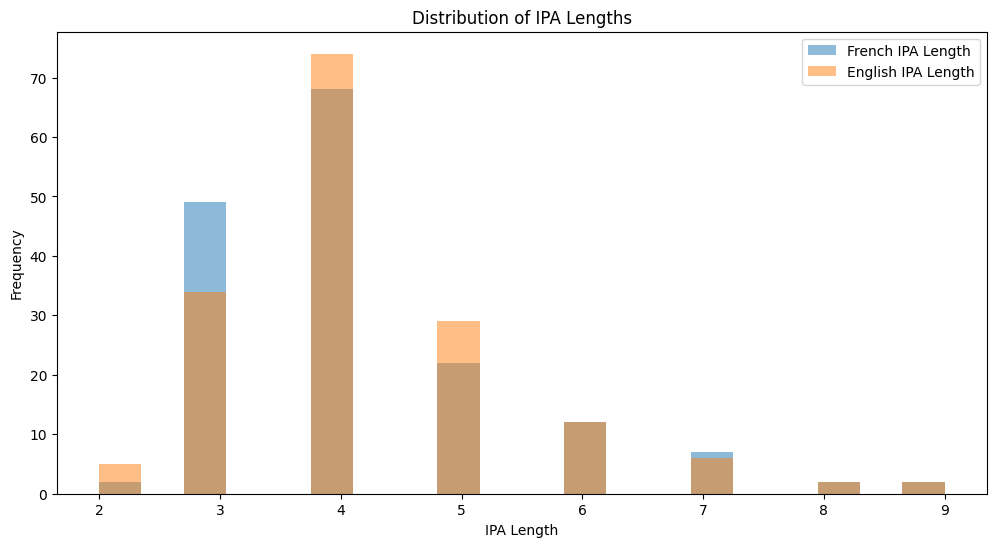

Common Phonemes:
S: 10
e: 83
a: 50
u: 36
M: 13
i: 33
A: 3
r: 25
B: 15
C: 12
o: 48
p: 7
D: 5
x: 6
F: 8
N: 1
s: 28
P: 15
R: 8
T: 5
t: 19
V: 4
é: 1
H: 1
m: 6
n: 28
d: 6
v: 5
L: 5
l: 28
c: 11
h: 11
g: 3
O: 2
J: 1
j: 1
b: 1
w: 5
y: 4
k: 5
f: 1


In [2]:
import matplotlib.pyplot as plt

# Distribution of IPA lengths
df['ipa_fr_length'] = df['ipa_fr'].apply(len)
df['ipa_en_length'] = df['ipa_en'].apply(len)

plt.figure(figsize=(12, 6))
plt.hist(df['ipa_fr_length'], bins=20, alpha=0.5, label='French IPA Length')
plt.hist(df['ipa_en_length'], bins=20, alpha=0.5, label='English IPA Length')
plt.legend(loc='upper right')
plt.title('Distribution of IPA Lengths')
plt.xlabel('IPA Length')
plt.ylabel('Frequency')
plt.show()

# Common phonemes analysis
from collections import Counter

fr_phonemes = Counter("".join(df['ipa_fr']))
en_phonemes = Counter("".join(df['ipa_en']))

common_phonemes = fr_phonemes & en_phonemes

print("Common Phonemes:")
for phoneme, count in common_phonemes.items():
    print(f"{phoneme}: {count}")

